In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, models, optimizers
import numpy as np
import os
from PIL import Image
import re
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
os.getcwd()

'/home/neosoft/Desktop/gan/gan_vibha/face_generation_using_GAN'

In [3]:
import os
image_dir = '/home/neosoft/Desktop/gan/gan_vibha/img_align_celeba'

In [4]:
dataset = keras.preprocessing.image_dataset_from_directory(image_dir, label_mode=None, image_size=(64,64),batch_size=32)
dataset = dataset.map(lambda x:x/255.0)
print(dataset)

Found 202599 files belonging to 1 classes.
<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


In [5]:
len(dataset)

6332

32


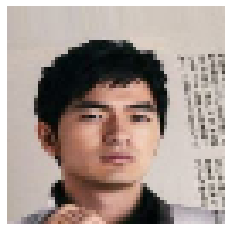

In [6]:
for i in dataset:
  plt.axis("off")
  
  print(len(i))
  plt.imshow((i.numpy()*255).astype('int32')[0])
  break

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [8]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
# signifies that the values obtained by model are not normalized & used when we dont have softmax (more classes) fn in our model
# helps in numerical stability
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)



# custom training loop
for epoch in range(500):
    for index, real in enumerate(tqdm(dataset)): 
        batch_size = real.shape[0]
        vectors = tf.random.normal(shape = (batch_size, latent_dim))
        print(vectors)
        fake = generator(vectors)
        
        if index % 100 == 0:
            print("real image shape ",real.shape)
            print("fake image shape ",fake.shape)
            Image = keras.preprocessing.image.img_to_array(fake[0])
            if not os.path.isdir('./result_dict'):
              os.mkdir('./result_dict')
            keras.preprocessing.image.save_img(f"./result_dict/images{epoch}_{index}.png", Image)
            
        with tf.GradientTape() as disc_tape:
            # actual values and predicted values
            real_loss = cross_entropy(tf.ones((batch_size, 1)), discriminator(real))
            fake_loss = cross_entropy(tf.zeros(batch_size, 1), discriminator(fake))
            total_disc_loss = (real_loss + fake_loss)/2
            
        # automatic differentation 
        # https://towardsdatascience.com/automatic-differentiation-explained-b4ba8e60c2ad
        grads = disc_tape.gradient(total_disc_loss, discriminator.trainable_weights)
        discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
        
        with tf.GradientTape() as gen_tape:
            fake = generator(vectors)
            generator_output = discriminator(fake)
            generator_loss = cross_entropy(tf.ones(batch_size, 1), generator_output)
            
        grads = gen_tape.gradient(generator_loss, generator.trainable_weights)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

        

  0%|          | 0/6332 [00:00<?, ?it/s]

tf.Tensor(
[[ 1.1670347   0.511371   -0.23393168 ...  0.27594155  1.6515387
   1.432462  ]
 [ 0.4351173  -2.1835506  -0.92000496 ... -0.35392636  0.29112425
  -0.6002203 ]
 [-0.71285397 -0.04486297 -0.21817717 ... -1.5972586  -0.64446
  -1.0040356 ]
 ...
 [-0.64676285  1.1787221  -2.0188558  ... -0.5131603  -1.1767623
  -1.4721954 ]
 [-1.0700892  -1.7170906  -0.36048096 ...  1.8004686   0.11578103
   2.4213488 ]
 [-0.74138474 -0.46891052 -1.5322769  ...  1.700107    0.9578988
  -1.8646902 ]], shape=(32, 128), dtype=float32)
real image shape  (32, 64, 64, 3)
fake image shape  (32, 64, 64, 3)


/home/neosoft/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
  0%|          | 2/6332 [00:02<2:05:28,  1.19s/it]

tf.Tensor(
[[-1.407445   -0.9661799  -1.5301193  ... -0.7472479   0.9284531
  -1.8436632 ]
 [ 1.8276532   0.5168919  -0.15688708 ...  0.6736213   0.8892048
   0.57330465]
 [-0.26110297  1.2135065   0.07511947 ...  0.35687867  1.560246
   0.77152675]
 ...
 [ 0.61101353  0.27019176  1.4123093  ... -1.7468543   1.570584
   0.41527587]
 [-0.3778601   0.37727627  0.8784228  ... -1.5089122  -1.0503149
   0.5512442 ]
 [-0.68094623 -0.0918437   2.3722963  ...  0.6015843  -0.37999815
  -0.4142824 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.9860453  -0.36919025 -0.7717381  ...  1.8429581  -0.1957415
  -0.4061512 ]
 [-0.5188117  -0.11335142  0.93321455 ... -0.7106089  -0.29342237
   0.9349257 ]
 [-0.76277053  0.28004476  1.1929573  ... -0.62114114 -0.9513688
  -1.098402  ]
 ...
 [-0.19774143  0.41081622 -1.8550975  ... -0.6588216   1.2196714
   2.8788188 ]
 [ 0.2700231  -2.2555776   1.6657159  ...  0.5866592  -0.13971697
  -0.796027  ]
 [-0.4087967   0.6639617   0.9469879  ... -0.8049092 

  0%|          | 4/6332 [00:03<1:02:31,  1.69it/s]

tf.Tensor(
[[ 0.37385273 -1.0276594   0.82497215 ... -1.0613717   0.29010737
  -0.3598443 ]
 [-1.1872034   1.0121123  -0.48388758 ... -0.34912232 -1.1434191
   0.02828986]
 [-0.48977375 -0.04955597 -1.3815216  ... -0.11062935  1.4618727
   0.2597305 ]
 ...
 [-0.14989886 -1.1212926   0.41212252 ... -0.7112676   0.05514091
   0.45885438]
 [-1.4573511  -1.8686054   1.4612653  ... -0.96051097 -0.7057484
   2.1758332 ]
 [-0.82288355  1.110521   -0.06447449 ... -0.54976416 -0.01790287
   0.17144366]], shape=(32, 128), dtype=float32)


  0%|          | 5/6332 [00:03<51:20,  2.05it/s]  

tf.Tensor(
[[ 1.0028778  -0.36060053  0.06549705 ... -0.85626346 -2.0624738
   0.49593762]
 [-0.44459325 -1.8738545  -1.6694083  ... -0.48651093  1.177458
  -1.7172241 ]
 [-0.52758753  0.20854783 -0.94331557 ... -0.11043765 -0.9543393
   0.42662564]
 ...
 [-0.77661073 -0.36020136  0.6938366  ...  1.9697862   0.14631064
  -0.07908649]
 [-1.5545973   0.665715   -0.06633878 ...  0.12339565  0.3354116
   0.75520414]
 [ 0.94927734  0.88771707 -0.43345213 ... -0.16153093 -1.0692025
   0.03864962]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.6916821   1.2111849   0.80403864 ... -0.82412964 -1.5306928
  -0.9223174 ]
 [ 1.6729754  -1.7185664   0.14385723 ... -0.51443857 -2.3128164
   0.59141195]
 [-1.7425855  -0.639259   -0.43868107 ... -1.7615781   0.6947328
   0.27058995]
 ...
 [ 0.6973022  -0.609095   -0.0353717  ...  0.35464114  0.6955465
   0.1908626 ]
 [-0.05533587 -1.6325463  -0.41284204 ... -0.7156437   0.23879632
  -0.37183744]
 [ 0.1180243  -2.0362604  -0.18521538 ...  0.25416544

  0%|          | 7/6332 [00:04<40:48,  2.58it/s]

tf.Tensor(
[[ 2.0582008   0.24514505 -0.08834799 ... -0.29927367 -0.11340775
  -1.2249306 ]
 [-1.7070978   0.17544726  1.8209106  ...  1.1953008   1.0809178
   1.8833187 ]
 [ 0.90448815  1.4874759  -0.41120884 ...  0.53535515 -0.45224556
  -0.7390948 ]
 ...
 [ 0.7237666  -1.5464672   0.4879636  ...  1.2888678   0.18290445
  -1.1121593 ]
 [-0.3746338  -2.7693675   1.2595006  ...  0.83031046 -0.11702192
  -2.4041882 ]
 [ 1.4452058  -0.0569375  -1.5622255  ... -1.1259409   0.5380966
   0.10617039]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.1085541  -0.4003102   0.25575423 ... -0.81572527 -0.6393881
   0.89165604]
 [ 0.1886133  -0.8489409  -0.9638357  ...  0.14186771  2.8147404
  -0.05754306]
 [-1.1013037   0.7140033   0.7470321  ...  1.4288363   1.6410637
  -1.7575053 ]
 ...
 [ 0.10943331 -1.4423279   1.3157372  ... -0.10647058  0.4577087
   0.96810585]
 [ 0.66674244  1.0985641  -0.84446543 ...  0.4637683   0.74201286
   0.08339392]
 [ 0.8450381   0.45734572  0.96015954 ... -0.4048

  0%|          | 8/6332 [00:04<38:34,  2.73it/s]

tf.Tensor(
[[-3.3668783e-01  2.3628752e+00  2.1052060e-01 ... -6.1653125e-01
  -1.6360945e-03  9.4245559e-01]
 [-4.7632031e-02 -2.3828027e-01 -1.0100214e+00 ... -7.5946623e-01
   4.8833635e-01 -1.1592298e+00]
 [ 2.8424138e-02  1.1901356e+00  1.1943271e+00 ... -7.2748119e-01
  -8.4721762e-01 -7.4346882e-01]
 ...
 [-1.1224599e+00  9.3111444e-01 -8.0150580e-01 ... -1.5876299e+00
  -1.4000475e-01  5.8198822e-01]
 [ 8.9269435e-01 -6.9831854e-01  2.1991351e+00 ... -1.3694185e+00
   1.9166234e+00 -6.7968148e-01]
 [-5.1970780e-01 -6.4933550e-01  6.9378948e-01 ...  8.4154680e-03
   2.8536069e-01  6.4460903e-01]], shape=(32, 128), dtype=float32)


  0%|          | 10/6332 [00:05<35:23,  2.98it/s]

tf.Tensor(
[[-2.6013567  -1.361625    0.8273366  ... -1.3039358   1.1474538
  -0.19623667]
 [-0.39021304  1.7884598  -0.37572786 ... -0.02392847  0.4333807
   2.9697046 ]
 [ 0.27762157 -0.37317085 -2.5974746  ...  1.4175469  -1.5693082
   0.12398694]
 ...
 [ 1.64344     2.4767573   1.7811062  ...  0.6360409   0.8858156
   0.6659546 ]
 [ 0.19162604  2.1108842  -0.1670965  ...  1.0071685   1.2201475
   0.5052047 ]
 [-0.41763228  0.5163928   0.11468849 ... -2.9853265   0.22375387
   1.0418583 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.43022987 -0.41313276 -0.8194196  ... -0.10334331 -1.4780769
  -0.9176323 ]
 [ 0.27767736 -1.1969962  -0.24569182 ...  2.1428893   2.0645828
  -1.4716845 ]
 [ 0.8092145   0.80158204  0.18624318 ...  1.0154      0.27888033
  -0.5074314 ]
 ...
 [ 0.1522757  -0.8125563   0.90599215 ...  0.8064591   0.13218269
  -0.6856556 ]
 [-1.178848    1.2002254   0.48308185 ... -1.0738772   1.3285072
   0.74704665]
 [-0.7842222  -2.537847    2.1918952  ... -0.046931

  0%|          | 12/6332 [00:05<33:37,  3.13it/s]

tf.Tensor(
[[ 0.75579095  0.28939998 -0.7078069  ...  0.339208   -0.6405082
   0.58594084]
 [ 0.14468881  0.7846381  -0.5586242  ... -0.31136355 -0.80912715
   1.6668242 ]
 [ 0.38952887  1.7284907   1.0159974  ...  0.6531841   1.2146621
  -0.54375654]
 ...
 [-0.07643629  0.2511305  -1.6852702  ...  1.1269419   0.13538058
  -0.37744597]
 [ 0.9169125  -0.6512791  -0.26720423 ... -0.24836488 -2.3743434
  -0.5198896 ]
 [-0.06579268  1.0471494  -0.48713806 ...  1.0436321  -1.529892
   2.065439  ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.6674339   0.13287471 -0.80798745 ...  0.00891241 -1.051255
   0.7312631 ]
 [-1.2747188   0.2527942  -1.4190768  ...  0.8934088   0.87113297
   1.7539247 ]
 [ 1.1644759  -0.8041019  -1.5465541  ...  1.088781    1.1428354
  -1.7208571 ]
 ...
 [-0.28275427 -0.09593893  1.2225167  ...  0.39916575  0.51067615
  -0.18032096]
 [ 0.36075673 -0.18387751 -1.3065686  ... -0.937962   -1.0174992
   0.8506871 ]
 [ 0.89864165 -1.1186017   0.12537603 ... -0.3140298

  0%|          | 14/6332 [00:06<32:40,  3.22it/s]

tf.Tensor(
[[-1.4578837   1.51091     0.92452884 ... -0.47166574 -1.3473039
  -0.11964904]
 [-0.39879262 -0.81881475 -0.09647264 ...  0.7163117  -1.2343999
  -0.06219362]
 [-0.26501504  0.8092179   0.19486865 ... -0.5701421   1.7855511
   0.7690063 ]
 ...
 [-1.0167186   1.171355    0.923377   ... -0.11074998  1.1216717
  -0.35239795]
 [ 1.8330175  -0.7022947   1.6605272  ... -0.11724865 -1.3786701
   0.3883967 ]
 [-0.07237754  0.37901887  1.0488633  ... -0.00824589 -0.38064912
   0.1105048 ]], shape=(32, 128), dtype=float32)


  0%|          | 15/6332 [00:06<32:09,  3.27it/s]

tf.Tensor(
[[ 0.52554685 -0.02882887  1.1543777  ... -0.12630461 -1.0160671
  -0.29530367]
 [-0.80903727 -0.64182836 -1.5693072  ... -0.95699745 -0.2806523
   0.61976284]
 [ 0.38122582  0.28463966 -0.6772147  ...  0.76849616  0.7601886
   0.5647613 ]
 ...
 [-0.18395151 -0.8533331   2.8981874  ... -0.4772741  -1.5922916
   0.911771  ]
 [-1.5553098   0.6656594   1.8327394  ...  0.1124358  -1.5098989
  -1.8330908 ]
 [-0.5705847  -1.6112434   0.94748574 ... -1.1650583   0.4347121
   0.5504705 ]], shape=(32, 128), dtype=float32)


  0%|          | 16/6332 [00:07<32:00,  3.29it/s]

tf.Tensor(
[[-1.3379425  -0.44008455 -1.2152692  ...  1.3273466   1.4513662
   0.0689659 ]
 [ 0.2088028   1.1995461   0.12226642 ... -0.74286044 -0.14642927
   0.47924104]
 [ 0.97776985  0.02128144  0.8640388  ...  0.28740457  0.55683297
  -1.1528156 ]
 ...
 [-2.0908222   0.07846938 -0.20318887 ... -0.4769971  -0.7635864
   1.9033235 ]
 [ 0.87682164  1.0993568  -0.11277875 ... -1.326564    1.6648728
   0.17267942]
 [-0.82253283 -1.3416094  -1.8885958  ... -1.9862629   0.32742152
  -3.0232756 ]], shape=(32, 128), dtype=float32)


  0%|          | 17/6332 [00:07<31:33,  3.33it/s]

tf.Tensor(
[[-0.24678743 -0.49000287 -0.3752764  ... -0.45020026 -0.28006423
  -1.5684466 ]
 [ 0.78039205 -1.9436198   0.01332915 ... -1.0252526  -0.9056668
  -0.69313866]
 [-0.4219642  -0.19234924  0.6206684  ...  1.1201793  -0.07045554
  -1.0081666 ]
 ...
 [-1.0687945  -0.5784868  -0.5393211  ...  1.3032712   0.66591376
  -0.8446028 ]
 [-2.3042436   1.3968079  -1.585486   ...  0.02621819  0.22254805
   0.45551062]
 [ 0.6089204  -1.1715637   0.81354594 ...  2.1469579   1.2053514
  -1.1012487 ]], shape=(32, 128), dtype=float32)


  0%|          | 18/6332 [00:07<31:17,  3.36it/s]

tf.Tensor(
[[-1.0880294   1.1709106   1.1069357  ...  0.8052685  -1.0700135
  -0.62452996]
 [ 0.32579482  0.3424759  -0.11592244 ... -0.4258033  -0.36410064
   0.5773212 ]
 [-1.335572    1.7555993   0.03772373 ... -0.9166288  -1.0102835
  -2.4649594 ]
 ...
 [-0.0666314  -2.1117394   0.6145033  ... -0.71639746  0.9439318
   1.5277966 ]
 [-1.0086159  -0.5733971   1.1919597  ... -0.49773312 -0.52719396
   0.7825607 ]
 [ 0.91750836 -0.23736411  0.45373395 ...  1.1676662  -0.8632709
   2.260924  ]], shape=(32, 128), dtype=float32)


  0%|          | 19/6332 [00:07<31:27,  3.34it/s]

tf.Tensor(
[[ 0.6951086   0.09993824 -0.31115058 ...  0.21714436  0.7181164
   0.6541002 ]
 [ 0.4361822   0.87773     1.1509831  ... -0.04925434  0.9526398
  -0.47095123]
 [-1.0178298   0.05943312  0.69908524 ...  1.0110382  -0.7993777
   0.8129459 ]
 ...
 [ 0.7860962  -1.250838   -0.9941358  ... -0.43047857  0.2846039
  -0.10692502]
 [-0.56896603  1.3813568  -0.9552477  ...  0.8558041  -0.3619916
   1.4979672 ]
 [-0.01893095 -0.6962327   0.18007682 ...  1.9582285  -1.868472
   0.09923171]], shape=(32, 128), dtype=float32)


  0%|          | 20/6332 [00:08<31:19,  3.36it/s]

tf.Tensor(
[[ 0.37536404  0.33973926 -0.29798806 ... -0.15922002  0.82645893
   0.72746503]
 [ 1.3776191   0.7507445   0.93652016 ...  0.20288962 -0.97536844
   0.6915565 ]
 [-0.1580701  -0.63583153  1.6939999  ... -1.0553493   0.17583175
   0.07725874]
 ...
 [ 0.35690096 -0.8048565  -0.15180051 ...  0.811997    2.4031947
  -0.13901408]
 [ 0.19147557  0.870169   -0.7832757  ... -1.3617972   0.125078
   0.11991528]
 [ 0.17413822 -0.97422916 -0.7620798  ...  1.3153937   0.5074325
  -0.51101166]], shape=(32, 128), dtype=float32)


  0%|          | 21/6332 [00:08<31:13,  3.37it/s]

tf.Tensor(
[[ 1.2524246   1.9738475  -1.2089938  ...  0.9311349   0.24742146
   0.5456681 ]
 [ 1.9439698  -1.579079    0.2807264  ...  1.6279557  -0.820068
  -0.4045577 ]
 [ 0.468563    0.7105765  -0.10589107 ...  0.32761976 -0.66964847
  -0.8018034 ]
 ...
 [-0.3824762  -0.69044423 -0.1033591  ...  0.86961156  0.7035864
   0.24931799]
 [-0.8552213   0.28350288 -1.1521816  ... -2.4186606  -0.7255783
   0.50590146]
 [-0.33785158  0.6258032  -0.7043218  ...  0.77810544  0.7587324
   1.8533472 ]], shape=(32, 128), dtype=float32)


  0%|          | 22/6332 [00:08<30:58,  3.39it/s]

tf.Tensor(
[[-1.7497445e+00 -7.0568949e-01 -1.3446891e-01 ...  1.5959347e+00
  -9.6823919e-01  1.6288830e-01]
 [-4.9009821e-01  6.0902804e-01  1.5280794e-01 ...  1.3697169e+00
   9.8882520e-01 -5.9614855e-01]
 [ 1.3404346e+00 -3.1319699e-01  6.1001200e-02 ...  1.4676764e+00
  -1.2930983e+00  1.1445594e-02]
 ...
 [-1.3243191e+00  6.8171507e-01  1.3254373e-01 ... -1.3281769e-01
  -5.0478077e-01  5.8146226e-01]
 [ 1.0675373e+00 -1.3897305e-03  4.4417983e-01 ... -5.8716112e-01
   4.9494401e-01 -4.7751638e-01]
 [-2.0527083e-01 -6.2843251e-01 -7.2829586e-01 ... -4.5041215e-01
  -7.7134389e-01 -1.6444924e+00]], shape=(32, 128), dtype=float32)


  0%|          | 23/6332 [00:09<31:10,  3.37it/s]

tf.Tensor(
[[-1.4378303   0.93091875  0.4385377  ...  0.14804105  1.4659058
  -1.5333959 ]
 [ 0.42681453  2.2091565  -0.2062991  ...  0.37764677  2.3540182
  -0.13279973]
 [-0.08923079 -0.08472369 -1.0395427  ...  0.45232517 -0.43961418
   0.5828758 ]
 ...
 [-0.20747586  0.33169386  0.09279777 ...  0.91170424 -0.8434685
   0.3946234 ]
 [-0.6309944  -1.0352422  -0.26083118 ... -0.12978826  0.41598716
   1.3176583 ]
 [-0.10995038  0.49918035 -0.18185896 ...  1.8072238  -0.467941
  -0.06276058]], shape=(32, 128), dtype=float32)


  0%|          | 24/6332 [00:09<31:07,  3.38it/s]

tf.Tensor(
[[ 0.6929684   1.5091923   1.1729627  ...  0.09407333  0.8452451
   0.09255363]
 [ 1.3337349   1.3107711  -0.81417376 ... -0.38820097 -0.2554796
  -0.3284957 ]
 [-0.32424837 -1.9905065   1.5267087  ... -0.65599173  0.724838
   0.5169663 ]
 ...
 [-0.41913682  0.47385955  1.0710808  ... -0.5097471   0.5995039
  -0.11648252]
 [ 0.68019587  0.18348199  0.9863116  ...  0.49245763  0.73302996
   0.7096888 ]
 [ 3.0733175  -1.2722332  -0.4078382  ... -2.7919564   0.8327989
   0.6494881 ]], shape=(32, 128), dtype=float32)


  0%|          | 25/6332 [00:09<31:04,  3.38it/s]

tf.Tensor(
[[ 1.3811239   0.10269535  0.17624813 ...  0.7743497   0.416873
   0.23756658]
 [ 0.26558185  1.0410529   0.704051   ... -0.36727798 -0.42986852
  -1.7199248 ]
 [ 1.9645066   0.85216343  0.18336175 ...  0.02072947 -0.98268443
   1.0119675 ]
 ...
 [-0.5235231  -1.4369775   0.45238703 ... -1.5929577   1.0127977
   0.55317646]
 [ 1.9516255  -0.04532975 -0.8433561  ...  0.03155962 -0.20452452
   1.0367172 ]
 [ 0.11065446  0.40776452 -0.26262787 ...  1.4396648   0.6896729
  -0.32165366]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.75258934 -0.4602246   1.8930109  ...  0.3536478  -1.2349838
   0.30671108]
 [-0.54773176 -1.1343442  -0.31959853 ... -0.07943479 -0.00440916
  -1.0524652 ]
 [ 0.83744955  1.2601142  -1.886071   ...  3.390711    0.3025568
  -0.26893097]
 ...
 [ 0.14219749 -0.2362932   0.39003158 ... -0.71059406 -0.2565773
  -0.08843549]
 [ 0.15525888  0.68488115 -0.01071712 ...  0.9662575  -0.20489763
   0.3466489 ]
 [-0.54666317  0.8683219   0.3790269  ...  0.33194

  0%|          | 27/6332 [00:10<31:48,  3.30it/s]

tf.Tensor(
[[ 0.1460371   1.4736413   0.50335974 ...  0.63981444 -0.7254102
  -1.1630403 ]
 [-0.30861437  1.501714   -1.1550716  ... -0.11865588 -0.38674796
  -0.5572878 ]
 [-0.70959705  0.33521396  0.795395   ... -1.2891738   1.7510431
  -1.2308376 ]
 ...
 [-0.3017148  -0.01603082  0.28353888 ... -0.48987785  0.8090402
   0.2884939 ]
 [-1.2105324  -0.21304299 -1.7855942  ... -0.6530248   0.3990701
  -0.1331179 ]
 [-0.73434955  1.3272176   0.23076092 ...  0.82215977 -1.3583912
  -1.3500657 ]], shape=(32, 128), dtype=float32)


  0%|          | 28/6332 [00:10<31:47,  3.31it/s]

tf.Tensor(
[[-0.868531    0.2691217   1.2342392  ...  0.77020645 -0.60825807
  -1.1782862 ]
 [ 0.48972288  0.03381878 -0.48448107 ... -0.13881609 -1.189199
  -0.666126  ]
 [-1.4785972   0.5633654   0.22413613 ...  0.21798879 -0.7507032
   1.2198312 ]
 ...
 [ 1.2662512   1.0411823  -0.37192672 ... -2.0973928  -0.46435356
   2.0297995 ]
 [ 0.23249128  0.46756914 -1.1549177  ... -0.7008247  -0.05736539
   0.4138679 ]
 [ 0.5411263   0.81521916 -0.43614832 ...  0.8901266  -0.91690457
  -0.7060649 ]], shape=(32, 128), dtype=float32)


  0%|          | 29/6332 [00:10<31:37,  3.32it/s]

tf.Tensor(
[[-0.75939035  0.9833806  -0.8289893  ... -0.74551207  0.47906774
  -1.4293631 ]
 [-0.2965715   0.19143979  1.0566702  ... -0.33291927 -0.62244123
  -1.8814254 ]
 [ 1.3536705  -0.6279719   0.6948408  ...  1.1181208  -0.5034744
   0.35010803]
 ...
 [ 1.1196028   1.5302005  -0.9599503  ...  0.14401937  2.0506496
  -1.4955148 ]
 [ 1.0356879   1.5012584   0.8810684  ... -0.10907053  2.109815
  -0.20071796]
 [ 1.3958145  -0.51452607 -0.62771195 ...  1.1649305   0.78814757
  -0.8698383 ]], shape=(32, 128), dtype=float32)


  0%|          | 30/6332 [00:11<31:23,  3.35it/s]

tf.Tensor(
[[-0.9762883  -0.13193962  0.42592055 ... -0.02975162 -0.7143055
   0.6918184 ]
 [ 0.61542475 -2.6223938   0.24861377 ... -0.00508441 -0.1181748
  -0.26632822]
 [ 0.2957473  -0.44727483 -0.13605519 ... -0.42073664 -0.5266726
   2.7573297 ]
 ...
 [ 0.46803477 -0.3749548  -0.63197947 ... -0.34442216 -0.7080152
   1.7297524 ]
 [-1.4472113   0.48160815  1.5455222  ... -0.35433397 -0.72609407
  -0.12915227]
 [ 0.2407192   0.793624    0.63484764 ... -0.5762261   2.5030518
  -1.6038659 ]], shape=(32, 128), dtype=float32)


  0%|          | 31/6332 [00:11<30:54,  3.40it/s]

tf.Tensor(
[[-1.2350287  -0.5076266   1.358317   ... -1.782437   -0.02258437
  -0.336655  ]
 [ 0.8712141   0.3770285  -1.3456756  ...  1.1171824  -2.086966
   0.96362585]
 [-2.560078   -0.31571797  0.5177065  ...  1.5596124  -0.7401661
  -0.95249134]
 ...
 [-1.4445733   1.4277602   0.71546096 ... -1.2270018  -0.5022701
  -0.5307553 ]
 [-0.5073845   0.6546785  -0.27130464 ... -1.6678227   0.554467
  -0.43989068]
 [-0.7007185   1.0049276  -2.0253055  ... -1.571192    0.53371066
  -0.320729  ]], shape=(32, 128), dtype=float32)


  1%|          | 32/6332 [00:11<30:55,  3.39it/s]

tf.Tensor(
[[-0.26209685 -0.5538847  -1.331472   ... -1.2297175   2.0595484
   0.08225826]
 [ 0.2647924  -0.7441332   0.33558428 ... -0.0348518  -1.7262056
   0.38491437]
 [ 0.48831916 -0.56428427  1.1502187  ... -0.13643742  1.3972399
  -1.0125313 ]
 ...
 [ 0.7756432  -1.8484851   0.35378662 ...  0.89648515  0.75325733
  -0.04983836]
 [ 0.8205249   0.07461677 -0.19934665 ... -0.7522748   1.5862758
   1.1850408 ]
 [-3.1632037  -0.9969885   0.87754923 ... -2.4417658   0.10203555
   1.8108853 ]], shape=(32, 128), dtype=float32)


  1%|          | 33/6332 [00:12<30:51,  3.40it/s]

tf.Tensor(
[[-0.59155494 -0.42081657  1.4914131  ...  1.0077167  -0.23551053
   1.0188293 ]
 [ 1.1314632   0.7687733   0.77076405 ... -1.5059103  -0.6833679
  -0.9581192 ]
 [-0.76418173  0.4849872   0.06364439 ... -0.5028181  -0.26894653
   1.568447  ]
 ...
 [-1.631063    0.6412906   0.3302798  ... -0.26179934  0.5838579
   0.7849471 ]
 [ 0.3318174  -1.7198733  -0.0892024  ...  0.17770675 -1.2614666
   0.27571088]
 [-0.97189325 -0.2517225   1.1007223  ...  0.3709958   1.8373064
   0.7927652 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 2.0212402   0.41831398  0.08011501 ... -0.12292892 -1.0631481
   0.56300557]
 [-0.7487279  -0.20599014  0.6950832  ...  0.83993125  0.01022069
  -0.7579585 ]
 [-1.381019    0.03048989  1.6304113  ... -0.3220645   0.06035919
  -1.218325  ]
 ...
 [-0.49293873  0.49240434  2.209169   ... -0.34495983 -0.47662374
   1.3580273 ]
 [ 0.41998354  0.74788135  2.4490807  ... -1.3476533   0.89727354
  -0.00538603]
 [-0.20266578 -0.65365875  0.9279801  ... -1.270

  1%|          | 34/6332 [00:12<31:40,  3.31it/s]

tf.Tensor(
[[-1.0093336  -0.6095009  -1.6313289  ... -0.6270563  -0.06822244
   0.06086619]
 [ 0.4167404  -0.49059838  1.1959549  ... -0.31970894  0.9572072
   0.26788214]
 [ 0.06840456 -0.88280207 -0.00635245 ...  0.309392    1.0846883
  -0.07085078]
 ...
 [ 1.3322349  -0.8790981  -1.0697743  ... -0.37851802  0.33028242
   0.64365464]
 [ 0.6070659  -0.7730628  -0.06800747 ...  0.82242227 -0.49434373
  -0.33336014]
 [ 1.8993282   1.508883    0.4117309  ... -0.7773306  -0.5351095
   0.60785115]], shape=(32, 128), dtype=float32)


  1%|          | 35/6332 [00:12<31:43,  3.31it/s]

tf.Tensor(
[[-9.47875261e-01 -1.10337961e+00 -9.14487243e-01 ...  6.66398287e-01
   1.72792065e+00  4.83057052e-02]
 [ 1.18443273e-01  1.56027424e+00  4.36839342e-01 ...  1.37219930e+00
  -6.23950601e-01 -3.24750282e-02]
 [ 1.75263798e+00 -1.10889964e-01 -1.40477180e-01 ... -6.99033618e-01
   4.08713907e-01  1.61393166e-01]
 ...
 [-3.66521895e-01 -6.46144867e-01  1.83019030e+00 ...  1.50821730e-01
   5.31155169e-02  3.25635523e-02]
 [ 1.14760566e+00 -2.78265655e-01  3.51340026e-01 ... -8.65553796e-01
  -9.05513704e-01 -4.35135104e-02]
 [-7.75235176e-01  5.76171935e-01 -5.70116972e-04 ... -9.30416167e-01
   5.65789640e-01 -3.59858304e-01]], shape=(32, 128), dtype=float32)


  1%|          | 37/6332 [00:13<31:32,  3.33it/s]

tf.Tensor(
[[-1.7835382   0.1442173  -0.12445998 ... -0.79292184  0.63176197
   0.26506704]
 [-0.07837905  1.1368349  -1.3962011  ... -0.48748294  1.4285028
  -0.7630513 ]
 [-0.39160785  0.592626   -0.7612794  ...  0.7465605   0.5675526
   0.12476008]
 ...
 [ 0.22352013  1.8897173  -0.5932951  ...  0.5658538  -0.29465008
   0.9975612 ]
 [ 0.40279737 -1.6741631   0.69307005 ... -0.08466554  1.1342942
  -1.0902277 ]
 [-0.33578068  0.05654107  1.2325859  ...  1.3243513   1.824847
  -0.85375714]], shape=(32, 128), dtype=float32)


  1%|          | 38/6332 [00:13<31:35,  3.32it/s]

tf.Tensor(
[[ 0.2880782   1.0364431  -0.96382666 ... -0.2150619   0.3824296
  -0.43935987]
 [ 0.05636543 -0.23635896  1.0842377  ...  0.4674486  -0.36757123
  -0.34033257]
 [-1.6184766   0.9526101  -0.10626363 ... -0.24375305 -0.4987481
   1.0378846 ]
 ...
 [-0.54752076  1.0368086   1.6613593  ...  0.48585758  0.48448205
  -0.39398035]
 [ 1.6130607  -0.9369308  -0.29549885 ... -1.9408245  -2.6214902
  -1.9385657 ]
 [ 0.584901   -1.3779603   1.3881793  ... -0.8785599   0.5695304
  -0.05203358]], shape=(32, 128), dtype=float32)


  1%|          | 39/6332 [00:13<31:30,  3.33it/s]

tf.Tensor(
[[-1.0398686   1.3437337  -1.4301246  ...  1.2066605  -0.1791866
  -0.799343  ]
 [ 1.0497931  -0.2446326  -0.5864548  ...  1.3325783  -1.2202896
   0.33026007]
 [-0.85843045 -1.6030084   0.4432608  ...  0.33866042  1.0693378
  -0.26831833]
 ...
 [ 0.4714038   0.08642514 -0.32777083 ... -2.1231017   0.5420683
  -2.0412493 ]
 [-0.89586455 -0.9517593  -1.9922658  ...  0.38381374  0.3409599
  -0.06067676]
 [ 0.01634316  1.1235982   0.46798095 ...  0.9113986   1.5864269
   1.9355724 ]], shape=(32, 128), dtype=float32)


  1%|          | 40/6332 [00:14<31:19,  3.35it/s]

tf.Tensor(
[[ 0.47479078  0.51583993  1.4382654  ... -0.23926993  0.80844545
  -0.53209513]
 [-1.0553442   1.6613727   0.66111493 ...  1.3688817   0.05273774
   0.5425407 ]
 [ 0.29941872 -0.28104085 -0.23010468 ...  0.47652435  1.9236287
  -0.21459697]
 ...
 [ 0.12325675 -0.5297366  -0.09623349 ... -0.7078061   1.580044
  -0.2148452 ]
 [-1.4433836   0.37918586 -0.43475306 ... -0.02570365 -1.3273321
  -0.28063285]
 [ 0.42282033  0.1419002   0.6006018  ... -1.4121424  -0.04486446
   1.0437349 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.49217546  1.5245355   0.87295717 ...  0.7010894   0.07446878
  -0.8724831 ]
 [ 0.68118495 -0.3468809  -0.3976013  ... -0.3201533  -0.21047659
   2.0769613 ]
 [ 0.72661716  0.96895427 -0.09170124 ... -0.35371265 -1.6967735
   0.6026816 ]
 ...
 [ 0.20742165 -1.3199683  -1.6905702  ...  1.628789   -0.20256703
  -1.1284747 ]
 [ 0.32564452  0.2596464   0.27344036 ...  0.90435416 -0.5727682
  -0.2396252 ]
 [ 1.457751    1.2212691   0.17907938 ...  0.2317

  1%|          | 42/6332 [00:14<31:13,  3.36it/s]

tf.Tensor(
[[ 0.23967986  0.7890058  -0.59510374 ... -0.12802814 -0.5605476
   3.5397618 ]
 [ 0.3305754  -0.5514145   1.8284551  ...  0.77889556  0.02223749
  -0.83641994]
 [-0.3594012  -0.6242726  -0.95192516 ...  1.498847    1.2273324
  -2.1785514 ]
 ...
 [-0.45371982 -1.0832626  -1.0156447  ... -1.6265305   0.64685136
  -0.28914437]
 [ 0.27563277 -0.407777   -0.7509387  ...  0.6033015   2.9753618
  -1.301069  ]
 [ 0.27318352  0.01832252 -0.34062463 ...  0.28115433 -0.3402297
   0.79867166]], shape=(32, 128), dtype=float32)


  1%|          | 43/6332 [00:15<31:06,  3.37it/s]

tf.Tensor(
[[-0.38363263  0.86612     0.27592012 ... -1.5958824  -0.5532934
  -0.42412636]
 [-0.82950705  2.4489796  -0.49026257 ... -2.14152     1.8215069
   0.7292809 ]
 [-0.00850621 -0.0203313  -2.8094938  ...  0.71954393  0.95824146
  -0.24681257]
 ...
 [ 0.5996479   0.5605058  -0.6413197  ...  1.6357677  -2.4162416
  -0.7245483 ]
 [-0.2970576  -0.667051    0.2803406  ...  1.6957166   0.20807798
  -0.70292115]
 [ 0.7360667   0.6887971   1.3034805  ...  0.10712025  0.897709
  -0.73450553]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.77597314 -0.8597339  -0.57377857 ...  1.1703049  -0.47065797
  -0.21767151]
 [-0.54743516  0.5935613  -0.57230437 ...  0.57008946  1.1168101
   0.16021939]
 [ 0.26058343 -1.6658301  -1.6466902  ... -1.08666    -0.13593185
   0.29423255]
 ...
 [ 2.202332   -0.98373425  0.5982427  ...  1.132947   -0.31706524
   0.6370378 ]
 [-0.7189157  -0.6804669   1.2008712  ...  1.1053966  -0.33721268
  -0.0031348 ]
 [ 0.06269892  0.7358865   1.9741421  ...  1.8521

  1%|          | 44/6332 [00:15<31:40,  3.31it/s]

tf.Tensor(
[[ 1.4204055e-01 -2.9631525e-01  1.6554259e-01 ... -1.4196891e-01
   5.5164576e-01 -1.8304655e-01]
 [-1.0028353e+00  1.3209313e-01  3.3365759e-01 ...  1.7261651e+00
   2.0577352e+00 -9.4528973e-01]
 [-6.4227706e-01 -2.6579818e-01  7.7575380e-01 ... -1.1219338e+00
   4.4515893e-01 -1.2793091e-01]
 ...
 [-1.1118404e+00  7.3750407e-01 -1.4101208e+00 ... -5.2738482e-01
  -1.7671112e-03 -4.3408698e-01]
 [ 1.2557774e+00  4.4744402e-01  8.3940804e-01 ... -3.7051725e-01
  -1.0870991e+00  2.1891518e+00]
 [-2.7557043e-02  3.9253256e-01  1.5701051e-01 ... -1.1133490e+00
   9.4244492e-01  1.6158018e-01]], shape=(32, 128), dtype=float32)


  1%|          | 45/6332 [00:15<31:32,  3.32it/s]

tf.Tensor(
[[-0.30478728 -0.41175425 -0.7201635  ...  0.8093766   0.2897654
   1.5459325 ]
 [-0.46567994 -2.4709828   0.08141682 ...  0.14407428  1.3041902
  -0.30051485]
 [ 0.6949978   1.223283   -0.04594188 ... -0.60754883 -0.37737226
  -0.9505668 ]
 ...
 [-0.6961907   2.2068572  -0.33301017 ... -1.2409447   0.49768823
  -0.84946704]
 [-0.34902465  1.1496439  -0.29315194 ...  0.5820546   2.00115
  -0.18731187]
 [ 0.17837013 -0.4748968   0.80634964 ... -0.06816669  0.23106909
   0.60954374]], shape=(32, 128), dtype=float32)


  1%|          | 47/6332 [00:16<31:56,  3.28it/s]

tf.Tensor(
[[ 1.275029    0.0204218  -0.0769267  ...  0.50791883  0.11989841
  -2.1976855 ]
 [ 0.6704286   1.5663073  -0.83069235 ... -1.6727353   1.1708757
  -0.01664055]
 [ 1.8531084  -0.49139768  0.7493051  ...  0.05696819  1.337931
   1.4293319 ]
 ...
 [-1.0555267   0.3222895  -0.06644739 ... -1.0621678   0.6326399
   0.07012342]
 [-1.7899476   1.3651693   0.95622766 ... -0.85180724  1.7351781
   1.1404107 ]
 [-0.12414038  0.42133483  0.67945844 ...  1.0304545  -0.7606903
   0.42685863]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-2.2333148  -0.7009061  -0.90477806 ...  0.08713762  0.5338044
  -0.19854994]
 [ 0.01579083  0.02386518 -0.33023623 ...  0.8600144   1.4720507
  -0.3442251 ]
 [-0.8284629  -0.44441307 -1.3255979  ...  0.8852034   0.3530244
  -1.1615418 ]
 ...
 [-0.3668235   1.0984522   0.45284113 ... -1.0223002   0.96719867
   1.9107513 ]
 [ 0.22752957  0.706816   -0.9119517  ... -1.729185    0.9267667
  -0.1594267 ]
 [-0.708064   -0.5916222  -0.5392379  ... -0.70159036

  1%|          | 49/6332 [00:16<31:31,  3.32it/s]

tf.Tensor(
[[-0.1626991  -1.6730814   0.7044652  ... -1.760489   -1.0830368
   1.0471077 ]
 [ 0.24317642  0.17842191 -2.0037887  ...  0.26246923 -1.039415
   0.7487076 ]
 [-0.22568153 -1.0135134   0.8705984  ...  0.01887784  1.0800501
   0.07694575]
 ...
 [ 0.7656848   1.1612171   0.25646004 ...  0.9258074   0.11082864
   2.5182323 ]
 [ 0.10085072  0.9819539   0.951932   ...  0.1064497  -0.56416565
  -0.55195296]
 [-0.30177987  2.013654   -0.70009655 ... -0.42757493 -0.75258577
   0.06858278]], shape=(32, 128), dtype=float32)


  1%|          | 50/6332 [00:17<31:29,  3.33it/s]

tf.Tensor(
[[ 0.0233888   0.93924785  1.0468593  ...  0.3532199  -1.3952968
  -0.85945123]
 [ 0.6011724   0.9191113  -0.28849593 ... -0.94370884  1.2168
   0.51360047]
 [-1.6349753   1.0504898  -1.8677409  ...  0.9479862   0.03735903
  -1.9181924 ]
 ...
 [ 0.07557962 -0.4727171   0.61871165 ... -1.0099968  -0.33470106
   0.10433248]
 [-0.05105611  0.23014858  2.0875237  ...  1.6751732   0.37584507
   1.5413326 ]
 [-0.9932628  -1.152747   -0.13864265 ...  1.3089715  -1.959304
  -0.5790824 ]], shape=(32, 128), dtype=float32)


  1%|          | 51/6332 [00:17<31:15,  3.35it/s]

tf.Tensor(
[[-1.6546133   1.4477062   0.04409016 ...  1.0606256  -0.37663236
   1.1354606 ]
 [ 2.0261552  -0.48961484 -0.05836717 ...  0.22175255  1.0735537
  -1.4925785 ]
 [-0.25469786 -0.51298976  0.51384723 ... -0.33697325 -0.6938593
  -0.5348318 ]
 ...
 [-0.5712533  -1.6927305  -1.2381186  ... -0.98037255 -0.10992797
  -0.18096827]
 [-1.0082237  -0.49378982  0.2668734  ...  1.6742345  -0.95995253
   0.38517532]
 [-0.59826475  0.5289707   0.9507073  ...  1.2177434  -0.41467118
  -1.3747089 ]], shape=(32, 128), dtype=float32)


  1%|          | 52/6332 [00:17<31:27,  3.33it/s]

tf.Tensor(
[[-1.7432922  -0.8641811  -0.14386109 ... -1.1450844   0.17885372
  -0.09112942]
 [-0.43387157 -0.34586212  3.7030172  ... -0.03780152 -1.0259281
  -0.82157457]
 [ 1.7443084   0.66246283  0.84804356 ...  0.5562942  -2.267323
  -0.79042935]
 ...
 [-0.06602719 -1.0245521   1.4881055  ...  0.63905704  1.3243114
  -0.19573043]
 [-0.8998565  -1.3198454  -1.134496   ... -2.8649075   1.10012
  -0.9723876 ]
 [-0.5415603   1.8720438  -0.54837465 ...  0.5381744  -0.06636922
   0.28928617]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.0215446   1.8963754  -0.7992742  ...  0.5741403   0.9030272
   2.4965105 ]
 [-1.871181   -1.5099708  -0.46248144 ...  0.10819519  0.39259803
   0.57187414]
 [-0.38970652 -2.1665785   0.0859401  ...  0.7901554   0.5133763
  -0.9364672 ]
 ...
 [-0.18885708 -1.5904939  -0.51709634 ...  0.6158425   0.4702013
  -0.76850677]
 [ 0.08813232  0.41548878 -0.24133931 ... -0.9800429   0.8965433
   0.11377752]
 [-0.716832    0.09445495  1.4346772  ... -0.00869169 

  1%|          | 53/6332 [00:18<31:51,  3.28it/s]

tf.Tensor(
[[ 0.78761554 -0.38564408 -0.14419898 ...  1.8865633   0.48934332
   0.36268598]
 [ 0.29102987 -0.7366019  -0.31135404 ... -0.2023701  -1.6012563
   0.29583624]
 [ 0.37734947 -0.3013298   0.33310705 ... -1.0078381   0.73907393
  -0.46966943]
 ...
 [-0.31762153  1.9736563   1.0552907  ... -0.00713206  1.7152264
  -0.1834617 ]
 [-1.1314474   0.9887296  -0.1964305  ...  1.4275198  -0.13869551
  -0.20527461]
 [ 0.4882265  -0.1146019  -1.4195304  ...  0.93383753  0.22978829
   0.21364845]], shape=(32, 128), dtype=float32)


  1%|          | 54/6332 [00:18<31:45,  3.29it/s]

tf.Tensor(
[[ 1.5258454  -0.5422964   0.27283463 ...  0.75172347  1.7068715
  -1.8073407 ]
 [ 0.01821812 -0.90213007 -0.66496897 ... -2.5107832  -0.9886896
   0.43430564]
 [ 0.4820191  -0.31229603  0.00257955 ...  1.4597273   0.5741619
   0.8006612 ]
 ...
 [-1.7395338   0.47101572  1.3119692  ...  0.5422684   1.1614699
  -0.643012  ]
 [ 0.17938742  0.17749885  1.1319171  ... -1.1253325  -1.6261293
  -0.056613  ]
 [-0.05877045  0.0740089  -1.4119084  ...  0.2449445  -2.0507743
   1.9359785 ]], shape=(32, 128), dtype=float32)


  1%|          | 55/6332 [00:18<31:43,  3.30it/s]

tf.Tensor(
[[ 1.0469471   3.1867995   0.4826394  ...  0.04354203  0.1783208
  -0.7228699 ]
 [ 0.47061652 -1.3747495   0.43405196 ... -0.22920687 -0.63152117
  -0.8119122 ]
 [-1.2400964  -1.3344657   0.8408084  ... -1.5052179  -0.01330964
  -0.22945671]
 ...
 [-0.10689092  1.8065541   0.9681612  ... -0.28306273  1.1102588
  -0.77388704]
 [ 0.0289149   1.3107066   2.455226   ... -1.0692666  -2.1527326
   0.4962422 ]
 [-1.276323   -0.01564174  0.5413856  ... -0.66392875 -2.5136797
  -1.2344314 ]], shape=(32, 128), dtype=float32)


  1%|          | 57/6332 [00:19<31:50,  3.29it/s]

tf.Tensor(
[[-0.05815614  0.94759715  0.6087012  ... -0.84290355 -1.0039908
  -0.3456434 ]
 [ 0.88892484  0.99873024 -0.01256287 ...  1.1164099  -0.44287676
  -1.3892574 ]
 [-0.8158702   1.6594617   0.32172135 ... -0.03811752 -0.8182558
   0.8184382 ]
 ...
 [-1.6702054  -0.25536686 -0.03815916 ...  1.130942    0.9041788
  -0.44510257]
 [ 0.80850863 -1.1919792  -0.92521214 ... -1.0538927   0.44149897
   0.67869604]
 [-0.72876656 -0.7720081  -0.6013633  ... -0.24992803 -1.1622843
  -0.86755276]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.073504   -1.4126556  -2.3136086  ... -0.13833116 -0.4724314
   0.6030075 ]
 [ 1.9698104   0.53389674 -0.80654126 ...  1.101602    1.0599213
   0.45561394]
 [-0.27184248 -1.3273138  -1.0295908  ... -0.707729    0.53274506
   1.1943579 ]
 ...
 [ 3.4895363   0.11361888  0.7059114  ...  0.5983755   0.5192387
   0.44585657]
 [-0.26146507 -1.0306959  -1.4727361  ... -0.03932575 -1.3761876
   0.16724668]
 [ 0.34549454 -0.36733386 -1.0588024  ... -0.315156

  1%|          | 58/6332 [00:19<32:10,  3.25it/s]

tf.Tensor(
[[-0.7107944  -0.28618002 -0.10526085 ... -1.1066375   0.43187186
  -0.27434114]
 [ 1.5180154   0.9278181  -1.2186857  ...  1.6629494  -0.7841076
   0.29505125]
 [ 0.32490546 -1.2608756  -0.28826347 ...  0.10504331 -0.4077705
   0.2683307 ]
 ...
 [ 0.3418972  -0.92626643 -0.29620618 ... -1.208804   -0.18742621
   0.68571746]
 [-0.40427932  1.7515227  -0.87497014 ... -0.21530078 -0.02074066
  -1.5926169 ]
 [-0.9086908   0.5796112  -0.03377451 ... -0.40304288 -0.46571094
  -0.24062414]], shape=(32, 128), dtype=float32)


  1%|          | 59/6332 [00:20<32:30,  3.22it/s]

tf.Tensor(
[[ 1.3278644  -1.2402639  -0.9738077  ...  2.8543358  -0.3745506
  -0.8244496 ]
 [-0.43100628 -1.6537728  -1.2570806  ...  0.47374722 -1.9262253
  -0.12793474]
 [ 0.452802   -1.0324594  -0.07957433 ...  0.5958988   0.6442249
   0.44337955]
 ...
 [ 0.36496085  0.7605391  -1.2720696  ...  0.8448452   0.40121096
  -0.9464903 ]
 [ 0.14731474 -0.38516888  1.2232894  ...  1.1630752   0.9706394
  -0.08100233]
 [ 0.5716016   0.4622526  -0.12715459 ... -0.84262615 -0.3335655
   1.0985688 ]], shape=(32, 128), dtype=float32)


  1%|          | 61/6332 [00:20<32:26,  3.22it/s]

tf.Tensor(
[[ 0.86768955 -0.85730773 -0.727088   ... -0.7904252   0.40892917
   0.86057043]
 [ 1.1108657  -1.9828564   1.1196177  ...  0.9435941   1.5242018
  -0.5777398 ]
 [ 0.64766115  1.8079953   0.11385961 ...  0.3161269  -2.259935
   0.7744125 ]
 ...
 [-0.2967049  -1.2466692   0.71364945 ... -0.95811296 -0.754779
   1.0757977 ]
 [-0.1949556  -0.30662316 -1.0227748  ... -0.3093608   1.3960605
  -0.93932974]
 [ 0.61772203  0.49668297 -0.87660235 ... -0.66108304  1.3670408
  -0.587824  ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.6463275  -0.31927463  0.20428358 ...  0.36080852  0.15181819
   0.7159286 ]
 [-0.45235342  1.2448426  -3.3247392  ...  1.1570224  -0.0420518
  -0.16188104]
 [-0.5423192   1.4196116  -1.2213389  ... -0.6948884   0.03488693
  -1.451578  ]
 ...
 [-0.95472616  0.6377107   0.35866424 ...  0.80067587  0.19253175
  -0.6540181 ]
 [-0.11336078 -0.98749655  0.5550497  ...  0.7981281   0.8262958
   0.72161937]
 [-1.4007049  -0.27328065 -1.2956057  ... -1.4772886

  1%|          | 62/6332 [00:20<32:20,  3.23it/s]

tf.Tensor(
[[-3.172975   -1.2348434   0.5882614  ... -0.22100602 -1.4728643
  -0.7978215 ]
 [-0.22820227 -0.54150707  1.1257516  ...  0.8926726  -0.14040591
   1.1642063 ]
 [ 0.7191858  -1.2096754  -0.32214597 ...  1.0191915  -0.7187985
  -0.18381397]
 ...
 [ 0.08262438 -0.18506932 -1.1079609  ... -0.9012825   0.11645168
   1.4717605 ]
 [-1.4585342  -1.6463681  -0.8488402  ...  1.0471267  -0.9608264
   1.3059413 ]
 [ 0.16451281 -0.11643539  0.339297   ... -1.4848446  -1.6912087
  -0.01567664]], shape=(32, 128), dtype=float32)


  1%|          | 64/6332 [00:21<32:07,  3.25it/s]

tf.Tensor(
[[-1.9677955   0.22590229 -0.7836727  ...  0.4656158   1.315867
   1.0477695 ]
 [-0.5728845  -1.3812331   0.853078   ... -1.2768145  -0.30550852
  -1.56241   ]
 [ 0.3053633   0.03826034  0.9012416  ...  1.0857586  -1.4862263
  -0.61865395]
 ...
 [-0.29840642 -0.3082979   1.7469757  ... -0.94355094  0.08870465
   0.52464986]
 [-0.2416839   0.5016133  -0.22851518 ... -1.1690881   0.8791996
  -1.4458923 ]
 [-1.6886283  -0.30820954 -1.4206064  ...  0.46217746 -0.52846885
  -0.40664908]], shape=(32, 128), dtype=float32)


  1%|          | 65/6332 [00:21<31:36,  3.30it/s]

tf.Tensor(
[[-0.02748381 -0.5931262  -1.1501706  ...  0.6802325  -0.32887402
   1.5183588 ]
 [-0.54291505 -0.30202287  0.9855196  ... -1.5049642   0.06264358
   0.14115524]
 [ 0.40029374 -1.097393    0.17427565 ...  0.49722868 -0.6437964
  -0.06493799]
 ...
 [-1.7556474   0.37960115  0.3531669  ...  0.73066914  0.5273447
   0.72982275]
 [-1.0985109  -0.06483121  1.627644   ... -0.19507165  1.733502
   0.40137446]
 [ 1.7005601   1.1905379  -0.2919164  ... -1.7382976   0.18266395
   1.3693066 ]], shape=(32, 128), dtype=float32)


  1%|          | 66/6332 [00:22<31:21,  3.33it/s]

tf.Tensor(
[[-0.81496465  1.0706037  -0.19714114 ...  1.0459526  -0.6505135
  -0.28821826]
 [ 0.08060881 -0.74408     2.0802243  ...  1.243845    1.8667629
  -1.8488928 ]
 [-0.24579385  0.55594033 -0.8374066  ... -1.0683525   0.21024765
  -2.4586039 ]
 ...
 [-0.06610397  0.69338584  0.11553725 ...  2.264763   -0.17095307
  -0.52345985]
 [ 0.16266528 -1.3207524   0.5427964  ...  0.48854816 -0.26227906
  -0.69761527]
 [ 1.0882585  -0.44630572 -0.50186163 ... -0.62939066  0.37743583
   1.6793623 ]], shape=(32, 128), dtype=float32)


  1%|          | 67/6332 [00:22<31:24,  3.33it/s]

tf.Tensor(
[[ 0.9204871  -0.474816    0.7271235  ... -0.61067975 -0.6866868
  -1.3517929 ]
 [ 0.62529784 -0.3601361  -2.2376366  ...  0.13094702 -0.2837761
   1.0825016 ]
 [-0.02279985 -0.44531497  0.55787694 ... -1.5338112   0.82015157
  -0.21269917]
 ...
 [ 1.2600427  -0.5768806  -0.63550085 ... -0.64750004 -0.36992967
   0.39520004]
 [ 0.02507447  0.991219    0.44573367 ... -0.9969898   1.1189133
  -0.90260744]
 [-0.545134    0.38408017  0.28654718 ... -0.6393402  -1.4384406
  -0.24419348]], shape=(32, 128), dtype=float32)


  1%|          | 68/6332 [00:22<31:16,  3.34it/s]

tf.Tensor(
[[-5.3912920e-01  3.6512882e-01  6.8295610e-01 ... -1.6051500e+00
  -9.3501663e-01  2.2205116e-01]
 [-1.9926804e+00 -8.8886696e-01  4.3073875e-01 ...  3.4392357e-01
  -6.3917875e-02 -3.2266033e-01]
 [ 1.5416412e+00  1.5934503e+00 -1.8659839e-03 ... -2.0581675e+00
  -6.0707283e-01  9.4638777e-01]
 ...
 [ 4.2488369e-01  4.9274704e-01 -1.1751398e+00 ...  6.6944468e-01
   1.2519531e+00 -5.6729466e-01]
 [ 2.4464382e-01 -1.1376789e+00 -1.5015595e+00 ...  2.9032871e-01
  -5.9619290e-01  2.4592009e+00]
 [ 1.0568323e+00  2.1904790e-01 -4.8257709e-01 ... -4.2452577e-01
  -2.4988725e+00 -1.0651346e-02]], shape=(32, 128), dtype=float32)


  1%|          | 69/6332 [00:23<31:05,  3.36it/s]

tf.Tensor(
[[ 1.4675792   1.4597843   0.9454894  ... -0.7556365   0.8872659
   0.7044447 ]
 [-0.63653517 -1.1966367   0.13462156 ... -0.9789798   1.22645
   1.400949  ]
 [ 1.750365    0.6447263   0.84585816 ... -0.09713922 -0.13049437
  -0.648105  ]
 ...
 [-0.07522266  0.60808873  3.1434612  ... -1.5661721  -0.39285988
  -0.82508224]
 [ 0.4468075   0.2444706   1.150781   ...  0.8786657  -1.0179545
   0.13094814]
 [-0.14588222 -0.705708    0.5779612  ... -0.5301431   0.41123146
   0.5142373 ]], shape=(32, 128), dtype=float32)


  1%|          | 70/6332 [00:23<30:53,  3.38it/s]

tf.Tensor(
[[-1.1851209  -2.2919412   1.7013944  ...  0.73698956  0.4577752
   0.68066996]
 [ 0.17906536 -0.8646148   0.28287268 ... -0.8551691  -2.033467
   1.0874256 ]
 [ 1.87491    -0.245427   -0.07236216 ... -0.39394423 -0.69761646
   0.5375938 ]
 ...
 [-0.18875752 -1.3342289  -0.74266905 ... -1.3342806   1.262947
  -0.8188892 ]
 [ 1.0048604  -0.36464715 -0.4648527  ... -1.2230453  -1.3935438
   0.1019652 ]
 [-0.94063634 -2.0791204  -1.6473279  ...  1.7546523  -0.5963385
   0.72527367]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.10678549  0.4920317  -0.270796   ...  2.0689776   0.3939471
  -0.03644806]
 [ 0.40358973 -1.1757302   0.4494827  ...  1.5613686   0.45621157
   0.33058664]
 [-0.45517534 -1.7289133   0.22219197 ... -1.5171475   2.7534869
   0.5850881 ]
 ...
 [-2.9431336   2.1104057  -0.12138695 ... -0.5292729   0.7231632
  -0.13939331]
 [ 1.5862644  -0.31354558 -0.7799891  ...  0.5610652  -0.60374993
   1.5962516 ]
 [-0.12190221 -0.99783564  0.00641046 ... -1.1305553 

  1%|          | 72/6332 [00:23<31:22,  3.33it/s]

tf.Tensor(
[[-1.2139386   1.1666517  -1.0527971  ...  1.1309707  -1.3861448
   3.9095135 ]
 [-0.7018544  -0.6607929  -0.44153744 ... -1.2199042  -1.4476818
   0.23022385]
 [ 0.13649799 -0.06692281 -0.7278425  ...  0.32087713 -0.7716274
   2.4436162 ]
 ...
 [-0.37732354 -0.25297028  0.26199883 ... -1.0761564  -0.36381957
   0.5616475 ]
 [-0.6437673   0.28148237 -0.2470809  ...  0.5860746  -0.50514036
  -1.7614899 ]
 [ 0.41164857 -1.0974084   0.20980461 ...  0.13893871 -1.2703477
   1.4827554 ]], shape=(32, 128), dtype=float32)


  1%|          | 73/6332 [00:24<31:02,  3.36it/s]

tf.Tensor(
[[ 0.03244603 -0.38923576 -0.5284803  ... -1.1341748  -0.839772
  -0.3239598 ]
 [ 0.19003436  0.10687515 -0.95090854 ... -0.54126513 -1.1953964
   1.366733  ]
 [-0.14953803 -0.52331126  0.6095011  ... -0.70824116  1.7964691
   0.2910591 ]
 ...
 [ 1.2445449   1.5651778  -1.7938875  ...  1.8622066   0.15908077
  -0.89789695]
 [ 0.5074328  -1.0756515   0.519426   ...  0.26628143  0.5055182
  -0.2835857 ]
 [ 0.3370594  -1.2521374  -1.1915419  ... -0.98525965 -0.88217276
  -1.1302359 ]], shape=(32, 128), dtype=float32)


  1%|          | 74/6332 [00:24<30:51,  3.38it/s]

tf.Tensor(
[[-1.15243    -0.2537386  -1.234109   ...  0.9990437   0.76807827
  -2.1976225 ]
 [ 0.43976972 -0.7648075  -0.91942394 ... -1.7241037   0.23334265
  -0.13869701]
 [-0.4440459  -0.74715084  0.00916489 ... -1.0803678   0.4719514
  -0.00566049]
 ...
 [ 1.5992997   0.23397686  1.5675431  ...  0.27229625  0.5589047
  -0.17567602]
 [-1.9490548  -0.7011091   0.25925338 ...  2.0027611  -0.17444794
   0.5308846 ]
 [-1.5932477   1.0044295  -1.1353086  ...  0.02471761  0.15669951
  -0.8003568 ]], shape=(32, 128), dtype=float32)


  1%|          | 75/6332 [00:24<30:33,  3.41it/s]

tf.Tensor(
[[ 0.56309277 -1.4787945   2.5113072  ...  0.05705168 -0.7898337
  -1.2525121 ]
 [-1.6208767  -1.169046   -0.89119685 ... -0.23165487 -0.08272611
   1.6998732 ]
 [ 0.2833047  -0.68836087  0.32881665 ...  0.27920923  0.00821147
   0.08271314]
 ...
 [ 0.3342514   0.3860936   0.34262282 ...  0.3509772   0.6341797
   0.00428467]
 [ 1.4326578   0.79111904 -0.44175312 ... -0.7475984  -0.37014818
   0.01022392]
 [ 1.0475274   1.2835791   0.82950383 ...  0.7698005  -0.7979899
  -1.1767374 ]], shape=(32, 128), dtype=float32)


  1%|          | 76/6332 [00:25<30:38,  3.40it/s]

tf.Tensor(
[[ 1.2006276   1.3791437  -0.4056608  ...  0.29801443  1.0119809
   0.7069396 ]
 [-1.5997682   1.5569619   0.3249109  ... -0.7710382   0.77454424
   0.35605052]
 [ 1.0385871  -0.3660829  -0.6879533  ... -0.845158   -1.7662117
  -0.12030362]
 ...
 [-0.5618758   0.16862081 -1.0573488  ...  2.4611921  -0.52011675
  -0.2560315 ]
 [ 0.09997653  0.10384772  0.70952505 ... -1.1800258   0.240855
   2.3512688 ]
 [ 0.94710726  0.23163149 -1.1518317  ...  1.1886309  -0.9513651
   0.6352688 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.24631488 -0.46566403  0.25239605 ...  1.1343157  -1.2940285
   0.24768966]
 [-0.33579543  0.41257346 -1.1340392  ...  0.21490212 -0.46411702
   0.06162603]
 [ 0.23179951  0.7696847   0.74767274 ...  0.6295363   1.262822
   0.23083127]
 ...
 [ 1.420241   -1.6418159   0.28607345 ...  0.2523697   0.50121915
  -0.48599723]
 [-0.12835288 -0.13317764 -1.4852644  ... -0.33067474  0.7385267
  -0.03009396]
 [ 0.08280913  1.8595389   0.8812177  ... -0.0296650

  1%|          | 78/6332 [00:25<31:35,  3.30it/s]

tf.Tensor(
[[-4.40720171e-01 -7.71004438e-01  7.88473845e-01 ...  9.03709114e-01
  -3.93286794e-01  8.44463170e-01]
 [-1.16701329e+00 -1.24176979e+00 -1.30203784e+00 ... -3.64111960e-01
  -6.72769547e-02 -4.60170031e-01]
 [-1.63677108e+00 -1.78224280e-01  2.69220501e-01 ... -1.71470249e+00
   1.25428033e-03 -2.85329431e-01]
 ...
 [ 2.37981454e-01 -5.69070220e-01  3.70749861e-01 ... -2.98553873e-02
  -1.22944331e+00  1.93992698e+00]
 [-3.40610713e-01 -1.24394424e-01  6.21865392e-01 ...  1.12995219e+00
  -1.03490615e+00 -4.95698631e-01]
 [-9.24024954e-02  1.21560836e+00  5.40726662e-01 ... -1.67689717e+00
  -5.59955195e-04  1.87840149e-01]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.0717361   0.61058736  0.83078915 ...  0.41210404  0.65394425
  -0.6149542 ]
 [ 1.3308523  -1.241404   -1.0193038  ... -1.2149838   2.0421638
  -2.2171474 ]
 [-0.9513195  -0.1936977  -1.17541    ...  0.68114626  1.5015192
   0.3466447 ]
 ...
 [ 0.55986464 -0.2599554  -0.5392875  ... -0.5440165   0.691450

  1%|          | 79/6332 [00:26<31:55,  3.26it/s]

tf.Tensor(
[[ 1.0255325  -1.5685062  -2.232091   ...  0.09457963 -0.6570476
  -0.81436765]
 [ 0.6677249  -1.0559849  -0.16619967 ... -1.3717215  -0.7730085
  -1.603108  ]
 [-1.2524114   0.38049906 -0.00963064 ... -0.6180987  -1.469961
  -0.423012  ]
 ...
 [ 0.19511093 -1.9313742  -0.16992687 ...  1.6146715   2.3592718
   0.18488292]
 [-1.3582468  -1.2597675  -0.36644956 ...  0.47233242 -1.8712109
   0.58619773]
 [-0.04658087 -1.3654058  -0.00741507 ... -0.15752144 -1.1572293
   0.04718437]], shape=(32, 128), dtype=float32)


  1%|▏         | 80/6332 [00:26<32:13,  3.23it/s]

tf.Tensor(
[[ 1.7820265e+00  9.8964699e-02  6.0659927e-01 ... -1.2709255e+00
  -1.4791028e+00  5.8538604e-01]
 [ 1.8511945e+00 -4.6241820e-01  1.6688085e-01 ... -5.4983103e-01
   9.6484460e-02  2.0712323e-03]
 [ 1.1448936e+00 -2.2532219e-01 -2.4257213e-01 ...  4.1356366e-02
  -2.0250940e+00 -8.7291563e-01]
 ...
 [-9.4239765e-01  2.1384768e+00 -8.8894022e-01 ... -1.7165160e-01
   1.0718523e+00  1.0511888e+00]
 [ 7.8221470e-01  1.9243870e+00 -4.0916014e-01 ...  2.5715911e-01
  -1.2338405e+00  2.5357225e+00]
 [-1.4217494e+00  6.8103606e-01  4.2792326e-01 ...  1.4725384e-01
   6.6123456e-01 -7.3993248e-01]], shape=(32, 128), dtype=float32)


  1%|▏         | 81/6332 [00:26<32:36,  3.20it/s]

tf.Tensor(
[[-0.6180978  -1.455934   -1.0929042  ...  0.08736356 -0.4128904
  -0.0062682 ]
 [ 0.49612385  1.4529927  -1.4736129  ...  1.628511   -0.38462108
   0.17631401]
 [ 0.35172674  1.401784   -1.9551426  ... -0.3245363   0.98542553
  -0.4391479 ]
 ...
 [ 0.520836    0.22086641  1.4339582  ...  0.60862356  1.9759624
   2.0479774 ]
 [ 0.3110158  -0.56884193 -0.6251267  ... -2.5871768   0.6020853
   0.7920888 ]
 [ 0.2272661  -0.03887281 -2.1466014  ...  0.43296623 -0.05127515
  -0.35432622]], shape=(32, 128), dtype=float32)


  1%|▏         | 82/6332 [00:27<32:54,  3.17it/s]

tf.Tensor(
[[ 1.4879586   0.57236916  0.13489784 ...  1.4830675  -0.5018952
   0.69878244]
 [ 1.5910876  -1.9532491   0.26754236 ...  0.9495066  -0.19741747
   0.39898944]
 [-1.2148988  -0.16724366  1.8681679  ...  0.18292268  0.18953435
  -1.7767059 ]
 ...
 [-1.0828031  -0.04172385 -1.0984361  ... -1.7034324   0.8059394
   0.7169475 ]
 [ 1.3945984   0.5497025   0.66336983 ... -1.1096846   0.29240897
   1.0187519 ]
 [ 0.26962507 -0.16792192  0.81160384 ...  0.38575554 -0.6864748
   0.32277083]], shape=(32, 128), dtype=float32)


  1%|▏         | 83/6332 [00:27<33:03,  3.15it/s]

tf.Tensor(
[[ 0.975417    1.6709099   2.8749356  ... -0.10159489 -1.3536034
  -1.3637824 ]
 [ 0.29856378  0.77922314 -1.063626   ... -0.67549884  0.5787345
  -0.30050665]
 [-0.4905362   0.44777504  0.6145171  ... -1.1045187   0.72255343
   1.5940285 ]
 ...
 [ 1.6807404  -0.7024635   0.40321302 ... -0.49375162 -0.20612396
   1.7213004 ]
 [ 1.8331223   0.01874676  0.04240922 ...  0.8633692  -1.1636256
  -0.42710078]
 [-0.30582762 -1.4366425  -0.63348776 ... -0.6850478  -0.7264153
  -0.06393005]], shape=(32, 128), dtype=float32)


  1%|▏         | 85/6332 [00:27<32:21,  3.22it/s]

tf.Tensor(
[[-2.3180397   0.12648416  1.0208985  ... -1.5346591  -0.15542372
  -1.4961357 ]
 [ 0.80758995 -0.9425735   0.70574766 ...  0.05243573  0.00525105
  -0.4883548 ]
 [-0.6318394   0.4506547   0.8118805  ...  0.9536792   0.8343976
  -0.07867637]
 ...
 [ 0.16735455 -2.2264638   0.51387763 ... -0.02819008 -2.6005704
   0.24971172]
 [-0.65670997  0.44064617 -0.0209207  ...  1.560545   -1.6275276
  -0.6211019 ]
 [-0.13217624 -0.48176792 -0.7964795  ... -1.0083879  -1.2581259
   2.137537  ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.49886537 -0.6608559   1.6675618  ... -1.7361286   0.07344043
  -0.63841754]
 [-0.23376295  3.4455914  -0.06317689 ... -0.20456882  0.24556996
  -0.735418  ]
 [ 0.7275404  -0.64207095 -1.246903   ... -0.46646154 -0.14220388
   0.66936487]
 ...
 [-0.21869741 -1.1545787  -0.31936964 ... -1.6403486   0.39859527
  -0.35488948]
 [-0.0394102  -0.39085016 -0.04775985 ... -0.43940908  0.35781342
  -0.57044244]
 [ 0.57112503 -0.5951984   0.17393751 ...  0.46

  1%|▏         | 86/6332 [00:28<32:17,  3.22it/s]

tf.Tensor(
[[ 0.5605047  -1.9177818   0.5750626  ...  1.7489747  -0.9084956
  -1.6725212 ]
 [ 0.1480315   1.3875093  -0.4154865  ...  0.19440572 -0.3843916
  -0.6845108 ]
 [-0.57538027 -1.3563013  -0.3775233  ...  0.35980028  0.21304213
   0.61852527]
 ...
 [ 0.08669005 -1.9036334  -0.46259537 ... -1.3812361   0.95856357
  -0.10827865]
 [ 1.3614304   0.9488181  -1.326133   ... -0.10066593  0.04256955
   0.33281434]
 [ 0.70505095  2.3604093   0.07993795 ...  0.9608221  -0.17201884
   1.3843273 ]], shape=(32, 128), dtype=float32)


  1%|▏         | 87/6332 [00:28<32:31,  3.20it/s]

tf.Tensor(
[[-1.8852515   0.67687994 -0.28238067 ...  0.5728903  -0.63486135
   0.47638318]
 [-0.23031378  0.5049789   0.66768646 ... -0.28787753  1.1112702
   0.40947172]
 [-1.1936859   2.2251997   0.37415224 ... -0.42941868 -0.13776849
   0.9671068 ]
 ...
 [ 0.6658714  -0.4151996   0.01555513 ...  0.918108   -2.4631395
  -1.2680591 ]
 [-0.7045242  -0.8493527  -2.6128306  ...  1.1604991   0.23127148
  -0.565423  ]
 [ 2.2938077   1.009802    0.90556204 ...  1.1635575  -1.9762833
   1.5234959 ]], shape=(32, 128), dtype=float32)


  1%|▏         | 88/6332 [00:28<32:34,  3.19it/s]

tf.Tensor(
[[ 0.59297216  1.0477301   0.6331161  ... -0.53452325 -0.57250446
   0.4875412 ]
 [-1.5836965  -1.4044574   0.0697837  ... -0.6616364   1.9150046
  -0.84794503]
 [ 0.63096166 -1.3602613  -0.9421754  ... -0.25672728  2.3874774
  -1.3169746 ]
 ...
 [ 0.9504664  -1.2869848   1.0229363  ... -0.44300306 -2.4918458
   1.5013895 ]
 [-0.3507745  -1.9802477   0.34782434 ... -0.7098647  -1.1733645
   0.22046992]
 [-0.291016   -0.11141719 -0.96204853 ... -0.1206815  -0.13932668
  -0.38143864]], shape=(32, 128), dtype=float32)


  1%|▏         | 90/6332 [00:29<32:26,  3.21it/s]

tf.Tensor(
[[-0.05015614 -1.3524657   0.30085343 ... -0.36238617 -1.3740487
  -0.84224844]
 [ 0.20725733  0.20947352  1.060008   ... -2.016462    0.44990668
   0.6118427 ]
 [ 1.5866504  -0.5801599   1.0183157  ... -2.056435    1.808065
   1.9550582 ]
 ...
 [-0.6741375   1.9128358  -0.9976742  ... -0.17080389 -2.0598865
   0.16913757]
 [-0.6844645   0.97342956  1.4027196  ...  0.31462723  0.982471
   0.42644557]
 [ 2.3875635   0.7256151   1.122122   ...  1.5081216   0.1475559
  -0.3670776 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.22181943 -1.3189187  -2.2264824  ... -1.3125525   0.44781232
   2.1650887 ]
 [-0.9384303  -0.6118564  -2.0348349  ...  1.6367812   0.3286722
   0.20539533]
 [ 1.4836838  -0.8521442   0.2867918  ... -0.1134161   0.3981423
  -1.206912  ]
 ...
 [ 1.4300457  -0.70021725  0.2822124  ...  0.5443441  -0.8412951
  -1.9253842 ]
 [-0.3625194   1.936374    1.2536334  ...  1.0168232  -0.8041441
   0.07838661]
 [-0.59492975  0.33139962  0.95900595 ...  0.45386705 

  1%|▏         | 91/6332 [00:29<32:39,  3.19it/s]

tf.Tensor(
[[ 0.87374914 -0.6285303   0.92865705 ... -0.30079824  0.1239409
   1.5615927 ]
 [-0.500307    0.9944028  -0.20262365 ...  1.0088488   0.23887417
   0.08105959]
 [ 0.6940863  -1.5740788  -1.5141333  ... -1.3141448  -1.0578978
   2.0337775 ]
 ...
 [-0.12089216 -2.0073805  -0.38882837 ...  0.5322006   1.0237845
   1.4417452 ]
 [-0.44364026  1.2555681  -2.7975786  ...  0.9767049   0.8061819
  -0.60997593]
 [ 1.1847061  -0.57768476  0.25833407 ...  1.9609302  -0.7536498
  -0.84297055]], shape=(32, 128), dtype=float32)


  1%|▏         | 92/6332 [00:30<32:53,  3.16it/s]

tf.Tensor(
[[ 3.9054546e-01 -1.6378225e-01 -1.3449432e+00 ... -5.9525669e-01
   1.0268369e-01  8.3838797e-01]
 [ 1.1652458e+00  1.9913499e+00 -1.1641331e+00 ...  6.6807285e-02
   4.5624092e-01 -2.5689352e-02]
 [ 1.3726453e+00 -1.8487425e+00 -5.7009786e-01 ... -1.9189985e-01
   3.8996163e-01 -6.0638326e-01]
 ...
 [-3.7834223e-02  1.1682105e+00 -1.1769933e+00 ... -3.5046583e-01
   1.7129006e+00 -8.2326478e-01]
 [ 2.9221368e-01 -1.2102813e-04  1.0524505e+00 ...  8.7363517e-01
  -6.9578730e-02  9.4544142e-02]
 [-2.5706998e-01 -6.0577643e-01 -2.1050985e+00 ...  2.1241134e-01
  -4.4462788e-01 -1.4827120e+00]], shape=(32, 128), dtype=float32)


  1%|▏         | 94/6332 [00:30<32:17,  3.22it/s]

tf.Tensor(
[[ 1.6339775   0.3832688  -0.5891814  ... -1.4738053   1.1268537
  -1.0624669 ]
 [ 1.9934402  -0.4364194  -0.18107256 ...  0.12127545 -0.68853045
  -1.0096045 ]
 [-0.35538036  0.42284593 -0.2555821  ...  0.64219046 -2.3357782
  -1.6026034 ]
 ...
 [-0.932326   -1.1875577  -0.3696985  ...  0.8463149   0.46400428
   2.106522  ]
 [-1.1662949  -0.74219686  1.7792529  ... -0.07147489 -1.8255347
   1.1168406 ]
 [ 0.4684087  -1.0483447   0.99739367 ... -0.0871937   0.49744338
   0.34547815]], shape=(32, 128), dtype=float32)


  2%|▏         | 95/6332 [00:31<32:04,  3.24it/s]

tf.Tensor(
[[ 0.14629018 -1.2788948   0.38761842 ...  0.3103436  -0.5130477
   0.21272612]
 [ 1.4040611   0.21317531 -1.370808   ...  0.4620508  -0.30928767
  -0.20487747]
 [-0.6022786  -0.75880337 -1.2367771  ...  1.2047759  -0.04994508
  -0.94745445]
 ...
 [-0.11627462  0.70484644  0.49994585 ... -0.33106196 -0.16480425
  -0.05582063]
 [ 0.00504734 -0.7039767   1.7120116  ... -0.56862056  0.6558647
   0.49816075]
 [-0.10921133  2.28583    -1.3373485  ... -0.9688888   0.05347113
   1.1600271 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 96/6332 [00:31<31:59,  3.25it/s]

tf.Tensor(
[[ 1.0661014e+00  7.2449160e-01  5.6941074e-01 ...  6.6564780e-01
  -1.1230364e+00 -8.4080979e-02]
 [ 2.0293265e-03  5.1744014e-01 -6.6872478e-01 ... -1.7321613e-01
   1.0998665e+00 -2.4267572e-01]
 [ 2.7391145e-01  4.3082160e-01  6.9846386e-01 ... -1.3071949e+00
  -2.7575585e-01 -1.1504389e+00]
 ...
 [-3.3537635e-01  2.2371805e-01 -1.3324603e+00 ... -8.6649585e-01
   5.3650421e-01 -2.8558174e-01]
 [-7.8000598e-02  4.7524951e-02  1.2230675e+00 ...  1.4306003e+00
   1.3894454e-01 -3.0425012e-01]
 [ 2.5234246e-01  1.5184103e+00  6.0588712e-01 ... -2.2410593e+00
  -5.7639968e-01 -1.6390632e+00]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.5140305e-01 -2.8384003e-04 -7.8766865e-01 ...  3.7589777e-01
   2.5546119e-01  1.0144374e+00]
 [ 2.7077079e+00 -8.4969491e-01 -5.3340477e-01 ...  3.5992458e-01
   3.5061214e-02 -4.4120893e-01]
 [ 4.3529961e-01 -5.1962417e-01  1.4235481e+00 ...  6.9584644e-01
   1.1441053e+00 -7.1579210e-02]
 ...
 [ 8.2907557e-01 -5.8069665e-02 -2.4644549e

  2%|▏         | 98/6332 [00:31<31:41,  3.28it/s]

tf.Tensor(
[[ 1.1580590e+00 -1.2790033e-01 -6.7452632e-02 ... -1.3738613e+00
  -1.8629130e+00  1.5202447e+00]
 [ 3.6588338e-01 -6.8870676e-01  2.6486319e-01 ... -6.2134689e-01
   2.5043041e-01 -3.4859780e-02]
 [-9.3128937e-01  1.7131644e+00 -1.8734101e+00 ...  8.4921449e-01
   4.7683161e-01 -2.8742966e-01]
 ...
 [-9.3223113e-01 -4.7374496e-01  7.1575743e-01 ... -7.2437388e-01
  -1.4199175e+00 -6.0925937e-01]
 [-7.1373951e-01  4.8429281e-02  1.5791397e+00 ... -3.2185659e-01
   9.2918551e-01  1.9041193e-01]
 [-1.8512976e+00 -2.3580363e-01  4.8406944e-01 ... -2.9297233e+00
  -2.1114184e-03  8.2035130e-01]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.1209129  -0.15621872  0.19194894 ...  3.011085    0.29262406
   0.51569766]
 [-0.04335291 -0.05605318 -0.9147599  ...  0.81986976  2.1164858
  -0.68650603]
 [-1.2994857  -0.96699023  0.33191246 ...  0.23716123 -0.6767748
   0.09947597]
 ...
 [ 1.3671154   0.97518635  0.24142505 ... -1.3516222   0.06594715
   1.7898567 ]
 [-0.5563507   0.1

  2%|▏         | 99/6332 [00:32<32:02,  3.24it/s]

tf.Tensor(
[[ 0.40184098 -0.7258809  -1.6965489  ... -0.19268179  1.513915
   1.2549275 ]
 [-1.4030333   0.28224245 -0.4173004  ...  1.4994006  -0.04619618
   1.0190464 ]
 [-0.25679785  1.510925   -1.211148   ... -0.8922745   0.449864
  -0.13117477]
 ...
 [ 0.8905468  -0.6063615  -0.15640287 ... -0.621405   -1.1462812
   0.1256689 ]
 [ 0.7930794   0.13630132  1.0896055  ...  0.32254654 -0.58517843
   1.8464243 ]
 [-0.14455506  1.3791044   1.3392327  ...  1.4601686   1.5055938
   0.9145523 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 100/6332 [00:32<32:18,  3.22it/s]

tf.Tensor(
[[ 0.3331827  -0.3080316  -0.06342447 ...  0.50921124  0.34520194
   0.21353318]
 [ 0.10807424 -1.95449    -1.1771122  ...  1.7792134   0.3094877
  -1.0131295 ]
 [-1.5499883   1.9109094  -0.1003774  ...  0.18184648 -1.1450106
  -0.91423124]
 ...
 [-0.63021004 -1.638501    1.1426045  ... -0.9014455  -0.39206946
   2.013105  ]
 [-0.86157405 -0.04425366 -0.47613057 ...  0.9702599   0.98113245
  -0.92521197]
 [-1.602436    1.0248532  -0.12778158 ... -0.00365261  1.7236587
   1.2975255 ]], shape=(32, 128), dtype=float32)
real image shape  (32, 64, 64, 3)
fake image shape  (32, 64, 64, 3)


  2%|▏         | 101/6332 [00:32<32:57,  3.15it/s]

tf.Tensor(
[[-0.6488962   0.84267986 -0.00859822 ... -0.5680045  -0.18684903
   0.29566196]
 [ 1.4105185   0.7123075   0.6449182  ...  0.33748996  1.9793411
   1.259542  ]
 [-0.2137014   1.7169858  -1.1116296  ... -0.16693026  0.43395117
  -0.28528476]
 ...
 [ 0.22315806 -0.5909455   0.8931871  ... -1.7707002  -1.252152
   0.71311414]
 [ 0.90062046  1.0998664   0.24443498 ...  0.07415901 -0.91555524
   0.5442124 ]
 [ 0.4580944   0.30140257 -0.4423675  ... -0.53013265  1.2417244
  -0.05554172]], shape=(32, 128), dtype=float32)


  2%|▏         | 103/6332 [00:33<32:16,  3.22it/s]

tf.Tensor(
[[ 0.8739127   0.36908454  0.70263064 ...  0.4677351   0.13484047
   0.4877909 ]
 [ 1.5553904  -0.53099775  0.68592817 ... -0.07344631  0.9439704
   0.02423514]
 [ 0.25747514 -1.1195853  -1.9802612  ...  0.42082962 -0.8839459
  -1.6350231 ]
 ...
 [-1.128738   -0.7282462   1.538355   ... -1.9740063  -0.5816042
   0.92728347]
 [ 0.28687695  1.4362      0.91067904 ...  1.2664874  -0.2431454
   0.4336182 ]
 [ 0.7550953  -1.2402865  -0.58064353 ...  0.02837485 -1.1662685
   0.41799524]], shape=(32, 128), dtype=float32)


  2%|▏         | 104/6332 [00:33<31:41,  3.28it/s]

tf.Tensor(
[[-1.1944681  -0.16894753  1.2450145  ...  0.36724415  0.71910655
  -0.06637487]
 [-0.38366836  0.2044023  -0.3507591  ...  2.1538427   1.6894726
  -1.314552  ]
 [-0.3802332  -0.811824   -1.4015721  ...  1.3596418  -0.1182768
   0.02709835]
 ...
 [-0.5946563  -2.2359154  -0.3114     ... -1.0098783  -0.05707856
  -1.1298952 ]
 [ 0.7949285  -1.0971551  -0.19814172 ...  1.2506471   0.6849566
  -0.01376624]
 [-0.5750651   0.48978755  0.5223521  ...  0.12024402  1.6486515
  -0.25196487]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.20555967  1.1942472   0.64102226 ...  2.0426214  -0.2935681
  -0.45787296]
 [ 1.3366493  -0.33779925 -0.5253611  ... -0.25116     0.41716686
  -0.32676753]
 [ 0.18858677 -0.68246144 -0.98798597 ...  1.2026168   0.24484654
  -1.4769434 ]
 ...
 [-1.2876776  -0.622028   -0.1268627  ... -2.5032053   1.4517039
  -0.36395887]
 [ 0.6760722   1.1037399   0.39289036 ... -0.40130866 -0.16353759
   0.17022027]
 [-0.29816264  1.0912465   0.01523389 ...  0.4701

  2%|▏         | 106/6332 [00:34<31:15,  3.32it/s]

tf.Tensor(
[[ 0.47891846 -0.00290025  0.48181435 ...  0.50896543 -0.25600177
  -0.25811282]
 [ 0.55067587  0.45465565  0.20806938 ...  0.36795148 -1.1492985
  -0.1171851 ]
 [-0.940456    0.43018532 -0.5267595  ... -0.08380312 -0.02182037
   1.0239937 ]
 ...
 [-0.78805405 -1.8140787   0.576141   ... -1.6241332   0.47629103
  -0.7406605 ]
 [ 0.68838507 -0.40225205 -1.3212624  ...  0.3911298  -0.21312112
  -0.21919623]
 [-0.23082677  0.27526468  0.61528605 ... -0.16635224 -0.3426471
   0.6644687 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 107/6332 [00:34<31:18,  3.31it/s]

tf.Tensor(
[[ 1.2455528   0.66648656  0.6221624  ... -0.31542245  1.054212
   0.18800941]
 [ 0.6469924   0.64393497 -0.11682146 ... -0.5249074  -0.2431153
   0.7227325 ]
 [ 0.23460616 -0.65907085  0.11006527 ...  2.2591329   0.968331
   0.5585057 ]
 ...
 [-0.40640962  0.25439757 -2.006338   ... -0.03929375  0.149079
  -0.87476516]
 [ 0.02876001  0.04290264 -0.80461913 ... -0.52522343 -0.4387588
   0.64726496]
 [ 0.04397013 -1.240394    1.6891944  ...  0.33205605 -1.1984947
  -0.6948633 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 108/6332 [00:35<31:01,  3.34it/s]

tf.Tensor(
[[ 1.9956837  -0.10218506  0.34926063 ...  1.3828328  -0.5409914
  -2.2645204 ]
 [ 1.8806237   0.45911497  0.35695276 ...  0.41184708 -0.782005
  -0.610821  ]
 [ 2.686831   -1.9312873  -0.9230846  ... -0.610594   -0.21513526
   0.7655867 ]
 ...
 [-0.00446433 -0.3658897  -0.23603067 ...  0.361842    0.49326825
   0.27218214]
 [ 0.5585455   0.9880922  -0.370559   ... -0.94723487  0.26020506
   0.22805354]
 [-1.0691657   1.295334    1.2994908  ... -0.01844539  0.904329
  -0.61014384]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.5828395e+00 -1.2264155e+00  2.7233213e-01 ...  1.1510075e+00
   8.3860964e-01 -6.7196822e-01]
 [ 6.8564542e-02  7.5975084e-01 -9.9332184e-02 ... -3.4462699e-01
   6.8654305e-01  3.5571661e+00]
 [ 3.9644614e-01  6.7086375e-01 -8.7914002e-01 ...  1.2651962e+00
  -1.7455311e-01 -1.7620908e-01]
 ...
 [ 8.7983817e-01 -1.3079640e+00  1.0752156e+00 ... -1.0817926e-01
  -9.2491287e-01 -7.7951735e-01]
 [-2.1053100e-01 -8.5661691e-01  4.7892439e-01 ... -4.545

  2%|▏         | 109/6332 [00:35<31:30,  3.29it/s]

tf.Tensor(
[[ 1.5314654  -1.2813885   0.09536344 ... -0.9781257   0.04916744
   0.49956602]
 [-0.42237255 -0.45574155 -0.2197074  ... -2.107369   -0.41567436
   1.1313393 ]
 [-0.6554907   1.0161334  -1.1682069  ...  0.63670516 -0.9485436
   0.23810233]
 ...
 [ 1.0334533   0.2544124   1.0091326  ...  0.8026208   0.2815209
   0.15559176]
 [ 0.58880365  0.32772037  0.10463303 ... -0.42668185  0.18018998
  -0.97349876]
 [-1.8690758   0.38778105 -0.25606343 ... -0.39151788 -0.0245234
   0.662509  ]], shape=(32, 128), dtype=float32)


  2%|▏         | 110/6332 [00:35<31:36,  3.28it/s]

tf.Tensor(
[[ 1.8947057  -0.5263223  -0.32696608 ...  0.10182635  0.12968558
   1.5018417 ]
 [ 0.9737756  -0.995262    1.1763451  ... -0.6727497   1.4100958
   1.7705437 ]
 [ 0.6897991  -0.03486299 -0.8935856  ...  0.44491127 -0.2339313
  -0.5611369 ]
 ...
 [-0.00288344  0.9899087  -1.9037949  ...  0.9172503  -0.06296527
  -0.77058196]
 [-0.6426418   1.0293493  -2.204418   ...  0.9726233  -0.10037043
  -1.4638302 ]
 [ 0.31909695  0.32249066 -0.5914487  ...  1.0266911   0.45633516
   0.5969933 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 112/6332 [00:36<31:22,  3.30it/s]

tf.Tensor(
[[-0.49138874  1.0617803   0.31498075 ... -0.68589646  0.74888617
  -2.9730685 ]
 [-1.3558885  -0.64284176 -0.52328885 ...  0.7799905  -1.6669363
   0.5570882 ]
 [-1.7326243  -0.5290755   0.3859403  ... -1.2788845   0.34034425
   1.6952463 ]
 ...
 [-0.8985235   1.2840409   0.6605538  ... -1.9443984   0.05934441
  -0.8287048 ]
 [ 0.9948989   0.3507975  -0.14816204 ... -1.7737284   0.9689776
  -0.06490739]
 [-1.1893133  -0.47588998  1.5034227  ...  0.11449997 -1.1605223
   0.9605539 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 113/6332 [00:36<31:10,  3.33it/s]

tf.Tensor(
[[ 1.2042229  -1.0498779  -0.04450152 ... -0.5718974  -1.4758897
  -0.00393963]
 [-0.14031622  0.24545385  1.474902   ... -0.28741196  2.5920541
  -0.03126532]
 [-0.4891282  -0.2733148   0.6079857  ...  1.4550714  -0.49321464
  -0.10783011]
 ...
 [ 0.97784996  1.074385   -0.3746572  ... -0.91671926  1.2809501
  -0.5819821 ]
 [-0.4735724   0.836994    0.8178393  ... -0.3994741  -1.0250741
   0.25397244]
 [-1.7461741  -1.8649684   0.20715152 ...  0.06545223 -0.93641466
  -1.8402038 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 114/6332 [00:36<30:52,  3.36it/s]

tf.Tensor(
[[-0.33305395 -1.9164196   1.2570331  ... -2.169745    0.5973013
   0.6221721 ]
 [ 0.01677898  0.5307885  -0.970304   ...  1.1471485  -0.3173646
  -0.61311054]
 [ 0.35181025 -0.02107017 -0.4577169  ...  0.9570145  -0.19430198
   0.35642335]
 ...
 [-0.16695526 -2.0226986  -0.21684119 ...  0.3086204   0.6029116
  -0.5250845 ]
 [ 0.3626503   0.7510316   0.4017563  ...  1.336196   -0.23912127
   0.4762226 ]
 [-0.03200401 -0.12112188  0.9292527  ... -0.18134998 -1.6442468
  -1.6412767 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 115/6332 [00:37<30:29,  3.40it/s]

tf.Tensor(
[[ 0.3383511  -0.39140347 -0.03139665 ...  2.6674087   1.2574279
   1.6822388 ]
 [ 0.26219624  1.1793215  -0.12551872 ...  0.7479182   0.42424873
   0.75317174]
 [-0.72443205 -0.20664261  0.03504045 ... -1.3663166   0.40506604
   0.3212066 ]
 ...
 [ 1.8422744  -0.18489847  1.334392   ... -0.24063018 -0.37342215
  -1.2826711 ]
 [-0.4205205   0.33847094  0.92401564 ...  0.78317857  0.8815984
   0.77367306]
 [ 1.5198517   0.6747188   0.4203489  ...  0.15946263 -0.83130926
  -0.6292622 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 116/6332 [00:37<30:28,  3.40it/s]

tf.Tensor(
[[-0.17948493  0.17927754  0.7770767  ... -0.10888411  0.7188979
   1.7381206 ]
 [-0.11951175 -0.15456617  0.83788776 ...  1.2533576   0.23928365
  -0.9202166 ]
 [-0.9088812  -0.41601908  1.1508609  ...  2.2193532  -1.5276731
   0.16994943]
 ...
 [-0.2699596  -1.0543126  -1.8802754  ... -1.3879807   0.68876266
  -0.13971919]
 [ 3.0129557  -0.48809302 -1.1872547  ...  0.97658557  0.50747204
  -0.7420035 ]
 [-0.905974    0.19601467  0.35303515 ...  0.2588399   0.02879963
  -0.9261624 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 117/6332 [00:37<30:18,  3.42it/s]

tf.Tensor(
[[ 1.3619711  -0.5905932  -1.4126981  ... -0.57855934  0.66429
  -1.4951907 ]
 [ 0.7844005   0.83771265 -0.00548906 ...  0.646557   -0.4090342
  -0.32960585]
 [ 2.483448   -1.4117546  -2.0852287  ... -0.02427287 -1.426108
  -1.3043745 ]
 ...
 [-1.3964667   0.5939506  -0.46245158 ... -0.915867    0.4873137
   1.0152733 ]
 [-0.54016006  0.05527376  0.12855868 ... -1.385964    0.22756377
  -0.33888423]
 [-1.3763486  -0.81960666  2.1850622  ... -1.5196344  -0.18498899
   0.12467091]], shape=(32, 128), dtype=float32)


  2%|▏         | 118/6332 [00:38<30:09,  3.43it/s]

tf.Tensor(
[[ 1.7386909   0.83419883  0.41661328 ... -0.8921587   0.00968148
   0.3981235 ]
 [-0.39631674 -1.0398098   1.1979457  ...  0.7527516   0.24685113
  -1.2132486 ]
 [ 0.1901258  -1.0263156  -1.037266   ... -2.5447974  -0.38129833
  -0.45267877]
 ...
 [ 0.11438774 -0.42360732 -1.3631394  ... -1.2608258  -0.03353882
   0.71886206]
 [-0.1738231  -0.5454013   1.1386043  ...  0.94779927 -1.9380616
  -0.22211613]
 [-1.4321436  -1.3333842   1.4059862  ...  0.68154955  1.3772784
  -0.93343616]], shape=(32, 128), dtype=float32)


  2%|▏         | 119/6332 [00:38<30:09,  3.43it/s]

tf.Tensor(
[[-0.578682   -1.8616571  -0.99896497 ...  0.39463276  0.44276193
  -0.43623522]
 [ 0.910821   -0.02319087 -1.5229958  ... -1.7265965   0.1545271
   0.6678148 ]
 [ 0.38868454 -0.36578217  0.71142334 ... -0.21389079 -0.086192
   1.3259208 ]
 ...
 [-0.5666476   0.04547713  1.2818048  ... -1.2721993  -0.3065964
   0.05262277]
 [-0.7969935  -1.0682814   0.805426   ... -0.20690042  0.17302631
  -0.07382081]
 [ 0.20430154  1.0600309   0.4537505  ...  1.2912639  -0.4654716
   1.4928463 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 120/6332 [00:38<30:07,  3.44it/s]

tf.Tensor(
[[-0.19371909  0.70209134  0.05360271 ...  1.2034696   0.2502845
  -1.0053947 ]
 [ 0.43957317 -1.5033047  -1.1081588  ...  0.20371419 -0.8648537
   0.03797952]
 [ 1.481524    0.09105401 -0.4092829  ...  1.0269165  -0.9071184
   0.9545773 ]
 ...
 [-0.7253136  -0.71841973 -0.51299083 ... -0.48383096 -0.02724203
  -0.34181386]
 [ 0.6239113  -1.2145325  -0.4163443  ...  0.7950154  -0.39052612
  -0.6817698 ]
 [-0.54692775 -0.27416104  0.1642095  ...  0.3443507  -0.3132028
  -2.082577  ]], shape=(32, 128), dtype=float32)


  2%|▏         | 121/6332 [00:38<30:06,  3.44it/s]

tf.Tensor(
[[-0.4700926   1.5838435  -2.0040863  ... -0.6484835  -0.9596562
   0.8520793 ]
 [-0.10741809 -0.8132883  -0.05066116 ... -0.4460339   0.46461526
  -1.332719  ]
 [ 0.30272463 -1.2662935  -1.591938   ...  1.1440302   0.84051865
  -0.52779853]
 ...
 [ 0.12630905  0.5237896   0.1760309  ...  1.0493138  -1.7390574
  -0.66211045]
 [-1.9131463   0.13702048 -0.97434974 ... -0.3704382   0.9038713
  -0.08204596]
 [-0.04166714  1.5296216  -1.1544647  ... -1.1178464   0.71356857
  -1.2521503 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 122/6332 [00:39<30:06,  3.44it/s]

tf.Tensor(
[[-0.6760351  -0.38679627  0.46551585 ...  3.2299607   0.14759617
   0.17881438]
 [-0.29895785  0.59535706  1.0917441  ... -0.9500989   0.13302445
   0.51727456]
 [ 0.7547492  -1.0980353   1.8255544  ... -1.1177713   0.8313718
   1.1933447 ]
 ...
 [-0.1354157  -0.66986823  0.9111314  ...  0.33816415 -1.0134914
   0.08507529]
 [ 0.66329175 -0.7280124  -0.4503159  ... -0.24625617 -1.2135323
   0.8636436 ]
 [-0.00341123  1.5580199   0.86915624 ... -0.5206199  -0.1388476
   1.3146338 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 123/6332 [00:39<29:54,  3.46it/s]

tf.Tensor(
[[ 0.08856367  0.25936595  0.54707265 ... -0.11296517 -1.0942583
   0.7959803 ]
 [-0.18630724  1.1299684   0.5190353  ...  0.65854996 -0.18789162
  -0.05105494]
 [ 2.3748312   1.0764364   0.41632757 ... -0.14348063 -0.75279486
  -0.25510696]
 ...
 [-0.6660531  -0.15013692  0.540058   ... -0.56109375  0.56869507
  -0.8381667 ]
 [ 1.187969   -0.770518    0.77798176 ... -0.62943983 -0.32403126
  -0.302851  ]
 [-1.1188942  -0.06749644  0.9861488  ... -0.69885975  0.19712746
   0.15120767]], shape=(32, 128), dtype=float32)


  2%|▏         | 124/6332 [00:39<29:52,  3.46it/s]

tf.Tensor(
[[-0.41101795  0.144183    0.14353128 ...  0.89028     1.0903358
   1.4205045 ]
 [ 0.44141042  0.60476315 -0.28737268 ... -1.5338894   0.28465855
  -0.5412908 ]
 [-0.0515014   1.3471035  -0.18745542 ... -0.01251443  1.5622416
  -0.96402866]
 ...
 [ 0.7061103  -2.1347904  -0.8731077  ...  0.79653037 -1.5923313
  -0.4322228 ]
 [-0.44315064  0.923079   -0.36672807 ...  0.8783098  -1.935042
  -0.22386713]
 [-1.490808    1.2726283   0.23112942 ...  0.32051474  0.18393758
   0.40882903]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.8203686  -0.8665059   1.0928446  ...  2.2545488  -0.9293787
  -0.28193304]
 [ 0.2382254  -0.85024273 -2.6378536  ...  0.8497615   1.0609231
   0.0942486 ]
 [ 0.28639185 -0.0031352   1.0269694  ...  0.8717662  -1.3930243
  -1.3397834 ]
 ...
 [-1.3936839   0.16778302  1.5291461  ... -0.885993    0.6340399
  -0.28855503]
 [ 0.8235895  -0.9857886  -0.70028186 ... -0.92780864 -1.1326131
  -0.220838  ]
 [-0.5829934  -1.241867   -0.7828806  ... -0.9642698 

  2%|▏         | 126/6332 [00:40<30:29,  3.39it/s]

tf.Tensor(
[[ 2.0826013e-01 -1.9642937e-03  1.0281235e-01 ...  9.4534308e-02
  -1.1050531e+00 -9.7619963e-01]
 [-8.2802606e-01 -7.3102033e-01  8.5900061e-02 ... -9.3486303e-01
  -1.3574566e+00  1.2228177e+00]
 [-3.1533247e-01  1.0267200e+00 -1.8992015e+00 ... -5.8982205e-01
   4.5327675e-01 -1.9813793e+00]
 ...
 [-1.0690787e+00 -4.9756029e-01 -2.4372227e+00 ... -6.6886717e-01
   1.0648766e+00  7.4043882e-01]
 [ 1.6022401e-01  7.1004856e-01  9.0070546e-01 ...  1.4635320e+00
  -3.8672316e-01 -1.3185024e+00]
 [ 3.6242843e-01 -4.3643275e-01 -9.1197246e-01 ...  6.8483043e-01
  -3.5746831e-01 -1.0100745e+00]], shape=(32, 128), dtype=float32)


  2%|▏         | 127/6332 [00:40<30:29,  3.39it/s]

tf.Tensor(
[[ 0.14659564  0.09604684 -0.48232383 ... -1.3074795  -0.40285784
   0.19014624]
 [-1.4313169   0.04165755  0.6908346  ...  1.3275043   0.07097435
  -1.2044876 ]
 [-1.7039785   1.4551351   0.6014085  ...  1.3917694   0.88988423
  -0.40163118]
 ...
 [ 0.9033571   0.07706724  0.38589978 ...  1.3785901   1.1179198
  -0.40788853]
 [ 1.0478438  -0.6716622   0.725631   ...  0.28315225  0.29154134
  -0.546659  ]
 [ 0.92494506 -0.7267148  -0.8250191  ... -0.87499833  0.6189231
  -0.3769535 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 128/6332 [00:40<30:25,  3.40it/s]

tf.Tensor(
[[-1.6062351   0.28261766 -0.25987512 ...  1.2828116   0.3771681
  -0.0558806 ]
 [ 0.32912484 -1.351062    3.0748763  ... -1.117572   -0.46272442
  -0.04422079]
 [ 0.30930322  1.3287598   0.0354236  ... -0.1670173  -1.3261211
   0.32728228]
 ...
 [-0.63085264 -0.29025948  0.65374976 ...  0.18291672  0.36301407
  -0.14051934]
 [-0.42189556 -1.5781107   0.76711476 ...  1.16164     1.4817222
   0.2988378 ]
 [-0.7025378   0.84742445 -0.46147314 ... -0.5939864   0.12779185
  -0.8868928 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 129/6332 [00:41<30:24,  3.40it/s]

tf.Tensor(
[[ 0.68558604 -1.1793667  -0.15638071 ... -1.0645266   0.3897094
   0.49559164]
 [-1.2250688  -0.31092483 -1.2626746  ...  1.4211037   0.95604014
  -0.67027074]
 [ 0.8881156   0.58303136  0.23572329 ... -0.2149754   1.1876943
   0.90620416]
 ...
 [ 0.9195442   0.10590274  1.1982875  ...  0.21472096  0.01311465
   0.760864  ]
 [ 0.23770353 -0.41644087  0.95858204 ... -0.22277413  0.33714968
   0.5787874 ]
 [-0.55455047 -0.23110987  1.3569548  ...  0.35295674 -0.0264714
   0.9503683 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 130/6332 [00:41<30:27,  3.39it/s]

tf.Tensor(
[[ 0.7031355  -0.3783957  -0.5968365  ...  0.4906867  -1.3077651
  -0.1475266 ]
 [-0.1679331  -1.0563256   1.0452528  ... -0.09499299 -0.79918474
   0.02881459]
 [-0.15373652  1.3121586   0.04540722 ... -1.0563492  -1.2394205
  -0.45069113]
 ...
 [-0.01491572 -0.66357195  0.8282365  ...  0.1765032   0.2496787
   0.6447653 ]
 [-0.03562031  0.6566908  -0.60479534 ...  0.26892683  0.64618975
  -0.98375607]
 [-1.3341818  -1.1483049   0.28940207 ...  0.7761123   0.57882446
  -0.02916902]], shape=(32, 128), dtype=float32)


  2%|▏         | 131/6332 [00:41<30:26,  3.39it/s]

tf.Tensor(
[[-1.6862901   0.24664675 -0.27099127 ... -0.05752897  1.442654
  -1.111607  ]
 [ 1.2507709   0.6217014  -0.78825414 ... -1.5367156   1.2384156
   1.0055939 ]
 [ 0.288599    2.128688   -0.7102474  ...  0.71564263  0.7786171
   0.42582005]
 ...
 [ 0.17876858 -1.2194662   1.723927   ... -1.6198956   0.0912234
   2.9183745 ]
 [-0.17423326  1.2245585   0.485552   ... -0.25028068 -0.02662836
  -0.43610376]
 [-0.8192867  -0.13349329 -0.98148507 ... -0.9928041  -0.83544934
   0.37237707]], shape=(32, 128), dtype=float32)


  2%|▏         | 132/6332 [00:42<30:27,  3.39it/s]

tf.Tensor(
[[ 1.7173520e+00  4.7944722e-01 -1.3905319e+00 ...  9.1245717e-01
  -1.5359137e+00 -5.7686621e-01]
 [-2.6583833e-01 -2.3060327e+00 -3.1132805e-01 ... -1.9161614e+00
   8.3077657e-01 -1.9543490e+00]
 [-5.7513183e-01 -6.9500393e-01 -2.3957572e+00 ... -9.3143456e-02
  -1.8667610e+00  4.0009394e-01]
 ...
 [ 1.1902964e+00  8.7103772e-04 -1.3554047e+00 ... -1.5723626e-01
  -3.4380767e-01 -2.2252390e-01]
 [ 4.5540014e-01 -2.6161736e-01 -8.6350721e-01 ...  1.3540514e+00
   5.1759636e-01 -5.7040429e-01]
 [-3.6950926e-03  8.0790377e-01 -1.2467473e+00 ...  1.3469242e-01
  -1.1733688e+00 -8.5672913e-03]], shape=(32, 128), dtype=float32)


  2%|▏         | 133/6332 [00:42<30:30,  3.39it/s]

tf.Tensor(
[[-1.4354225e+00  3.5252828e-02 -2.1964219e-01 ...  9.5711857e-01
   5.0460029e-01 -1.1777819e+00]
 [-1.2615642e-01  1.3107643e+00 -1.8555973e-02 ...  3.4195006e-01
  -1.6758321e-03 -1.4728428e+00]
 [-9.4115555e-01  3.0294579e-01 -2.8365037e-01 ...  8.1268537e-01
   2.7836302e-01  5.5773205e-01]
 ...
 [ 3.3884376e-01 -1.8282762e-01  2.8596288e-01 ... -2.9064558e+00
   2.3456585e+00  1.6865784e+00]
 [ 6.4217681e-01 -3.0475116e-01  3.2788646e-01 ...  1.3164803e-01
  -4.5405868e-01  3.1250328e-02]
 [ 3.2212019e-01  5.0104078e-02  8.8268735e-02 ... -1.3716979e-01
  -9.0055782e-01  8.4039342e-01]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.0435885   0.35954458 -1.2600245  ... -1.3861452  -0.03376611
  -0.57242996]
 [ 1.2014321   0.07518465 -0.92458385 ...  1.1906817  -0.60802037
  -0.023181  ]
 [ 0.5132581   0.26274407  1.5091914  ...  0.30254433 -1.5859672
  -1.1983026 ]
 ...
 [-1.6571803   0.41269392 -0.1880136  ...  0.9896215   0.66117036
   1.3774959 ]
 [-0.04564443 -1.

  2%|▏         | 134/6332 [00:42<30:46,  3.36it/s]

tf.Tensor(
[[ 1.379893   -0.4762661  -0.30869994 ... -0.5994743   1.1684774
   1.3468163 ]
 [-1.0785019   0.6383085  -1.1612064  ...  0.8717102  -2.4027293
   0.75493634]
 [-0.31754902 -1.5980402   0.7623894  ... -0.7771459  -0.38139167
  -0.99051887]
 ...
 [-1.9161958  -0.7996999  -1.0533341  ...  0.17347041  0.41374153
  -0.19499694]
 [ 1.1452588   0.06725268 -0.18941686 ...  0.50144494 -0.24745566
  -1.3422905 ]
 [ 0.8651297   0.26985946  0.19310747 ... -0.9627314   0.1877143
   0.40981096]], shape=(32, 128), dtype=float32)


  2%|▏         | 135/6332 [00:43<31:11,  3.31it/s]

tf.Tensor(
[[-1.500287   -0.23038656  0.56828845 ...  0.11865483  1.5368856
   0.52476007]
 [-1.5549227  -0.3394636  -0.33059698 ...  0.47146767 -1.0011173
  -1.1650968 ]
 [-1.1778177  -0.24426879  1.2500902  ...  0.30601507  0.94235003
   0.12657928]
 ...
 [ 1.7738895   1.7972008   0.19368221 ...  1.6292841   0.36961415
  -1.0159607 ]
 [ 1.112336   -0.1308593   0.5673908  ...  0.35758853  0.1512586
  -0.5732138 ]
 [-0.8202683   0.12063453  1.911485   ... -0.4337341   0.8700707
  -0.9493224 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 136/6332 [00:43<31:40,  3.26it/s]

tf.Tensor(
[[ 0.42790085 -1.9518713  -1.8699389  ... -1.162062    0.1900366
  -0.40033522]
 [ 0.63827324  0.4656852  -0.95860326 ... -1.2809967  -0.5475843
  -1.0615865 ]
 [-0.8491554   0.6324334   0.25355962 ...  0.49546263  0.04514239
  -2.270993  ]
 ...
 [ 1.5625635  -0.46665514 -1.9170439  ... -0.79936486 -0.04359389
  -1.5707444 ]
 [ 1.5115108   1.2827711  -0.57551515 ... -0.78305125 -0.39011747
   1.0814326 ]
 [ 0.59842926  0.6981059   1.2171026  ... -0.13379891 -1.6311644
   1.2429322 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 138/6332 [00:43<31:22,  3.29it/s]

tf.Tensor(
[[-1.2104324  -0.08874741 -0.5226452  ... -0.6696433   0.30224198
   1.0526354 ]
 [-0.67328864 -0.367996   -0.2559068  ... -2.690185   -0.35128063
   1.1801127 ]
 [ 0.5164033  -0.05083317  0.02453726 ... -0.5366136   0.8436932
   1.809565  ]
 ...
 [-0.07493311  0.62224025 -1.4870634  ... -0.13879766 -0.57005346
  -2.3017447 ]
 [ 0.3313206   0.49423593  0.9974738  ... -0.2884438   1.2961227
   1.3762587 ]
 [-0.22777046  0.62137055 -1.4600945  ...  0.24256878  1.0414926
   0.8479444 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 139/6332 [00:44<31:02,  3.32it/s]

tf.Tensor(
[[ 0.5316691  -1.2315732   0.4935024  ... -0.28793174 -0.534607
   0.10067248]
 [ 0.3708832  -0.49967033  1.6228123  ...  2.8478205  -0.9304002
   0.47396445]
 [ 0.71342605 -0.15891242 -0.41489235 ... -0.29260865  1.0363141
   0.9103544 ]
 ...
 [-2.1849768  -0.1783609   0.7098609  ... -0.97512406  2.0027637
   0.45451406]
 [-0.03010672  0.76065785 -0.9532246  ...  0.4331018  -1.3269928
   0.7851302 ]
 [-0.23343591 -0.71861684  0.6998947  ... -1.0825864   1.3153082
  -0.7739527 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 140/6332 [00:44<31:06,  3.32it/s]

tf.Tensor(
[[ 1.5878769  -0.4118299  -3.0937157  ... -0.29877666 -0.44593352
  -1.7815506 ]
 [-2.1523914   0.519241    0.9022626  ... -0.26649454 -0.144317
  -0.27846685]
 [-1.1111104  -0.28607047  1.6111226  ...  0.12847747 -0.1171528
  -1.302758  ]
 ...
 [ 0.0037341  -1.0835199   0.22296123 ... -1.2459446   1.195571
  -0.15288642]
 [ 0.27886197 -0.22219765  1.3470278  ...  1.1173303   0.04054162
  -0.12081578]
 [-1.0425467   0.8470316   0.6378685  ...  2.1799784   0.19152287
  -0.06851342]], shape=(32, 128), dtype=float32)


  2%|▏         | 141/6332 [00:44<31:02,  3.32it/s]

tf.Tensor(
[[ 5.76858640e-01 -1.26184464e+00 -7.28094518e-01 ... -9.65638578e-01
   1.66716886e+00  2.40414715e+00]
 [ 2.88928652e+00  1.44291058e-01 -1.65259993e+00 ...  7.23163784e-01
  -1.73434162e+00 -1.34949923e+00]
 [ 2.87328541e-01 -1.13205515e-01 -2.26124376e-01 ...  5.26210964e-01
   3.26538652e-01 -5.56812644e-01]
 ...
 [-5.77334613e-02  7.29067445e-01  5.61542273e-01 ... -4.63079274e-01
  -7.45937519e-04 -6.88173175e-01]
 [ 1.00141317e-01 -6.91655219e-01  6.84495568e-01 ... -2.52157307e+00
  -8.97700667e-01 -2.31120244e-01]
 [-7.65453935e-01  1.87015519e-01  2.95236021e-01 ...  2.71911472e-01
  -8.91957998e-01 -1.87431228e+00]], shape=(32, 128), dtype=float32)


  2%|▏         | 142/6332 [00:45<31:04,  3.32it/s]

tf.Tensor(
[[ 0.8299661   0.7368325   0.49406534 ...  1.814465   -0.54936486
  -0.78336024]
 [ 0.90260494 -0.8576364  -1.1695793  ...  0.2807001   0.15202166
  -0.26499832]
 [ 0.03507688 -1.9610494  -0.5091996  ... -0.00556601 -1.5610625
  -0.5457726 ]
 ...
 [-0.46840525  1.6085966  -0.21681112 ...  4.1249695   0.6708881
  -1.3696064 ]
 [ 1.4234844  -1.1560379  -0.102845   ...  0.02136366  1.218478
   0.26564744]
 [-0.5081553   0.47308257 -0.5188982  ...  0.08240659 -1.490482
   0.802932  ]], shape=(32, 128), dtype=float32)


  2%|▏         | 143/6332 [00:45<30:58,  3.33it/s]

tf.Tensor(
[[-1.1985636  -0.23551708 -0.6750775  ...  0.6233072  -1.2922616
  -0.6601435 ]
 [ 0.3088113   0.58523446  0.6685749  ... -0.16229534 -0.8160222
   0.6062298 ]
 [ 0.33778387 -0.0099128   0.8261568  ... -0.78438705  0.1364653
   0.11478248]
 ...
 [ 0.31976002 -0.2065162   0.8757569  ...  0.5968239  -0.6461577
  -0.36683258]
 [ 0.25994197  0.40788215 -0.15629093 ...  0.03509808 -0.0989254
   0.41519964]
 [-0.3925186   1.2728347   1.0656674  ... -0.17830041 -0.4288773
   1.3402779 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.886256    0.8165234  -1.0350093  ... -2.194849   -0.49074686
   1.1229124 ]
 [ 0.9799317   0.81457335 -1.2410526  ... -0.900548   -1.4693078
  -0.59989053]
 [ 0.4927249   0.66220087 -0.8048779  ...  0.6364582   0.2665946
   0.08480868]
 ...
 [-2.023295    0.35766777  0.10988941 ...  0.22349484 -0.14930776
  -0.36074513]
 [ 0.39324695 -2.6775925   0.24037296 ...  0.26842102 -0.7038048
  -1.4616706 ]
 [-0.02809461 -0.92026526 -0.7496923  ... -0.8862837

  2%|▏         | 145/6332 [00:46<30:55,  3.33it/s]

tf.Tensor(
[[-0.6871453   0.20736234  0.28836823 ...  1.6517361  -0.4263191
  -1.2409133 ]
 [-1.0430146   0.7723903   0.63141465 ... -0.07019565 -1.556579
  -0.3822951 ]
 [ 0.4023576   1.657518   -1.8298396  ...  1.2387325   1.6974262
  -0.00414601]
 ...
 [-1.4649999  -0.8598437   0.25031894 ...  0.45632118  0.48189953
  -0.90602887]
 [ 1.2136356   0.05786447  1.0440155  ...  0.5894083   1.1000967
  -1.4625984 ]
 [-0.97705317 -0.35257006 -0.1377201  ... -0.256093    0.6450459
   1.3065858 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 146/6332 [00:46<30:47,  3.35it/s]

tf.Tensor(
[[-0.83389705  1.2105972   2.1147337  ... -0.05046161  0.77839196
   0.3322591 ]
 [-0.7934896   1.3436426   1.0201486  ... -0.8798471  -0.6412413
  -1.7673699 ]
 [ 0.5335937  -0.12945674  1.1689186  ...  0.03713407 -0.47958446
  -1.6152627 ]
 ...
 [-0.45445624  0.685785    0.05544212 ... -0.29410812  1.8299474
   0.59665614]
 [-1.8675888  -0.45816436 -0.1704846  ...  2.2901533  -0.23334038
  -0.33470187]
 [-0.1481478  -0.5167129   0.0438447  ... -0.5350023  -0.9770357
   1.8963735 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.12363708 -0.50223005  0.00756315 ... -0.01459489  0.80383795
   0.6088349 ]
 [-0.27108628 -1.9956176  -0.1566633  ... -1.0901726  -0.20701899
   0.6131287 ]
 [-1.7695947   0.2739059   0.5257834  ...  1.2470398   0.6775357
   0.68790126]
 ...
 [ 1.5266436  -0.2580381   0.83371335 ...  1.0835878  -0.35717845
   2.1867547 ]
 [-0.40166542 -0.39241153  0.03583844 ...  0.11610173  0.24677396
  -0.23885705]
 [-0.15521063  0.4619665  -0.1578117  ... -0.24

  2%|▏         | 148/6332 [00:46<30:47,  3.35it/s]

tf.Tensor(
[[-0.01854554  1.7106631  -0.08315982 ...  0.22352639 -1.288403
  -1.63131   ]
 [-1.0250862  -2.1140132  -1.3120577  ...  0.23871604 -1.081069
  -0.11878664]
 [ 1.1053861   0.34705877 -0.39324436 ... -0.195111   -2.0245855
  -0.33805317]
 ...
 [-0.30462283 -0.49596807  0.58633643 ...  1.1599259  -0.90151465
   0.45336726]
 [ 0.01962421 -1.4335654   2.0092258  ... -2.2883103  -1.2683467
   1.3868904 ]
 [-0.95099616 -0.40180066 -0.69743854 ...  1.2903925  -0.69637483
   0.12829413]], shape=(32, 128), dtype=float32)


  2%|▏         | 149/6332 [00:47<30:35,  3.37it/s]

tf.Tensor(
[[ 1.1177238   1.0132012   0.2633348  ...  0.19323723 -0.26006073
  -0.7886863 ]
 [ 0.02178879  0.39803523 -1.0131375  ...  0.25780326  0.03730001
   0.43127948]
 [-0.2277312   0.7574025   0.16140158 ...  0.49797702 -0.50995934
  -1.3956244 ]
 ...
 [ 0.34311503 -1.9585875   0.5277793  ... -0.5700734   0.0384535
  -1.103587  ]
 [ 0.19702484  0.12534675  0.35316682 ... -0.41238806  0.32278955
  -0.0134286 ]
 [ 0.95200086  0.7962624  -0.05663068 ...  0.7598638  -0.89243466
  -0.60828036]], shape=(32, 128), dtype=float32)


  2%|▏         | 150/6332 [00:47<30:25,  3.39it/s]

tf.Tensor(
[[-0.22938563 -0.8572485   2.1595526  ... -0.19021976  0.39639965
   0.25103933]
 [-1.048747    1.1724144   0.49355352 ... -1.3644938   0.32139614
  -0.88189584]
 [-0.13681102  0.420876    1.0299749  ... -1.1333641  -0.31953156
   0.3387924 ]
 ...
 [-1.0968895   1.7440072  -0.1919813  ... -0.49202624 -0.6143622
  -0.8121639 ]
 [ 0.6698357  -0.2470156   0.2006725  ...  3.6012645   0.3196065
  -1.1434559 ]
 [-0.67829496  1.0602353   0.8634639  ...  0.5902254  -0.52354974
   1.6518787 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 151/6332 [00:47<30:27,  3.38it/s]

tf.Tensor(
[[-0.6797184   0.5370079  -0.13977315 ...  0.74438024 -1.8411857
   1.3857396 ]
 [-0.8927416  -0.716672   -1.0979829  ...  0.93398917 -0.06719066
  -0.69925886]
 [-0.2860997   0.27479777 -0.38502753 ...  0.43658784 -0.07380515
   0.10942744]
 ...
 [-0.23134606  0.6594017   1.0554755  ...  0.35006487 -0.96470326
   1.2129161 ]
 [-0.11575977  1.6122844   2.4083629  ... -1.0589976   1.967914
   0.9181035 ]
 [ 0.7316551  -0.07658529  0.31585628 ...  0.40348467  2.679687
  -1.1073276 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.7819731  -1.193294   -0.527324   ... -0.44297045 -1.0742435
  -1.3450949 ]
 [ 0.55495244  0.22667046 -0.32974717 ... -1.3815994   0.530667
  -0.54620063]
 [-1.2109253   0.9562491   1.5310686  ...  1.6549026  -0.5689429
  -0.8101998 ]
 ...
 [-0.8972431   0.6785292  -0.42785838 ... -0.6263633  -0.5153485
   0.4905652 ]
 [ 1.2803361   0.13015951 -0.32903445 ... -0.7601199  -0.7865491
  -0.5577134 ]
 [-0.08270068 -0.16762416 -0.7027291  ...  0.00826039 

  2%|▏         | 152/6332 [00:48<30:42,  3.36it/s]

tf.Tensor(
[[-0.90223366 -0.18146014  0.07080528 ... -2.2021222  -1.0194659
   0.81025416]
 [ 1.1151398   0.8052366  -2.2320745  ... -0.42236203  0.16814566
  -0.4056128 ]
 [ 0.22727384  0.6789647  -0.3547013  ... -2.2160263  -1.4848772
  -1.4175571 ]
 ...
 [-0.9738106  -1.4052985   0.6943799  ... -0.8531978   1.0777833
  -0.08425519]
 [-0.78154093 -0.9254683  -0.18195114 ...  0.32443124  0.06534452
  -0.85394627]
 [ 0.7056321   0.61753947 -0.45989895 ...  1.5933824  -0.14587757
   1.5613497 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 153/6332 [00:48<31:11,  3.30it/s]

tf.Tensor(
[[-0.00819216 -0.14557146  0.61957675 ...  2.0273733  -0.21706088
  -0.70055073]
 [ 0.80000305 -0.738257   -1.620009   ... -0.21750773  0.30221733
   0.29714113]
 [-0.6611823  -0.77473146  0.18868558 ...  0.62977576  1.8744826
   0.04012306]
 ...
 [ 0.5787908   0.04169917 -0.55463064 ...  0.10792452  0.3890757
   0.6017076 ]
 [-0.39661652 -0.6576964   0.8290758  ...  1.3079144   0.05283041
   1.0345129 ]
 [-1.3257909   0.65661436  0.4534005  ...  0.42131445 -0.91655254
  -0.8832262 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 154/6332 [00:48<31:33,  3.26it/s]

tf.Tensor(
[[-0.11684742  0.8784919  -0.22752158 ...  1.6194415  -0.04181179
  -0.8620312 ]
 [ 0.35105565 -1.3530595  -0.9192576  ...  1.2751323   0.76869756
  -0.84771496]
 [ 0.23161995 -1.2390671  -1.6641306  ... -0.5539937   0.05006517
   0.2273951 ]
 ...
 [ 1.1295056  -0.26904538 -2.5237553  ... -0.664355    0.68847084
   1.9815694 ]
 [-0.12918429 -0.8174808   0.42410728 ...  1.0811954  -1.181318
  -0.62365246]
 [ 0.56445307 -2.0385842   0.9789282  ... -0.66620284 -0.82767504
   1.4797351 ]], shape=(32, 128), dtype=float32)


  2%|▏         | 156/6332 [00:49<31:15,  3.29it/s]

tf.Tensor(
[[ 0.7969518   0.8208678  -0.42982918 ...  0.86609346 -0.5657814
  -1.4669855 ]
 [ 1.1089995   0.16427109  0.6031252  ... -0.35722217 -0.5312556
   1.6725857 ]
 [-0.82363707 -0.6440691   1.1338091  ... -0.91132706  1.023686
   0.82520604]
 ...
 [-1.1150537   0.2505128   0.06706858 ... -0.8950601  -1.1236824
  -0.46006212]
 [ 0.73779535 -1.6162592  -0.127765   ...  1.7175895  -0.8938142
   0.6829022 ]
 [ 0.11042973 -1.872858    0.80432326 ... -1.1525421  -0.11237622
   2.1415305 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.8595691  -1.7122757  -1.7897577  ...  0.46780533  1.34721
  -1.4071088 ]
 [-0.19328439 -0.56251407 -0.700082   ...  0.38713002  1.6404426
  -1.5483516 ]
 [ 1.5508548   0.11018135 -1.7490431  ...  0.9923703   0.19069988
   0.04465105]
 ...
 [ 0.05191476 -0.47568494  0.0857425  ...  0.9921691   0.00461823
  -0.26409733]
 [-1.9154618   0.20625645  0.540639   ...  1.6222084  -0.8394369
   0.04219442]
 [-0.8231218  -1.9402236   0.38510245 ... -0.06114243 

  2%|▏         | 157/6332 [00:49<31:21,  3.28it/s]

tf.Tensor(
[[ 0.15799138 -0.35759783 -1.4852792  ... -0.423694    0.80533665
   1.0041071 ]
 [-2.4791884  -1.6751163  -0.5968009  ...  1.0267096  -0.34249398
   0.2140997 ]
 [ 1.225783    1.1121025  -1.378825   ... -0.21619411  0.2901514
   2.0318546 ]
 ...
 [-0.5212986  -0.9207564  -0.24433182 ...  0.8466069  -0.3342455
  -0.22837138]
 [ 2.4230635  -0.24172992  1.274169   ... -0.23807997 -1.9615873
   1.823887  ]
 [ 0.04060719  0.38643277  0.07615824 ... -1.8637929   0.2846374
   0.5254321 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 159/6332 [00:50<31:01,  3.32it/s]

tf.Tensor(
[[-7.8428590e-01  3.7022027e-01  8.0490869e-01 ... -3.0649391e-01
  -1.7438941e+00  5.6386352e-01]
 [-4.0128838e-02 -5.1491290e-01 -5.4227553e-02 ...  6.8440324e-01
  -1.6464827e+00 -2.4574521e-01]
 [-1.1338803e-03 -2.5758076e-01 -7.3097610e-01 ... -1.0453111e+00
   1.3461851e+00 -1.2278543e+00]
 ...
 [-1.2190020e+00  2.9815400e-01  1.3462038e+00 ...  1.4668904e-01
  -3.8301900e-01 -1.1231108e+00]
 [-4.1046593e-01  1.8609847e+00  2.1062169e+00 ... -8.9351845e-01
   7.3022246e-01  3.0013311e-01]
 [-1.5715829e-01  5.0619841e-01 -1.7105716e+00 ... -1.1723879e-01
  -1.8676125e+00  7.6988220e-01]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.0737096   0.13334402 -1.1058475  ... -1.0691341   0.06529988
   0.26981568]
 [-0.27808863 -1.6051259   0.4395389  ...  1.2853228   3.1444807
  -0.8487379 ]
 [-1.0942684  -0.6324858   1.0664943  ...  1.3170143   0.9888741
  -0.86908066]
 ...
 [ 0.42157695  1.0640098   0.4242625  ...  2.0831912  -0.26326403
  -2.2024462 ]
 [ 0.70773685 -1.6

  3%|▎         | 160/6332 [00:50<31:15,  3.29it/s]

tf.Tensor(
[[-0.39919326 -1.2446005  -0.55610096 ... -1.3512949   0.24914432
   0.44597661]
 [ 0.14611752  1.6991422   0.79253536 ... -1.612476   -1.2143661
   0.32069844]
 [-0.49230048 -0.02094385 -2.4169173  ...  0.5538139  -0.4343857
  -0.588463  ]
 ...
 [-0.85689735 -1.606779    1.5968283  ...  0.383862    0.00703287
   0.51998985]
 [ 1.1013587  -0.7272301   1.3827392  ... -0.58393085  0.61305326
  -1.6696448 ]
 [ 0.40118846 -1.7230765  -0.5427462  ... -1.3990828  -0.22983633
   1.8630733 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 161/6332 [00:50<31:26,  3.27it/s]

tf.Tensor(
[[-0.70485824 -1.330535    0.13264793 ...  2.1529002   0.05837303
   0.02038303]
 [-0.5638759  -0.73540044  0.55423975 ...  0.975989   -0.00472812
  -0.72356087]
 [ 0.45672917  1.7831966   0.3469141  ... -0.96000475  2.3628676
  -0.28240207]
 ...
 [ 0.0799129   0.32155094  0.89990765 ... -0.39516476 -0.2869001
  -0.9582252 ]
 [-0.9158555   0.8774077  -0.789767   ...  0.71010137 -1.1849402
   0.24864037]
 [-0.05366735  0.2061351  -0.22959921 ...  1.0948478  -1.2964925
  -2.0527964 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 162/6332 [00:51<31:35,  3.26it/s]

tf.Tensor(
[[ 1.7335688  -0.25191903 -0.7341     ...  1.0988387   0.6107832
   2.347079  ]
 [ 0.788272   -0.38511822  1.512741   ...  0.36529985  1.045955
   0.91813666]
 [ 0.8155711  -0.17019045  0.13418713 ... -0.28506374  0.03755776
  -0.6312015 ]
 ...
 [-0.1582583   0.7142632  -0.9425406  ... -0.82612973 -1.3048635
   0.89697266]
 [ 0.03161032  1.1627994   0.01991888 ...  2.041409   -0.95304275
  -2.423897  ]
 [ 0.0277721   0.6303886  -0.40363818 ...  0.30722734 -0.6301755
  -0.09001504]], shape=(32, 128), dtype=float32)


  3%|▎         | 163/6332 [00:51<31:46,  3.24it/s]

tf.Tensor(
[[-0.51867044  1.2563628  -1.3017882  ... -2.5238967  -0.8123367
   0.72700644]
 [ 0.70018595 -0.26057678  0.593378   ... -0.07220939  0.23252355
   0.01403873]
 [-0.68316185 -1.1643378   1.3945072  ... -0.9590315  -0.85234565
  -0.00797519]
 ...
 [ 1.2623212   0.17839172 -0.1419883  ... -0.25740138 -1.0064175
   0.30550817]
 [-0.28199676  2.0640693  -0.40749305 ... -0.56052405 -0.03235498
  -0.9093468 ]
 [ 1.2616831   0.7741847  -0.35819253 ...  0.5032341   0.7968758
   1.085843  ]], shape=(32, 128), dtype=float32)


  3%|▎         | 164/6332 [00:51<31:42,  3.24it/s]

tf.Tensor(
[[-0.15195106  0.78572357 -0.18557373 ... -0.6726718  -1.1294296
  -0.705607  ]
 [ 0.76769435  2.017428    1.7112654  ... -2.7723386  -0.46955866
   1.9338984 ]
 [-0.03149942  0.07120851 -2.2570481  ... -2.0193605  -0.48362455
   0.15381311]
 ...
 [-1.2096157   1.2695312  -0.12944779 ... -0.57350576  1.2438189
  -0.8560536 ]
 [-0.43480796 -1.3305582  -0.7882686  ...  1.6050938   0.6420119
   2.281114  ]
 [-1.1893028   0.47263154 -0.24983475 ...  0.80535704  1.4855005
  -0.45933694]], shape=(32, 128), dtype=float32)


  3%|▎         | 165/6332 [00:52<31:54,  3.22it/s]

tf.Tensor(
[[-0.1561579  -0.9222246  -0.40687665 ... -0.37857342  1.1098243
   0.17064403]
 [ 0.01869861 -0.62140256 -0.46671265 ... -0.25037476  1.4863448
   0.05693267]
 [-0.09117649 -1.9312552  -1.5192174  ...  0.648866   -0.00979759
  -1.0471826 ]
 ...
 [ 1.6465919   0.2018632   0.9968837  ... -0.01029553  0.3810236
   1.2620192 ]
 [ 0.55398923 -0.47272724 -0.57492787 ...  0.21989919 -0.17301473
  -0.75588953]
 [-0.5652727   0.08453327 -0.24866538 ... -0.6406008   0.76367027
  -0.6657757 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 167/6332 [00:52<31:44,  3.24it/s]

tf.Tensor(
[[-0.5772748  -0.10850351  0.13912134 ...  0.5157325   0.8762341
   1.277178  ]
 [-1.1003346  -0.12200497  1.5004559  ... -0.29813597  1.5747395
   0.4380236 ]
 [ 0.47952512 -1.1246955  -0.14118333 ... -0.13412799  0.46592253
   0.15913779]
 ...
 [ 0.06353761  0.55333954 -1.0648265  ... -2.0425513   0.6846929
   0.45477226]
 [ 0.72219867 -0.15938407  1.2554148  ... -1.6456395   1.1420511
  -2.5358834 ]
 [ 0.15133055  0.39635903  1.5674018  ... -1.701937    1.3582599
   0.7246846 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.1063118   0.9849502  -2.1746552  ...  0.7424919   1.4020495
  -2.164165  ]
 [-0.7555232  -1.0409061  -0.0335938  ...  2.6121418  -0.26284578
   2.0786002 ]
 [ 0.71414393  1.1854926   0.06518158 ... -0.6489674   0.2785331
   0.06604172]
 ...
 [ 0.87604386  1.4928408  -0.15903807 ...  0.40464208  0.12506576
   0.06522298]
 [ 1.932579    1.03762     0.25242725 ...  1.1786139  -1.2599299
  -0.28101537]
 [ 0.92685145  0.8728806  -0.3961018  ... -0.709127

  3%|▎         | 168/6332 [00:53<32:01,  3.21it/s]

tf.Tensor(
[[-0.37339532 -1.7570629   1.4434327  ...  0.36963186  1.7544156
  -1.5875382 ]
 [ 0.6553921   0.67705816  1.064239   ... -0.92821276 -0.6684413
   1.4758358 ]
 [-0.09507953  0.7444919  -0.32693747 ... -1.1494598  -0.21200785
  -0.66898155]
 ...
 [ 0.13508923  0.75590086  0.01594823 ... -1.795338    0.3745102
  -0.2327355 ]
 [-1.8972061   1.1378539  -0.31613627 ... -0.8114294   0.38510647
   0.16380623]
 [ 0.31462678  1.0858551   1.2213684  ... -0.33155417 -0.858714
   1.6587617 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 169/6332 [00:53<32:08,  3.20it/s]

tf.Tensor(
[[ 0.6821305   0.9659927   1.6354396  ... -0.26431125 -1.3641093
  -2.607676  ]
 [-1.6813657  -3.3687887   0.495874   ... -0.4240123  -1.2382383
  -1.8634712 ]
 [ 1.5232002   0.52327025 -0.41398987 ... -1.6405437   1.476413
   0.5644509 ]
 ...
 [ 0.11169373 -0.66165733  1.8164374  ...  0.14805783 -0.6933775
   0.76206654]
 [-1.1316036  -1.9795868  -0.5880402  ...  0.35727432 -0.4146376
  -0.3397212 ]
 [-0.5212213   0.55887794  1.2242162  ...  1.2672279   0.36584675
  -0.7692856 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 170/6332 [00:53<32:19,  3.18it/s]

tf.Tensor(
[[ 1.0617005   1.159411    0.9785631  ...  2.03273     0.6142281
   1.7399461 ]
 [-0.03183289  0.5192607   1.0027596  ...  0.27665097  1.2078807
   1.2872783 ]
 [-1.3603222   1.440354    0.9810206  ... -0.77418715  1.8348188
  -0.50008607]
 ...
 [ 0.58415043  0.1374428  -0.200835   ...  0.7009661   2.2442255
  -0.30027533]
 [-0.7923331  -0.7892909  -0.6745603  ...  0.16853283  0.63346916
  -0.3277995 ]
 [ 0.8685761   0.2242325   2.2716665  ... -0.731864   -0.65121526
  -0.5483851 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 171/6332 [00:54<32:17,  3.18it/s]

tf.Tensor(
[[ 1.4646797   0.40971792 -0.8187513  ... -0.7545971   0.3787717
   1.6086149 ]
 [ 1.7358994  -1.7631596  -1.8442237  ... -1.1397088   0.49404806
  -0.81366694]
 [ 1.9817123  -0.06648884 -1.1621014  ...  1.8130283   0.9640012
  -0.3063144 ]
 ...
 [-0.04834225 -0.23826605 -0.43590418 ...  0.10749187  0.53340894
  -1.8244689 ]
 [ 0.51667124  1.1874955  -0.00683551 ...  0.17213897  1.0190176
  -0.05670058]
 [-1.276203   -1.0540887   0.30673012 ... -0.17986746 -0.14215288
   1.2494485 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 172/6332 [00:54<32:16,  3.18it/s]

tf.Tensor(
[[ 0.37500528 -1.0777843   0.24083628 ... -0.5863943  -1.1691324
  -1.0139197 ]
 [-2.0722082  -1.1629409   0.31615192 ... -0.3535488  -0.9625264
   0.21243155]
 [-0.3500155   0.29316464  0.4121838  ... -0.25373507 -0.35057908
  -1.6216189 ]
 ...
 [ 0.77284163  0.75688815 -0.36911938 ... -1.4285797  -0.6203603
  -0.61038584]
 [ 0.07953586  0.21793453  0.7380028  ...  0.75236094 -0.36299905
  -1.3368568 ]
 [ 0.44912505  0.09900439  0.46279803 ... -0.2889204   0.38896105
   1.2101794 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 173/6332 [00:54<32:19,  3.18it/s]

tf.Tensor(
[[-7.5181967e-01 -1.1358873e-01  3.9321625e-01 ... -7.9401273e-01
  -2.4027421e+00 -1.3819307e+00]
 [ 1.3837336e-01 -4.9376018e-02  1.8682356e+00 ... -1.5875535e+00
   2.6384320e-03  2.9953563e+00]
 [ 1.2943608e+00  8.1571680e-01 -2.1716556e-02 ...  1.2007730e-01
   2.1278672e+00 -1.0812215e+00]
 ...
 [ 4.5355406e-02  1.5012540e+00 -1.9340342e-01 ...  6.0484457e-01
  -8.3318079e-01  8.9459091e-01]
 [ 1.1365462e-01 -1.0539305e+00  4.0614009e-01 ... -2.3411842e-02
   1.0581615e+00  9.1385645e-01]
 [-2.2285461e+00 -8.4436828e-01 -3.2531801e-01 ... -7.4919301e-01
   1.2722923e+00 -4.8628640e-01]], shape=(32, 128), dtype=float32)


  3%|▎         | 175/6332 [00:55<31:39,  3.24it/s]

tf.Tensor(
[[-0.49896967  0.52912915  0.8954132  ... -0.93187714  1.8729755
  -0.9585796 ]
 [ 0.09167292  0.62910765 -0.44436157 ...  1.217273    0.34625944
   0.78970736]
 [ 0.06110752  1.407338   -0.72887295 ...  1.3890638   0.45512596
   0.05385341]
 ...
 [-0.03317543  1.0823277  -0.0346157  ...  0.8435961  -0.45039716
   0.25789532]
 [-1.3045106   0.07894211 -0.33958018 ... -1.2414578  -1.4305722
  -2.5620072 ]
 [ 0.68837506 -0.7400119  -0.91538507 ... -0.6519639   0.22498065
  -1.3898871 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 176/6332 [00:55<31:18,  3.28it/s]

tf.Tensor(
[[-0.97144556  0.55025536 -0.68937564 ... -0.8253164  -1.3890456
   1.8711625 ]
 [-1.0912586  -0.8147185  -0.4621191  ... -0.15287429 -0.7597556
   0.38043475]
 [ 0.9246845  -0.06441822 -0.38033748 ...  0.2813128  -0.1589093
  -0.1730702 ]
 ...
 [ 1.4736657  -0.5272199   0.47101682 ...  0.40589577 -1.3680036
   1.0816202 ]
 [ 1.138586   -1.2373711  -0.11822321 ... -0.11468491 -0.14328709
   0.91256666]
 [ 0.99595994 -0.86279917 -0.16426732 ... -0.8358695   0.29125044
  -0.24951625]], shape=(32, 128), dtype=float32)


  3%|▎         | 177/6332 [00:55<30:55,  3.32it/s]

tf.Tensor(
[[ 1.1839126   0.75802225 -0.32888567 ...  2.0486827   0.17533566
  -1.6505231 ]
 [-1.5428568   1.6454058   0.4554944  ... -0.71836066  1.23871
  -0.8182183 ]
 [ 0.01419086  0.1716181   1.1693493  ...  0.1876612  -1.920505
   0.5396284 ]
 ...
 [-1.065604   -0.60835767  1.9299636  ... -0.30487764 -0.41024137
   0.651631  ]
 [ 2.1066673   1.1334733  -0.72470677 ... -0.33660588 -1.0232899
  -1.6139901 ]
 [ 0.6542134   0.8965621  -0.63918495 ...  0.02258266 -1.4138492
  -0.37195605]], shape=(32, 128), dtype=float32)


  3%|▎         | 178/6332 [00:56<30:49,  3.33it/s]

tf.Tensor(
[[-1.5220194   0.01817815  2.4493134  ... -0.12857361 -1.1664608
  -1.4232788 ]
 [-1.2128555   0.8358342   0.78720534 ... -1.6832031  -0.9828141
   0.38411963]
 [-0.50705934 -0.51949376  0.36753    ...  0.12126004 -0.1927416
  -0.6288267 ]
 ...
 [ 0.575069    0.5341388  -0.70933825 ... -0.5353849   0.7080662
   0.71462417]
 [ 1.3207899   0.7953965  -0.569954   ...  0.27260682 -1.3806001
  -0.8383651 ]
 [-0.27656323  0.3124273  -0.77083856 ...  0.24426751  0.7018166
  -1.7238202 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 179/6332 [00:56<30:30,  3.36it/s]

tf.Tensor(
[[ 1.0248883  -0.20743178  0.24597244 ...  0.09020443 -0.12580274
  -0.40760455]
 [-0.05651307  2.3118925   0.0964467  ... -0.99087286 -1.2413751
   0.6771221 ]
 [ 0.19192062 -0.47134086 -1.001807   ... -0.28163227 -1.215533
  -1.4715805 ]
 ...
 [ 1.5649759   0.3442802  -0.7264451  ... -0.502054    1.1905177
  -0.8124219 ]
 [ 1.0208302  -0.20033632  0.80163413 ...  0.3267447   0.26070145
  -1.5018778 ]
 [-0.1034731   0.6151668  -0.72435313 ... -0.81893843 -0.10311908
   0.8949845 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 180/6332 [00:56<30:24,  3.37it/s]

tf.Tensor(
[[ 0.06119827  1.4843016  -0.15617837 ...  0.4013746  -1.0234979
  -1.1310544 ]
 [-1.4796702  -1.0102367  -0.3270906  ... -0.60148513  0.11184891
  -1.0268315 ]
 [ 0.6499906   0.5785998  -0.70418704 ...  0.93423617  0.6655656
   0.55256236]
 ...
 [-0.3358876   1.539157   -0.21773061 ... -0.21679817  0.01653266
   0.67554885]
 [ 0.5914508  -0.8199651   2.3253224  ...  1.7524232  -0.3552021
  -0.68968284]
 [-0.9322114  -0.5130089  -0.39874634 ...  1.5552417  -0.75693244
   1.5448042 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 181/6332 [00:57<30:09,  3.40it/s]

tf.Tensor(
[[-0.8271666  -0.5143273  -0.9929722  ... -0.13086922  0.64804876
  -1.9983917 ]
 [-0.8414199   1.3323679  -1.0549045  ... -0.23263454  1.6291248
   0.32123908]
 [ 0.262177   -0.48094752  0.30423048 ...  2.4893909  -2.3609757
   1.1773562 ]
 ...
 [-0.32525998 -0.00411569 -1.4940935  ...  0.44544542  0.12304201
   2.2493236 ]
 [-0.48993686 -1.603803    0.4601632  ...  2.2304468  -1.2561661
  -0.13189134]
 [-1.4438738  -1.5164869  -0.88180804 ... -0.7262195  -0.6349627
  -1.1188955 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 182/6332 [00:57<29:56,  3.42it/s]

tf.Tensor(
[[-0.10616296  1.8932822   2.4012265  ... -2.7223406  -0.5032203
   0.8137198 ]
 [-0.24229264 -0.9468385   1.2657192  ... -1.7756172   0.3401954
   0.79055446]
 [-1.0996832  -0.70478857  1.8647637  ...  0.5235975  -0.72243434
   0.3303212 ]
 ...
 [-0.92026955 -0.44041517  0.9357015  ... -2.6550062   0.17328483
  -0.6497248 ]
 [-0.79176664 -0.92897296 -0.35891965 ...  1.1597201   1.6068103
  -2.1213276 ]
 [ 0.69720227 -0.702946   -0.2663389  ...  0.7401021   2.5918312
   0.71933633]], shape=(32, 128), dtype=float32)


  3%|▎         | 183/6332 [00:57<29:57,  3.42it/s]

tf.Tensor(
[[ 0.7373089  -0.44635525 -0.19491369 ...  0.27010924 -2.0031955
   1.0836958 ]
 [-0.43634313  0.04821362 -0.00855963 ... -0.40701795 -1.232472
  -0.4108071 ]
 [-1.4641472   0.7864624   0.65807176 ...  1.0169021  -1.406806
   0.44990423]
 ...
 [ 0.57820934  1.6856915   2.0776317  ...  1.0372217   1.1239824
   0.90399957]
 [-0.82404256  0.9556703  -1.8451068  ...  1.2867446  -2.247619
   1.5776213 ]
 [-0.5985895   0.36368346 -0.7200988  ...  1.2523756   1.9054729
  -0.47439095]], shape=(32, 128), dtype=float32)


  3%|▎         | 184/6332 [00:57<30:07,  3.40it/s]

tf.Tensor(
[[-0.10970601 -0.28787923 -0.41789037 ...  1.3713757   0.49287286
  -1.7819958 ]
 [ 1.7323891  -1.1404517  -2.009271   ...  1.3982317  -1.1427981
   1.7169439 ]
 [ 0.54869795 -0.27863738 -0.33275342 ...  0.3095469   0.12912172
   0.5396766 ]
 ...
 [ 0.1357185   0.8114438   0.55742854 ... -0.39462355  0.7413607
   0.20382902]
 [ 1.046119   -0.05512013 -0.5389842  ... -0.34763676 -0.5829853
   1.8758435 ]
 [-0.64752054  0.31736076  2.1194556  ...  0.49207243 -2.1729524
  -1.1982733 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 185/6332 [00:58<29:55,  3.42it/s]

tf.Tensor(
[[ 0.03060278 -0.27447185  0.10762904 ... -0.3131183  -0.33630055
  -2.7704043 ]
 [-1.1423733  -0.9439296  -0.11582092 ...  1.0843027   1.9615225
   0.08006926]
 [ 1.2416055   0.9765285  -1.5907164  ... -1.2470833  -0.56581354
  -0.10132898]
 ...
 [ 1.6053382  -0.43641415 -0.4406357  ...  0.17177773  0.474985
   1.6676178 ]
 [-1.2897162  -0.02836888  0.40868583 ...  0.20736052  2.868802
  -0.8223808 ]
 [ 0.08059385  1.233778   -0.6617934  ... -1.1160126   0.30192447
   0.22358645]], shape=(32, 128), dtype=float32)


  3%|▎         | 186/6332 [00:58<30:08,  3.40it/s]

tf.Tensor(
[[-1.1231986  -0.09095898 -2.0710833  ...  1.3334525  -0.9210193
  -0.07129723]
 [ 0.5470668  -0.380393   -2.5045462  ...  0.6621168   0.49152035
  -0.33796367]
 [ 0.07894653 -1.9051673  -1.4508009  ... -0.6319483  -1.1645525
  -2.01863   ]
 ...
 [-0.22626756  0.19640355 -1.0042514  ... -0.7574485   0.70734435
  -0.69025207]
 [ 0.7927991  -0.18932098  0.29931748 ...  0.6240399   0.80489236
  -0.1364802 ]
 [ 0.9494565  -2.4755833   0.50246906 ... -0.4506195  -0.05495522
   0.9649351 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.2546945  -0.47129992 -0.7677241  ... -0.28864142 -0.13463554
  -1.0186696 ]
 [-0.8959102   0.06472677 -1.1975586  ...  0.2811323  -0.49396598
  -0.29347247]
 [ 2.3028069   1.8144734   1.0032045  ...  0.35880515  2.372896
   0.6324655 ]
 ...
 [ 0.25391966 -0.44630578  1.1391945  ...  2.9677727   0.45875645
  -0.48022443]
 [ 1.1555244  -1.864982    0.1409598  ...  1.4167852   0.04539116
  -0.25113183]
 [-0.23074114 -1.273191   -0.5902805  ...  1.71

  3%|▎         | 187/6332 [00:58<30:52,  3.32it/s]

tf.Tensor(
[[-0.22019324 -0.02696487 -2.0077717  ...  0.09356444 -1.0237236
  -0.21511799]
 [-0.05298245  0.43283966  0.6029169  ... -0.5696503  -0.1077517
  -0.86597097]
 [ 1.6622906  -0.800294   -0.57040954 ... -0.33284295  0.6385042
   1.0624735 ]
 ...
 [-0.12372584 -0.08112206  0.79318655 ...  0.9414146   0.14339873
  -0.18968314]
 [-2.8222346  -0.26192787 -0.5240183  ...  0.02069071 -0.72123426
  -0.40264586]
 [-2.1843817   0.25928974  0.6903581  ... -3.162746   -0.27483666
   1.1356558 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 188/6332 [00:59<31:08,  3.29it/s]

tf.Tensor(
[[ 0.19414651 -1.9726115   0.8994439  ... -0.95739704  0.6812865
   2.080459  ]
 [-1.1681241   1.5832835   1.8441216  ...  0.6481311   0.12496704
  -1.4431622 ]
 [-0.14522438  0.4621885  -0.8952042  ...  1.0284343  -1.200863
   0.23350777]
 ...
 [-1.3140717  -0.12143335  0.07020811 ...  2.188638    1.4935906
   0.2841649 ]
 [-0.1724231  -1.6001246  -1.1758553  ... -0.1158704   1.2983518
  -0.5387032 ]
 [-0.32738644  0.75183433 -0.18846877 ... -0.8567972  -0.32084593
  -1.1590167 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 190/6332 [00:59<30:50,  3.32it/s]

tf.Tensor(
[[ 0.19706683  1.8989352  -1.1430975  ... -1.3661664   0.3710823
   2.2215178 ]
 [ 0.3433949  -1.0849192  -0.11961774 ...  0.31506464  1.3216845
  -1.543756  ]
 [-0.35099682 -0.992138   -0.8820913  ...  1.031082   -0.29542288
  -0.3842121 ]
 ...
 [ 0.76145226  0.08673348 -1.2899963  ... -0.78619725 -1.1608948
   0.52598876]
 [ 0.41491646  0.18136145  0.42041916 ...  1.9579242  -0.7253342
  -0.45828736]
 [-0.10702718 -0.42664447 -1.3740072  ... -0.8270013   0.09876188
  -0.65526855]], shape=(32, 128), dtype=float32)


  3%|▎         | 191/6332 [01:00<30:29,  3.36it/s]

tf.Tensor(
[[-0.96760315  0.44690746  1.5381752  ...  0.7757198  -0.60349774
  -0.0997098 ]
 [ 2.2779963  -0.3582912  -0.03355697 ...  0.0163953  -1.610948
  -1.6951791 ]
 [-1.3316818  -0.81868136 -0.14724833 ...  0.43309757 -1.1887273
  -1.522856  ]
 ...
 [-0.45149365  0.6133192   0.13768975 ...  0.27993554 -0.8549313
  -0.36705333]
 [-0.9549047  -0.08572451  0.5192162  ... -0.58114994  0.5653104
  -0.2079225 ]
 [-1.1348904   0.9863927   0.3878391  ... -0.26724115 -0.81454164
  -0.1541069 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.7151578  -0.8598866  -1.5585655  ... -1.2968714  -0.25708815
  -1.101168  ]
 [-0.32371685 -0.3166979  -0.37964058 ... -0.49670517 -1.9086602
  -0.13671559]
 [ 0.23739842  1.8130059  -0.25752726 ... -1.369253    2.2805715
  -0.03710837]
 ...
 [ 0.12774149 -1.1023903  -0.85090804 ... -0.6568427   0.15466535
  -0.5671182 ]
 [ 0.36778206 -0.39456412  0.57446074 ... -0.46784288  0.17957903
   0.32598165]
 [ 0.00675579  0.6870264   0.3718289  ... -1.28040

  3%|▎         | 193/6332 [01:00<31:16,  3.27it/s]

tf.Tensor(
[[-3.26677531e-01 -1.10039210e+00  1.92172173e-02 ...  2.43963599e-02
  -7.95844615e-01 -7.73011088e-01]
 [ 7.39780903e-01 -3.73294979e-01 -2.39600122e-01 ... -1.02400534e-01
   2.69655496e-01 -1.30943394e+00]
 [ 9.04086292e-01  1.86700672e-01 -5.01574159e-01 ...  7.59934843e-01
  -1.26584589e+00 -2.81703800e-01]
 ...
 [-2.31597424e-01 -6.26650810e-01  5.77072144e-01 ...  1.08876097e+00
  -7.92053401e-01 -1.06116402e+00]
 [-5.52363575e-01 -1.99110180e-01 -2.08989903e-01 ...  1.84804881e+00
  -2.08099389e+00 -4.60544050e-01]
 [-2.94299692e-01  1.80220771e+00  1.33698463e+00 ...  5.13951063e-01
   1.29425275e+00 -6.96970790e-04]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.9371295  -0.66959316 -0.14774744 ...  0.7935661   0.63868594
   0.42661998]
 [-0.25227213  1.6985406  -0.48247463 ...  1.9862413   1.5782807
   2.2799602 ]
 [-0.23986462  0.53979963  0.31349576 ...  1.2693461   0.01707963
   0.05999172]
 ...
 [ 0.30409327 -1.3953589  -1.7056413  ...  0.01274794  0.71953

  3%|▎         | 195/6332 [01:01<30:45,  3.33it/s]

tf.Tensor(
[[-0.7992799  -0.51134396  0.55571806 ...  0.13824849  0.0417655
   1.0591364 ]
 [ 0.31860596 -0.91746557 -0.59081537 ...  0.75078106 -0.42921412
   0.52902234]
 [-2.171567   -0.5228326  -0.65089995 ... -0.30961177 -1.0039837
   0.42837232]
 ...
 [ 0.73456055 -0.53490704 -0.28729042 ...  0.30383614  0.2907431
  -0.7724269 ]
 [-1.6760381   0.7236449  -0.1622972  ...  1.2063701  -0.22662257
   1.0882632 ]
 [ 0.6276722   1.6430513  -0.11296589 ...  0.7803047   0.5810751
   1.7580992 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.43561763  1.7286092  -0.22332546 ... -0.68112636 -0.96485645
   0.58740145]
 [ 0.35254648 -0.42487538  0.68286854 ...  0.03697465 -0.37037215
  -2.6026168 ]
 [ 0.4017173   1.4752269  -0.07597952 ...  0.14800641  0.05689133
   2.316647  ]
 ...
 [-0.54063755 -0.25277913  0.5826924  ... -1.9344724  -0.45044985
  -0.8988734 ]
 [-0.3920836   0.6135173   1.2299814  ... -0.5610411   0.7071821
  -1.2376673 ]
 [-0.7038584  -0.77319664 -0.96462846 ...  0.028

  3%|▎         | 196/6332 [01:01<30:54,  3.31it/s]

tf.Tensor(
[[-6.5395129e-01  3.5579252e-01  2.0827615e+00 ... -6.8357003e-01
  -2.1576900e+00  8.2515776e-03]
 [-2.9856938e-01  8.5817254e-01  1.6508379e-03 ...  2.8475277e+00
  -2.7230331e-01  8.9200389e-01]
 [-9.5975226e-01 -7.1500856e-01 -2.5062653e-01 ...  3.5859454e-01
   7.6543504e-01  2.9118007e-01]
 ...
 [-5.3548324e-01 -1.4938207e-01  3.6619374e-01 ... -7.5590235e-01
  -5.8519012e-01 -1.3730687e-01]
 [ 3.6800837e-03  9.6096851e-02 -5.4652828e-01 ...  1.0269726e-01
  -6.2746853e-01  3.1565428e-01]
 [-7.2924085e-02 -9.2556560e-01  1.5203965e-01 ...  9.8452497e-01
  -5.0691122e-01 -1.0916682e+00]], shape=(32, 128), dtype=float32)


  3%|▎         | 198/6332 [01:02<31:03,  3.29it/s]

tf.Tensor(
[[ 0.4987094  -0.6301273  -0.40209574 ... -0.01628225  0.01381381
  -0.8511527 ]
 [-0.3198528   1.1676146  -2.1719418  ... -0.46453652  0.9689095
  -0.80873996]
 [-0.17784376 -2.3723845  -1.2465569  ... -2.724885    0.81243765
   0.7035308 ]
 ...
 [-0.09869594 -2.7456396   0.6642221  ...  1.0670828  -0.64939797
   0.78941923]
 [ 2.7574282  -0.36277923 -1.1389052  ...  0.936779    0.00573156
   1.3100652 ]
 [ 0.39049327 -0.9335915  -0.24489687 ... -0.8577335  -1.1320742
   1.6785768 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 199/6332 [01:02<30:46,  3.32it/s]

tf.Tensor(
[[-0.7203638  -0.20370445  1.2162895  ...  1.5015314   0.00334841
   0.33616182]
 [-0.34644833  1.0148782  -0.01189854 ...  1.0236216   0.3728423
  -1.3873807 ]
 [-0.46890402 -0.8536765   1.1555558  ... -0.50240135 -0.5324621
  -0.19747396]
 ...
 [ 0.20401157 -0.56272304  1.2376775  ... -0.75022185  0.47297314
  -0.89568263]
 [-1.3843322   0.60306567  0.8183318  ... -0.64683014  0.15606356
  -0.56596917]
 [ 0.41928628  0.9840506   0.46902865 ...  0.36926356 -1.2900841
   0.08057116]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-3.6678061  -0.7549329   0.37114134 ...  0.42198128 -0.06160822
   1.0340265 ]
 [-0.55056244  1.8627206   0.6553285  ... -0.32988822  1.5751002
  -0.03138264]
 [-1.9312869   0.73035496 -0.56141233 ... -1.9574021   0.03840567
  -0.70377415]
 ...
 [ 0.6661499  -0.6408687   1.2583829  ...  1.2048727   0.38318104
  -0.21383704]
 [-0.18659095  0.759698   -0.3839096  ... -0.06396861 -1.5281404
   1.2015545 ]
 [-1.2000084   0.84934235  1.391938   ... -2.811

  3%|▎         | 200/6332 [01:02<31:18,  3.26it/s]

tf.Tensor(
[[-0.6338869  -0.4230844  -1.1628976  ... -1.485496   -0.3018334
   0.26376775]
 [ 0.4736867  -1.005219    1.2713591  ...  1.9605354   0.03213294
   0.5038552 ]
 [ 1.3523227  -0.69046664  0.89845544 ...  0.51720256  0.2615787
  -0.47477797]
 ...
 [-0.0246405  -0.47849336  0.49793845 ... -1.7231165   0.957604
  -0.42891857]
 [-0.5908398  -1.2544553   0.46035683 ...  1.0571524  -1.9711708
  -0.01000277]
 [-0.50485975 -0.99268526 -0.66745055 ... -0.661629    1.3891114
   1.3439944 ]], shape=(32, 128), dtype=float32)
real image shape  (32, 64, 64, 3)
fake image shape  (32, 64, 64, 3)


  3%|▎         | 201/6332 [01:03<31:21,  3.26it/s]

tf.Tensor(
[[-0.842889   -0.31408536 -0.22623336 ... -0.09404521 -0.9132778
   0.88318753]
 [-0.48616597  0.31038627  0.3371571  ... -0.32274684 -0.9060654
   0.5160038 ]
 [ 0.28544217 -0.3726501   0.17759614 ... -0.40763456 -1.1593652
   1.2619934 ]
 ...
 [-1.7241814   0.96108335 -0.0797687  ... -1.0857333  -1.3178345
   1.380717  ]
 [ 0.80397767 -0.6423414   0.86301404 ...  0.31092903 -0.02604599
   0.56842196]
 [ 0.6922451  -0.77917606 -0.85837454 ...  0.07556982  0.03027682
   0.4392464 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 202/6332 [01:03<31:11,  3.27it/s]

tf.Tensor(
[[ 0.34895524  0.26822346  1.2636828  ...  0.34558547  0.12658384
   1.5949528 ]
 [ 0.53178704 -2.7455177  -1.5861372  ...  0.12852736 -0.56442696
  -0.00363155]
 [-2.0377493   1.6468314  -0.86566323 ...  0.5357939   0.9224436
   1.0720785 ]
 ...
 [-0.82589734  0.68986434  1.0182483  ... -0.05773658  2.1357262
   0.32358986]
 [-1.1321237  -1.3764983   1.2453325  ... -0.7401998  -1.4966174
  -0.5769231 ]
 [-0.14391015 -0.12069612 -0.6035834  ...  0.85986364  1.0300229
   0.4444375 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 203/6332 [01:03<31:24,  3.25it/s]

tf.Tensor(
[[-3.1029296e-01 -2.4213994e+00 -1.7175801e-01 ...  5.5530816e-01
  -1.0231671e+00 -8.1361139e-01]
 [ 1.6392085e-01  1.6914545e-01 -1.3594744e+00 ... -1.3544749e+00
   9.1025156e-01 -1.3088366e+00]
 [-2.1903028e-01 -2.3204019e+00 -2.9054767e-01 ...  5.5994433e-01
   3.5200965e-01  8.5249409e-02]
 ...
 [-6.3071266e-02  4.6710980e-01  1.5336775e+00 ... -1.5993384e+00
   1.2911686e+00  1.3994974e+00]
 [-3.2669775e-02 -1.1136633e+00  2.4321105e-01 ...  6.3668704e-01
  -1.0837177e+00  2.1994174e-01]
 [-1.0910864e+00  1.9645568e-03 -8.6335093e-01 ... -1.1447628e+00
  -1.1064819e+00  5.1689833e-01]], shape=(32, 128), dtype=float32)


  3%|▎         | 204/6332 [01:04<31:20,  3.26it/s]

tf.Tensor(
[[ 0.75923043  0.19523592  1.1696845  ...  1.6845506  -0.32019582
   0.40662763]
 [ 0.09013513 -0.69414604  0.3445781  ...  0.1353635   0.599171
   1.9590951 ]
 [ 0.3333982   0.4091182   0.4614422  ... -0.37267378  0.7041827
   0.98803663]
 ...
 [ 0.19912647  0.9534605   1.649862   ... -1.2451501  -0.42312568
  -0.3800057 ]
 [-0.16019015 -0.03808498 -1.1987333  ...  0.27423826  0.70822656
   1.5599169 ]
 [ 0.47091606 -0.03458509 -1.2177838  ...  0.54224455  0.20407677
  -0.98201436]], shape=(32, 128), dtype=float32)


  3%|▎         | 206/6332 [01:04<31:05,  3.28it/s]

tf.Tensor(
[[ 0.31653002 -0.12537916 -2.0859525  ...  1.7854795  -0.5419191
  -1.6417382 ]
 [ 1.0213424   0.691045    0.02718415 ... -0.39380023 -0.74083465
  -1.327055  ]
 [-0.39570615  0.22242661  1.7068114  ... -0.89200634  1.242598
  -0.63686126]
 ...
 [ 1.3796681   1.7545283  -0.04469172 ... -1.3617625   0.45251495
   0.33297786]
 [ 0.38986102 -0.09771033  0.3405643  ...  0.43535525  0.9999058
   0.7037505 ]
 [ 1.195833   -1.7939228   1.8707999  ... -0.35354972 -0.36418158
  -1.9891906 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.2564445  -0.72526455 -0.1510619  ... -0.3649891   1.0860732
   0.7487522 ]
 [-0.48386717 -0.397424   -0.5121758  ...  0.9740958   0.693523
  -0.3223077 ]
 [-0.23134421  0.44135758  1.6116756  ...  0.19598494  1.1245759
   1.4621246 ]
 ...
 [ 1.1444815   0.64312077  1.7374983  ... -0.2686993   1.0277181
   0.9442513 ]
 [-0.47412357 -0.88361794  1.7518269  ... -1.0586613  -1.0839453
   1.5505471 ]
 [-0.09660266  0.07723989  0.9323104  ...  0.68962455

  3%|▎         | 207/6332 [01:04<31:29,  3.24it/s]

tf.Tensor(
[[-0.5101851  -1.0271482   1.3998893  ... -0.37386945 -0.4142518
   0.03779339]
 [ 0.11917656 -0.34450126  1.2845212  ...  0.6753372  -1.7124058
   0.43095472]
 [ 1.5470805   1.443652    1.0116277  ...  1.4840968  -1.5356284
   0.62774634]
 ...
 [ 1.2969644   2.5683622   2.6875708  ... -0.9372937   0.45269573
  -0.10510821]
 [-0.33696035 -0.009519   -0.0293375  ...  1.2022442   1.7937167
  -0.56533146]
 [ 0.13089673  1.1783211   1.4861113  ... -0.44127145 -0.73523194
  -1.4290606 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 209/6332 [01:05<31:03,  3.29it/s]

tf.Tensor(
[[ 2.046925    1.47674     1.0167012  ... -1.0526533   0.71356624
   0.0973717 ]
 [-0.37676206 -0.2535718   0.20851263 ...  1.2973852  -0.95439136
  -0.84312874]
 [ 0.77229756 -0.8324397  -0.81495583 ... -0.40359837  0.8868873
   1.6948992 ]
 ...
 [ 2.1623604   1.5485313   0.2350139  ...  0.37590325 -0.36433914
  -0.04928234]
 [-0.18874757  1.5776846  -0.2199646  ...  0.79261076  0.05668575
   0.74150664]
 [ 1.5843456  -0.8155607  -0.84980965 ... -0.40003282  0.6938906
  -1.5904824 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 210/6332 [01:05<30:46,  3.32it/s]

tf.Tensor(
[[-0.5234738  -0.3727288   1.338479   ...  0.14980099  2.302274
  -0.08785596]
 [-0.25307223 -0.9502305   1.1920062  ...  0.64149773 -1.2832093
   1.2819124 ]
 [-0.13143465 -1.1820816   1.2065539  ...  1.6711503  -0.30472127
  -0.7510452 ]
 ...
 [-1.4127631   0.23771696 -0.78121454 ... -0.6840586  -0.5054785
   1.1320913 ]
 [ 1.8788012  -0.38937935  0.3824928  ... -0.19553317 -0.7787056
   1.3602052 ]
 [ 0.01841057 -0.19017428  1.8863183  ...  0.35089174 -1.0487646
   0.7213652 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 211/6332 [01:06<30:50,  3.31it/s]

tf.Tensor(
[[ 0.28996584 -0.08630305  0.9655169  ...  1.847262   -1.6419976
   1.3820648 ]
 [-2.5821972   0.11740284 -0.26198822 ...  0.9413586   1.0284271
   0.3577092 ]
 [ 0.3597778  -0.764764   -0.94771165 ... -0.3936367  -0.43599343
   0.50864595]
 ...
 [-2.8602588   0.37496117  1.143927   ...  1.7324971  -0.757107
  -1.0765054 ]
 [ 0.8631805  -0.07200146 -1.9695612  ...  0.26699007  0.78575057
   0.74181944]
 [ 0.27592528  2.9874961  -0.43610933 ... -0.34912008  0.3925827
  -2.2167463 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 212/6332 [01:06<30:32,  3.34it/s]

tf.Tensor(
[[-0.8747298   0.01450779 -0.8975999  ... -0.52017367 -0.29724926
  -1.3504999 ]
 [-0.18479776  2.5893223  -1.0264769  ... -0.9947191   1.3712888
  -0.17324533]
 [ 2.044487   -0.94069535  0.38113493 ...  1.0226988  -1.8634506
   0.13816617]
 ...
 [ 0.33914697 -0.1368753  -1.6569445  ... -1.5579299   1.1680781
  -0.37076268]
 [ 0.87618315  0.57148445 -0.7166185  ...  0.85470504  0.49428412
  -1.4970818 ]
 [-0.6557462   1.2347962  -0.20515142 ... -0.2587351   0.45431262
  -0.95631975]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.3985816  -1.393128    0.8210811  ...  1.6482701  -1.017916
   0.35782233]
 [-0.2609201   0.11117424  0.96712077 ... -1.998769    0.99754864
   0.8007016 ]
 [-1.4208863   0.695693   -0.4159234  ...  0.69665927  1.9022434
   0.7360572 ]
 ...
 [ 0.28746548 -1.03134    -0.7695766  ... -0.33703697  1.548896
  -1.5316873 ]
 [-0.6326956   0.2974614  -0.22950009 ... -1.5842853   0.11015917
   0.11708192]
 [-0.5484676  -0.6999511  -0.76261085 ... -0.826119

  3%|▎         | 213/6332 [01:06<30:47,  3.31it/s]

tf.Tensor(
[[-2.0200799e+00  8.7937433e-01  1.0071347e+00 ... -1.2666321e+00
  -1.4001998e-01 -5.0203568e-01]
 [ 6.1970884e-01  1.0036725e+00 -1.5476785e+00 ... -5.9892755e-02
   1.2350061e-01  1.0046673e+00]
 [-1.4490333e+00 -1.0087069e+00 -2.4050670e-02 ...  1.0754465e+00
  -3.8919625e-01 -2.2456679e+00]
 ...
 [-1.6675822e-03 -6.7406380e-01  7.0451242e-01 ...  2.6139145e+00
  -2.7601004e-01  2.3900118e-01]
 [-9.1609025e-01 -1.5302521e-01  2.0970358e-01 ... -1.1295174e+00
  -9.5011240e-01  3.9931032e-01]
 [-3.4770361e-01  2.0233591e+00  1.9158068e-01 ... -1.7019393e-01
  -3.5745940e-01  1.7780406e+00]], shape=(32, 128), dtype=float32)


  3%|▎         | 215/6332 [01:07<31:00,  3.29it/s]

tf.Tensor(
[[-8.0891472e-01  8.1946540e-01  5.6608999e-01 ...  5.9115458e-01
  -6.7791969e-01  5.6390148e-01]
 [-4.3409917e-01  1.5373113e+00  8.5596079e-01 ... -1.5403706e+00
  -1.1807665e+00  3.4132585e-01]
 [ 7.0331901e-02  7.7239949e-01  1.4294431e+00 ...  5.6240387e-02
   1.3542089e+00 -1.0964322e+00]
 ...
 [ 1.6971426e-02  1.2559994e+00  4.7795767e-01 ... -5.6115431e-01
  -1.1987889e-03 -3.0455795e-01]
 [-1.6873136e+00 -1.8269017e+00 -2.3243579e-01 ... -8.1159019e-01
   1.5295703e+00 -7.7420366e-01]
 [ 2.3062057e+00 -4.4629389e-01 -1.4644461e+00 ... -9.8607534e-01
   3.2859433e-01  1.0905334e+00]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.6584095   2.2585278   0.07280642 ...  0.21570562 -0.4320399
  -1.3853844 ]
 [-0.259696    1.0729563   0.5015114  ...  0.4648916  -1.2512084
   0.6831827 ]
 [ 1.1835133   1.6226826   0.43959403 ... -0.18052554  0.88647234
  -1.14118   ]
 ...
 [ 0.8429487   0.31481183  0.11323605 ...  0.5799124   0.69825774
   0.5899705 ]
 [ 0.3267177  -1.7

  3%|▎         | 216/6332 [01:07<31:13,  3.26it/s]

tf.Tensor(
[[ 0.42516354  0.4347551   0.6456683  ...  1.2694021   0.75967294
   1.8868089 ]
 [ 0.19053778  1.7052407  -0.66252697 ...  0.13952778 -2.6509564
  -1.7707814 ]
 [ 1.0006549   0.20565835 -0.62034065 ...  1.2082176   0.0459611
  -0.27506533]
 ...
 [-1.1975808   0.08274183  1.2086998  ...  0.5872587   1.6455964
  -0.4074631 ]
 [-2.7668445  -0.506281    0.973251   ... -0.23740941 -0.40576068
  -0.9866609 ]
 [-0.30840942  0.75893754 -0.34304458 ... -0.29602855  1.8377424
  -0.40548283]], shape=(32, 128), dtype=float32)


  3%|▎         | 217/6332 [01:07<31:24,  3.25it/s]

tf.Tensor(
[[-1.615168   -0.5412886   0.5410978  ... -1.2294188  -0.5879135
  -1.585654  ]
 [-0.6246083  -1.2962407   1.052387   ... -1.5206956   0.61738265
  -0.81941617]
 [ 0.7688869  -0.6720974  -0.8946462  ...  1.155808   -0.05041873
   0.9307022 ]
 ...
 [ 0.13552596  1.3114668  -0.40270963 ... -0.53622085  1.1434786
   0.24433407]
 [-1.1148049  -1.3774917  -0.505187   ... -1.0600501   0.90189165
  -0.4257433 ]
 [ 1.0057921   1.3416693  -0.2789424  ...  0.26105082 -0.39489254
   0.0935858 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 219/6332 [01:08<31:03,  3.28it/s]

tf.Tensor(
[[ 0.48167205 -0.20641237 -0.52177984 ... -0.6709818  -2.2839322
   0.42947322]
 [-1.1985071   0.33372906 -1.0467002  ... -0.49850917 -0.7700725
   0.05989302]
 [ 0.54185116  0.33796623  1.8667605  ... -0.08803633 -2.4830203
   0.46422708]
 ...
 [ 1.530406   -1.4516443   1.0112199  ... -0.88694257 -1.6140741
  -0.3292517 ]
 [ 0.86712897 -0.07868849 -0.55752784 ... -0.4140668   1.2187732
   0.92619634]
 [ 0.19531909 -0.4434378   0.1516533  ...  1.2606288  -1.1014805
  -0.9248013 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 220/6332 [01:08<30:47,  3.31it/s]

tf.Tensor(
[[-0.6727206  -0.38994896  1.312092   ... -1.041355   -1.5617005
  -0.49540725]
 [ 0.43140358  1.8378824  -2.8167934  ... -0.53223056 -0.76422703
   0.35253635]
 [-1.3327528  -0.09463224 -0.2975762  ...  0.3978032   0.51403433
  -0.2808782 ]
 ...
 [ 0.7602565   1.5248896  -0.02776626 ...  0.51674706  0.7396406
  -2.210306  ]
 [ 0.8891366   0.38117337  1.2215674  ... -0.08683866  0.0456093
  -1.2856565 ]
 [ 0.65110266 -1.3268389  -0.1024155  ...  1.1238482  -0.8008973
  -1.2735299 ]], shape=(32, 128), dtype=float32)


  3%|▎         | 221/6332 [01:09<30:29,  3.34it/s]

tf.Tensor(
[[-0.27579656  1.226042    0.39259332 ...  1.2143835   0.1784838
   1.0980239 ]
 [ 0.68179035 -0.51862615  0.5857665  ... -1.2641093  -0.02537273
  -1.8168267 ]
 [-1.0086908   1.3704066  -1.4356203  ...  0.75547296 -0.10957743
   2.4211102 ]
 ...
 [-1.2111789   1.3337281   2.5245128  ...  1.9919682  -0.834593
   0.15202618]
 [ 0.6894976  -0.6810338  -2.147166   ...  0.86181927 -0.22943607
   0.70674974]
 [-0.10552642  1.8815131  -1.8789837  ...  2.533761   -1.0970119
  -0.40832105]], shape=(32, 128), dtype=float32)


  4%|▎         | 222/6332 [01:09<30:17,  3.36it/s]

tf.Tensor(
[[ 3.2091856e-01  1.1515900e+00  1.7961529e+00 ... -9.3008405e-01
   1.5745829e+00 -4.5297306e-02]
 [ 7.5352859e-01 -5.3423357e-01 -5.1551777e-01 ...  5.6428671e-01
   1.4035541e+00  3.8797554e-01]
 [ 5.1311094e-01 -1.0711027e-01  5.1437855e-01 ... -1.3649948e-03
  -1.2460893e+00 -8.5120505e-01]
 ...
 [-1.4271538e+00 -4.1742796e-01 -3.3204287e-01 ...  1.0766848e+00
   1.0518625e+00  2.3824202e-02]
 [-4.3919957e-01  6.6079450e-01 -6.7115122e-01 ... -1.9647647e+00
  -8.1989789e-01 -6.0354453e-01]
 [-5.3276104e-01 -9.0449280e-01 -1.2172480e+00 ...  5.2011597e-01
  -9.4166644e-02 -1.4936344e-01]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.1784741   0.65333354  1.3888108  ...  1.3864827   1.6408131
  -0.29673114]
 [ 0.7236569  -1.399626    0.41254875 ...  0.7462431  -2.211689
  -0.8460822 ]
 [ 0.22963855  0.68199116  0.6510688  ...  0.41437656  1.7794974
  -0.157097  ]
 ...
 [-0.18001297 -0.7045966  -1.7467332  ... -0.06496815 -0.25290507
   0.8281768 ]
 [-0.28921235  0.278

  4%|▎         | 224/6332 [01:10<30:37,  3.32it/s]

tf.Tensor(
[[-0.14236724  0.901144    0.8186361  ... -0.674698    1.0527008
   1.3227285 ]
 [ 1.623231   -0.54074675 -1.4339639  ...  0.10321739 -0.11779423
   0.44793424]
 [ 0.80196327 -1.0664173  -2.2117243  ... -0.10081751 -0.67485946
  -1.2543354 ]
 ...
 [ 0.48474985 -1.5400141   0.60419685 ...  0.05598976  0.15186873
   0.06676559]
 [-0.41914403  1.8488786  -3.0529294  ... -0.23276801 -0.87904096
  -0.8342934 ]
 [ 0.8598882   0.95948786  1.4289074  ...  0.8783626  -1.7687078
  -0.85199475]], shape=(32, 128), dtype=float32)


  4%|▎         | 225/6332 [01:10<30:28,  3.34it/s]

tf.Tensor(
[[-0.3501687   0.2855193   1.8582734  ... -0.7418532  -0.01927717
   0.7332751 ]
 [-0.25888985 -2.5237472  -1.1504084  ... -0.2360885   0.39146113
  -0.99992734]
 [ 0.77539164  0.12518162 -0.4292491  ... -0.07591018  1.3953815
   0.91207325]
 ...
 [-0.03145588  0.1459495   0.70870304 ... -1.5594441   0.06680747
  -0.91009206]
 [ 1.0802261   0.651458   -0.32641333 ... -1.074711   -0.7353286
  -0.83870053]
 [ 0.36196756  0.7800663   0.5468046  ...  1.7969161  -0.84714353
   0.6924837 ]], shape=(32, 128), dtype=float32)


  4%|▎         | 226/6332 [01:10<30:11,  3.37it/s]

tf.Tensor(
[[ 0.14719744 -0.12037421 -0.9792987  ...  0.11150871  0.6635107
  -0.20707762]
 [ 0.44392866  2.1201184   0.9320872  ...  0.7751033  -0.30342296
   0.86190635]
 [ 0.46276885 -0.17017879 -0.5022285  ... -0.9522727  -0.65549755
  -0.9533531 ]
 ...
 [ 0.27233773 -0.7552479  -0.9706368  ...  0.8226839   0.635106
   0.90110296]
 [-2.0557983  -0.39621264  0.31411475 ... -0.40238896 -1.1225595
   1.5589265 ]
 [-0.29824844  0.40719566  1.2048905  ... -0.6925757   0.8174464
  -0.4401306 ]], shape=(32, 128), dtype=float32)


  4%|▎         | 227/6332 [01:10<30:21,  3.35it/s]

tf.Tensor(
[[-0.31180942  0.53803885  1.7258229  ...  0.35467312 -0.5332183
   0.15763775]
 [ 2.3035076  -0.8706105  -0.29504472 ... -0.8693744  -0.6652211
   0.32458887]
 [ 0.13793373 -0.8268196   0.8470853  ... -0.81511337 -0.7566233
   0.55912143]
 ...
 [-0.07509257 -0.4760478   0.05099887 ... -1.9576064  -0.07585418
   0.57506984]
 [ 0.09972783 -0.8570978   0.4757282  ...  0.4944738   3.1747487
  -0.21845472]
 [ 0.06448773  1.9276277  -0.46386892 ...  0.04221828 -0.4692608
   1.6188278 ]], shape=(32, 128), dtype=float32)


  4%|▎         | 228/6332 [01:11<30:06,  3.38it/s]

tf.Tensor(
[[-0.47165883  0.50549895 -0.6315527  ... -1.4200964  -0.76594126
  -0.01283791]
 [ 0.7088196   0.64617634 -0.35897112 ...  0.24957566 -0.25096202
   0.6885332 ]
 [-0.72196925 -0.34060562 -0.3272769  ...  1.235962    0.5195354
   0.27090847]
 ...
 [ 0.08990449 -1.1117895   1.0407858  ...  0.8434642   0.4496321
   1.5243151 ]
 [-0.3326969  -0.59000653 -1.1712954  ...  0.21903753  1.8724074
   1.5590948 ]
 [-0.25430873  1.9355744  -0.72078294 ... -0.29194766  0.47411367
   2.37049   ]], shape=(32, 128), dtype=float32)


  4%|▎         | 229/6332 [01:11<29:52,  3.40it/s]

tf.Tensor(
[[-1.4312015   0.08894058  0.63905597 ... -0.5427253   0.36322212
  -0.4408272 ]
 [-0.7217721  -1.0457915  -1.9039365  ...  1.0570731   0.48996508
  -1.1583667 ]
 [-0.90120184 -0.37575802 -0.9432545  ... -0.7025312  -3.0846324
   1.9401433 ]
 ...
 [-1.339785   -0.6946184   0.29224363 ... -0.6963171   1.5001885
  -1.3406793 ]
 [ 0.80865484 -1.5021604   0.63385063 ...  0.5373784  -0.49771148
  -0.87406844]
 [-0.5817701  -1.7426748   2.1063385  ... -0.2884129  -0.6156918
   0.10475922]], shape=(32, 128), dtype=float32)


  4%|▎         | 230/6332 [01:11<29:51,  3.41it/s]

tf.Tensor(
[[ 0.69547886 -0.87950253  0.6452017  ...  1.1449134  -0.34742177
  -0.09677792]
 [-0.3317812   0.38357407  0.34570006 ... -0.28738657  0.27574202
  -0.11646734]
 [-0.5806288  -0.7522163  -0.94759744 ...  0.11838423 -0.97522146
   1.4151704 ]
 ...
 [ 0.8278529   0.92075425  0.6905725  ... -0.2573465   1.320491
   0.19564694]
 [ 1.6443884  -0.874284   -1.1765525  ... -0.25990853  0.23075177
   0.8847874 ]
 [ 1.0568475   0.72100675 -0.57204384 ... -0.89936566 -0.50663364
  -1.903199  ]], shape=(32, 128), dtype=float32)


  4%|▎         | 231/6332 [01:12<30:01,  3.39it/s]

tf.Tensor(
[[-0.8885855   1.5233926   0.75851625 ...  0.7578166  -0.65533173
  -0.27935836]
 [ 0.47696674 -0.01674746  0.9153396  ...  1.1616533  -0.5874775
   0.47556242]
 [-1.13954    -0.28149176 -0.9893949  ... -0.37873012  0.7011999
   1.9308397 ]
 ...
 [ 0.22358446 -0.05798234  2.6978045  ...  2.3695476  -1.6487364
   1.0756671 ]
 [ 1.1088407  -0.2886197   0.61145747 ...  1.0344801   1.2926034
   0.8938589 ]
 [-1.2848651   0.72807926  0.82460546 ...  1.1998942  -0.8536314
  -0.5450384 ]], shape=(32, 128), dtype=float32)


  4%|▎         | 232/6332 [01:12<30:02,  3.38it/s]

tf.Tensor(
[[ 0.46608344 -0.5707832   1.1041163  ...  0.1327544   0.7542496
   0.75151   ]
 [-0.27549225 -2.1431696   1.3703501  ...  1.217896   -0.791444
  -0.7635085 ]
 [-0.22842348  3.18132    -1.0874081  ... -0.46459347 -1.0640463
   0.6975312 ]
 ...
 [ 0.24873832 -0.7234587   0.44048205 ... -0.05574211  2.5018423
   1.395631  ]
 [-1.0144621   0.82324034 -0.5745334  ...  1.2635939  -1.9265363
  -0.8772565 ]
 [ 0.04534304 -0.57911444 -1.1204635  ... -0.39984256 -1.1090039
   0.08035178]], shape=(32, 128), dtype=float32)


  4%|▎         | 233/6332 [01:12<29:58,  3.39it/s]

tf.Tensor(
[[ 2.9574893   1.8116992  -1.0238311  ...  0.13871613  1.0055238
   0.81307083]
 [ 0.6041943  -1.0014514   0.16847292 ...  1.0668406  -1.6194746
   0.83279973]
 [-0.66063684  0.44537327  1.4883101  ...  0.18959321 -1.33124
  -0.6137681 ]
 ...
 [-3.4863813   0.8701463   1.0078846  ...  0.18878676  0.6135642
  -1.0806938 ]
 [-0.04412437 -0.42200458  0.16212676 ...  0.79338354 -1.033112
   0.71429086]
 [-0.30854887 -1.8510792   1.1464038  ... -0.00571708  0.86556
  -0.7278074 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.38491058  0.7541759   0.29696584 ...  0.5133845   0.39579704
  -0.9359614 ]
 [-0.31060386 -0.9571509   0.16735083 ...  0.28297088 -0.47285146
   0.69263154]
 [-1.0135388  -1.1640404  -0.11619734 ...  0.87144357  0.54206
   1.0331769 ]
 ...
 [ 0.01163013 -0.55387133 -1.7496232  ...  0.10645494 -0.29285237
  -0.6349615 ]
 [ 0.5433544  -0.09177503 -0.3957068  ...  2.350188   -0.79442084
   0.18084924]
 [ 1.5478754   0.7927833  -0.334429   ...  1.3057129   0.

  4%|▎         | 234/6332 [01:13<30:16,  3.36it/s]

tf.Tensor(
[[ 1.543517    0.27848977  0.14818536 ... -0.6247336   0.6503885
   0.29877785]
 [ 0.24792309 -0.84840554 -1.0323757  ... -0.05940201  0.0774528
   0.18051605]
 [-0.86281204 -0.28305456  1.5296215  ...  2.0822327  -0.97060895
  -0.87558436]
 ...
 [ 1.2677234   0.13426639  2.5481975  ...  0.77552146  0.6772558
   0.44827563]
 [-1.4764388   1.0320474   0.6503364  ...  0.60831696 -1.0344036
   0.01523194]
 [-0.52417016  0.02174783  0.8628407  ...  0.51275843  0.78481084
   0.16238566]], shape=(32, 128), dtype=float32)


  4%|▎         | 236/6332 [01:13<30:50,  3.29it/s]

tf.Tensor(
[[ 0.79228467 -1.242405    1.7710379  ... -0.54792976 -0.0558096
  -1.0842233 ]
 [-1.6290444  -0.13999732  2.214133   ... -0.97614515 -0.665598
  -1.2099617 ]
 [-0.88398385 -1.8224896  -0.30506447 ...  0.36727864 -1.4974897
  -0.22907852]
 ...
 [ 0.12397146  0.02895616  0.12526433 ...  0.6380859   0.78461534
  -0.4599202 ]
 [ 1.8725843   0.63504416 -0.8531995  ...  0.5105036  -1.4215286
   0.87956345]
 [ 0.88597745 -3.1624508  -0.5479558  ...  0.7434618  -1.1910394
   0.45435947]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.19842383 -0.04361     0.9772739  ... -0.6215979   2.179839
  -0.666794  ]
 [ 1.5060937   0.08812931  0.06805523 ...  0.14309968  0.36614376
   2.2235162 ]
 [ 1.0992829   0.9137345  -1.6125672  ... -0.867798   -1.0993314
  -0.8823115 ]
 ...
 [-0.9375889   1.751249    0.4539447  ...  0.9806802  -0.05788115
  -1.1662717 ]
 [ 1.3636706   1.1911923  -0.89552206 ... -0.18736203 -2.1639755
   0.44126913]
 [-3.155658   -1.5596718  -2.5511494  ...  0.19821161

  4%|▍         | 238/6332 [01:14<30:58,  3.28it/s]

tf.Tensor(
[[-1.0976698  -0.7607724  -0.4077785  ... -1.0429419   0.75452363
   0.34930575]
 [-0.6793568   0.05670122  1.8848063  ...  1.0715959   0.78249824
  -0.8877923 ]
 [-0.26272285 -0.22253524 -0.47148842 ...  0.05720158  0.26355064
  -1.1455472 ]
 ...
 [ 0.67941475 -1.472224    1.5886993  ...  0.41157472  1.0497212
  -0.74739087]
 [ 0.75200737  0.33915448  0.4244184  ...  1.79424    -1.4007015
  -0.09131965]
 [ 1.3593944  -0.0137463  -1.1420416  ...  0.7824446  -0.5783655
  -1.550844  ]], shape=(32, 128), dtype=float32)


  4%|▍         | 239/6332 [01:14<30:39,  3.31it/s]

tf.Tensor(
[[-1.5951705e+00  8.5817164e-01  4.4985977e-01 ...  8.7358665e-01
   2.7468903e+00  7.1384919e-01]
 [-2.4603763e+00 -6.4415812e-01 -9.4768727e-01 ...  3.3346036e-01
  -1.8847235e+00 -1.5621646e-02]
 [-3.5393992e-01  3.6099583e-01  2.3985806e+00 ... -1.5780044e+00
   1.1287082e-03 -6.7422223e-01]
 ...
 [-1.1650485e+00 -2.7491230e-01 -8.7045968e-02 ... -5.0234532e-01
  -4.6866536e-01 -1.2544926e+00]
 [ 1.2439854e-01 -4.4448003e-01  1.1527370e+00 ...  3.6499810e-01
  -3.0303984e+00 -1.7213039e-01]
 [-1.8932264e+00  4.6028981e-01  5.8117205e-01 ... -3.4606516e-02
  -2.7599397e-01  5.5403912e-01]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.2909578  -0.54992586  1.1196789  ...  0.45157775  0.8100617
   1.8850775 ]
 [-0.0886803  -1.1264722   1.6027982  ...  0.33154458  0.8935993
   0.22465812]
 [-0.40147364  0.75344676 -0.41616347 ... -0.8086709  -0.45013556
  -0.36292282]
 ...
 [-0.324554    1.4245602  -0.2880244  ... -2.657251   -1.221989
   0.9569353 ]
 [ 1.7396506  -0.764

  4%|▍         | 241/6332 [01:15<30:52,  3.29it/s]

tf.Tensor(
[[-0.2727292  -1.0096023   0.1719298  ...  0.19904752 -0.2181608
  -0.07349878]
 [ 0.05391622 -0.8549936  -1.8291306  ...  0.7101555  -0.38640532
   0.61067927]
 [-1.6086725  -0.90710956 -0.712717   ...  0.69104785  0.728887
  -0.5437409 ]
 ...
 [-1.2175376   1.026692    0.4031939  ... -1.6279794  -1.801203
   0.64081514]
 [-0.08142832  0.33462495  1.8064451  ... -0.45263037 -0.17774373
  -0.25148216]
 [ 0.33088726 -0.6844175   0.9071272  ... -0.22933054 -0.6073091
  -0.58731043]], shape=(32, 128), dtype=float32)


  4%|▍         | 242/6332 [01:15<30:41,  3.31it/s]

tf.Tensor(
[[ 0.38690642  0.2507943  -0.918943   ...  0.7916774  -1.0892528
   0.869045  ]
 [ 1.0706176   0.27727374 -0.7365727  ...  1.0581577  -2.4099987
   0.9613747 ]
 [-0.9926656  -1.1695609   0.28704816 ... -0.49215776 -1.3208005
   0.15695749]
 ...
 [ 0.36983046  0.72843117 -0.14435653 ... -0.21566924  0.2191289
   0.52835673]
 [-0.06151104  2.7857032  -0.9670015  ... -0.00761361  0.43635234
  -0.69917876]
 [-0.47055438  0.9982659   0.8609951  ...  0.01695141  0.82254344
   0.47209147]], shape=(32, 128), dtype=float32)


  4%|▍         | 243/6332 [01:15<30:22,  3.34it/s]

tf.Tensor(
[[-0.18840742  1.285344   -1.1973629  ... -0.07863151  0.7434241
   1.426587  ]
 [ 0.2808712   0.6766648   0.91900814 ...  2.2080662  -0.61491454
   2.4183547 ]
 [ 0.16509596 -0.252221   -0.45942938 ...  1.0038863  -0.05178564
  -1.9818436 ]
 ...
 [-1.0230263   0.53557026 -1.3938447  ...  1.011623    0.24668701
   1.1726425 ]
 [-0.7304288  -2.066907   -0.8741583  ...  1.2647494   0.4564745
  -1.5020483 ]
 [-0.46844915 -1.342241    0.21669422 ...  1.1298393  -0.9714887
  -0.82977825]], shape=(32, 128), dtype=float32)


  4%|▍         | 244/6332 [01:16<30:09,  3.36it/s]

tf.Tensor(
[[-1.1975077e+00  5.5022937e-01 -1.1437064e+00 ...  1.0547179e+00
   1.5581381e+00 -8.4962392e-01]
 [ 1.4509349e+00 -5.1764649e-01 -3.0958589e-02 ...  1.0146779e+00
   4.0396550e-01  2.1746819e+00]
 [-1.3160843e+00 -1.2883611e-03 -5.8482742e-01 ... -1.2899214e-01
  -1.2458650e+00 -3.1145898e-01]
 ...
 [ 1.6636413e+00  2.7822867e-02 -6.3598883e-01 ...  4.1629022e-01
  -1.0648206e+00 -9.6774453e-01]
 [-4.6604469e-01  1.2011479e+00  1.6640304e+00 ...  1.2061967e+00
  -1.7245039e+00  2.5148666e+00]
 [-8.1015152e-01  5.5215621e-01 -4.0530205e-01 ...  5.8120761e-02
   1.5332772e+00  2.1812692e+00]], shape=(32, 128), dtype=float32)


  4%|▍         | 245/6332 [01:16<30:09,  3.36it/s]

tf.Tensor(
[[-1.2815456  -1.3414629  -0.29577124 ...  0.9039395   1.2549205
   0.1633399 ]
 [-0.5317091  -0.3439753   1.3931301  ... -0.36587828 -1.63478
   0.36719987]
 [ 0.10125642  0.00436273  2.8486924  ... -0.7914484   0.86797553
   0.30815095]
 ...
 [-0.70922315  0.3392867  -0.6641762  ... -2.0468621   0.72146344
  -1.3457577 ]
 [-1.0749553  -0.49210873 -0.06807282 ... -0.5846382   0.09430666
  -0.67779416]
 [-0.44118688  1.2390821  -0.20507695 ...  0.5794184   0.7389715
   1.083133  ]], shape=(32, 128), dtype=float32)


  4%|▍         | 246/6332 [01:16<30:17,  3.35it/s]

tf.Tensor(
[[ 0.10589571 -0.02238713 -0.16879964 ...  0.00928916 -0.5335633
   0.742902  ]
 [-1.4370656  -1.4441613   1.0348672  ... -0.30688524 -0.05425114
   0.03941665]
 [ 1.0836178  -0.20033164 -2.2400165  ...  0.44926584 -0.72854954
  -1.5762234 ]
 ...
 [-0.27184683 -0.07500923 -0.36425465 ...  0.56421566  0.49545893
   1.5996276 ]
 [-0.84667885 -1.0793637   0.01869483 ... -0.0632065  -1.4938267
   1.063537  ]
 [ 1.9861027  -0.05983086  0.83131766 ...  0.2146549   1.4908708
  -0.61542976]], shape=(32, 128), dtype=float32)


  4%|▍         | 247/6332 [01:16<30:15,  3.35it/s]

tf.Tensor(
[[ 1.453994   -1.6041435  -0.3819718  ...  0.39077258  0.46363616
  -0.3656334 ]
 [-0.77499264  1.2682973  -0.18702479 ...  1.833979    0.03563535
   0.38752323]
 [ 0.63846993  0.23979796  0.32733586 ...  1.125246    0.36335143
   0.39415812]
 ...
 [ 0.16993997  0.35866126  1.3876083  ...  0.7611433   1.6460812
  -0.81745744]
 [-1.0839498  -0.37239465  0.8505384  ... -0.2359392  -0.3839428
   0.07805965]
 [-0.95389575 -0.06552562 -1.891441   ...  0.6432519   0.15145196
   1.084986  ]], shape=(32, 128), dtype=float32)


  4%|▍         | 248/6332 [01:17<30:05,  3.37it/s]

tf.Tensor(
[[ 0.36058575  1.4225475  -0.02221241 ... -0.40376142 -0.18470375
  -0.8330892 ]
 [ 0.7602159   1.3992114   0.76244766 ... -0.80581576 -1.2041929
   0.47212586]
 [ 0.14009723  1.2759824   3.4760966  ... -1.4065288  -0.99218243
  -0.15742178]
 ...
 [-0.7371555  -1.2092776  -1.2472562  ...  1.2317219  -0.30695882
   1.1196716 ]
 [ 1.4791068   0.93339175  0.44797656 ...  0.17295355  0.70233786
   0.6984202 ]
 [-0.83480346 -2.5540752   1.4431536  ... -0.6961566  -0.76815677
   0.18595843]], shape=(32, 128), dtype=float32)


  4%|▍         | 249/6332 [01:17<29:58,  3.38it/s]

tf.Tensor(
[[-1.4297153   0.5476509   0.3274575  ... -1.4687877   1.503094
   0.3705848 ]
 [ 1.3785901   0.8856979   0.41032833 ...  1.0463198   0.02852776
   1.1494585 ]
 [ 1.2609943  -0.5244069   0.77007896 ... -0.6961369   0.38804847
  -1.8498114 ]
 ...
 [ 1.3728621  -0.39798334  2.2310648  ... -0.04092179 -0.72116
   0.7446608 ]
 [-0.6813583   0.2466766   0.4874522  ...  0.11328318 -1.115178
  -0.7274361 ]
 [ 0.00905678  1.5648332   0.13714452 ... -0.00759498 -0.3170703
   1.245005  ]], shape=(32, 128), dtype=float32)


  4%|▍         | 250/6332 [01:17<30:10,  3.36it/s]

tf.Tensor(
[[ 1.1074296  -0.7364686  -0.38278663 ...  0.20153463  0.46504095
  -0.02712704]
 [ 0.44140118  0.37537163  0.04976262 ...  0.4660216  -0.4645537
   0.4493057 ]
 [ 0.1149388  -0.0348774  -0.6813086  ...  1.0725847   0.09365684
   0.7089881 ]
 ...
 [-0.03262811 -1.34551     0.38075796 ...  0.5616536  -0.08211733
  -0.09449425]
 [ 0.32426542  0.00842788 -0.92544734 ...  0.20989457 -1.6986986
  -1.0081404 ]
 [-1.5728238  -0.3766603   0.44430727 ... -0.53885835  0.21716194
  -1.2990296 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 251/6332 [01:18<29:47,  3.40it/s]

tf.Tensor(
[[-2.768796    1.2148696   1.3573179  ...  1.2460959  -1.1444093
  -0.10811855]
 [-1.1365099  -0.78280866 -0.27682635 ... -1.7696918  -1.6962283
   1.5076565 ]
 [-0.38749722  0.7347728   1.1258403  ...  0.15920345 -0.88966477
   1.3932358 ]
 ...
 [ 0.09540477 -0.54745233  0.39880848 ...  1.1251519   0.03910687
  -0.5508792 ]
 [ 0.699267    0.6625546  -0.7982092  ...  0.99559283 -0.18248926
  -0.06600784]
 [ 1.35707     0.24431798  0.6656322  ...  0.8860232  -0.88667583
  -1.0300217 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 252/6332 [01:18<29:45,  3.41it/s]

tf.Tensor(
[[-1.6551293  -1.0870377   0.23845252 ...  0.47435033 -0.39245874
   0.04361657]
 [-0.30969483 -0.96071565 -0.81285375 ... -0.59400386 -0.98630834
  -0.9093804 ]
 [-0.5622423   0.37591666  1.1655456  ...  0.36528328  0.3572478
  -0.92050344]
 ...
 [-0.73992825 -0.14999624  0.17256677 ...  1.0261475  -0.08190488
   0.87960637]
 [ 1.0038291   0.1388419  -0.86082053 ... -1.8380175  -1.5956131
   0.91846913]
 [-1.5754157  -1.3559735  -0.21509168 ...  0.27364516 -0.95514315
   2.1537619 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 253/6332 [01:18<29:38,  3.42it/s]

tf.Tensor(
[[ 0.19660792  1.7452322   0.31275952 ...  1.4308379   2.8800175
   1.7518941 ]
 [ 0.07140812 -0.5186513  -1.3691167  ... -0.54299587 -1.2477971
   0.48830003]
 [-0.37953532  0.01616101 -1.1264285  ...  0.62368363 -0.55243057
   0.3235297 ]
 ...
 [ 0.59627384 -0.10131107 -0.8410078  ... -0.1741464  -0.23087946
  -1.231912  ]
 [-2.0756412   0.6373831  -0.425516   ... -1.1856954   0.43719462
  -1.1221156 ]
 [-1.2015573   0.76883245 -0.39813653 ...  1.426884    0.8833062
  -0.14690353]], shape=(32, 128), dtype=float32)


  4%|▍         | 254/6332 [01:19<29:37,  3.42it/s]

tf.Tensor(
[[-1.5813589   0.15502822 -0.21497026 ... -0.47561002 -1.4180259
  -0.86709476]
 [ 1.0684453   0.97769785 -1.5728774  ...  0.22704877  0.27618527
  -0.09843721]
 [ 0.2419937  -0.28776312 -0.5712222  ...  0.99579805  1.3933024
   1.5933365 ]
 ...
 [-0.5652539   0.5943615  -0.2648595  ... -2.0322473  -0.42496842
   0.16207974]
 [-1.8313264   0.43836078 -0.12991238 ... -1.1989018  -0.387762
   1.0485814 ]
 [-1.1182047  -0.83882385  0.39037037 ... -0.22629817 -1.4616202
   0.6631852 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 255/6332 [01:19<29:43,  3.41it/s]

tf.Tensor(
[[-0.22124779 -1.9748566  -1.2945164  ...  0.24530917 -0.29158685
   1.3164127 ]
 [ 0.31468162 -0.35779056 -1.101305   ...  0.49821833 -0.37856567
   0.26038828]
 [-1.2434363   0.86692375  0.652091   ...  1.191529   -1.9434439
  -0.15915753]
 ...
 [ 0.90552306 -1.2070435   0.44964382 ... -0.7956001   1.2650223
  -0.26808244]
 [-0.15697496  0.07449701 -0.45352593 ... -0.44502062 -1.1315248
  -1.4504147 ]
 [-0.05799554  0.28875878  0.60277784 ...  1.2320228   0.43865258
  -1.9858195 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 256/6332 [01:19<29:51,  3.39it/s]

tf.Tensor(
[[ 0.00838149 -0.7380029   0.06033325 ... -0.17297935  0.86866915
   1.874578  ]
 [-0.46498603 -0.29193985  2.0427804  ... -0.42158377  0.8331169
  -1.615563  ]
 [-1.4030495  -0.8640181   0.5797362  ...  0.42237747 -0.08753768
  -0.689357  ]
 ...
 [-0.338468    0.45866576  1.7382749  ...  0.5404097   1.3478938
   1.121788  ]
 [-0.20099007 -0.75219935 -0.08536998 ... -0.07015697  0.42824453
  -0.57845986]
 [ 0.6927744  -0.22170961  0.42903337 ... -0.5780049  -0.17406492
  -2.1605234 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 257/6332 [01:19<29:58,  3.38it/s]

tf.Tensor(
[[ 0.19186176  0.77087724 -0.37477845 ... -1.5771725   0.42183316
  -1.1755157 ]
 [-0.00877283 -0.21692017  1.0346035  ... -1.4736816  -1.19916
  -1.1336824 ]
 [-0.20120461 -0.52400744 -1.7981815  ...  0.598961   -1.9188608
   0.5623271 ]
 ...
 [-0.3191643  -0.82324773 -1.0891584  ...  0.94903743  0.87863463
   0.12441866]
 [ 0.34869027 -0.6043734  -2.7436569  ...  0.20909448 -0.6577645
   0.04891083]
 [ 0.09444996 -1.6351969  -0.6026425  ...  1.050757    0.3392587
  -0.78377384]], shape=(32, 128), dtype=float32)


  4%|▍         | 258/6332 [01:20<29:55,  3.38it/s]

tf.Tensor(
[[-0.36504063  1.4922594  -0.6769192  ... -0.33750844  0.32168555
   0.8179636 ]
 [ 1.4436594  -3.6293833  -0.855538   ...  1.0438352   0.19744956
   0.85351235]
 [ 0.1988937  -0.89108545 -0.30091846 ... -0.904829   -0.04225258
   0.2082869 ]
 ...
 [-1.7483865   0.86825967  0.41936478 ... -0.36251226 -0.10214683
   1.00062   ]
 [ 0.15312739 -0.1104713  -0.3681494  ... -0.83482504  0.26970774
   1.1236575 ]
 [ 0.15355675  0.8544468  -0.61254644 ... -1.1885979   2.2112079
   0.9166381 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 259/6332 [01:20<29:42,  3.41it/s]

tf.Tensor(
[[-0.67061216  1.292681   -1.3980632  ...  1.0716318  -0.21427438
   2.2135468 ]
 [-1.8278983   2.3638837  -0.67757016 ...  1.4836433   1.2381916
   0.03661329]
 [ 1.7549909  -0.8984164   1.1548342  ...  1.9824097   0.35374495
   0.8284784 ]
 ...
 [ 0.5104384   1.7633245   0.07219099 ... -1.0889959   2.406421
   0.35005936]
 [-0.42010054 -0.61221653 -0.05865356 ...  1.8853482  -0.4379528
  -0.54876345]
 [ 1.8627162  -1.2259076  -1.7661585  ... -1.9283888   0.3961024
  -0.2817398 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 260/6332 [01:20<29:46,  3.40it/s]

tf.Tensor(
[[-0.14453353 -0.72077715  0.19892345 ...  0.909209    0.02451614
   1.2938759 ]
 [-0.34964377  0.9381086   0.05312335 ... -0.35924563 -0.591693
  -1.1065949 ]
 [-1.8720009  -1.5192181  -0.44955218 ...  0.50693923  1.053458
   0.10353186]
 ...
 [-0.04300568  0.27045637  0.26921067 ... -0.80240154 -1.4056444
  -0.15178521]
 [ 0.8869304  -0.47288847 -0.17471002 ... -0.03701434 -2.8828
   1.5465258 ]
 [-1.0847168   0.03929019 -0.661983   ...  0.22104508  1.7671378
   0.8424232 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 261/6332 [01:21<29:52,  3.39it/s]

tf.Tensor(
[[ 0.294759   -0.71494895 -1.1935351  ... -0.02043918 -2.4323945
   0.40302742]
 [ 0.79546297 -0.807484   -0.58570397 ...  0.17126161  0.13107996
   0.54166335]
 [-0.6264603  -0.57491356 -0.64441985 ...  0.93583363  0.7973424
   0.02605462]
 ...
 [ 0.7098962   0.9059221  -0.9519642  ... -0.06132623 -0.9217086
   0.58606195]
 [-1.988219    1.7050431   0.04159734 ...  1.1442984   1.1161486
  -0.4664783 ]
 [-0.14615336 -0.6646887   0.7064712  ... -0.52677214 -1.3538553
  -0.58265704]], shape=(32, 128), dtype=float32)


  4%|▍         | 262/6332 [01:21<29:42,  3.41it/s]

tf.Tensor(
[[ 0.2929061   0.5265576   0.6331896  ... -0.9839929  -1.5854172
  -0.3487435 ]
 [ 0.66231567  0.5047101   0.8203826  ... -1.3202388  -0.43511137
   0.61571956]
 [ 1.6125095  -0.38005456 -0.47803277 ... -0.03205296  1.8443927
  -1.6376245 ]
 ...
 [ 0.08770342 -0.5136917  -0.12488493 ...  1.1022794   0.1987627
   0.14860223]
 [-0.14333177 -0.28604925 -2.0375433  ...  1.1691525   0.26311827
  -0.35233557]
 [-0.74617255 -1.8078204  -0.27217335 ... -0.6205573  -0.50338745
   2.6421843 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 263/6332 [01:21<29:36,  3.42it/s]

tf.Tensor(
[[-0.18076667 -0.30612147  0.13600121 ... -1.5909685  -1.7982363
  -0.05253385]
 [-0.5044045  -0.27318922  0.75018895 ... -0.7128465   0.82899594
   0.68462527]
 [ 0.8386109   0.5590843   1.424857   ... -1.1352196  -0.83340544
  -1.7130368 ]
 ...
 [-1.2543217   0.79663646 -1.3923123  ... -0.7904221   2.1387157
  -0.28803372]
 [-1.0554372  -0.6890948  -0.9462271  ... -0.41358674 -0.19456129
   2.5268967 ]
 [ 1.4428425   0.24875301  0.18648253 ... -0.7906979   1.0434524
   0.6415479 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 264/6332 [01:21<29:37,  3.41it/s]

tf.Tensor(
[[-0.83314437  1.1930311  -0.26828486 ...  0.33750218 -0.53545696
  -1.6164479 ]
 [-1.0737213  -0.38037154 -0.60012764 ...  0.6671247  -0.65319246
  -1.3081642 ]
 [-2.0245848   1.6788661   0.1572268  ...  0.53296536  0.13184994
  -1.4593188 ]
 ...
 [ 0.7340844   0.01945679 -0.99574107 ... -0.5559662  -1.2833737
   0.9406745 ]
 [ 0.24026267  0.61694086 -0.3211445  ...  0.47771847  1.1639622
   0.31650686]
 [-0.963241    0.41610724 -1.5004491  ... -0.6474511  -0.40964922
   0.35250083]], shape=(32, 128), dtype=float32)


  4%|▍         | 265/6332 [01:22<29:59,  3.37it/s]

tf.Tensor(
[[ 0.23314868 -1.2234348  -0.2985737  ... -1.1897565  -1.3561698
  -1.691305  ]
 [-0.35424262  0.2423283   0.43566844 ...  0.6903725  -0.62306803
  -2.76139   ]
 [ 0.5441126   1.458834   -1.2652874  ...  0.17109218  0.18083747
   0.0068283 ]
 ...
 [-0.50208443 -1.6003863  -0.09187672 ... -0.46862817  0.35453117
  -0.972692  ]
 [ 0.57840055  0.2605291   0.8159264  ...  0.13427378  0.00980846
  -1.304273  ]
 [-0.60751444  1.0599949  -0.74583304 ... -0.2600407  -0.8131977
  -0.5286825 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 266/6332 [01:22<30:00,  3.37it/s]

tf.Tensor(
[[-0.6034371  -0.8663543  -0.15261327 ... -0.40283957  0.8344909
   0.9562715 ]
 [ 0.878179   -0.1784727   2.084925   ... -0.97079295  0.63468486
   1.1693996 ]
 [ 0.09038392 -1.0191778  -0.7709783  ... -1.0469264   0.89356786
   0.09763096]
 ...
 [-2.4481137   0.07620598 -0.26923078 ... -0.00374367  0.58793086
   0.63985455]
 [ 0.41912693 -1.0191432  -0.21131739 ...  0.7628844  -2.523194
   0.86687607]
 [-0.8954907   0.6363753  -1.5134699  ... -2.0387805  -1.1197445
  -2.245366  ]], shape=(32, 128), dtype=float32)


  4%|▍         | 267/6332 [01:22<29:58,  3.37it/s]

tf.Tensor(
[[-1.4997569  -1.7892712  -0.1468507  ...  0.6356872  -1.4053912
   1.5072536 ]
 [-1.001042   -0.6231074  -0.9878406  ...  0.07448851 -0.6755634
   0.9520799 ]
 [-2.6053038  -0.3266341  -0.92259973 ... -0.16819078 -0.42440444
   0.40397078]
 ...
 [ 0.6988507  -1.3238102   0.28638056 ... -0.6801874  -0.063325
  -1.1410892 ]
 [-1.2408565   0.8600526   0.48595145 ... -1.2176758   1.8145846
   0.63089746]
 [ 0.66358227 -2.358284    0.6713353  ...  1.1343162   0.9393623
  -0.25948772]], shape=(32, 128), dtype=float32)


  4%|▍         | 268/6332 [01:23<29:49,  3.39it/s]

tf.Tensor(
[[-0.6218126   0.13456017  1.0242984  ... -1.8156196  -2.002382
   1.3103504 ]
 [-0.05972847 -1.1033775   0.88789546 ...  0.56380475  0.6543915
  -0.24806853]
 [ 2.1434498  -0.40542293 -0.38578075 ... -0.36801466  0.01313831
   0.07914132]
 ...
 [-0.45974344  0.08086038 -1.1654929  ...  0.598039   -0.26642224
   0.15069637]
 [-0.48523533 -0.70148325  1.4639201  ... -0.8743638   0.49711075
   0.8767268 ]
 [ 1.064362   -0.8209889   0.39003783 ... -1.5858442  -1.1312039
  -0.5878027 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 269/6332 [01:23<29:59,  3.37it/s]

tf.Tensor(
[[-0.49887297 -0.9810446   0.77425665 ...  0.2117137   0.7366948
  -0.09827483]
 [-0.5181406  -0.43158388  0.48220363 ...  1.2116907  -0.30780193
   1.9237596 ]
 [ 0.67184645 -0.7602847  -0.47270468 ...  1.3219426  -0.69584954
   0.71986234]
 ...
 [ 1.1851095  -0.39643705  0.89493155 ... -0.30471805  0.58869946
   0.15907209]
 [-0.01042076  0.35821503 -1.3542441  ... -0.21968646 -0.88835
  -0.7890089 ]
 [ 1.0821068  -1.3853441   0.32315361 ... -0.52264404  0.13799393
   1.2148459 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.7399002   1.0738788   1.8257252  ... -0.42591184  0.04938736
   0.00378011]
 [-0.26794705 -0.33009505 -0.75640684 ...  1.1879503   0.68375456
   0.8675532 ]
 [ 0.6655301  -0.44947934 -0.5021336  ...  0.68543017 -0.32684207
   1.3645686 ]
 ...
 [ 0.88836807 -0.32254037 -0.32064363 ...  0.5736029   0.10564413
  -0.64401954]
 [ 0.39626727  1.8923627   0.02898161 ...  1.0194702  -0.8400285
   1.2133468 ]
 [-0.25253627  0.39511335  1.491468   ...  0.229

  4%|▍         | 270/6332 [01:23<30:28,  3.32it/s]

tf.Tensor(
[[-0.31403205  0.11073126 -0.31038073 ... -0.70827794 -0.20467336
  -1.677805  ]
 [ 0.25679418 -0.8466648   0.17849107 ... -0.38272068 -0.77630246
  -0.12558946]
 [-1.5240773   1.2222846   1.0462474  ...  0.4897387   0.9666778
  -1.6289872 ]
 ...
 [-0.78876406  1.0707637   0.20795988 ... -0.12325923  0.44333997
  -0.6182307 ]
 [ 1.3095684  -0.57588303 -0.9582875  ...  0.4884579   0.25608286
  -0.19731356]
 [-1.3429755   0.41608882 -0.26222944 ... -0.0815582   0.50858
   0.11941003]], shape=(32, 128), dtype=float32)


  4%|▍         | 271/6332 [01:24<30:40,  3.29it/s]

tf.Tensor(
[[ 0.31862366  0.9742386   0.88754314 ...  2.5694325   1.0638727
   0.87581754]
 [ 1.8410468   1.6596622  -0.45738226 ...  1.0899882  -1.9042885
  -0.02157673]
 [ 0.82367235  0.23963724  0.65765125 ... -1.5904098  -0.14428566
   1.1454031 ]
 ...
 [-0.34342897  0.23409654 -0.31519035 ...  0.28910652  0.8654098
  -0.00878731]
 [ 0.14145198 -1.2555103   0.45142996 ...  0.9359074  -0.12944186
   0.01553843]
 [ 1.8326502  -0.06365889  0.55597544 ... -1.3149078   0.23128559
   1.5640594 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 272/6332 [01:24<31:04,  3.25it/s]

tf.Tensor(
[[-1.599582   -0.6220462   0.06792793 ... -0.6820446   1.0378314
   0.4086786 ]
 [-0.29237285 -0.6195122  -0.15939018 ... -0.21261108  0.25143358
  -0.720886  ]
 [-1.2247921   0.22470574 -0.7054168  ... -0.4018113   1.266355
   1.9407028 ]
 ...
 [ 0.5602651   0.7073964  -0.50566083 ...  0.21994703 -0.5727466
   0.17683302]
 [-1.4693033  -0.2884321   0.7587212  ... -0.34172562  0.5586051
   0.42231604]
 [-1.7820194   0.47556487  0.69458675 ...  1.7122437  -1.6435537
  -0.65442085]], shape=(32, 128), dtype=float32)


  4%|▍         | 273/6332 [01:24<31:22,  3.22it/s]

tf.Tensor(
[[-1.0425199  -1.8870478   0.21166871 ...  0.09161289  1.5891875
  -1.0045033 ]
 [ 1.196989    0.42153975 -1.194657   ... -1.2582432   1.0732181
  -0.71839416]
 [-0.7628064  -1.5429193  -0.4822384  ... -0.17278513 -1.455304
   0.44356215]
 ...
 [-0.21771882 -0.77448916 -1.060794   ... -0.11861619 -0.72041136
   0.83610135]
 [ 0.6549113  -2.0273178   0.74255234 ...  0.5527597   1.218209
   0.09546233]
 [-1.0083765   2.811153    0.48609582 ...  0.27104235 -0.17795183
  -0.7927304 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 275/6332 [01:25<31:17,  3.23it/s]

tf.Tensor(
[[ 0.32737377 -1.0274183  -1.121069   ...  1.2421571   0.9270487
   1.4839394 ]
 [-0.29292816 -0.95333105  1.134498   ...  0.38021114  0.62802446
   0.6331415 ]
 [-0.53126025  0.5194912  -1.0921745  ... -0.2400176  -0.27754226
  -0.5925924 ]
 ...
 [-1.6692479  -0.30196208 -1.2442956  ... -1.1272649  -0.488107
   0.56328124]
 [-1.1210169   0.60401255  0.8047884  ...  0.45832977 -0.7773316
  -0.36680743]
 [ 0.8890064   0.47570792  0.8896133  ...  0.08530798 -1.1161151
   1.0222929 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 3.4832996e-01 -2.4166800e-01 -2.1577702e+00 ... -1.4408473e+00
  -6.5043551e-01 -5.2697366e-01]
 [ 9.8951203e-01  4.5765251e-01 -8.1330889e-01 ...  8.3450121e-01
  -2.1898441e+00  1.0026808e+00]
 [ 8.7761074e-01  7.3092687e-01  9.6381348e-01 ... -1.6518836e+00
   4.0454310e-01  1.0137057e+00]
 ...
 [-1.5352530e-03 -6.5047652e-01  9.6172321e-01 ... -4.3723527e-02
   8.3161944e-01  1.0846491e+00]
 [-1.8522134e+00 -1.9549054e-01 -7.4670899e-01 ...  2.271

  4%|▍         | 276/6332 [01:25<31:32,  3.20it/s]

tf.Tensor(
[[-1.5774026   1.1929827  -1.4434578  ...  0.55436945 -0.39931267
  -0.57190275]
 [ 0.6718248   0.02546589  0.63008976 ...  0.45218375 -1.4441824
  -0.3401025 ]
 [-0.45447528  0.16782145 -0.72303426 ... -0.15967748  0.23941174
  -0.6745552 ]
 ...
 [ 0.31380317  0.71801615 -0.5864065  ...  0.66038233 -0.6412371
   0.9744587 ]
 [-1.061157   -1.3790826  -0.3893601  ... -0.6129183   1.2210186
   0.7055315 ]
 [ 1.9140538  -1.6643342  -0.4580535  ... -1.0508153   0.7503584
   0.9461689 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 277/6332 [01:25<31:30,  3.20it/s]

tf.Tensor(
[[-2.9138616e-01 -2.2453717e-03  3.0433217e-01 ...  8.9397901e-01
  -1.7944428e+00  1.9914216e+00]
 [ 6.7840677e-01 -1.0699041e+00 -7.6764691e-01 ...  1.1726297e+00
  -4.9101540e-01 -1.3279010e+00]
 [ 6.6838330e-01 -1.0419173e+00  4.1907635e-01 ... -8.7183535e-01
   3.9395628e+00 -8.7611055e-01]
 ...
 [ 2.0264544e+00  2.6196584e-01 -1.4394246e+00 ... -6.9228113e-01
  -5.2932096e-01 -3.1269196e-01]
 [ 1.6544788e+00 -7.2074437e-01 -1.6096803e+00 ... -5.8183211e-01
  -4.4155744e-01 -2.9026291e-01]
 [ 6.9308490e-01 -6.2424719e-02 -4.4040090e-01 ... -4.7627091e-02
   1.1781693e+00  1.3835844e+00]], shape=(32, 128), dtype=float32)


  4%|▍         | 278/6332 [01:26<31:30,  3.20it/s]

tf.Tensor(
[[-1.7140354   0.21730126  0.6155249  ... -0.01402427 -0.65011704
   0.67876595]
 [-3.01262     1.0077324   0.4373726  ... -0.2796266   2.18211
  -1.21227   ]
 [-0.31733426 -0.72050464 -0.3478625  ...  1.708788    0.31145126
  -0.6530616 ]
 ...
 [-0.44479644 -0.45271432  1.3246638  ...  2.0330193   0.53958505
   1.1061532 ]
 [ 0.80271024 -0.87099963  0.68808526 ...  0.3629405   0.79630363
   0.59244865]
 [ 0.07551087 -1.8808564   0.11950634 ... -1.1723799   1.9944048
  -0.9815335 ]], shape=(32, 128), dtype=float32)


  4%|▍         | 280/6332 [01:26<30:58,  3.26it/s]

tf.Tensor(
[[ 1.7694443   0.04024678 -0.47146    ...  0.43387783  0.43914086
  -0.75177115]
 [ 0.9995715  -2.4925635   0.21935181 ...  1.0078242  -1.4083797
  -0.31593513]
 [ 0.7688748   1.9121851   0.17893237 ...  0.7805564   0.31050292
   1.3565104 ]
 ...
 [ 1.6321403  -0.8728607   0.82593817 ... -0.97071457  0.20572442
  -1.2038867 ]
 [ 0.13422292 -0.3984103   0.43054336 ...  3.0988348   0.30041352
   0.74709827]
 [-1.6256878   0.80762726 -0.20976476 ... -0.976776    0.20845973
   0.05537755]], shape=(32, 128), dtype=float32)


  4%|▍         | 281/6332 [01:27<30:39,  3.29it/s]

tf.Tensor(
[[-1.7325901   0.60979414  1.4193239  ...  0.9926964  -0.19500276
  -0.25373706]
 [ 3.042783    0.631255    0.90363735 ...  1.0732862  -0.8688959
  -0.99654245]
 [ 0.59820384 -2.8282852   0.28616497 ... -0.94953376 -0.7222302
  -0.5958674 ]
 ...
 [-1.6990999   0.46254057 -1.3224641  ... -0.96610475  1.5533913
  -0.6447788 ]
 [-1.0417438  -0.66290396  0.8285045  ...  0.8768094   0.6502566
   0.3763799 ]
 [-0.4953253  -1.3857386   0.97134274 ...  0.12853292 -0.9116433
   0.21018116]], shape=(32, 128), dtype=float32)


  4%|▍         | 282/6332 [01:27<30:25,  3.31it/s]

tf.Tensor(
[[ 1.4303682   0.6690076  -0.6852856  ... -0.01757066  1.2988892
   0.8613937 ]
 [-0.77047503  0.43578812  0.35311198 ... -1.2040939   0.15654638
  -0.04984692]
 [ 1.5159475   1.2505687  -1.3655099  ... -0.33282602 -0.9687724
   0.29040104]
 ...
 [-0.83692014  0.13516644  1.5761158  ...  0.56723595 -0.08306853
   1.056241  ]
 [-2.0970895   1.4701045  -1.1548067  ...  0.50753206  2.0668144
   0.19525562]
 [-0.1580346  -0.04847003  0.08179719 ...  1.5685505  -2.2265344
  -0.33134708]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.57008463 -0.6263532  -0.20765541 ...  0.92139244 -1.7194363
  -0.16672628]
 [-1.1265254   1.5781851   0.11950941 ...  0.39607266  0.47617963
   0.2979593 ]
 [-0.9878847  -1.3066032   0.02217371 ... -0.4720578   0.83742845
   0.11749561]
 ...
 [-0.8633644  -0.4023227  -1.5129158  ...  1.155086   -0.639478
   0.12347613]
 [-0.56162775  0.75302     0.39580068 ... -0.2855642  -1.206935
   1.0988616 ]
 [ 0.9035673  -0.980036   -0.63668144 ... -0.2607916

  4%|▍         | 284/6332 [01:28<30:35,  3.29it/s]

tf.Tensor(
[[ 0.88283795  1.0120596  -0.859557   ... -0.02740546  0.39160666
  -0.53105605]
 [-0.17802088 -0.71120113 -0.13582565 ... -1.1832422  -0.26931712
  -2.0802798 ]
 [ 0.44111073 -0.6810618  -0.9677952  ...  0.39376593 -0.86534655
  -1.3356354 ]
 ...
 [-0.24567233  1.1393257  -1.4262407  ... -1.0849149   2.06249
   1.9304764 ]
 [ 1.2498494  -1.9901259   0.05229246 ... -0.00673438 -0.01323572
   0.28875116]
 [-0.2491522  -1.3102138   1.1281829  ...  0.24249516 -0.85240316
  -0.8440192 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.27476057 -2.2201703  -1.1008793  ... -0.12584122  0.22722274
  -1.5146338 ]
 [ 1.5499406   0.9370013  -1.6596453  ... -2.172307    1.2587808
   0.00745523]
 [-0.6548216  -0.60067636 -0.13688456 ... -0.17241025  0.24288525
  -0.48331138]
 ...
 [-0.9245316   1.6119218   0.02356358 ... -1.9659276  -1.3750106
  -1.5966194 ]
 [ 0.5713394  -0.8659402  -2.203674   ...  1.1381376  -0.02643448
  -0.3358486 ]
 [ 1.3498981   0.02167054  0.50607467 ... -0.134

  5%|▍         | 286/6332 [01:28<30:36,  3.29it/s]

tf.Tensor(
[[ 0.28676963  0.7744372   1.322597   ...  1.4388095   0.3418517
   0.8091084 ]
 [-0.6191422  -0.24575487 -0.1970714  ... -0.9269083   0.5844282
  -0.13781726]
 [ 0.562616    1.3808755   2.03562    ...  0.5467587  -0.5283526
  -0.1066845 ]
 ...
 [ 0.10859769  1.0167097   0.00527655 ... -0.4471692   0.95568657
   1.9118692 ]
 [ 0.2460334  -0.4158716   0.06812824 ...  1.7000625  -0.0049419
   0.10965309]
 [-1.1723455   0.37057805 -1.6025316  ... -0.02694817 -2.134409
   0.73569775]], shape=(32, 128), dtype=float32)


  5%|▍         | 287/6332 [01:28<30:32,  3.30it/s]

tf.Tensor(
[[-0.7596752   0.7645716   1.4150261  ... -0.48447233  0.4919714
   0.49038863]
 [ 0.61180264  1.0497892   2.4281728  ... -1.5124226  -0.37313795
   0.5765971 ]
 [ 0.3459696   0.790092   -0.41228044 ...  0.16531116 -0.07827249
   0.6612811 ]
 ...
 [-2.0632658   0.21164486  0.39358032 ...  0.6760616   0.6416993
  -0.9628697 ]
 [-0.4049579  -1.2395853   0.6544382  ... -0.232957   -1.8594236
   0.41466072]
 [ 1.6505176  -0.00572887  0.7089606  ... -0.49133885 -2.2876942
  -0.47544622]], shape=(32, 128), dtype=float32)


  5%|▍         | 288/6332 [01:29<30:25,  3.31it/s]

tf.Tensor(
[[ 0.02929119  1.6330659  -1.0901799  ... -2.115842    1.9464769
   0.64910376]
 [ 0.3525998   0.9792075  -0.16300678 ...  0.33758697 -1.6995668
  -0.81824803]
 [-1.0153258   0.06383663  1.6668718  ... -0.90358424 -0.7276644
   0.05797934]
 ...
 [-0.63363314  0.5563648   1.2528354  ...  0.82648337  0.13821946
  -0.73244447]
 [ 1.3864815  -1.5613497   0.32083002 ...  0.49980238  1.0699991
  -1.2346575 ]
 [ 0.8917145   0.23938285 -0.26800182 ... -0.15621845 -1.1282645
   0.4456155 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 289/6332 [01:29<30:15,  3.33it/s]

tf.Tensor(
[[-1.2091262  -0.70845187 -0.06726524 ... -1.0246289  -0.8697416
  -0.5909064 ]
 [-1.3336971  -0.24774976  1.429513   ...  0.4793193  -0.17658293
   0.17948116]
 [ 0.10848505 -2.1934822   0.06832577 ...  0.7387784   0.76972634
  -1.5168964 ]
 ...
 [-0.7873877   0.52302814  0.64392763 ...  0.02966266 -0.62958115
  -0.81256783]
 [-1.5034133  -1.0728315  -0.46665615 ...  0.1421058  -1.4920617
   0.12469542]
 [-1.7204825  -1.6378956   1.0480142  ... -0.80766594  0.01861682
  -1.8942481 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-9.4356853e-01 -6.1380702e-01  7.0085049e-02 ...  1.2197769e+00
   7.7876812e-01  5.2827299e-01]
 [-3.9929223e-01 -2.3311079e-01  3.2469985e-01 ... -2.7580004e+00
  -1.5890597e-01  9.0815109e-01]
 [-9.8984820e-01 -3.0997860e-01 -1.5034583e+00 ...  8.6287069e-01
   6.8571925e-01 -7.2772682e-01]
 ...
 [ 1.4556618e+00 -1.1546812e+00  1.3552461e+00 ... -7.3539919e-01
  -4.1394261e-01  8.7575769e-01]
 [ 4.4342536e-01  1.0575037e+00 -1.2177951e+00 ...  1.

  5%|▍         | 291/6332 [01:30<31:05,  3.24it/s]

tf.Tensor(
[[-2.70595968e-01 -1.58488417e+00 -1.80771298e-04 ...  1.15203455e-01
  -8.67673278e-01  4.88482624e-01]
 [-1.08383954e+00 -2.37514034e-01 -2.89643764e-01 ... -4.44639653e-01
   2.32884336e+00 -4.57620651e-01]
 [ 4.39881623e-01  3.89610350e-01 -1.27470291e+00 ...  9.79740798e-01
  -1.12722087e+00 -4.01623756e-01]
 ...
 [ 4.50232774e-01 -1.42910433e+00  3.89276892e-01 ...  2.70744801e-01
  -4.62992996e-01  6.94848537e-01]
 [ 1.31887436e+00 -1.00586390e+00 -1.29208457e+00 ...  1.42033231e+00
   1.17260969e+00 -1.52077079e-01]
 [-1.76971269e+00 -1.01487732e+00  7.36142218e-01 ...  2.67002195e-01
  -5.81607707e-02  4.93100464e-01]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.3660971  -0.43034878 -1.1168623  ... -1.4901294  -0.7357186
  -0.640778  ]
 [-0.99927235 -0.27284265 -0.46263084 ...  1.8769156  -1.6909165
  -0.9368203 ]
 [ 0.8814423   0.4604753  -1.2349161  ...  0.61201614  0.8993942
   1.2073205 ]
 ...
 [ 0.40245533 -0.6751698  -1.302087   ...  0.06780362  0.6924482

  5%|▍         | 293/6332 [01:30<30:21,  3.32it/s]

tf.Tensor(
[[-0.9659763   1.3877686  -0.78269506 ... -0.17654915  1.1892986
   0.24753627]
 [ 0.06841218 -1.0552632  -0.3531751  ...  1.0149051   1.0173854
   1.6651261 ]
 [-1.5305681   0.9067647  -1.5520734  ...  0.8434352  -2.105488
   0.33938769]
 ...
 [ 0.9261213  -2.4424512  -0.95285845 ... -0.6109518   1.543518
   0.9198564 ]
 [ 1.7156518  -0.14636962  0.08693419 ...  1.0277553   1.2041497
   0.8285266 ]
 [-0.4107028   0.07091193  1.0221161  ...  1.107877    0.07876666
  -0.33571056]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.1032742  -0.6291067  -0.4401096  ... -0.34677717 -0.8542527
  -1.8656561 ]
 [ 0.36306968 -0.15606976  1.7765361  ...  0.43765983  2.0441487
   0.7161539 ]
 [-1.1886681  -0.44968456  0.04728196 ... -0.163375    1.4420407
  -0.42256936]
 ...
 [ 0.53853405 -0.80819887  0.57753074 ...  1.1435193  -1.2108682
  -0.593298  ]
 [-0.6636817   1.6925695  -1.1470412  ... -0.1726449  -0.38621828
  -0.4571782 ]
 [ 0.707262   -1.7217846   0.46144354 ... -0.3638399  

  5%|▍         | 295/6332 [01:31<30:56,  3.25it/s]

tf.Tensor(
[[ 0.05973426 -1.2280266  -0.90060407 ...  0.19609617 -1.1452018
  -0.5535004 ]
 [-0.5517056  -0.49078542  0.04566411 ...  1.3052006   1.6431653
  -1.9174261 ]
 [ 0.781824    0.10615043 -0.12243766 ... -0.63290495  0.3697753
   0.72246796]
 ...
 [ 0.78186834 -0.41275045 -0.13496488 ... -0.02354553  1.1595296
  -0.8384777 ]
 [ 1.3319509  -0.1074978   0.7675086  ...  1.2362471   1.6090685
  -0.52165323]
 [-1.0373375   0.7350174  -1.889504   ...  0.70098513 -1.7016566
   0.48485938]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.5516787  -0.8984011   0.45721292 ...  0.5058132  -0.06071975
  -0.42708987]
 [-0.5047526   0.6348656  -0.37110925 ...  1.1587762  -1.409273
  -0.33973354]
 [-0.24674846  1.2596899   0.8572941  ...  0.23520584 -0.9573574
  -0.39769077]
 ...
 [ 0.00505601  0.86617994 -0.17174631 ...  0.59237677  0.8762989
  -0.18884116]
 [ 0.8830928   0.5298838   1.2405026  ... -0.37428942  0.1255351
  -0.92861325]
 [-1.3498657   0.23883347 -1.2466514  ... -0.86828697 

  5%|▍         | 296/6332 [01:31<30:54,  3.25it/s]

tf.Tensor(
[[-1.5794086  -0.03229001 -0.5143839  ...  2.2416246   0.3724073
   1.3374104 ]
 [-0.4533822   0.14030023 -0.5794124  ...  0.8265833  -0.8725373
   1.1389718 ]
 [ 1.1555251   1.2794808   0.8269774  ... -0.30963323  1.3264235
  -0.20122516]
 ...
 [-0.8635169  -0.3153211  -0.26527917 ... -0.14352104 -0.26836583
   1.626356  ]
 [-0.463849    0.00308043 -0.5327907  ... -1.017549   -0.88394547
  -0.3734411 ]
 [ 1.4045975   0.9071347  -0.17509152 ... -0.72337025 -0.33650777
   1.7994599 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 297/6332 [01:32<30:55,  3.25it/s]

tf.Tensor(
[[ 1.1333532  -0.49575865  1.6236609  ...  0.40827385 -0.9890766
   1.3192353 ]
 [-0.6003333  -0.74692255 -0.59160763 ... -0.31900874 -0.6405667
   0.5270074 ]
 [ 1.1311367   0.2737323  -1.1825548  ...  0.3888581   0.28937185
  -0.72237146]
 ...
 [-1.0881683   1.0104675  -0.02571454 ... -0.23351182 -0.85575897
  -1.0560733 ]
 [ 0.11122093  0.24523948 -0.65997416 ...  1.7980196   0.0437656
   0.8269092 ]
 [-0.98762333 -1.3724878   0.23677304 ...  1.648265   -1.2672335
  -0.90533334]], shape=(32, 128), dtype=float32)


  5%|▍         | 298/6332 [01:32<30:52,  3.26it/s]

tf.Tensor(
[[-0.6185377  -0.20876493  0.02285104 ...  0.2871541   1.9778894
  -1.3328437 ]
 [ 0.6343886   0.93114096 -0.52699596 ...  0.55424523 -0.6774633
  -0.78699857]
 [ 0.17277168 -0.47550473  0.86305416 ...  0.42140773 -0.86429584
   0.88699436]
 ...
 [ 0.5804054  -1.4841846  -0.19306628 ... -1.1139722   1.2303233
   0.5606356 ]
 [-0.21174821 -1.6689317   2.322711   ... -0.18057671 -0.733552
  -0.53968966]
 [-1.2322105  -0.74444187  0.6663648  ...  0.9894649   2.0696652
   0.8388668 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 299/6332 [01:32<30:46,  3.27it/s]

tf.Tensor(
[[-0.32428432  0.6937973  -1.5359904  ...  0.33649927  0.1568704
  -0.1403705 ]
 [ 1.7651573   0.64181095 -1.5508729  ...  0.17428027  0.3291915
  -0.535962  ]
 [-0.3280553  -0.06189635  1.1941547  ...  0.3840751  -0.24891286
   0.92070633]
 ...
 [-0.6022552   0.7440138   0.4127933  ...  0.19890423 -0.7700929
  -0.5287501 ]
 [ 0.4506175   0.5853632  -0.3212823  ...  0.21602061  0.5153309
  -0.02483182]
 [-0.34260026 -0.5033322  -0.4999813  ... -0.1068572  -0.00210014
   1.0028851 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 300/6332 [01:32<31:09,  3.23it/s]

tf.Tensor(
[[-0.24620335 -0.2266875   0.44800425 ... -0.53975874  2.6669424
   0.360786  ]
 [ 0.9145049   1.172429    0.16113096 ... -1.15314     0.30668378
  -1.5536225 ]
 [ 1.1570485   0.5039446   0.30091184 ...  0.35054836 -0.32003757
  -0.536891  ]
 ...
 [ 0.36460245  0.85642093  1.9371116  ... -0.19295225  0.19527262
   0.8254274 ]
 [-0.16389833  0.3028861  -0.9428491  ...  0.5079635   1.0211432
  -0.5870505 ]
 [ 1.0843967  -2.1766114   0.8760953  ...  1.4715515  -1.630745
   0.14666945]], shape=(32, 128), dtype=float32)
real image shape  (32, 64, 64, 3)
fake image shape  (32, 64, 64, 3)


  5%|▍         | 301/6332 [01:33<31:26,  3.20it/s]

tf.Tensor(
[[ 2.3666239e+00 -8.7487179e-01  1.0083518e+00 ...  1.7098396e+00
  -4.3766287e-01 -1.2746343e-01]
 [-7.2853126e-02 -1.4791604e+00 -1.8078053e-03 ...  6.3381487e-01
   2.4455287e-01  7.6999110e-01]
 [ 3.1184432e-01 -6.6342312e-01  2.0450127e+00 ...  8.5684991e-01
   3.7162233e-02  1.1942899e+00]
 ...
 [-4.2596006e-01  9.5658249e-01 -2.8114554e-01 ...  3.5544962e-01
  -8.3045393e-01 -8.5484749e-01]
 [-3.4692699e-01  4.2258516e-01 -1.1810771e+00 ...  1.4406325e+00
   1.5996005e-01 -3.6199415e-01]
 [-1.8211178e-01 -5.4169286e-02 -6.2290847e-01 ...  5.2898920e-01
   7.5857872e-01  4.4069740e-01]], shape=(32, 128), dtype=float32)


  5%|▍         | 302/6332 [01:33<32:19,  3.11it/s]

tf.Tensor(
[[-0.22594705 -0.29516488 -0.7486445  ...  0.18795303 -0.14029677
   0.23853458]
 [-0.4318965   0.04375752 -0.7062443  ...  0.33045793  1.189059
  -0.8202305 ]
 [-0.4790345  -0.77176523  0.76074034 ... -0.74569696  1.1420153
  -0.610641  ]
 ...
 [ 1.1346538  -0.98027664  1.0102265  ... -0.11984873  1.5328697
  -0.68287027]
 [ 0.07464131 -0.1375073  -1.3504684  ... -0.02705036 -0.42103177
  -0.5477034 ]
 [ 0.12140582  0.3315576  -0.16390169 ...  0.0379708  -0.8000228
  -0.8042237 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 303/6332 [01:33<31:53,  3.15it/s]

tf.Tensor(
[[-0.13641673 -1.1539     -0.9877224  ...  1.4061391  -1.6813818
   0.7813565 ]
 [-1.2232093   1.4324551  -0.3954211  ...  0.77436125  1.9085783
  -1.6571877 ]
 [ 0.54585385 -1.3807194  -1.1939958  ... -0.82643336 -0.43000335
  -0.3093384 ]
 ...
 [ 0.63399786  1.2317989  -0.9909746  ...  0.4895164  -1.0444119
   1.014287  ]
 [ 0.5737882   1.5049677  -0.21427567 ... -0.24261677  0.78520226
  -0.26934353]
 [ 2.3113582   0.92421657 -0.81172186 ...  0.16182187 -1.294256
  -0.6996742 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 305/6332 [01:34<31:16,  3.21it/s]

tf.Tensor(
[[ 0.48649505 -0.12753774 -0.83722377 ... -0.21467257 -0.18321252
   1.2863476 ]
 [ 0.6365283  -0.57839555  1.0699008  ...  0.09956154  0.02164059
  -0.367084  ]
 [-0.971562   -1.5213904   0.28106508 ...  0.15383184  2.171914
   1.9080509 ]
 ...
 [ 0.3273779   0.7882252   1.0421181  ...  1.0371652   0.73996645
  -0.18102619]
 [-1.2263262   0.01165751  0.9701698  ... -0.8849443   1.5835645
   1.2982684 ]
 [-3.4163306   2.3359554  -1.4900206  ... -0.2674621   0.57453287
   1.0225445 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.3046783  -1.658069    1.3010083  ...  0.30316296 -0.15110135
  -2.2247267 ]
 [ 1.2607622  -0.31190148  0.21623474 ... -0.33502704 -0.21548581
  -0.4264848 ]
 [ 0.6806862   0.18658093 -1.4507744  ... -1.5896444  -0.45052466
  -0.50282115]
 ...
 [ 0.85806954 -0.89144325 -0.8352359  ... -0.65387964  0.8227612
   2.7766242 ]
 [-1.1626899   1.3318444  -0.43984684 ... -0.07794387 -2.5633612
  -0.7939068 ]
 [-1.0573086   0.34802756  1.3374354  ...  0.404

  5%|▍         | 307/6332 [01:35<30:31,  3.29it/s]

tf.Tensor(
[[ 0.5088413  -0.6785651   0.5109476  ... -0.91696465 -0.47362876
   0.3796524 ]
 [-1.6550852   0.01013355  0.66893226 ...  1.2420461  -0.426566
   0.7318803 ]
 [ 0.6499382  -0.35446063 -0.63622975 ...  0.30634594 -0.04549448
  -1.3134891 ]
 ...
 [ 0.20458357  0.26900795  0.42506135 ...  0.8126146   0.46227902
   0.3376245 ]
 [-1.4451666   0.4086143  -0.5533969  ... -0.05148142  0.35219473
   0.6404747 ]
 [ 0.18222122  0.46857682  0.90177447 ...  0.72422963  0.6204139
   1.1469058 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 308/6332 [01:35<30:12,  3.32it/s]

tf.Tensor(
[[ 0.8702866  -0.20591183  0.3923751  ... -0.7702507  -2.1725824
   0.50893515]
 [ 0.4045991   0.585207    0.30501136 ... -0.10032932  0.59697896
  -0.10608208]
 [-0.1713168   0.5328487   0.75541294 ... -0.08727247 -0.7042983
  -0.86778444]
 ...
 [ 0.5171478   0.7230433  -0.6140797  ... -0.07579873 -0.4127378
   0.26990443]
 [ 0.5646331   0.2807189   1.5849743  ... -1.1767186   0.7868412
  -2.1574721 ]
 [-1.596769   -0.27235425 -0.2130156  ...  1.1882374   1.1622782
   0.07263484]], shape=(32, 128), dtype=float32)


  5%|▍         | 309/6332 [01:35<30:18,  3.31it/s]

tf.Tensor(
[[ 0.34015167 -0.5075572  -0.72426784 ... -1.1369252   0.886076
  -0.9426703 ]
 [ 0.06551514 -0.44176993 -0.334761   ...  0.3008334   0.792633
  -0.9154519 ]
 [-0.501142   -0.8163383  -1.1991851  ...  0.17758946  0.5668704
   0.9600293 ]
 ...
 [-0.5810749   1.0746658   1.2642092  ...  0.6764742  -0.0160295
  -0.46053115]
 [-1.4093853  -1.0751013  -0.15800002 ... -0.02143474  0.02049099
  -1.3859898 ]
 [ 0.60764796  0.17223729  0.08961217 ...  0.4202224   0.7148493
   0.41643286]], shape=(32, 128), dtype=float32)


  5%|▍         | 310/6332 [01:36<30:13,  3.32it/s]

tf.Tensor(
[[-1.7933123e-01 -1.4407782e-01  1.5219939e+00 ... -1.3191899e+00
   7.5116032e-01 -6.4941490e-01]
 [-2.0390487e+00  2.5676414e-01 -3.8677859e-01 ...  2.1656957e-01
   2.3858216e-01 -1.2578984e+00]
 [ 9.4978414e-02  9.7359383e-01  5.5658404e-02 ...  5.0083005e-01
  -6.5323806e-01  2.0654857e+00]
 ...
 [-4.8759958e-01 -3.9713925e-01  8.3334547e-01 ... -8.3891457e-01
   5.8457357e-01  2.9891619e-01]
 [-1.4541930e-01 -5.6597370e-01 -2.1676955e-01 ...  2.1296304e-01
  -1.2733159e+00 -4.0381277e-01]
 [ 1.1297197e+00 -1.5260881e-01  2.2722898e+00 ...  4.5664921e-01
   1.8869145e-03  2.5147622e-02]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.2567691  -1.0935819  -1.4900087  ...  0.86482424  2.1436336
   0.9976385 ]
 [-0.796963   -1.979747   -1.1151032  ... -1.553475    0.30491453
   0.16400349]
 [-2.43326     0.12435319 -0.46202624 ... -0.83290243  1.9393731
   1.1569903 ]
 ...
 [-1.1455976   1.8490249   0.52855915 ... -0.17069371 -0.42217472
   0.02952421]
 [-0.56486636 -0.3

  5%|▍         | 312/6332 [01:36<30:29,  3.29it/s]

tf.Tensor(
[[-1.8504064e+00  3.8909751e-01  7.6266539e-01 ... -6.0241926e-01
   4.1143769e-01  2.2732854e-01]
 [ 7.3302203e-01 -7.0691979e-01 -2.8573242e-01 ... -1.0398589e+00
  -1.3113487e+00 -4.5642057e-01]
 [ 1.0145408e+00  9.9883854e-01  4.1371694e-01 ...  1.7399073e+00
  -1.2883394e+00  8.1124961e-01]
 ...
 [ 1.2043477e+00 -2.7058747e-01 -1.5358292e+00 ...  9.2776655e-04
   1.6211987e+00  1.7066337e+00]
 [ 1.5427467e+00  2.2233218e-01  1.3314869e+00 ... -1.0472984e+00
  -4.9345264e-01  8.5479575e-01]
 [-2.1423361e-01 -1.8954756e+00 -1.5581930e+00 ... -6.2727219e-01
   7.5604600e-01  1.0324267e+00]], shape=(32, 128), dtype=float32)


  5%|▍         | 313/6332 [01:36<30:17,  3.31it/s]

tf.Tensor(
[[ 1.2711321  -1.6783137   2.2419214  ...  0.7803957  -0.20261684
  -0.41981372]
 [-0.689352   -0.7229661  -0.6121652  ... -1.6250389   2.0665116
  -1.1108999 ]
 [ 2.0354276  -1.3429956   2.121995   ...  0.8293116   1.7470434
   1.5485458 ]
 ...
 [-0.501379   -0.29363045  0.02772696 ...  1.2588284  -1.5176816
   0.3631167 ]
 [ 0.34023753  1.9240028   1.2021655  ... -0.3508692   0.24357481
  -0.4271096 ]
 [ 0.90512407  0.9982161  -0.25477228 ... -0.569306    1.4128181
   0.18113324]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.9093166  -0.1988677   0.3623592  ...  1.1569946  -1.1996375
   1.2917739 ]
 [-0.3567621   0.355159    1.0774271  ... -0.2876141  -0.9759343
  -1.169615  ]
 [-0.45000464  0.74921733  1.3509682  ... -0.4918371   0.9015749
  -0.95024055]
 ...
 [ 0.83562607 -0.15246533  2.3681428  ...  1.2814978  -0.42195892
   1.1035933 ]
 [ 0.12982762 -0.29944664  0.8161126  ...  0.55896556  0.2530467
   0.6800859 ]
 [-0.7526803   1.2755513   0.16104431 ...  0.081799

  5%|▍         | 314/6332 [01:37<30:54,  3.25it/s]

tf.Tensor(
[[-2.000174   -0.18538631  0.96419764 ...  1.0184281   0.07170202
  -1.0675935 ]
 [ 1.8431678   0.46595535  0.42779744 ... -0.24887446  0.3278749
   1.0560194 ]
 [-0.88176763 -1.8461231  -0.7338038  ... -1.7855593   0.5434201
   0.3350815 ]
 ...
 [ 1.2740835  -0.7135895   1.3543781  ...  1.7901249   0.41795412
   0.6509353 ]
 [-0.34383556  0.7993505  -0.23461346 ... -0.05807489  0.39615571
   0.52119875]
 [-0.33195478 -0.17545417 -0.83671284 ...  0.07368466 -1.3796849
  -0.8196377 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 315/6332 [01:37<31:37,  3.17it/s]

tf.Tensor(
[[-0.19402169 -0.65651906 -1.3040944  ...  0.23449948 -1.9261012
   0.31532112]
 [-0.09262192 -1.1057962   0.80692035 ... -0.02922108 -1.2942146
   1.5831689 ]
 [ 0.9437674   2.1425066  -0.37430906 ... -2.3452675   1.2402382
  -0.41372716]
 ...
 [ 1.256749   -0.9556605  -1.2510546  ...  0.13201195 -1.4283435
  -1.0146915 ]
 [ 0.47715774 -0.4546273   1.6820426  ...  0.09442542  0.44006884
   0.28766984]
 [-0.91287404  1.8451403   0.23741464 ... -1.368164   -1.4440738
  -0.7011406 ]], shape=(32, 128), dtype=float32)


  5%|▍         | 316/6332 [01:37<31:23,  3.19it/s]

tf.Tensor(
[[ 1.4884808  -1.1213944   0.3683048  ... -0.7896654   1.0247158
   0.8377806 ]
 [ 0.18233314 -1.3725362  -2.9435985  ... -0.3805227   0.3340412
  -0.15200889]
 [ 0.56596756 -0.30489928  0.25175488 ... -1.8618672  -0.5933257
  -2.2101789 ]
 ...
 [-0.9903658  -0.26769733 -0.91030663 ...  1.8427193   0.9640265
  -0.08008549]
 [ 0.13648662  0.24334164 -0.16459434 ... -0.20777564  0.55759805
   2.5845654 ]
 [ 1.0972067   1.0926288  -0.5126363  ...  0.73044443 -0.9474636
  -0.42046857]], shape=(32, 128), dtype=float32)


  5%|▌         | 318/6332 [01:38<31:15,  3.21it/s]

tf.Tensor(
[[-0.72797495 -0.4255601  -0.5654302  ... -0.09978567 -0.4124757
  -0.16195084]
 [-1.5863078  -1.060766    0.2329372  ...  0.33555636  1.0953126
   1.1316979 ]
 [ 0.46494284  0.38196516  1.4370077  ...  2.0068882  -0.91894466
   0.7940387 ]
 ...
 [-0.38531518  1.9068325   0.65687317 ... -0.486555    0.35104164
   1.015783  ]
 [-0.6048587   0.30497876  0.32822862 ... -0.29273862 -0.9634545
   0.21555597]
 [ 0.18800057 -1.9185845  -0.26564553 ...  0.9263551  -0.06819348
  -0.38884196]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.18392062 -1.3206434   2.3739586  ...  1.3480898  -1.1848954
  -2.1768947 ]
 [ 0.81372476  0.43095577  1.7734839  ... -0.4356627  -1.0115464
  -0.04413968]
 [-0.05770684 -1.1145644  -0.26931706 ... -2.2732275   0.47194415
  -0.12704852]
 ...
 [ 0.2830694   0.06332777 -0.11775773 ...  0.4070038   0.46934
   0.3728772 ]
 [ 2.1270096   1.1004434  -1.2489908  ... -1.1199394  -1.4014941
  -1.1646477 ]
 [ 0.14431211 -0.20733652 -0.65091026 ...  0.9598609

  5%|▌         | 319/6332 [01:38<31:13,  3.21it/s]

tf.Tensor(
[[ 0.12908983 -0.07423656 -0.99489254 ...  1.7104969   1.2945273
  -0.48346177]
 [-1.0619558   0.14258496  1.459576   ...  0.8612667   0.82726026
  -0.3801251 ]
 [-1.6873168  -1.1642509   0.02504176 ... -1.1435046  -0.08430483
  -0.3178949 ]
 ...
 [ 0.16674137  0.48875746  0.32009503 ...  0.22148679 -0.04762278
   1.4812814 ]
 [ 0.2540531   0.36733678 -0.71282643 ... -0.5898533  -0.37830934
   0.9964034 ]
 [ 0.7173302   0.76820207 -2.1785455  ... -2.1515422   0.42917788
   0.1101632 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 320/6332 [01:39<31:50,  3.15it/s]

tf.Tensor(
[[-0.35120195 -0.42404497 -0.09668499 ...  0.49696034  1.4472318
  -0.7358636 ]
 [-1.1295005   0.48547187 -0.28293243 ...  0.04165236  1.4341813
   0.23288915]
 [ 0.5719214  -0.10574295 -0.913064   ... -0.322506    0.28226116
  -0.47790286]
 ...
 [-0.7725764   0.1152082   1.1903696  ...  0.0392096  -0.7096406
  -0.08632601]
 [ 0.59112376 -0.5595749   0.9951996  ...  0.7032729   0.04808558
  -0.45999002]
 [ 0.34937325  0.4786086   1.6073701  ... -0.62910086  0.9184787
   0.83513093]], shape=(32, 128), dtype=float32)


  5%|▌         | 321/6332 [01:39<31:48,  3.15it/s]

tf.Tensor(
[[ 0.06656606  0.5046137   0.77491754 ... -0.8121347   0.5737701
  -0.85715   ]
 [ 2.1880338   0.07123899  2.4504719  ... -0.99388367  0.35528445
  -0.5892986 ]
 [ 1.4154238  -0.476793    2.477357   ... -0.63940924  0.5738205
  -0.08704882]
 ...
 [ 0.06164755  2.235859   -0.03556861 ...  0.42981213 -1.614148
  -2.0521789 ]
 [-1.1272092  -0.49071014 -0.12507248 ... -2.9091656  -0.04379376
  -0.06367183]
 [ 0.7845912   0.26041728  0.84328145 ... -0.1717737   0.25797912
  -0.23922668]], shape=(32, 128), dtype=float32)


  5%|▌         | 322/6332 [01:39<31:56,  3.14it/s]

tf.Tensor(
[[ 1.0914633   0.07474893  0.19452119 ... -1.5197431   0.51933706
  -1.65325   ]
 [-0.6852989   0.5786578  -0.5056618  ...  0.41039985  0.67714274
   1.5363171 ]
 [ 0.50622874  1.7786407   0.21579628 ... -0.04449258 -0.2639743
   0.97424674]
 ...
 [ 0.03163871 -0.24762546  3.0081432  ...  2.205772    0.6556741
  -0.29818276]
 [-1.2662361  -0.08741789  0.9813003  ...  0.63139874 -0.3687456
  -0.51591706]
 [-0.10983258 -1.3188962  -0.36657223 ... -0.13713494 -0.33936992
   1.5898758 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 323/6332 [01:40<31:54,  3.14it/s]

tf.Tensor(
[[-0.12255766  1.2419008  -1.2393597  ...  0.97735137  1.0652831
  -0.79017663]
 [ 0.3301902  -0.32543513  1.2322614  ... -0.37033668 -1.1765279
  -0.36421654]
 [ 0.9872896   1.0310717  -2.538072   ... -1.6856339  -1.0096862
  -0.26346415]
 ...
 [-0.0765222   0.7086031  -0.12174536 ...  0.40682814 -1.935055
   0.9230914 ]
 [ 0.10637029 -0.89741874 -0.49483356 ... -1.3893359   0.7458539
  -0.12080801]
 [ 0.14071259  0.62794596  0.61475486 ... -0.95992815  0.2911745
   0.60688007]], shape=(32, 128), dtype=float32)


  5%|▌         | 324/6332 [01:40<31:47,  3.15it/s]

tf.Tensor(
[[ 0.9872238   0.39090428 -1.167341   ... -0.97566175  0.6581441
  -0.49928695]
 [-1.439344    0.79682153  0.24377434 ...  0.74300736 -0.29453242
   1.1316047 ]
 [ 1.0377003   0.03237686 -1.8418622  ...  0.47536746  0.14415331
  -1.5304672 ]
 ...
 [-0.9100496  -0.46155682 -0.1364394  ... -0.49099746 -0.3492396
   0.16608874]
 [-0.86933845 -1.161552    0.4818635  ... -0.8583807  -1.6103976
   0.42159486]
 [ 0.84186125 -0.80573666 -0.13157772 ... -1.5505627  -0.61472106
   0.6071425 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 325/6332 [01:40<32:28,  3.08it/s]

tf.Tensor(
[[ 2.252619    0.5580872   0.10619007 ...  1.7990642   0.18714942
  -1.3680016 ]
 [ 1.8668633   1.3761945  -0.6817659  ...  0.5511194   0.8888161
  -0.11032591]
 [-1.4031247  -0.8743679   0.8173324  ...  0.92557794 -0.28053376
   1.2650806 ]
 ...
 [-0.8804163  -0.39184323 -2.0881941  ... -0.9906602  -0.48733383
  -0.2589484 ]
 [-1.5977608   0.57923985  1.0423696  ... -0.8112736   0.8664376
  -0.6247393 ]
 [ 0.6114056   0.5112032  -0.15693368 ...  0.92816275  1.8767874
   0.66887826]], shape=(32, 128), dtype=float32)


  5%|▌         | 326/6332 [01:41<32:55,  3.04it/s]

tf.Tensor(
[[-0.5763122  -1.2766042  -0.26960418 ...  0.9508925   0.57816887
   0.6732727 ]
 [-1.0851595  -0.35528973  0.7611169  ...  0.6272857   1.7417928
  -0.4763283 ]
 [-1.48835     1.0210922   0.6334592  ...  1.2413678   0.8731254
  -2.462371  ]
 ...
 [-1.3873076   1.3673635  -0.48877874 ... -0.7029952  -1.5358186
  -0.89492923]
 [ 1.6402993   0.34563947 -1.7872603  ... -0.86822397  0.29830417
   0.2486932 ]
 [-0.46792313 -0.59448725 -0.55666536 ...  0.5402054  -0.17833893
   0.7402381 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 327/6332 [01:41<33:23,  3.00it/s]

tf.Tensor(
[[ 1.9998999   0.36758062  0.28278148 ...  1.5039645   2.0543277
  -1.1813167 ]
 [-0.25598106  0.55109674 -2.4275987  ...  1.60736     0.61246145
  -0.2461951 ]
 [ 0.7119186   0.40003014  1.0782033  ... -1.2247303  -0.21944508
  -0.0116717 ]
 ...
 [-0.6273354  -1.8458617   0.0304636  ... -0.1753725  -1.109767
  -0.31468472]
 [-0.8769632   1.2454075   0.36077192 ...  0.69523066 -0.5035371
  -0.07548837]
 [-0.5718125   0.7858716  -1.0819713  ...  0.832312   -1.6429949
   1.8128765 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 328/6332 [01:41<33:19,  3.00it/s]

tf.Tensor(
[[-0.51412845 -0.9456012  -0.16705151 ...  0.25581014  0.84030294
   1.8704927 ]
 [-1.0680307  -0.4513246  -1.5200853  ...  0.32875806 -1.4606156
  -0.04652706]
 [ 0.6477103  -1.583095    1.9111931  ... -0.25944242  0.5423054
  -0.11735748]
 ...
 [ 0.8831656   0.42154637 -0.7541202  ... -0.21933684 -1.3560591
  -0.9109844 ]
 [-0.05015463  0.4723028   0.22213666 ... -1.8488234  -1.1146215
  -0.08337721]
 [ 0.5628371  -0.3813519   0.80697703 ...  0.5267159   1.0193788
  -0.4802264 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 329/6332 [01:42<33:40,  2.97it/s]

tf.Tensor(
[[ 1.308551    0.20468558  0.01543665 ... -1.3710428   0.2913913
   1.2582709 ]
 [ 0.95485294 -1.2751373  -0.08032063 ...  0.76744103  0.28430015
  -0.7180046 ]
 [-0.629914    0.04471806  1.7036865  ... -1.7607825  -0.9228136
   2.0301027 ]
 ...
 [ 0.07631184 -1.3202122   0.869073   ...  1.5886939  -0.63396674
  -2.8578455 ]
 [ 0.3319551  -1.2096347   0.65204984 ... -0.00588277  0.84399694
  -0.3170227 ]
 [-1.4227535  -0.3191852   1.8309222  ...  0.25468424 -0.15492125
  -0.5290797 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 330/6332 [01:42<33:45,  2.96it/s]

tf.Tensor(
[[ 1.2367558   0.5166993   0.0633005  ... -1.5859501  -0.01970145
   0.18199264]
 [-0.19044678  2.141973   -1.6145594  ...  0.46398565  2.7399366
   0.9292142 ]
 [-0.43330684  1.2053539   0.46110323 ... -1.4152342   0.68863827
  -0.15364552]
 ...
 [ 0.27352464  1.2628648   1.9628426  ...  1.290692   -0.41138762
   0.7651725 ]
 [ 2.0004923   0.73323876 -0.5743925  ...  0.5387661  -0.0860498
  -0.10953563]
 [ 0.1767691   0.5488238  -0.8835171  ...  0.05999628  1.6374378
  -0.6975119 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 331/6332 [01:42<33:41,  2.97it/s]

tf.Tensor(
[[-0.96210355  0.9543001  -0.49429142 ... -0.46857363  0.04020607
  -0.80487955]
 [ 0.5372659  -0.31898233 -0.58847284 ...  3.3251245  -0.577097
  -0.65051913]
 [ 1.2599002  -0.9790683  -0.31045067 ... -1.6752273   1.3855293
   0.21322703]
 ...
 [-0.22389147  1.0304621   0.15578346 ... -1.36632     1.5162146
   0.08713323]
 [ 0.20436995 -1.0504321  -1.1595623  ... -0.27265257  1.707545
  -0.5006729 ]
 [ 0.66928256 -1.9843147  -1.0118653  ... -1.6070592  -0.28449166
  -1.2064162 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 332/6332 [01:43<33:24,  2.99it/s]

tf.Tensor(
[[ 0.47482255  0.8759018  -1.2730563  ... -1.4819695  -0.45274663
  -0.5353009 ]
 [ 0.48007315  1.0139681   0.31024662 ...  0.9215965  -0.9389834
  -0.78582275]
 [ 0.2852166  -0.16117328 -0.93623847 ...  0.5295053   0.39447823
   0.3174389 ]
 ...
 [ 1.3947173  -1.2222737   1.8638314  ... -0.7496394   0.04165009
  -0.29829672]
 [ 0.60670036 -2.2342231  -1.0971191  ... -1.3199228   1.4892744
  -0.2448006 ]
 [ 0.74476975 -0.2956353  -0.83080506 ...  0.5154399   0.560414
   0.8168108 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 333/6332 [01:43<33:10,  3.01it/s]

tf.Tensor(
[[-1.3868393  -0.13476683  0.20847316 ... -0.9436911  -0.82037497
   0.74675745]
 [ 0.40291756  0.00589377 -1.3026757  ... -0.49127167  0.81233853
  -1.3878065 ]
 [ 1.4878253  -1.805812    1.906412   ... -0.2954229   0.36214015
  -1.593992  ]
 ...
 [-0.46605507 -1.421715   -1.1967359  ...  1.2518598  -0.12036658
   1.6202899 ]
 [-1.5168601  -0.23731856  0.47984308 ... -0.2854972   1.4008917
   0.52778757]
 [-0.10654972  0.11080647 -0.08994938 ...  0.38585475 -1.2433048
  -0.6544029 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 334/6332 [01:43<33:07,  3.02it/s]

tf.Tensor(
[[ 0.25867784 -0.5129857   0.09083839 ...  0.05365239  0.10056709
   0.29118997]
 [-0.45627615 -0.3570784   1.4642454  ...  2.0767365  -0.805355
   0.6632154 ]
 [ 0.29029405 -0.40861097  0.48248404 ...  0.2922897  -0.13064252
   0.6899974 ]
 ...
 [-0.13687319 -1.158602   -1.7470016  ... -2.643514   -1.2185229
  -0.54406905]
 [ 1.8575746  -1.021267   -0.10750588 ...  0.34340984 -0.6490445
   1.1039413 ]
 [ 0.21015403  0.05507489  0.1177959  ...  1.6221527  -0.2654766
   0.51412934]], shape=(32, 128), dtype=float32)


  5%|▌         | 335/6332 [01:44<33:14,  3.01it/s]

tf.Tensor(
[[ 0.44747597  0.43457806  0.57058644 ...  0.14640358 -0.92124873
  -0.9489207 ]
 [-0.563328   -0.40451747  0.18780218 ... -1.1582601  -0.33349258
  -0.01411937]
 [-0.8413575   0.6762227  -1.1548764  ...  0.52311736 -0.22974679
  -1.5307182 ]
 ...
 [-0.34020805  0.74310565  1.8522933  ... -0.62609786 -1.9786137
  -0.15284516]
 [-1.4463282   0.4443548  -2.0783353  ... -1.1304678   1.4476149
   1.1759694 ]
 [-0.34129402 -0.05611322  0.84657604 ...  0.56247     0.30065292
  -0.09466887]], shape=(32, 128), dtype=float32)


  5%|▌         | 336/6332 [01:44<32:52,  3.04it/s]

tf.Tensor(
[[ 0.95128566  0.22670075 -1.1931329  ...  0.77019626 -0.79800713
   0.39618716]
 [ 0.21652427 -0.81099284 -0.589153   ...  0.75597316 -0.45414326
   0.8107108 ]
 [-0.31703553 -1.1939371  -0.25429302 ...  0.41693702 -0.36928293
   0.83275217]
 ...
 [ 0.9318468  -1.801939    0.2968884  ...  0.62964153 -0.9023152
   0.52081007]
 [ 0.65460354 -2.3046453   1.5070502  ...  0.5792462   0.675092
   1.1121936 ]
 [-1.7914026   0.77475417  0.30760723 ...  1.0109711   1.864707
   0.5189704 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 337/6332 [01:44<32:56,  3.03it/s]

tf.Tensor(
[[ 2.3169498  -1.125465    1.0130845  ...  0.0075669   1.4969324
  -0.37825015]
 [ 0.78284055  1.4674933   0.91419333 ...  0.58254194 -1.5683912
  -0.12646663]
 [ 0.12480132  1.4284751   0.15536624 ...  0.13648768  0.3224486
   0.9277032 ]
 ...
 [ 1.1080462  -0.39843518  1.9368348  ...  1.094389    1.6210083
   1.6842905 ]
 [ 1.0304782   0.5003975   0.374489   ... -1.147917   -0.38046575
  -0.32041618]
 [ 1.6183648   1.9851558   1.104377   ...  1.5768708   0.74789083
  -1.0071948 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 338/6332 [01:45<32:48,  3.04it/s]

tf.Tensor(
[[ 0.28555682 -1.0227951   0.7646991  ... -0.2172067   1.5687456
  -2.3716505 ]
 [ 1.6155883  -1.0650684   0.00625448 ...  0.14824799 -0.9782289
  -0.30873358]
 [ 1.8692831  -0.6202466   0.58962214 ... -1.0275576   0.5860204
  -1.8600599 ]
 ...
 [ 1.166119   -0.13069786 -0.23852932 ...  0.5123686   1.3290043
   0.41342312]
 [ 1.1557993   0.07483848  0.7852809  ... -0.5733049   3.309492
   0.3362291 ]
 [-0.59017336  0.67390853  0.8534148  ...  0.8063973   1.0616874
  -0.722497  ]], shape=(32, 128), dtype=float32)


  5%|▌         | 339/6332 [01:45<32:42,  3.05it/s]

tf.Tensor(
[[ 0.24457109  1.360188   -0.26847595 ...  0.8226489  -0.49747428
   0.6743266 ]
 [ 0.36873993  1.4576684  -0.7814127  ... -0.8456744   1.6122081
  -0.2593186 ]
 [-0.88490766  1.0415896   0.32946452 ...  0.34017596 -1.1673048
  -0.3845181 ]
 ...
 [ 1.3862226   2.5322459  -1.2969733  ... -1.3799558  -1.3697746
   0.3997902 ]
 [-1.653461    0.21400207  0.63914233 ...  1.6273354  -2.2356076
  -1.5735832 ]
 [ 0.48273084  0.90940624  0.96856964 ...  0.6065377   0.07622809
  -0.4402257 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 340/6332 [01:45<32:56,  3.03it/s]

tf.Tensor(
[[ 0.61534786 -0.527957   -0.112427   ... -0.09908794 -0.13295013
   0.34280527]
 [-0.05255594 -1.389113   -0.18308419 ... -0.38369748  0.0053253
  -0.6360891 ]
 [ 0.41494027 -0.2553533  -0.48918986 ...  1.2540612  -0.01258683
   0.3622612 ]
 ...
 [-0.15950122  0.27208272 -0.03070568 ...  0.30991393 -0.8398838
   0.8878326 ]
 [ 0.15739082  0.25368527  0.5041627  ... -0.31111914  0.55603844
   0.8804993 ]
 [-1.0212998  -0.33216634  0.82560945 ... -1.1056174  -0.7306531
  -0.12433264]], shape=(32, 128), dtype=float32)


  5%|▌         | 341/6332 [01:46<32:55,  3.03it/s]

tf.Tensor(
[[ 0.10987705  1.2480772   0.561607   ... -2.5090399  -0.8934311
   0.39648885]
 [ 0.80864376 -0.3112626  -1.1483613  ... -0.6505882   0.16855901
   0.3429333 ]
 [-1.0771779  -0.80564606  0.57362616 ...  1.4354372   0.10317544
   0.2786861 ]
 ...
 [ 0.34577525 -0.26485217  2.3256931  ...  0.50988686 -0.5619705
  -0.4920932 ]
 [ 1.3063653   1.111574   -0.14407536 ... -0.20911488  0.9970496
  -0.3070269 ]
 [ 0.7512885  -2.1938355  -0.31967562 ...  0.8212598  -0.5660631
  -0.59653586]], shape=(32, 128), dtype=float32)


  5%|▌         | 342/6332 [01:46<32:47,  3.04it/s]

tf.Tensor(
[[ 0.26393119 -0.17798571 -0.07117395 ... -0.25260767  0.38793904
   0.0746277 ]
 [-1.7567163   1.0731364  -0.02567722 ... -1.5029     -0.9191721
  -1.9876118 ]
 [ 0.8944813  -0.77892935 -0.6517672  ...  0.5059511  -0.7008156
  -0.2681566 ]
 ...
 [ 0.543381    0.05598599 -0.5861098  ...  1.3931882  -0.3215493
   1.9182624 ]
 [ 1.0174936  -0.7768571  -2.136491   ...  0.83606356  0.8773649
   1.0457435 ]
 [ 0.82221395 -1.3506879   2.5842674  ... -0.15518677 -0.3963121
  -0.9137221 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 343/6332 [01:46<32:52,  3.04it/s]

tf.Tensor(
[[-1.1529199   0.11297578 -0.13017586 ... -0.64876693 -0.568378
  -0.22709447]
 [-0.9139121   0.3736466  -0.1989923  ...  0.22430405 -1.2969496
  -1.291707  ]
 [ 0.27722928  2.2430553  -0.2984625  ... -0.6485166   1.1162277
   0.99342006]
 ...
 [ 1.2678488   1.7341107   0.95823693 ...  0.10351285 -0.05395746
  -0.140257  ]
 [ 2.6785986   0.5003499  -0.29564872 ...  0.24857123 -0.3134046
   0.3156256 ]
 [ 0.48156923 -1.0745695   0.82818705 ...  1.1655204   2.050742
  -1.367946  ]], shape=(32, 128), dtype=float32)


  5%|▌         | 344/6332 [01:47<32:32,  3.07it/s]

tf.Tensor(
[[-2.4201286  -1.2299055  -0.48418632 ...  1.2664058   0.5190397
   1.925335  ]
 [ 0.95586157  0.11034505  0.04848479 ...  0.29375362 -0.12202938
   0.8901373 ]
 [-0.6564761  -1.2521952  -0.14787719 ...  1.8314018   0.75268066
  -0.7007144 ]
 ...
 [-0.2333047  -0.10496518 -0.6957753  ... -1.1112272   0.96707964
  -0.80704314]
 [-1.1371973   1.1296176   0.13520423 ...  0.45301846  0.26245326
   0.75320786]
 [-1.2933329   0.5682673   1.0047427  ...  0.94240296 -1.5739205
  -0.6297269 ]], shape=(32, 128), dtype=float32)


  5%|▌         | 345/6332 [01:47<32:30,  3.07it/s]

tf.Tensor(
[[-0.03971687  0.73908246  0.8942508  ... -1.3279091   0.40349108
  -1.0608697 ]
 [-0.02898651  0.67469996 -0.87088394 ... -2.4329128  -0.4355434
  -0.36536935]
 [ 1.656206    0.5868452  -0.888128   ... -0.44109094 -0.20342997
   0.5168742 ]
 ...
 [ 0.96222013  0.62485695 -0.87222624 ... -1.04344    -1.4644228
   0.3724554 ]
 [-1.2703558  -2.5346365   0.99549395 ...  1.1804739   0.3910259
   0.607478  ]
 [ 0.47979718  0.45153236 -0.78593266 ... -2.1199617  -0.16882443
  -0.59958524]], shape=(32, 128), dtype=float32)


  5%|▌         | 346/6332 [01:47<32:46,  3.04it/s]

tf.Tensor(
[[-1.3551099  -1.3281835  -0.7750113  ... -0.72593975 -0.47670248
   0.26497197]
 [ 0.50721514  0.90919673  0.8834357  ...  0.2131666   0.06363059
  -0.10862758]
 [ 0.6519792   1.2542943   0.5992628  ... -0.44525796  1.0975945
   0.9412992 ]
 ...
 [ 2.7615428  -1.119782    0.631147   ...  0.27876252 -0.2233306
  -0.9229895 ]
 [-0.8823884   0.7813552  -0.54825175 ...  0.33975026 -0.6277506
   0.11966116]
 [ 1.0012339  -0.81388485 -0.56363934 ... -0.6061973  -0.7981577
  -0.36879474]], shape=(32, 128), dtype=float32)


  5%|▌         | 347/6332 [01:48<32:34,  3.06it/s]

tf.Tensor(
[[ 0.17288408 -0.779656   -0.22229746 ... -0.9063854   0.28574887
   0.49623346]
 [ 0.5978446  -0.34503525 -0.54040325 ...  0.72874177  0.9800322
   0.6108193 ]
 [-0.7573467   0.61050105 -0.68361515 ... -0.4569291   0.55110097
   0.09245776]
 ...
 [-0.2273968   0.06572358  1.2155138  ...  0.2723956  -1.2319777
  -0.7661872 ]
 [ 1.3455864   0.5259218  -0.01990829 ... -1.0443475   2.1903512
   0.38937718]
 [-0.57893103  1.084405    2.3331645  ...  1.8619955   0.10655198
  -0.00697022]], shape=(32, 128), dtype=float32)


  5%|▌         | 348/6332 [01:48<32:25,  3.08it/s]

tf.Tensor(
[[ 1.9287293   1.0177754   1.1271158  ... -1.8444884   0.32518786
   0.7259622 ]
 [ 1.5281646  -0.21658197  0.24414207 ... -0.09414664  1.418674
   0.12147953]
 [-0.9683551   0.42329323  0.747854   ...  0.22310819  0.98397154
   0.5969568 ]
 ...
 [ 1.5005879   0.10709482 -0.06102519 ...  0.8220441  -0.464363
   0.1368008 ]
 [ 0.44600922  0.512185    1.4098953  ...  1.3726265  -0.30390286
   0.3442091 ]
 [-0.74556136  1.2224486  -1.1582534  ... -0.8074028   0.5072514
  -1.9397103 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 349/6332 [01:48<32:23,  3.08it/s]

tf.Tensor(
[[-0.5250923   0.6223832   1.0543973  ... -0.54810935 -0.24116904
   0.93014044]
 [-0.22669667 -0.22952646  0.813549   ... -0.09661645  0.25926146
   0.262462  ]
 [ 1.3452569  -1.0821744  -0.12757394 ...  0.21152814 -0.03721135
   0.74598664]
 ...
 [ 1.3874494  -0.72752076 -0.58807266 ... -0.07085796  0.74123025
  -0.88031775]
 [-0.26429385  0.57224447 -0.9162359  ...  1.2474463  -1.151734
   1.3752028 ]
 [ 0.6742203   0.1288776  -0.03016588 ...  0.73269445  1.2474694
   0.21534984]], shape=(32, 128), dtype=float32)


  6%|▌         | 350/6332 [01:49<32:27,  3.07it/s]

tf.Tensor(
[[-0.32001454 -0.6817925   0.05793583 ... -0.53986776  0.658176
  -0.48267323]
 [ 1.4898345   0.11745729  0.9111401  ...  0.03996891  2.2807434
   0.6204848 ]
 [ 0.52857184 -0.4421139   0.57844067 ...  0.27097815 -0.3698301
  -1.1495249 ]
 ...
 [-0.01730301 -0.98838603  0.3273838  ...  0.508843    0.555436
   0.13862333]
 [ 0.08216801 -1.0492638   1.6651435  ... -0.8667711   1.5404614
   1.2660208 ]
 [-1.4123591   0.04599981  0.47048527 ...  0.20702542  0.56181544
  -0.73423374]], shape=(32, 128), dtype=float32)


  6%|▌         | 351/6332 [01:49<32:33,  3.06it/s]

tf.Tensor(
[[-1.2568482   1.1816049  -0.91444945 ... -0.93636304  0.04614276
  -0.81740874]
 [ 0.01521879  1.2768646  -0.9408139  ... -1.1244721   1.3074616
  -1.592908  ]
 [-1.3760977   0.31969753  1.0284337  ...  0.8039496  -0.66971827
   0.96469647]
 ...
 [ 1.3756496  -0.2907051   0.04243261 ...  0.6105458  -0.6928006
  -0.26969346]
 [ 0.3086494  -0.5852228   1.9643074  ... -1.0774153  -0.80349666
  -0.8750199 ]
 [ 0.15561478  0.76708955  1.3197662  ... -0.41990173  0.3754709
  -0.7684963 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 352/6332 [01:49<32:30,  3.07it/s]

tf.Tensor(
[[-1.5178572   1.0933164  -0.8664346  ... -1.990321   -0.44282815
   0.93614954]
 [-0.30471528  0.09709496 -0.31786528 ...  0.9265839   0.89942753
  -0.24995558]
 [ 0.6915526   0.86822814  0.3473665  ...  0.92158365 -1.3167803
  -0.6767292 ]
 ...
 [ 0.56997013 -0.48193386  1.5708914  ... -0.23991452 -0.62082076
  -1.4325279 ]
 [ 0.5201649   0.07150175 -0.19340563 ... -0.9911899  -0.43558824
   1.1777192 ]
 [-1.2752862  -1.7676992   0.48236203 ... -1.2308178  -0.48689213
   0.48083082]], shape=(32, 128), dtype=float32)


  6%|▌         | 353/6332 [01:50<32:37,  3.05it/s]

tf.Tensor(
[[-0.05087996  1.4416922  -1.5247352  ... -0.43847075  1.0948868
  -0.8364569 ]
 [-0.25975278  0.63647646 -1.2291884  ...  0.4420015   1.1531291
  -1.3093376 ]
 [ 0.907936    0.16383097  0.01551224 ... -0.73297966 -0.8129086
   0.04409327]
 ...
 [-1.817052    0.44576657 -1.5591352  ...  1.0981725  -1.4028808
   0.37929118]
 [ 1.0179442   1.4306811  -0.74368197 ...  2.4788058  -1.0047588
   0.19727589]
 [ 1.014623    1.0843276   0.9586792  ... -0.29568106 -0.4457829
   0.432798  ]], shape=(32, 128), dtype=float32)


  6%|▌         | 354/6332 [01:50<33:00,  3.02it/s]

tf.Tensor(
[[ 0.8464519   0.6251055   0.23511161 ...  0.0910851   0.3970982
   0.6974468 ]
 [ 0.70492786 -1.1661154  -0.5537956  ...  1.7664334   0.4428271
  -0.67587405]
 [-0.32176462  0.47162318 -0.5433776  ...  1.719712    0.06897877
   1.1458474 ]
 ...
 [ 2.0028534   0.81868756 -0.5298123  ... -0.4000346   0.27333796
  -1.1607056 ]
 [-0.87493306  0.7956419   1.3512772  ... -0.6942042   1.1846316
  -0.44338235]
 [ 0.47157645  0.68458295  0.6627606  ... -1.002648    0.1511754
  -0.0112733 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 356/6332 [01:51<32:12,  3.09it/s]

tf.Tensor(
[[ 0.8797524   0.2734586   0.35023654 ...  0.79723173 -2.3448613
  -0.91477966]
 [-2.0526803  -0.09791245  1.5960779  ... -0.8639212  -0.0627829
   0.32166782]
 [ 0.9258206  -0.36619532 -0.49463424 ... -0.914171    0.13985746
   2.1079094 ]
 ...
 [ 0.6785828  -0.39759812  0.05529046 ... -0.9023077  -0.9608951
  -2.3789713 ]
 [ 0.12951688  0.05967084  0.89780086 ...  1.266909   -1.5064468
  -0.7062938 ]
 [ 0.578233    0.6134992   0.6036287  ... -0.75518996  0.51571846
  -0.58617556]], shape=(32, 128), dtype=float32)


  6%|▌         | 357/6332 [01:51<31:49,  3.13it/s]

tf.Tensor(
[[ 0.82088166 -0.59185404  0.10626964 ...  0.30722022 -0.03118948
  -0.36786997]
 [-0.30652735  0.83615947  1.28104    ...  0.4328619   0.09854496
   0.2319235 ]
 [ 0.5258113   1.4305651   0.50306034 ...  0.03003413  0.11782345
   1.2801993 ]
 ...
 [-0.91744256  0.5192031   1.8637011  ...  0.30500612 -0.84413934
  -0.13166596]
 [ 0.22318669  0.53928524 -0.50037324 ... -0.8556076   0.6081699
  -1.7651371 ]
 [-0.36322483  0.6612628  -1.0277547  ... -1.3153049  -1.4816364
   1.3375131 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 358/6332 [01:51<31:40,  3.14it/s]

tf.Tensor(
[[ 0.3361216  -0.06613093 -0.06132996 ... -0.46815702 -0.15223141
  -1.141958  ]
 [ 0.1159924   1.3784577  -0.16884282 ... -0.11317035  0.32443362
  -0.4990371 ]
 [-0.22296718 -1.6433159   0.15696222 ...  0.06851254 -0.44696048
  -0.8239522 ]
 ...
 [-0.22270487  0.5116545  -1.3372327  ... -0.39562297  0.64583147
  -1.471227  ]
 [ 0.72145057 -1.8409622   0.2624379  ...  0.22328389 -0.09088253
   1.107435  ]
 [ 0.6385163   0.08021535  0.32066372 ...  0.31027982  0.49178213
   1.408602  ]], shape=(32, 128), dtype=float32)


  6%|▌         | 359/6332 [01:51<31:36,  3.15it/s]

tf.Tensor(
[[-1.7195624   0.2821453   0.22318564 ... -0.03801504  1.1685832
   1.6816365 ]
 [ 0.25523093 -0.17410229  0.80856746 ...  0.87384033  0.02820306
  -0.23096518]
 [ 1.1037545  -0.9690459   0.84855855 ...  0.25046986  1.3632517
   1.0286845 ]
 ...
 [-0.19081995  0.01187539  1.8882267  ...  0.60038793  0.15312187
  -1.1664078 ]
 [ 2.6089528   0.1015201   0.5165019  ... -0.3179568  -1.2090946
  -0.45477185]
 [-0.09839658  0.93519694 -0.8498848  ...  0.14005922  0.32949615
  -1.3413745 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 360/6332 [01:52<31:08,  3.20it/s]

tf.Tensor(
[[-0.48257694 -2.0503974   0.52921855 ...  0.44466692 -0.8884697
   0.9021284 ]
 [ 1.0089092   0.08605539 -0.3529301  ...  0.83975875 -1.9735489
  -2.422877  ]
 [-0.37151995 -0.9793985   0.8086953  ... -0.52847624  0.15310115
   0.7749381 ]
 ...
 [-0.24217626  0.27474302  1.3794218  ... -0.20738405  0.39118215
   0.22551067]
 [-0.95190305 -0.85684204 -0.7300142  ... -1.2488304   0.31068215
   1.1751826 ]
 [ 0.16474731 -1.0172806  -0.02066455 ... -0.4422857   0.7131939
  -0.31697673]], shape=(32, 128), dtype=float32)


  6%|▌         | 361/6332 [01:52<30:55,  3.22it/s]

tf.Tensor(
[[ 7.2999549e-01  4.8680621e-01 -1.3124331e+00 ...  9.8130202e-01
  -5.7636958e-01  4.2631561e-01]
 [ 9.9118096e-01  2.2358254e-01 -3.5615295e-01 ...  4.0265885e-01
  -9.9393725e-01  3.7192354e-01]
 [-3.7834817e-01  1.6690752e-01  2.5503826e+00 ... -6.0000651e-02
  -3.3879682e-01 -2.1146655e+00]
 ...
 [ 1.0033679e+00  3.8230073e-01 -7.4515665e-01 ...  3.3261913e-01
   2.6457775e-01  1.7078656e+00]
 [ 2.5861815e-01 -3.4116635e+00 -5.7150990e-01 ...  1.4802276e+00
  -9.5600344e-02 -2.0199092e-01]
 [-2.1582331e-01 -2.4842939e-01 -2.0875435e+00 ... -1.1032829e-03
  -9.3535817e-01 -2.0063829e-01]], shape=(32, 128), dtype=float32)


  6%|▌         | 362/6332 [01:52<30:49,  3.23it/s]

tf.Tensor(
[[-0.10115212 -0.13736123  0.20762427 ...  1.5377222  -0.5726655
   1.259555  ]
 [ 0.7747322  -0.6110473   1.0747662  ... -0.91374445 -0.07086078
  -0.9096892 ]
 [-1.7588243  -1.1312815  -1.3631533  ...  0.6110612  -1.5020261
  -0.04691487]
 ...
 [ 1.4428426   0.37283155  0.4139644  ... -1.090317   -0.19537403
  -0.20717598]
 [-1.5983537  -0.9654222  -0.11722263 ... -0.34497863 -0.10987891
   0.2217596 ]
 [ 0.8632471   0.29054037 -0.29218975 ...  1.4269823  -0.32279682
   0.06613179]], shape=(32, 128), dtype=float32)


  6%|▌         | 363/6332 [01:53<30:38,  3.25it/s]

tf.Tensor(
[[-0.53750646  0.09004366 -0.53765625 ... -1.0060736  -1.003035
   0.80230385]
 [-2.306585   -0.03528861  1.5730777  ...  0.36086825  2.5923123
  -0.18458   ]
 [-0.5193435  -0.5223943   0.23769936 ...  0.58875656  1.5886437
  -0.376529  ]
 ...
 [ 2.362314    0.795575   -0.5643819  ... -0.90677714  0.2941202
   1.1871175 ]
 [-0.25072804 -0.85785854  1.9482315  ... -1.2636541   0.85286736
  -0.7982504 ]
 [-0.6503889  -0.545426   -0.00938169 ... -1.12444    -0.14773749
  -0.07570924]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.0723599   0.43553624  2.103958   ... -1.9744028   0.46298626
  -0.00937416]
 [-1.324221   -0.42044652  0.00663394 ...  0.2666851  -1.0296724
  -0.44534433]
 [-1.2882341   0.7163733  -1.5007737  ... -0.61982363 -1.4589169
  -0.40417755]
 ...
 [ 0.8931283  -2.4643812  -0.22330633 ... -1.0030615   2.2331367
  -0.09838191]
 [ 0.33820412 -0.14449137  0.04998461 ...  1.0958906   0.42050534
   0.10558821]
 [ 0.16007476 -0.46829662 -0.20620416 ... -0.856061

  6%|▌         | 365/6332 [01:53<30:40,  3.24it/s]

tf.Tensor(
[[-0.54285884 -0.3696688   0.7513299  ...  0.5651807   0.13019925
   1.9103289 ]
 [-0.4210639  -2.114479    0.9038074  ...  0.36347005  0.6218485
  -1.2247968 ]
 [-0.8413202  -1.8501551   0.14993325 ... -0.43645662 -1.0109521
  -1.033601  ]
 ...
 [ 0.34920475  1.738935   -3.2276306  ...  0.0896658   1.2339883
  -0.23401366]
 [ 0.2791475  -0.40286583 -1.2648306  ... -0.68787956 -1.5086645
  -0.30115274]
 [-0.15890336  0.2942595   0.5781988  ...  0.12982495  0.27311245
   1.5637691 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 366/6332 [01:54<30:45,  3.23it/s]

tf.Tensor(
[[ 0.8204484   2.54133    -1.1433393  ...  2.4133239   0.7433678
  -1.1012164 ]
 [ 2.1245975  -1.3408587   0.1171876  ... -0.37919778  1.2183343
   0.8066491 ]
 [ 2.539025   -0.08047725  1.6213154  ...  0.92478436 -0.30489558
  -1.3834186 ]
 ...
 [-1.3455994  -0.3022489   0.34056753 ...  1.0435915  -0.27238616
   0.01360768]
 [ 0.01436647  0.54352325 -0.48761407 ...  0.7994597  -0.53015995
  -0.5200663 ]
 [-1.9894551   0.58677477  0.01587665 ...  0.6573646   0.64257944
   1.4092045 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 367/6332 [01:54<30:29,  3.26it/s]

tf.Tensor(
[[ 1.3507526  -0.9006474  -0.18061677 ...  0.4581746   0.61912316
  -2.2786412 ]
 [ 0.6214872  -0.98147935  1.2164204  ... -1.0408136   1.1081748
  -0.34559768]
 [-0.3336659   0.92563915  0.4667873  ... -1.5334054   0.5537826
   0.31234562]
 ...
 [-1.1619067   0.27564532 -0.44676027 ... -0.6108668  -0.40884328
   0.45064706]
 [-1.208966    0.33828434 -0.5623415  ...  1.0753164  -0.5439144
   0.5941066 ]
 [ 0.57594824 -0.60289395  0.03318478 ...  0.36137965 -0.9696598
   0.44248748]], shape=(32, 128), dtype=float32)


  6%|▌         | 368/6332 [01:54<30:28,  3.26it/s]

tf.Tensor(
[[-0.80539507  1.0322006  -0.6634159  ... -0.09525767  1.0545851
  -0.18086004]
 [ 0.7065039  -1.0424244  -1.0037374  ... -1.2140646  -0.28049332
  -0.44389507]
 [-0.8378221  -0.17431395 -1.4857125  ... -0.5940388  -0.4576949
  -0.1891776 ]
 ...
 [-0.603727    0.40553313 -0.5495173  ...  0.71911025 -2.1512127
  -0.8025051 ]
 [ 0.9100752  -1.3990854   1.041734   ...  0.21600261 -0.6948297
  -0.0121385 ]
 [ 0.47608426 -1.8751582  -0.17536432 ...  0.92276716 -1.3327053
   0.71395206]], shape=(32, 128), dtype=float32)


  6%|▌         | 369/6332 [01:55<30:26,  3.26it/s]

tf.Tensor(
[[ 0.5866313  -1.6404239   0.8141756  ... -0.22309431  0.9377481
  -1.0288806 ]
 [ 1.2816868   0.8148562   1.6983895  ...  0.0369224  -0.88619435
  -1.3259008 ]
 [-2.2652938   0.07101786 -0.1918643  ...  0.8916207   0.39852268
  -2.8319798 ]
 ...
 [ 1.7646004  -1.2491357  -0.5898469  ...  0.4595024  -0.80126363
   1.6254023 ]
 [-0.3265817   1.4540848   0.6726317  ...  0.31950265 -0.37236688
   0.3920248 ]
 [-0.4169791  -1.046272    0.07903947 ...  1.4773257   0.04019399
  -0.0076241 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 370/6332 [01:55<30:25,  3.27it/s]

tf.Tensor(
[[ 0.21826802  0.59318316 -1.7409445  ...  0.52699727  1.1260778
   0.3007977 ]
 [-0.2130901   1.413969    0.7561789  ...  0.10452415  1.4617409
  -0.5407637 ]
 [-0.25201657 -0.20185395 -0.91667616 ...  0.73492205  1.0021596
   0.4260331 ]
 ...
 [-1.1558317  -1.224446   -0.1353454  ...  0.00323571 -0.25631094
  -0.8951505 ]
 [-0.53455395 -1.161843   -0.7592012  ...  0.7904702  -0.58145094
   2.7091005 ]
 [-1.0174313   0.3954826   0.44697517 ... -0.44468033  0.20854262
   0.23432073]], shape=(32, 128), dtype=float32)


  6%|▌         | 371/6332 [01:55<30:27,  3.26it/s]

tf.Tensor(
[[ 0.3752532  -0.44462338 -0.46148697 ... -1.2406328  -1.2085333
  -0.37533218]
 [ 0.63608235 -0.7954908  -0.83330405 ...  0.49433553  1.5514859
   0.65879184]
 [-0.9053347  -1.1282357  -0.04351306 ...  2.40617     0.88023376
  -0.78687906]
 ...
 [ 0.7656809   0.17735204 -0.35988423 ... -0.8566227  -1.6154336
   0.23237391]
 [ 0.8697195   0.29904068  0.6965199  ...  1.3464357   0.67231137
   0.1459358 ]
 [-0.30201784  0.17001425 -1.6229029  ...  0.86836016  0.16560946
  -1.3212719 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 372/6332 [01:55<30:33,  3.25it/s]

tf.Tensor(
[[-0.5633774   0.07587594  0.23995905 ...  0.56533635  1.1184195
   1.2351547 ]
 [-0.7186298  -1.3142406  -0.16437772 ...  1.8777442  -0.58833545
   0.8516975 ]
 [-1.8298324  -0.39582658 -0.97600937 ... -1.7426735   0.88964295
   0.06358156]
 ...
 [ 0.76347005 -0.8673361  -0.598694   ... -0.870962    0.11045625
  -0.88926184]
 [ 0.51039547  0.6604908  -1.0253407  ...  0.11568108 -1.4033287
  -0.9293666 ]
 [-1.4163612  -1.5496925  -0.5475882  ...  0.04020739  0.8854237
   0.5555276 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 373/6332 [01:56<30:26,  3.26it/s]

tf.Tensor(
[[ 0.04895348  0.38427752  0.4421913  ...  2.2726536  -0.3836941
  -0.3428835 ]
 [-0.2223835   0.5050357   1.3230911  ... -0.32672313  1.3210082
   1.388404  ]
 [ 1.3846071  -0.5436865  -0.7246891  ...  0.36580127  1.5188756
  -0.4246794 ]
 ...
 [-0.11995736  1.209479    0.22987671 ... -0.17193401  0.5683939
   2.3344731 ]
 [-0.35009933 -0.643646    0.62657756 ...  0.1825936   0.7182089
   2.0739994 ]
 [-1.7353292  -0.01215984 -1.0814766  ... -3.0096886  -0.07353487
   0.13127439]], shape=(32, 128), dtype=float32)


  6%|▌         | 374/6332 [01:56<30:15,  3.28it/s]

tf.Tensor(
[[ 2.3392844  -0.91837865 -0.4870776  ...  0.6818036   0.33696818
   2.5768967 ]
 [ 0.09763341  0.35771477  1.066659   ...  0.22186726  0.49887305
  -1.9367316 ]
 [-2.1429617   0.45933455  2.8742936  ...  0.79141283 -0.3953429
   0.11475393]
 ...
 [-0.98518664  2.1383598  -3.5903184  ...  0.81314    -1.8475429
   0.9513129 ]
 [ 0.6013748  -0.64649904 -1.3619429  ...  1.1876174  -1.4042448
  -0.20693214]
 [-0.6054606  -1.3669251   0.992307   ... -1.396055    0.18497273
   0.77889127]], shape=(32, 128), dtype=float32)


  6%|▌         | 375/6332 [01:56<30:04,  3.30it/s]

tf.Tensor(
[[-1.0905207  -0.6597111  -0.35128504 ...  1.9854991  -0.50117964
  -0.80682117]
 [ 1.9849778  -0.6738809   1.3021488  ... -0.53203106 -0.26561725
  -0.39465433]
 [-1.2295353   0.35983983 -0.3175841  ... -1.1333032   1.7303166
  -1.0589952 ]
 ...
 [-0.8607368   0.28197467  1.3726089  ...  0.92765456  1.9967989
   0.26597184]
 [-1.2853692   0.27927804 -2.8092866  ...  0.99936575 -0.03703973
  -0.06019897]
 [ 0.86069864  0.4239493   0.38105768 ...  0.27141228 -0.6082846
   1.1402093 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 376/6332 [01:57<30:02,  3.30it/s]

tf.Tensor(
[[-0.37555948  0.16723497 -0.10230904 ... -0.74547046  1.1820493
  -0.5395536 ]
 [ 1.6558647  -1.695343   -0.74428266 ... -0.09590152 -2.266318
  -0.06315847]
 [ 0.16723391 -1.9028468   0.07826898 ...  1.1786827  -2.0255654
  -0.04706828]
 ...
 [ 0.46650898 -1.0820131   0.14164245 ... -1.9211596   0.40397555
   0.8224094 ]
 [ 0.3873608   0.27953687 -0.59488845 ...  1.683825    0.845121
   0.4941009 ]
 [-1.0908545  -0.98243344  0.9253384  ...  2.059878    0.11664069
  -0.01521975]], shape=(32, 128), dtype=float32)


  6%|▌         | 377/6332 [01:57<30:04,  3.30it/s]

tf.Tensor(
[[-0.49607602  1.014827   -1.9591414  ...  2.115923    0.36463028
  -0.26028648]
 [ 0.3281416   0.13680412  1.4259992  ... -1.2250667   0.75092596
  -0.6297495 ]
 [-0.22738019  1.7117003  -0.20150484 ...  1.1131535  -0.15164484
  -2.1579552 ]
 ...
 [-1.2748578   0.41571507  1.3561494  ...  0.71054655 -0.1067818
  -0.47648057]
 [ 0.9420516   0.7144082  -1.8485692  ... -1.4871831  -0.62924856
  -1.4430257 ]
 [ 0.0066598   0.95022786 -0.49321756 ...  0.73942906  0.8723417
   2.5842035 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 378/6332 [01:57<30:06,  3.30it/s]

tf.Tensor(
[[ 1.1883926e+00  5.6079513e-01  6.9977963e-01 ... -8.8259685e-01
   1.3123043e+00 -1.7613837e+00]
 [ 7.9599679e-01  1.8491049e-01  1.4757864e+00 ...  1.2486626e+00
   1.2509978e-01  2.5654251e-02]
 [ 3.2789155e-04 -2.3933122e+00 -5.7377678e-01 ...  4.2160270e-01
   6.9945401e-01 -8.8300067e-01]
 ...
 [ 4.0189829e-01 -6.5781944e-02 -4.8744065e-01 ... -2.2549315e-01
  -9.7465724e-02 -8.7873316e-01]
 [ 6.4043707e-01 -3.5419461e-01  9.5360619e-01 ...  1.2859859e+00
  -4.5108289e-02  4.0877569e-01]
 [ 4.0088707e-01  5.1154822e-01  1.6354438e+00 ...  4.8314869e-01
   5.9446305e-01 -1.2178482e+00]], shape=(32, 128), dtype=float32)


  6%|▌         | 379/6332 [01:58<30:10,  3.29it/s]

tf.Tensor(
[[-0.2747112   0.49887758  0.08485795 ... -0.20072128  0.54724556
   0.26868573]
 [ 1.009298    0.18875833 -0.338175   ... -1.087397   -0.88554275
  -0.10834118]
 [-1.2025304   0.65796053 -0.46795115 ...  0.13559976  0.62898135
   0.28775564]
 ...
 [-1.2167957   0.32907286 -0.13874453 ...  0.7683269   0.37656498
   1.0564108 ]
 [ 0.10602601 -0.5329597   0.29269364 ...  0.5754668   1.1204143
   1.1852001 ]
 [ 0.17910454  0.42352244  1.865044   ... -0.7741964  -0.7687982
   0.00386722]], shape=(32, 128), dtype=float32)


  6%|▌         | 380/6332 [01:58<30:14,  3.28it/s]

tf.Tensor(
[[ 0.22035392 -0.7382493  -0.34795955 ...  0.53791463  0.37542686
  -0.39364365]
 [-2.242223    1.6000667  -0.70209634 ... -0.02099902  0.3907343
  -1.093219  ]
 [ 0.3465036  -0.16649199 -0.6526929  ...  1.4384307  -0.28355426
  -1.9618052 ]
 ...
 [ 0.09728833  1.1008929  -0.7001326  ...  0.7630466  -0.69485337
  -0.8006375 ]
 [-0.85517585 -0.19171934  0.44792655 ... -0.6399418   0.02036985
  -0.7420911 ]
 [ 0.41530043  0.23945263  0.87938935 ... -1.1382294  -2.0302668
  -0.09313803]], shape=(32, 128), dtype=float32)


  6%|▌         | 381/6332 [01:58<30:11,  3.29it/s]

tf.Tensor(
[[-0.04581984  0.970676    1.0250003  ...  0.6190061   0.851941
  -1.163653  ]
 [ 0.02259195  1.201063   -0.56240994 ...  0.9366982   0.4146579
   0.10710978]
 [ 0.01792993  0.09272963 -0.5821849  ... -1.8762852  -0.47090244
   0.32421616]
 ...
 [ 1.7475019   1.8872133   0.31437182 ...  0.7940427   0.05510919
   0.72030157]
 [-1.7739156  -0.6607611  -0.0655494  ...  1.544734   -0.9992221
  -2.2629554 ]
 [ 0.6798507   0.11656053 -0.43790212 ... -0.42514113 -0.55723804
  -1.5372039 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 382/6332 [01:59<30:36,  3.24it/s]

tf.Tensor(
[[-0.54667044 -0.62265944 -0.25873014 ... -0.47745645  1.5030203
   1.2194129 ]
 [ 0.58388287 -0.64992654 -1.0647244  ...  1.8142136  -0.54900575
  -0.05467998]
 [ 0.33510223  0.00348747  1.253702   ...  0.39472568 -1.8895001
  -1.7158122 ]
 ...
 [-1.1723408   1.0625044   0.7722871  ... -0.05692296 -0.36877528
  -0.2403334 ]
 [ 1.6096096   0.7667588  -1.0796757  ...  0.13947524  0.56407756
  -0.04449093]
 [ 0.05212683 -0.4153739   0.10320123 ... -0.420592   -0.3504311
   0.76044905]], shape=(32, 128), dtype=float32)


  6%|▌         | 383/6332 [01:59<30:56,  3.20it/s]

tf.Tensor(
[[-0.269397    0.11774926  0.11166649 ... -0.26899794 -1.5648465
  -0.07112225]
 [ 0.7648772   2.144954   -0.8396767  ... -0.85091424 -1.3321
  -0.13828957]
 [-0.13949841  0.6309521   0.3376346  ...  0.3904982  -1.08567
  -0.02928026]
 ...
 [-0.29620546  0.48881462 -0.43281052 ... -0.14826971 -0.24503233
   0.85252166]
 [-0.7037977   0.26709503 -0.05946321 ...  0.34034237 -2.1429477
  -1.0132657 ]
 [ 1.3043938  -2.0582695   0.8655367  ...  0.3867127  -0.50994956
   1.1652037 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 2.1082854   1.7422034   1.0698743  ... -1.5817797  -0.77946514
  -0.69502765]
 [-0.6706096  -0.0975109  -0.4607104  ...  0.83214206 -2.4035285
  -0.15184201]
 [ 0.5728264  -0.5246086   0.20121855 ...  1.4105904   0.22816026
  -0.68397796]
 ...
 [-1.5204835   1.2269535   0.02323335 ...  2.1825953   0.7154001
  -0.5654219 ]
 [ 0.7898029  -0.38249364 -0.00800242 ... -0.6609145  -0.82984877
  -0.20443659]
 [-1.4276149   0.6017991  -1.4743762  ...  0.63607347 

  6%|▌         | 384/6332 [01:59<31:23,  3.16it/s]

tf.Tensor(
[[-0.87347996  0.05029965 -1.0060322  ...  2.4072428   0.00488055
   0.8301552 ]
 [ 1.0718465   0.520846   -0.06496791 ... -0.03347372 -1.5389501
   0.79554474]
 [ 0.13030559  0.5712949  -1.1010963  ... -0.5452879   0.27067155
   0.08823612]
 ...
 [ 0.14242943 -0.20975989  1.3435671  ... -0.4750596  -0.37640405
  -1.4887632 ]
 [-0.22715645  0.4770807  -0.23242705 ... -0.2896226  -0.4152378
  -0.6695664 ]
 [ 1.9049971  -1.2612833   1.7998629  ... -0.24311772  0.86722505
  -0.19251396]], shape=(32, 128), dtype=float32)


  6%|▌         | 386/6332 [02:00<31:38,  3.13it/s]

tf.Tensor(
[[ 0.5468946   0.2437688  -1.408094   ... -0.59069294 -1.1092182
   0.11505637]
 [ 0.4130493   1.9486499   1.4947307  ...  0.7716034   1.6634005
   0.7572152 ]
 [ 1.3286623  -0.40344524 -0.7246551  ... -0.60018045 -0.75344247
   0.93408334]
 ...
 [-1.2723085   0.5284483  -0.56860924 ... -1.7925473  -2.0264087
  -1.947112  ]
 [-0.4522834   0.13628533 -0.41912848 ...  0.37915292  0.589928
   0.64826334]
 [-1.3025436  -1.7465575  -0.7327462  ...  1.3319477  -2.3487036
  -0.8588198 ]], shape=(32, 128), dtype=float32)


  6%|▌         | 387/6332 [02:00<31:14,  3.17it/s]

tf.Tensor(
[[ 0.3574555  -0.02956584  1.236883   ...  1.164568   -0.70415634
  -0.80585253]
 [ 0.16218579 -0.3523139  -0.18809491 ...  0.3636227   0.49273226
   0.6327518 ]
 [-0.8709337  -0.8659253   0.5778893  ... -0.28901535  0.02081321
   0.08454355]
 ...
 [-0.25188294 -1.1165007   0.13511671 ...  1.7990129  -0.52664065
  -0.20105958]
 [ 1.5037299   0.01160124 -1.2458291  ... -0.00906433 -0.20919529
  -0.45526475]
 [-2.1278427  -1.9505976  -0.22440764 ...  0.72369295  0.44303733
  -0.15974005]], shape=(32, 128), dtype=float32)


  6%|▌         | 388/6332 [02:00<31:02,  3.19it/s]

tf.Tensor(
[[ 0.4654235   0.56975555 -2.3498082  ... -1.0838147  -0.30021888
  -0.00762968]
 [ 0.39996517  0.64065886 -0.42369336 ... -0.17115682 -0.08457202
   0.79073876]
 [-0.84439903  1.1322412   0.3988225  ... -0.87008536  1.6343743
  -0.29974663]
 ...
 [-1.0958202   0.2424674  -0.7796046  ... -0.25504485  0.94527537
  -0.2944591 ]
 [ 0.61585623 -0.2681348  -0.7988655  ...  0.22567588 -0.2329544
  -0.72466516]
 [ 0.3719974  -0.23948312 -1.0332389  ... -0.57504326  0.951223
  -0.74271566]], shape=(32, 128), dtype=float32)


  6%|▌         | 389/6332 [02:01<30:51,  3.21it/s]

tf.Tensor(
[[-1.4166307e+00 -1.2322443e+00 -2.7042308e-01 ...  9.9555475e-01
   1.0247580e+00  1.9457532e-01]
 [ 1.8865302e-02  1.2301212e-01  3.1285647e-01 ...  7.5676501e-02
   1.1387419e+00  1.6667089e+00]
 [-1.0358474e+00 -5.9407479e-01  4.0862826e-01 ...  6.0771501e-01
  -2.2173707e-01  6.3142151e-01]
 ...
 [ 1.9257289e+00 -8.9410383e-01 -7.8512079e-01 ...  1.6873443e+00
   1.5988008e+00 -1.7898530e-01]
 [ 1.4606229e+00 -5.6635473e-02 -7.4021798e-01 ... -2.3044573e-04
   2.2062907e-02  5.3171700e-01]
 [ 2.5536528e-01  6.3090563e-01  7.0590252e-01 ...  6.1896372e-01
  -9.9298662e-01 -6.3676000e-01]], shape=(32, 128), dtype=float32)


  6%|▌         | 390/6332 [02:01<30:44,  3.22it/s]

tf.Tensor(
[[-0.3600255  -1.0438195  -0.35219988 ... -1.1394387   1.8396975
   1.1437868 ]
 [ 1.0850708  -0.31920296 -0.7382212  ... -1.1682781   1.5377699
  -1.5368346 ]
 [-0.8591675   0.5645385   0.45682842 ...  0.82938987 -0.8729391
  -0.47557032]
 ...
 [ 1.3862393  -0.44098955  1.0639659  ... -0.69445676 -0.09254932
   1.3185492 ]
 [-0.94524074 -1.1236258   1.2733713  ...  0.06394059 -0.10621505
   0.51574236]
 [ 0.60972834 -0.3014139  -0.80204993 ... -1.4449698   1.0414231
  -1.581873  ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.3433993   0.62906766 -1.0088761  ...  1.2558571   1.0187354
   0.19264288]
 [-1.1902825   0.857542    1.2375988  ... -0.30718565  1.1714206
   0.23402178]
 [ 0.61968213 -0.16161749  0.96838725 ...  0.26190695  0.7551406
   0.5732419 ]
 ...
 [ 0.6652035   1.3094016  -0.2527659  ... -1.8432148   0.17547843
   0.16954945]
 [-0.85577124 -0.6632244  -0.15489517 ...  1.3148404   0.7308776
   0.04193588]
 [ 0.4997839  -0.5634592  -0.6845185  ... -1.192988

  6%|▌         | 391/6332 [02:01<31:15,  3.17it/s]

tf.Tensor(
[[-0.07475467 -0.06450237 -0.7411149  ...  2.0065708   0.71351784
  -0.01728378]
 [ 0.61311644 -0.4447107  -0.20780751 ...  0.13996449 -0.4780495
  -1.3593757 ]
 [ 1.1409565  -0.42713305  0.6251007  ... -1.9040098  -0.9115801
  -0.19046254]
 ...
 [ 0.64209336 -0.9823952  -0.1196588  ...  0.84337664 -0.79415435
   0.9417917 ]
 [ 1.2353207   1.7011083   0.72197765 ...  1.6763729   0.43633065
   1.0730085 ]
 [-1.0988472   0.6225045  -0.5922414  ...  0.7196688   0.6926917
  -0.38327983]], shape=(32, 128), dtype=float32)


  6%|▌         | 393/6332 [02:02<31:32,  3.14it/s]

tf.Tensor(
[[-1.6607894   0.23244812  2.0554638  ...  1.9821166   0.16134177
  -1.1305182 ]
 [-0.40403625 -0.8784735   1.2736924  ... -1.4739951   0.10202489
   0.05678911]
 [ 0.25350007  0.84806806  2.0413342  ... -1.1542846   1.4165851
  -0.98450226]
 ...
 [-0.37455437  0.34760576 -0.45556208 ...  0.23167937 -1.1073585
  -0.12363479]
 [-0.6369496   0.20844512 -1.9587104  ... -0.39600185 -1.060821
   0.21003157]
 [ 1.2672344  -1.4469084   0.7758657  ... -0.59452826 -0.59693843
   0.6677435 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.05347899 -0.25511685  0.13099733 ... -0.38563064 -1.0775617
   0.27213788]
 [ 1.7578547   0.33620584 -1.9765525  ...  2.3042958   0.6149348
   1.3779082 ]
 [-0.01119101  0.14252481 -1.051149   ...  0.3777922   0.17003667
   0.13409637]
 ...
 [-0.3920809   1.4770746  -0.92953414 ... -0.03280665  0.8991078
   0.2039553 ]
 [-1.761216    0.5739582   0.1161622  ... -0.6776789  -1.7992154
   0.12877877]
 [ 0.18440272 -1.079757    0.15085563 ... -0.444648

  6%|▌         | 395/6332 [02:03<31:20,  3.16it/s]

tf.Tensor(
[[-0.7317308   1.1810468   0.20191742 ... -0.8077012  -0.01091196
  -1.1859328 ]
 [ 0.1905724   0.09474554 -0.11247653 ...  0.5537799  -1.5820937
  -0.35654968]
 [ 0.62370294  1.6567112   0.5274201  ... -0.9874048  -0.7465178
   0.8542083 ]
 ...
 [-0.21900125 -0.33983207  1.3326123  ...  1.597696   -1.0766492
  -0.46409693]
 [-0.62479657  0.6565997  -1.2892363  ...  0.24641685  0.24671033
  -1.8587222 ]
 [-0.5682209   0.6845974   1.0359014  ... -1.8731606  -0.28460613
  -0.3374195 ]], shape=(32, 128), dtype=float32)


  6%|▋         | 396/6332 [02:03<30:50,  3.21it/s]

tf.Tensor(
[[-0.58019984 -0.04365145  0.07475397 ...  1.2445619  -0.40475145
   2.0680087 ]
 [ 0.49373847 -0.07793166  0.05825109 ...  0.6309201   0.11718182
   0.13511083]
 [ 0.4163066  -1.134424    1.0233253  ...  0.78277385 -0.04458371
  -0.04493454]
 ...
 [ 0.49150202  0.891059    2.5273628  ...  1.8022447  -0.25457007
  -0.62989575]
 [ 0.79954755 -0.82988685  1.4055659  ...  0.6627657   0.08299411
   0.16710274]
 [ 0.52813816 -1.6760764  -0.53195053 ... -1.0170506  -0.24351157
   0.55759877]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.0451369   1.2178911  -1.4299972  ...  1.0797731  -0.8668022
  -0.35068807]
 [ 0.49695402 -0.06473856 -1.0387942  ... -1.514613    0.30304587
   0.9211908 ]
 [ 0.532448    1.9646752   0.26155853 ...  0.48007214  1.8070972
  -0.6965052 ]
 ...
 [-0.7060713   1.7108059  -0.13295779 ... -0.18490271  0.8523171
  -0.0629041 ]
 [-0.3125869   1.7516484  -0.05588304 ...  0.4731763  -0.67622936
  -0.5147105 ]
 [ 1.3431373  -0.8170941  -0.19408526 ...  0.3

  6%|▋         | 398/6332 [02:04<30:59,  3.19it/s]

tf.Tensor(
[[-0.2644147  -0.42106265 -0.44682267 ... -0.0175429   0.02551836
   0.40416348]
 [-0.27324384  0.00389172 -1.0140356  ... -0.6196124   0.8522662
  -0.44649848]
 [ 0.08795733  1.8208277  -0.45556933 ... -1.1313243  -0.5514031
  -0.6719329 ]
 ...
 [ 0.7053745   0.3102845  -1.2030853  ...  1.6409398   1.9413981
   0.33885258]
 [ 0.47839966 -0.06009005  0.4736561  ...  0.768623    0.5711419
   0.15654989]
 [ 0.18277225 -0.9556338   1.5284594  ...  0.15540461 -0.34614596
  -0.930418  ]], shape=(32, 128), dtype=float32)


  6%|▋         | 399/6332 [02:04<30:32,  3.24it/s]

tf.Tensor(
[[-0.39336637 -1.3621801   1.8457655  ... -1.331633   -0.11572048
   0.55417407]
 [-0.63905674  1.154487    2.0565588  ... -1.679052   -0.44401234
   0.09514445]
 [-0.6785029  -0.1209755  -1.1503164  ... -0.9749375  -0.9100617
   0.41314945]
 ...
 [-1.7265826  -1.561716    1.532908   ...  1.510027    1.1453164
   0.8033265 ]
 [-1.2724303  -1.8735334  -1.4080464  ...  0.3698958  -0.06654182
   0.4539569 ]
 [-0.51100826  0.7436223  -2.0867004  ... -2.2507985  -0.79000187
  -1.6485733 ]], shape=(32, 128), dtype=float32)


  6%|▋         | 400/6332 [02:04<30:17,  3.26it/s]

tf.Tensor(
[[-1.3827813  -1.7725358   0.78930324 ...  0.82893205 -0.94259745
  -0.61929464]
 [-0.35712627 -0.898462   -0.338219   ...  1.5720673   0.0515778
  -2.2161345 ]
 [ 1.684434    0.99378264  0.37806743 ... -2.3921356   0.20849583
  -0.6865059 ]
 ...
 [-1.2511904   1.0770327  -0.8438906  ...  0.7658911   0.75827223
  -0.69855124]
 [ 0.74641055 -1.1997855   0.6895467  ... -1.2364056   0.49096796
  -0.22485279]
 [-0.4920271   0.38071132 -2.3949594  ... -0.20647788 -1.1523526
   1.079952  ]], shape=(32, 128), dtype=float32)


  6%|▋         | 401/6332 [02:04<30:19,  3.26it/s]

tf.Tensor(
[[-0.88234    -1.1794577  -0.69957256 ... -0.30534506  0.14574626
  -0.584086  ]
 [ 0.27372676  0.47576857  1.3730056  ...  0.24431112  0.08451747
  -0.7389011 ]
 [-0.06321871  0.47994074  0.8482021  ... -0.61420447  1.7289804
   1.0637251 ]
 ...
 [ 0.2323397   0.6123627  -0.34048694 ... -0.80449     0.01754061
   0.06291936]
 [ 0.68528473 -1.238294    0.37158537 ... -0.10446569 -1.3188646
   1.929286  ]
 [-0.20811367 -0.18666166 -0.0704966  ... -0.41604778  2.0663338
   1.3219334 ]], shape=(32, 128), dtype=float32)
real image shape  (32, 64, 64, 3)
fake image shape  (32, 64, 64, 3)


  6%|▋         | 402/6332 [02:05<30:20,  3.26it/s]

tf.Tensor(
[[ 0.07329594  2.7901568   0.10558917 ...  1.0120617   0.7204363
   0.02581825]
 [ 1.0198652   1.3128028  -1.5857544  ...  0.42538553 -0.76696956
  -0.9146166 ]
 [-2.2026756  -0.65961885  1.647194   ... -0.75522476 -0.32491785
  -0.9076558 ]
 ...
 [ 1.0769773   0.34430653  0.239893   ...  0.290283    1.0019878
  -0.7989195 ]
 [ 1.2074491   0.35393855 -0.16260247 ... -0.65957725 -1.4871609
  -0.27795613]
 [ 0.21929917  0.2993313  -0.25516164 ...  0.58003426  2.1522002
  -1.0340979 ]], shape=(32, 128), dtype=float32)


  6%|▋         | 403/6332 [02:05<30:23,  3.25it/s]

tf.Tensor(
[[-0.0898086   0.24668616 -1.3309478  ... -0.33601063  0.22091739
  -1.4243915 ]
 [ 0.304397   -0.5077384   1.1809891  ...  1.0138425   1.7585047
   0.34166065]
 [-0.03642891 -0.53829    -0.3293612  ... -1.1139863   1.5404379
  -0.63373536]
 ...
 [ 0.79131174  0.02211302 -0.7114402  ... -0.5253308  -0.14059938
   2.021959  ]
 [-0.43428957  0.05293155 -1.2902216  ...  1.5056831   0.7684783
   0.8798682 ]
 [-0.10904603 -1.0275905  -0.15935698 ... -1.4103612   0.5359358
  -0.6159178 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.40374744 -1.130812    0.6438065  ...  0.04497275  0.8963041
  -1.2699002 ]
 [-1.598515   -1.074762    1.319974   ...  0.8974729  -0.41261223
   0.666598  ]
 [ 1.0303828  -0.20380804 -0.9102259  ... -1.7309961  -1.6521066
  -0.44044718]
 ...
 [-1.2522534   1.5555425  -0.02185073 ...  0.33562163  0.15918548
   0.5141594 ]
 [-1.4341813  -0.48306036  0.79087347 ...  0.5741434  -0.36992225
   0.17158292]
 [-0.4567624  -2.3432379   0.86671287 ...  0.6216

  6%|▋         | 404/6332 [02:05<31:19,  3.15it/s]

tf.Tensor(
[[ 5.0857413e-01  3.1698731e-01  2.6928454e-03 ... -1.4795527e+00
  -1.9889189e-01 -4.9032074e-01]
 [ 1.2729363e+00 -1.2033552e-01  1.7964613e+00 ... -3.5123739e-01
  -6.5949672e-01  1.2777958e+00]
 [-7.9136454e-02  3.2450005e-01 -2.6900601e-01 ...  4.7703996e-01
  -2.5644135e-01  9.7418714e-01]
 ...
 [-3.0955306e-01  1.1256224e+00 -1.4194372e-01 ... -1.1169281e+00
   1.0419611e+00 -2.3392937e-01]
 [-6.9690770e-01  1.3445290e+00  4.3129373e-01 ...  9.7145729e-02
   2.8480279e+00  4.9540168e-01]
 [ 6.6340524e-01  1.1536200e+00 -2.5222784e-01 ... -1.5298456e+00
   2.3121865e+00 -1.0205090e+00]], shape=(32, 128), dtype=float32)


  6%|▋         | 405/6332 [02:06<31:42,  3.12it/s]

tf.Tensor(
[[ 1.0431925  -2.3883038  -1.7098343  ... -1.2599424   0.51224285
   0.5669685 ]
 [ 0.82370365 -0.21512562  0.15669446 ...  0.25238213  0.31839836
  -0.33997914]
 [ 1.036531    0.24205291  0.05823805 ... -0.52759445 -0.98013556
   1.7620347 ]
 ...
 [-2.8221743   0.58908296 -0.3534366  ...  0.13317642 -1.719211
  -1.1378515 ]
 [ 1.1505392  -0.33560914 -0.8302452  ... -0.62843204  0.8303062
   1.1488167 ]
 [-0.6867989   1.0043448  -1.5914521  ... -0.8064664   1.6155397
  -0.9522654 ]], shape=(32, 128), dtype=float32)


  6%|▋         | 406/6332 [02:06<31:47,  3.11it/s]

tf.Tensor(
[[-0.56510735  0.23771372  1.4073052  ... -0.17273472 -2.212798
  -1.1733413 ]
 [ 0.35680678  0.29953924  0.51845354 ... -0.8624134   0.82474357
  -0.48682398]
 [-0.7584089   1.039425   -0.9472081  ... -0.6319061   2.7473683
   0.7683096 ]
 ...
 [-0.3488142  -0.83088577 -0.21771225 ...  0.5154645  -1.1321456
  -0.1178918 ]
 [ 0.44117346  0.9093074   0.79085374 ... -0.70381546  0.7208232
   1.4704663 ]
 [-0.10315125 -0.12258357 -1.0303165  ... -0.0388305   1.5729438
  -0.17943636]], shape=(32, 128), dtype=float32)


  6%|▋         | 408/6332 [02:07<31:18,  3.15it/s]

tf.Tensor(
[[-2.0078256  -1.0642015   0.7307612  ...  0.12536032 -1.1435632
  -0.44250733]
 [-1.1580508   0.56945866  0.2706105  ... -0.24245402 -1.8992854
  -1.8564152 ]
 [ 0.6357039  -0.23916721  0.07834842 ... -0.80389476 -0.4990682
   1.7215542 ]
 ...
 [ 0.07079471  0.3110181   1.2646146  ...  0.45431304 -0.577686
  -1.0284343 ]
 [ 0.94343257 -1.0835257  -0.5553667  ... -0.5505936  -0.53238785
   0.7290522 ]
 [-0.4580587  -0.10422544 -0.05426785 ... -1.4094684  -0.40480426
   1.7950824 ]], shape=(32, 128), dtype=float32)


  6%|▋         | 409/6332 [02:07<31:08,  3.17it/s]

tf.Tensor(
[[-1.4219314  -1.3779278  -0.09072115 ... -0.9239497  -0.9028884
  -0.7622049 ]
 [ 0.87656     0.33516112  0.72584903 ... -2.4088635  -1.4970769
  -0.4473875 ]
 [ 1.8826177  -1.4265748  -1.9254658  ...  0.35623536  0.5431
  -0.57236844]
 ...
 [ 1.9116452   1.1517714   0.61925673 ...  0.00457248 -0.8523893
   1.140577  ]
 [ 0.5868359   1.207012    0.17269531 ... -0.01765594 -0.8234839
   0.9670357 ]
 [-0.6271666   0.7894832   1.5514262  ...  0.7383712  -0.8350277
   0.28267357]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.38068336  0.29716265 -0.02889099 ...  0.6329174  -1.0624791
  -0.3574024 ]
 [ 0.77564627 -1.5845048   1.5299773  ...  0.9024281   0.14035015
  -0.5425739 ]
 [ 1.0444726   0.28726396 -0.28667647 ... -0.26722032 -1.747294
  -0.5425071 ]
 ...
 [ 0.3463252   0.10808055  0.64223355 ... -0.91925395  0.79160124
  -0.05818339]
 [-0.9823489  -0.6433248  -0.05509737 ...  0.11230467  1.1209123
  -1.4361832 ]
 [ 1.4005342  -1.5642333   0.6853767  ...  1.4471734  -0

  6%|▋         | 410/6332 [02:07<31:24,  3.14it/s]

tf.Tensor(
[[ 0.1024813  -0.47151577  0.7642368  ... -0.07993184 -0.7873399
  -1.5354384 ]
 [ 1.1503868   0.45679104 -0.96741086 ... -0.54521936  0.14728794
  -0.6448967 ]
 [-1.6985992  -1.0879687   1.711135   ... -0.28493145  0.817394
   0.9025031 ]
 ...
 [-2.5692008   0.59433055 -1.7310164  ...  1.5253185  -0.5803406
  -0.5631724 ]
 [ 0.5108691  -0.9389944   1.0488261  ... -0.4273725  -0.91870683
   0.36163297]
 [ 1.5744765  -2.0018778  -0.4618623  ... -0.03227687 -0.50680214
  -1.058325  ]], shape=(32, 128), dtype=float32)


  7%|▋         | 412/6332 [02:08<31:17,  3.15it/s]

tf.Tensor(
[[-0.9786076   0.41246334 -1.0716128  ... -0.260476    0.5260965
   0.43546593]
 [-0.6019689  -0.84522754 -0.10678855 ...  0.85661525  0.16738482
   0.8288425 ]
 [ 0.26352566  1.759517   -1.2947044  ...  0.3228918  -1.2353154
  -0.63516295]
 ...
 [ 0.07028762  0.6784196   0.13401219 ...  1.0283267  -0.5662363
  -0.9088284 ]
 [ 1.948247    1.7171881  -0.4949505  ...  0.38245305 -0.36587176
  -0.2533577 ]
 [ 0.97581613 -0.10860071 -0.02141567 ...  0.6630328  -0.33907366
   1.5125716 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 413/6332 [02:08<31:00,  3.18it/s]

tf.Tensor(
[[ 0.9342075  -0.50057936 -0.6846783  ...  0.1270621  -0.8896755
   1.0853251 ]
 [-0.62094235 -0.59625393 -0.7649884  ...  1.3081067  -0.534271
  -0.49860746]
 [ 0.40004274  0.7233987   0.24294935 ... -1.2190526  -0.6420397
  -0.9124521 ]
 ...
 [-1.9796964  -0.09731422  1.4573587  ... -0.32315823  0.76578486
  -0.00968838]
 [-2.0173106  -1.1206443   1.9221296  ... -0.4999027  -1.3280064
   1.1708059 ]
 [-0.390436   -0.21884997 -1.5629716  ...  0.7562121  -0.85000813
   0.2580843 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.1761543  -0.33654228 -0.1920213  ...  0.32113114 -0.37919205
   0.69795483]
 [-0.6545045  -3.2188478  -0.5146617  ... -0.9064173  -1.9112693
   1.4700398 ]
 [-1.4850613   1.5796653   0.66386265 ...  1.0704808  -1.6130275
  -0.9012206 ]
 ...
 [-0.3887711   1.3490338  -0.73244417 ...  0.709641   -0.5551106
  -0.33492634]
 [-0.44292167 -0.15144032  2.3144486  ...  0.06769652 -0.2653234
   1.054965  ]
 [-0.17292829  0.30532676  0.925821   ... -0.9570834

  7%|▋         | 415/6332 [02:09<31:06,  3.17it/s]

tf.Tensor(
[[-0.22017163  0.6713618  -0.4064492  ... -0.37801233 -0.7187369
   0.09411991]
 [-1.0825981   0.59003794 -0.07611241 ...  0.77745175  0.17116839
   0.49936572]
 [-1.0318558  -0.24633045  0.07528041 ... -0.7824671  -1.7702702
   0.8770488 ]
 ...
 [-0.08442949 -2.2904074  -1.5082576  ... -0.4525911  -0.93727154
  -0.17285505]
 [ 0.4895776  -0.6202399   1.0843529  ...  0.9477483   1.2676809
   0.20488054]
 [-2.802067   -1.0200851  -1.5021622  ...  1.043682    0.36823028
   0.61674434]], shape=(32, 128), dtype=float32)


  7%|▋         | 416/6332 [02:09<30:47,  3.20it/s]

tf.Tensor(
[[-0.60169697 -0.6488113  -1.5643821  ... -1.6174624   0.4756539
   0.15243794]
 [ 0.4057367   0.56500334  0.92051595 ... -0.03356123 -1.1832767
  -1.2205539 ]
 [ 1.1118733   0.01584606 -1.030635   ...  0.6086016   1.6214454
  -0.25396502]
 ...
 [-0.20078255  0.7303487  -0.10857142 ...  0.35816664 -0.03935473
   0.9063588 ]
 [ 0.81891775  0.6285918   0.9105089  ...  1.4864472  -0.48991546
  -1.398283  ]
 [-0.44168067  0.92594    -1.3822637  ...  0.8222901  -0.18937603
   0.671624  ]], shape=(32, 128), dtype=float32)


  7%|▋         | 417/6332 [02:10<30:47,  3.20it/s]

tf.Tensor(
[[ 1.2745452   0.5618824   0.45806623 ... -1.5069339  -0.34989104
  -0.5833249 ]
 [-1.6025537   0.29416397 -1.3640597  ...  2.0217574  -0.93107706
  -0.00903022]
 [ 0.68911207 -1.2239853  -0.8455243  ...  1.7902925  -0.16058336
   0.01427479]
 ...
 [ 1.6061555   0.6042225   0.91160804 ...  1.4226496  -0.83392245
   1.4270753 ]
 [-0.6275689  -0.8135091  -0.14265591 ...  0.03308989 -0.5974065
  -0.49143416]
 [ 0.74571997 -0.9298231  -0.66104376 ...  0.6184206  -0.5835675
  -0.44890586]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.3038331  -0.21047992 -0.6825293  ... -1.0956274  -1.0249609
  -0.49995616]
 [-0.24047329  0.11428265 -1.3822118  ... -1.2575533  -1.1392806
   0.33449212]
 [-0.23907116  1.3994105  -0.9611878  ...  2.4693716   0.15123539
   1.436488  ]
 ...
 [-0.5253909  -0.17214136  0.60263705 ...  1.387451   -2.557252
  -0.09972487]
 [ 0.32771033  0.3107474  -0.93550956 ...  0.21460617  0.01285577
  -1.5661328 ]
 [ 1.046858    0.01283815  0.2697356  ... -0.4659

  7%|▋         | 418/6332 [02:10<31:35,  3.12it/s]

tf.Tensor(
[[-0.276311    0.59022695 -1.1185027  ... -1.2608038   0.5152689
  -1.1623902 ]
 [ 2.4209964   0.83458936  0.5063398  ... -0.24593887 -1.2724314
   0.08754631]
 [ 0.17053835 -0.6581303  -0.3416392  ...  1.5344566  -0.21909162
  -0.03810802]
 ...
 [ 0.6051885  -0.457881    0.6431159  ... -1.0336334   1.8812624
   1.8044472 ]
 [-0.17348184 -0.36362615 -0.01934952 ... -0.59699416  0.18987633
   1.3368732 ]
 [ 0.7142776  -0.0792731   0.50079954 ...  0.7369443   2.045856
  -1.2930137 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 419/6332 [02:10<31:43,  3.11it/s]

tf.Tensor(
[[-0.08093973 -0.4350726   0.56391215 ...  1.009201   -1.3804924
  -1.3930296 ]
 [-1.1609991   0.00498362 -1.4813536  ... -0.07883185  1.1399337
  -0.16737366]
 [ 2.1683874   0.2353543   1.2849168  ... -1.0966985  -0.29569757
  -0.863662  ]
 ...
 [ 0.6031523  -0.78436846  0.48598307 ...  0.61676335 -0.5517034
  -0.5157003 ]
 [ 0.55689335 -0.32774562 -0.94954395 ...  0.9190527   1.3897626
  -1.7336806 ]
 [ 0.58896255 -1.7684082  -0.40913218 ... -0.02706568 -1.2344179
  -0.42238668]], shape=(32, 128), dtype=float32)


  7%|▋         | 420/6332 [02:11<31:24,  3.14it/s]

tf.Tensor(
[[-0.00749985 -1.2698654   0.89946634 ...  0.47608492 -0.24403456
   0.10533145]
 [-2.4164193  -0.92629915  0.05750199 ... -0.18112268 -1.5780517
  -1.3443445 ]
 [-0.21273969 -1.6642184   0.89757806 ... -0.84148544 -0.9471309
   1.4833539 ]
 ...
 [ 0.7560897  -1.4318309  -0.8714761  ...  0.23218207  1.250289
   1.3082896 ]
 [ 0.6467632   1.4595582   1.2403891  ... -1.6169671  -0.86998683
   1.6198164 ]
 [ 2.1953049   1.3702334   1.7277467  ...  0.6265035  -0.86726016
  -0.01340229]], shape=(32, 128), dtype=float32)


  7%|▋         | 421/6332 [02:11<32:05,  3.07it/s]

tf.Tensor(
[[ 0.34407854  0.2145457   0.55924505 ... -0.9191423   2.4942048
  -0.36389762]
 [-0.8253231  -0.5338174   0.08707825 ... -0.36674303 -0.79112875
  -0.76620966]
 [-0.09703412 -1.8982255  -0.90754294 ... -0.41315198  1.5056593
   0.31548563]
 ...
 [-1.3058137   0.01461384  0.899387   ... -1.1138303  -2.8203347
  -0.05763575]
 [-0.27110493  1.9751189  -0.31718516 ...  0.42206147 -1.1317749
  -0.7749734 ]
 [ 0.56066185  0.20611648 -0.1527044  ... -0.1827297  -0.08163923
  -0.20529611]], shape=(32, 128), dtype=float32)


  7%|▋         | 422/6332 [02:11<32:29,  3.03it/s]

tf.Tensor(
[[ 0.7959171   0.64374065 -0.06849619 ...  0.4276128  -1.3001769
  -0.24586962]
 [-0.42577562  0.5060154   0.17723301 ... -0.53285515  0.6924511
   0.45785838]
 [-0.14304164  0.16890574 -0.59887195 ... -0.4867142  -0.1376854
   0.2572393 ]
 ...
 [-0.5561785  -0.61087036 -0.5011745  ...  0.9474564  -0.93938977
   0.04591771]
 [ 1.3271525  -1.8693811  -0.08871979 ... -0.93635565  0.18395737
   0.02242451]
 [-0.63459486  0.48641708 -1.1174498  ... -0.5232495  -0.81952333
   0.27464464]], shape=(32, 128), dtype=float32)


  7%|▋         | 423/6332 [02:12<32:43,  3.01it/s]

tf.Tensor(
[[ 2.3404944   0.8828311   2.4582446  ... -1.9493895   0.17085785
  -1.4998292 ]
 [ 0.02011182  0.1918393   0.4074407  ... -1.0092874   0.06174468
  -0.5233524 ]
 [ 0.4962641  -1.8862169  -1.0276515  ...  0.7064393  -0.44151595
  -0.05175889]
 ...
 [ 1.3370664   0.03041423 -0.969618   ...  0.51066816 -1.5189359
   0.22399092]
 [ 0.16757281  1.6805013   0.05955702 ... -1.4332988   0.3896794
  -0.19094062]
 [-0.34887397 -0.6041345   0.30904663 ...  0.71695465  0.9708281
  -0.34784698]], shape=(32, 128), dtype=float32)


  7%|▋         | 424/6332 [02:12<32:26,  3.04it/s]

tf.Tensor(
[[ 0.16330515 -0.40850118  1.5281976  ...  1.3622379   0.7824657
  -1.1712024 ]
 [ 0.6684365  -1.1392881   0.35322213 ...  0.44874194  1.7831986
   1.6706458 ]
 [ 0.53125787 -0.1285379  -0.6515145  ...  0.31920016  0.0101909
  -0.4907933 ]
 ...
 [ 0.5147027   0.75367296  0.88515365 ...  0.16332793  0.8144029
   0.69877344]
 [ 0.5375823   0.86996293  0.8406277  ...  1.6559285  -1.2591742
  -0.34362406]
 [ 0.40744838 -0.89643    -0.76527923 ... -0.2851495   0.29334608
  -0.53252053]], shape=(32, 128), dtype=float32)


  7%|▋         | 425/6332 [02:12<32:19,  3.05it/s]

tf.Tensor(
[[-1.1084087e+00 -1.5822732e+00 -1.4579149e+00 ...  2.5063433e-02
  -9.9295992e-01  5.0912333e-01]
 [-8.2215625e-01  7.7703220e-01  9.8066860e-01 ... -3.9926752e-01
   2.6976782e-01 -5.7830757e-01]
 [ 1.1140687e+00  4.8596182e-01  1.2936219e+00 ... -8.6595720e-01
  -3.0742440e-04  8.8848686e-01]
 ...
 [ 1.0606579e+00  3.1352031e-01  1.1048822e+00 ... -1.9651673e+00
  -8.9894436e-02 -6.9896674e-01]
 [ 5.1816958e-01 -1.1011076e+00 -1.2134382e+00 ...  5.5266315e-01
   1.2261204e+00  6.4488578e-01]
 [-1.9728716e-01  2.0886030e+00  1.2897131e+00 ...  3.1091216e-01
   1.3072006e+00 -5.7719672e-01]], shape=(32, 128), dtype=float32)


  7%|▋         | 426/6332 [02:13<32:31,  3.03it/s]

tf.Tensor(
[[ 0.11244338  0.2510296  -0.34415978 ... -0.9664211   1.6646627
   1.0393906 ]
 [-0.9461603  -0.14265814  0.47065437 ... -0.41658235 -0.8745
   1.7286066 ]
 [ 1.3281549  -1.5536231  -1.0441067  ...  1.0792276  -1.6380813
  -0.37645215]
 ...
 [ 0.70547855  0.8554258  -1.7456245  ... -0.31250292  0.09098171
  -0.96663606]
 [-1.0912083  -0.724556    1.504901   ...  1.5108659   1.1989906
   1.9271786 ]
 [-1.5951545  -0.665437   -0.14650352 ... -0.673265   -0.40414488
   1.3375953 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 427/6332 [02:13<32:18,  3.05it/s]

tf.Tensor(
[[-1.2534207  -0.5651422   0.7822438  ... -0.17013709 -0.02423746
  -0.2565821 ]
 [ 1.9595829   1.7335534   0.86181736 ... -0.22145244 -0.11595237
   0.34094507]
 [ 0.17373331 -0.8022382  -1.1387199  ...  1.879008    0.8479437
  -1.7725408 ]
 ...
 [-1.8247151  -1.401102   -0.5709767  ... -1.071111   -0.2509523
   0.32275435]
 [ 1.6307951   0.24775477 -0.18778852 ... -0.7950535  -0.02554274
   2.7634392 ]
 [ 0.98044574 -0.18030025  0.36150634 ... -3.3634183   1.4855907
  -0.47121093]], shape=(32, 128), dtype=float32)


  7%|▋         | 428/6332 [02:13<32:00,  3.07it/s]

tf.Tensor(
[[ 2.6898630e+00 -1.1546844e+00  2.6801605e-02 ... -9.0856594e-01
   4.2054772e-01 -3.2518941e-01]
 [ 1.3540766e+00  2.2108416e-04 -8.2969368e-01 ... -4.9773005e-01
  -2.6532474e-01  2.5552639e-01]
 [ 1.2904254e+00  1.9355471e-01 -2.5086805e-01 ...  5.3299904e-01
  -1.6496406e-01  3.7384397e-01]
 ...
 [ 2.3697348e-01  9.1448140e-01 -8.5279959e-01 ...  1.9858618e+00
  -3.4525502e-01 -1.1826682e+00]
 [-1.2903806e+00 -8.4619594e-01 -1.0667309e-01 ...  1.0076345e+00
   3.3562440e-01  2.7440013e-02]
 [-1.9256592e-01  6.3968264e-02  2.8457052e-01 ...  1.2343190e+00
  -3.6358857e-01  9.0494841e-01]], shape=(32, 128), dtype=float32)


  7%|▋         | 429/6332 [02:13<32:12,  3.05it/s]

tf.Tensor(
[[ 2.988897    0.20557648  1.5700793  ... -1.8496671   0.2629772
   1.3573757 ]
 [ 1.4176383  -0.24560192  0.05687835 ... -0.21278     0.6969298
   0.24882157]
 [-0.18270634 -0.6571299  -3.1862857  ...  1.1086764  -0.14734276
  -0.25667384]
 ...
 [-1.2497098   0.5074575   1.3246872  ... -0.51428103  1.1882229
   1.0014397 ]
 [-1.9131408  -0.7151856   0.5096272  ... -1.6778971  -1.4397378
   1.0307379 ]
 [-0.6332707  -0.4545734   0.31231532 ... -0.07325794  0.233287
   0.42448202]], shape=(32, 128), dtype=float32)


  7%|▋         | 430/6332 [02:14<32:11,  3.06it/s]

tf.Tensor(
[[ 0.9167438  -0.23107342  0.66669065 ...  0.89353967 -0.6950488
  -0.56061983]
 [-1.092914    1.9125458  -2.0196984  ...  1.4765471  -0.83075035
   0.26099652]
 [-0.16469656  0.3849818   0.27202228 ... -0.19375521 -0.36261627
   0.66687095]
 ...
 [ 0.03576224  1.4870273   0.77105707 ... -0.55955356 -0.21364596
  -1.2967795 ]
 [-1.7956772  -0.68527067  0.5028058  ... -0.06694594  0.5154989
   1.018891  ]
 [-0.6558011  -1.8823624  -0.3141475  ... -1.2826701  -1.5141102
  -0.23453529]], shape=(32, 128), dtype=float32)


  7%|▋         | 432/6332 [02:14<31:24,  3.13it/s]

tf.Tensor(
[[ 0.35213473 -1.6267033   2.3230698  ... -1.5589415  -0.55607045
  -0.81710666]
 [ 0.9774246  -0.5574751  -0.3563429  ...  0.8038806   0.13274889
   0.96711963]
 [-0.17942925  1.1302702   0.86546284 ... -0.03538225 -2.0025747
   0.6237041 ]
 ...
 [ 0.13056606  0.941552   -1.5512719  ... -1.7086444  -0.12817268
   1.3346497 ]
 [-0.36337486 -0.9399085   1.3210498  ... -0.55867493  0.07295769
   0.71973926]
 [ 1.0041932  -0.37328184  0.02002489 ... -0.2222604   0.16121809
   0.76788783]], shape=(32, 128), dtype=float32)


  7%|▋         | 433/6332 [02:15<31:10,  3.15it/s]

tf.Tensor(
[[-1.001643   -0.7962859   1.1338259  ...  0.01404239  0.13476473
  -1.3064748 ]
 [-0.17709881 -0.9364574  -1.8229196  ... -0.06265016 -1.1681015
  -0.7837212 ]
 [-0.92341316  1.1456145   0.12589294 ... -1.6336104  -0.13847353
  -0.22776043]
 ...
 [-1.797545    0.7110077  -0.61112005 ...  0.06909238  0.99391675
   2.126761  ]
 [-0.55897427  0.6936449   0.95276356 ... -0.00863534  1.4173431
   0.8615853 ]
 [ 0.5399249   0.10319894  0.6964385  ...  0.69002676  0.07053527
  -0.71832347]], shape=(32, 128), dtype=float32)


  7%|▋         | 434/6332 [02:15<30:52,  3.18it/s]

tf.Tensor(
[[ 0.6635054  -1.9585152   1.6857817  ... -1.4753152   0.26088715
  -1.3041437 ]
 [-0.8510869   0.7243624   1.7168064  ...  0.45041883  0.9805744
  -1.2841182 ]
 [-0.00774814 -0.63404775  1.3479303  ...  0.6042895  -0.62344605
   1.0616293 ]
 ...
 [-0.17438005 -0.59927714 -0.66518086 ...  1.0054308   1.6266842
   0.24675132]
 [-0.3157535  -0.1696639  -0.42725706 ... -1.2141265  -0.18160892
   0.7395371 ]
 [-1.1878805  -0.90774244 -1.784914   ... -0.6162053   1.0455772
   0.38444397]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.23057844 -1.3621709  -0.85474336 ... -0.2688947   2.0446422
  -0.4213129 ]
 [-0.6610595   2.4590924   1.5900939  ...  1.1343135   1.7391198
  -0.19916376]
 [ 0.9766966  -0.18889225  0.5615044  ...  0.29999316 -0.33205894
  -1.0985721 ]
 ...
 [-0.36764038  0.42032787  0.21856596 ...  0.39370745 -0.15039326
  -0.4393004 ]
 [-1.173315    1.041003   -0.616938   ...  2.720468    1.0929626
   0.88443774]
 [ 0.17616108 -0.8072529   0.33259553 ... -0.2500

  7%|▋         | 435/6332 [02:15<31:07,  3.16it/s]

tf.Tensor(
[[ 0.89154077  2.4064152  -0.17965744 ...  0.6279457   0.9805124
  -1.1494513 ]
 [ 0.27220035 -0.13206284 -1.232084   ...  0.1801188  -0.3804795
  -1.8161335 ]
 [-1.345606   -0.3438056   0.4380014  ... -1.3428154  -2.2471333
   1.1170868 ]
 ...
 [-1.3442771  -1.1188719  -0.6619185  ... -0.40646806 -0.4530628
   0.5015459 ]
 [ 0.52236193 -0.14843126 -0.7913455  ... -3.6831923   0.23691075
   0.57926357]
 [-0.9468994   0.63502526 -0.46017414 ... -0.04926162 -0.10380549
  -1.6621617 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 436/6332 [02:16<31:09,  3.15it/s]

tf.Tensor(
[[-1.0799012   0.2639138   0.37554547 ... -0.3268518   1.8308799
   0.05426402]
 [ 1.8717599  -2.2103908   0.3054628  ...  0.10246503  0.68828243
   0.043508  ]
 [ 0.6530608  -1.9392927  -0.5203069  ... -0.47925055  1.6451402
   1.6510335 ]
 ...
 [-0.12058427  0.1215409  -0.87779886 ...  0.63753     1.0152224
   0.8488674 ]
 [-0.37604797 -0.37728372 -0.68271494 ... -0.13102211 -1.3726783
   1.9557112 ]
 [ 0.39053357  0.7230338   1.2838275  ... -0.6345664   2.519111
   0.6649016 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 437/6332 [02:16<31:31,  3.12it/s]

tf.Tensor(
[[-0.10195958  0.2659897   0.87282854 ... -0.677673    0.85462415
   0.15707023]
 [-0.55573565  1.7399046   1.1466036  ...  0.9418953  -0.06607493
  -0.14351465]
 [-1.2865478   0.05162759  0.16203108 ...  0.56044173 -0.26844105
   1.5702546 ]
 ...
 [ 1.2508076  -0.22533326 -0.68746406 ... -0.7307828   1.2003729
   0.0745732 ]
 [ 0.5499924  -0.6609114  -0.05428044 ... -0.403523    0.43181205
   0.6226584 ]
 [ 1.7919428  -0.05320123  0.27861968 ... -1.4617977  -1.831502
  -0.28144336]], shape=(32, 128), dtype=float32)


  7%|▋         | 438/6332 [02:16<31:20,  3.13it/s]

tf.Tensor(
[[-0.8161317  -0.18420129 -0.64284694 ... -0.42473263 -0.7253787
   0.50848013]
 [-0.38121578  0.07211985  0.8557462  ...  0.02616082 -0.51820254
   1.2692583 ]
 [ 1.4603602  -0.73562926  0.9419487  ...  0.52238446  0.38902733
   1.1213796 ]
 ...
 [-0.6869048   0.40388477  0.7854968  ... -0.2158778   2.0021174
   1.8205414 ]
 [ 0.48499328  1.1745784   0.2872245  ... -1.6133246  -0.4289598
  -0.5973689 ]
 [-2.207121   -0.4805035  -0.67181844 ... -0.47565654 -0.88221455
   0.6050745 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 439/6332 [02:17<31:41,  3.10it/s]

tf.Tensor(
[[-0.2734404  -0.989514   -0.5058421  ...  0.79003084  0.8859516
  -0.7215007 ]
 [ 2.2955565   1.0530609  -1.2667104  ... -0.69655186 -0.68382686
  -0.5980108 ]
 [-0.7341744   0.18905267  0.8055072  ... -0.32016972 -1.4262199
   0.00456129]
 ...
 [-0.5209625   0.11700909  0.8785387  ...  1.5179238   1.6093853
   0.2359019 ]
 [-0.01506014  0.68399215  0.8739827  ... -0.18151507  0.46137273
  -1.5867348 ]
 [-0.48404893 -0.18646912  1.1379731  ...  1.3240591   0.14792722
  -0.58725435]], shape=(32, 128), dtype=float32)


  7%|▋         | 440/6332 [02:17<31:25,  3.13it/s]

tf.Tensor(
[[-0.9378359  -2.6659455  -0.27562958 ...  0.7804425  -0.15717517
  -0.52959585]
 [ 0.01823793 -0.5713429   0.025519   ...  0.5282305  -0.7922636
  -0.50449353]
 [-0.36859235 -0.4288046   2.0759804  ... -0.05998895  1.3200203
   1.1160495 ]
 ...
 [ 0.0892138   0.3207002   0.16277273 ...  0.36400774 -1.2157043
  -0.57200426]
 [ 1.0375415   0.6880838   2.8920677  ... -0.9127063   0.49705446
   0.6560839 ]
 [-0.34636495  0.5859822  -0.2762044  ... -0.31664506  1.7090043
  -0.5558916 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 442/6332 [02:18<30:56,  3.17it/s]

tf.Tensor(
[[ 0.8851163  -0.8164143   0.26649988 ...  2.8814301   0.02244344
  -1.7032751 ]
 [-0.40563235 -1.6945152  -0.90316015 ...  1.3544267  -0.637629
   0.22484271]
 [-0.33133674  0.9039264  -0.9297178  ... -1.6373836   0.81092227
  -0.81021297]
 ...
 [ 0.7007201   1.2922161   0.6644984  ...  0.19520783  0.73562044
   1.777112  ]
 [-1.0614176  -1.4097072  -0.36548916 ...  0.2781558   0.9062582
   1.3246698 ]
 [-0.1507497   0.32528797  0.58513904 ... -0.3566914  -0.34109443
  -0.32466272]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.43552077  0.3578842  -0.10614458 ...  0.5182121  -0.9333538
  -0.10567037]
 [ 0.32932794 -0.08500542  0.31987423 ...  1.1217123  -1.7262678
  -0.05391892]
 [-1.0447391   0.49037826  0.44438016 ...  1.5780778   0.44931203
   0.40804198]
 ...
 [ 0.8140177   0.62994266 -1.3602008  ... -0.06444105 -0.5525742
   1.0832834 ]
 [ 1.3915749   1.2801421   1.3326751  ... -1.1137259   1.4490927
   0.650557  ]
 [-1.3973514   0.08442794  2.9290214  ...  0.90795

  7%|▋         | 443/6332 [02:18<30:58,  3.17it/s]

tf.Tensor(
[[-1.735554   -0.09891123  1.2279322  ...  1.6734298   0.48131245
  -0.58044654]
 [-0.18105136  0.54706264  0.8677681  ... -0.06718928 -0.12147072
   1.1215541 ]
 [-0.32773638 -1.133809   -0.75315994 ... -0.08027195  0.40088248
   0.89535385]
 ...
 [-0.27718493 -0.06314331  0.20075174 ...  1.0229506  -1.2547836
   0.06023437]
 [-1.1573628   0.643848    0.05500977 ... -0.00273229 -0.5842814
   0.12295217]
 [ 2.324655    0.07602006 -0.39917585 ...  1.6336857  -1.4300903
   0.3433042 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 444/6332 [02:18<31:22,  3.13it/s]

tf.Tensor(
[[-0.7325429   0.87962115  0.7228033  ...  0.86884093 -0.6011713
   0.4660948 ]
 [ 0.6912228  -0.4383115  -1.9683093  ...  1.9032013   0.45383334
  -1.2690892 ]
 [-1.0252692  -0.3559266   0.25879627 ... -0.27473497 -0.31094182
  -0.5224717 ]
 ...
 [-0.47009102  0.34258386  2.74858    ... -0.06064917 -0.09468929
   0.38318345]
 [ 0.05808954 -0.5764448  -0.05668786 ...  0.90381765 -1.0764297
   2.2952776 ]
 [ 0.3133927   0.04793834  0.09527356 ... -1.9261135   0.40188023
   0.35571674]], shape=(32, 128), dtype=float32)


  7%|▋         | 445/6332 [02:19<31:36,  3.10it/s]

tf.Tensor(
[[ 1.4010184  -1.5606064   1.1700947  ... -0.19623545  1.3414965
   0.64946   ]
 [ 0.02151131 -0.8793591   0.893895   ...  2.0648222   0.4017878
   1.5117161 ]
 [ 0.2110425   0.7150095  -0.38392562 ... -1.2813852  -0.6311834
  -0.7293621 ]
 ...
 [ 1.687834    1.842415    0.58804804 ...  1.6176133   0.7184338
   0.20382893]
 [-0.1429684  -1.4310218   0.44415522 ...  0.53123754  0.6848644
  -0.44112882]
 [ 0.81400794  0.83988714  0.5251299  ... -0.40590104 -0.7485345
   1.2944386 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 446/6332 [02:19<31:50,  3.08it/s]

tf.Tensor(
[[-0.01613253  0.84692174  3.4063401  ...  1.7857777  -0.46576744
   0.31381974]
 [ 1.1076322   0.09975031 -1.2163666  ...  1.7897878  -0.4419125
  -0.88102776]
 [ 0.75810945 -1.1798139  -0.38859686 ... -1.788279   -0.21208936
  -0.5077403 ]
 ...
 [ 0.8740776   0.06496295  0.30004856 ...  0.2526695   0.5027463
  -0.54502577]
 [ 1.3446015  -0.08471642  0.21210994 ... -0.9351006  -0.6379521
   0.7896331 ]
 [ 1.2068578   0.9815418  -0.38829243 ... -0.4835501   0.8302653
   1.6054368 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 448/6332 [02:20<31:55,  3.07it/s]

tf.Tensor(
[[-2.1124446   0.9194061   1.7160776  ...  1.6178583   0.40811178
   1.0008134 ]
 [-0.12915228 -0.33506122  1.0154054  ...  1.8584852   0.18248802
  -1.1089684 ]
 [-0.69804966  0.6304057   0.3006904  ...  0.97029895 -0.98568714
   1.6546128 ]
 ...
 [-0.825971   -0.20018281  0.9376353  ...  0.5874368  -0.8022042
   0.839384  ]
 [-1.6667391  -1.0674723   0.31409782 ...  0.02384624 -0.48179248
   0.28007275]
 [ 0.6346428  -1.2598296   0.1670682  ...  0.2075661  -0.25477257
  -0.93587524]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.06221883 -0.24841125  0.6065575  ...  0.5709713  -0.72201693
  -0.32128733]
 [-1.9266907  -0.8750417   0.14571133 ...  1.0631672   1.3449907
   0.43243825]
 [-0.14255728 -0.6616631  -0.26731592 ...  0.6287867  -0.28575408
   1.8384352 ]
 ...
 [ 1.0927438  -0.57773453 -0.21436071 ...  1.0763417  -0.59570354
  -0.2449292 ]
 [ 1.0442194  -0.57238966 -1.7500576  ...  1.2970351  -2.3044214
   0.48729557]
 [-1.4019091   1.4734935   0.39635453 ...  0.7

  7%|▋         | 449/6332 [02:20<32:08,  3.05it/s]

tf.Tensor(
[[ 0.13178974 -1.0015156   0.15102147 ... -0.93288827 -0.42967755
   1.0858271 ]
 [-0.85566574 -1.2368675   0.8992874  ...  0.33738703 -2.591236
   0.05229268]
 [ 0.37735328 -0.6376667  -0.21344838 ...  0.93988794 -0.35509488
  -1.0641118 ]
 ...
 [-0.17356434 -0.3190296   1.0362445  ...  1.685587    0.04712073
   1.0013853 ]
 [ 0.08361396 -0.39903367 -0.00652586 ... -0.59555     0.71747744
   2.1587498 ]
 [-0.63021964 -0.09099638 -1.7245218  ... -0.35114783 -0.83333826
  -1.4671528 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 450/6332 [02:20<31:59,  3.06it/s]

tf.Tensor(
[[ 0.00747592 -0.7686884  -1.4961     ... -0.7160484  -2.105416
   0.809079  ]
 [ 0.4410519   0.2035534  -0.6455958  ... -1.3390185   0.4197642
   1.0067035 ]
 [ 0.7431073   0.32389575  0.24773134 ... -1.3538337  -1.4356699
   0.14110367]
 ...
 [ 1.5130495  -0.23435445 -0.46570063 ...  1.1750644   0.11830798
  -1.0376501 ]
 [ 0.6340745  -0.30288     2.6043785  ...  0.81524515  1.0562942
  -0.43774834]
 [ 0.62642366  1.2029052   1.9849255  ... -0.09019879  0.5154135
   1.4641342 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 452/6332 [02:21<31:26,  3.12it/s]

tf.Tensor(
[[ 0.3233605   0.7924716  -0.2066714  ... -1.3453778   1.2763062
   1.5318778 ]
 [ 0.57765186  0.39426365  0.8965114  ...  1.6231698  -0.21323387
   1.3979276 ]
 [ 0.4525815   0.93129617  0.3984101  ...  0.09792006  0.04519105
  -0.5420818 ]
 ...
 [ 0.6629746  -0.77156156  1.8498117  ...  0.82597643  0.36204964
  -1.7860801 ]
 [ 0.8135021   1.0261376   0.8210973  ...  0.47011414  1.1852438
   1.0542547 ]
 [ 0.5797162   0.88430107  0.8691764  ... -0.73296523 -1.1675491
  -0.2055558 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 453/6332 [02:21<31:11,  3.14it/s]

tf.Tensor(
[[-1.3603752   1.9244251  -0.5199103  ...  0.97685945 -0.38766325
   0.42984697]
 [ 1.2427039  -0.34382522 -0.8168285  ...  1.7395716   0.18933016
  -0.49165204]
 [-0.5581828  -0.5388957  -0.7882703  ...  0.99587154 -1.1876853
   0.57472396]
 ...
 [-0.22936644  0.07600418 -0.03637314 ...  1.8765055   0.8874698
   1.1638978 ]
 [-1.0503951   0.07893505 -2.3334322  ...  0.16713975 -1.7808788
  -1.0699971 ]
 [ 0.40980437  0.6594423  -0.49215984 ... -0.6959501   0.1672617
  -0.85207593]], shape=(32, 128), dtype=float32)


  7%|▋         | 454/6332 [02:22<31:16,  3.13it/s]

tf.Tensor(
[[-0.5331729  -0.57249814 -0.21460323 ... -0.44350263  0.7771029
   1.1403146 ]
 [ 0.18544401 -1.5460136  -0.33823082 ...  0.06330186 -1.2089225
   0.46468145]
 [-0.28423727 -2.3693974   1.450566   ...  0.83156466  0.144128
   0.23718452]
 ...
 [ 0.9015769   0.4235848  -0.21686329 ... -0.37054506 -0.04030972
  -1.329361  ]
 [-0.12905917  0.40647632  1.3207107  ... -0.69054675  0.13830543
  -0.6938575 ]
 [-2.0056448  -0.6935496   3.237612   ... -0.19774808 -0.73807263
   0.90048116]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.97860235  1.2074187   1.4510227  ... -1.5922984   0.73148
  -0.42502475]
 [ 0.05769359 -0.2017054   1.3525017  ... -0.20259775  0.21576625
  -1.5493029 ]
 [ 0.26728976 -0.71245724 -0.5333131  ... -0.48279807  0.0348796
  -0.37705278]
 ...
 [-0.83023745 -1.2156738  -0.25383958 ...  0.30136064  1.595665
   0.4522666 ]
 [-0.22374502 -0.73582244  0.2887993  ... -0.48937342 -2.0288599
   1.0525886 ]
 [-1.1261324  -1.5384642   0.3518757  ...  0.73249334 

  7%|▋         | 455/6332 [02:22<31:44,  3.09it/s]

tf.Tensor(
[[-0.6829717   0.65072477 -0.19254327 ... -0.5839355   0.66269237
   0.20487216]
 [ 0.1502249  -0.5457633  -1.3728049  ... -0.5737158  -0.07008485
  -0.6441593 ]
 [ 0.88540405  0.34466994 -0.6992631  ...  1.9911366  -0.8560201
   0.04371385]
 ...
 [-0.86453974  0.78019124 -0.4882712  ...  2.8532717   0.45540693
   0.74497795]
 [ 0.81885546 -2.0093596  -0.3766123  ...  0.22666182 -2.834937
   0.16249949]
 [ 0.49948233  1.0711082   1.7833667  ... -1.9404064  -0.7816234
  -0.40281287]], shape=(32, 128), dtype=float32)


  7%|▋         | 456/6332 [02:22<31:37,  3.10it/s]

tf.Tensor(
[[-0.96580285 -0.4315359  -0.33008972 ... -0.6562571  -0.95380414
   0.9902852 ]
 [ 0.08599436 -0.03614692 -0.6766351  ... -0.22940776  1.7626358
   0.67411804]
 [-1.1952053   0.15523511  0.8921318  ...  1.1148155   0.9117825
  -0.09290477]
 ...
 [-0.9720623  -1.1986243  -0.41576126 ... -0.9891586   0.25177845
   0.7595152 ]
 [ 1.085002    0.6167271  -0.81417525 ... -1.2197965  -0.6453407
  -0.38774917]
 [ 0.6581638   1.531773    0.6140155  ...  0.8942989  -0.35963145
  -1.114774  ]], shape=(32, 128), dtype=float32)


  7%|▋         | 457/6332 [02:22<31:26,  3.11it/s]

tf.Tensor(
[[-1.551177   -0.34685043  1.8147019  ... -1.6321567  -0.74503684
  -0.6209984 ]
 [ 0.12504731 -0.16006166 -0.52481025 ... -2.2214768   0.13957104
  -0.7714762 ]
 [ 0.24450767 -0.2372118   0.29786935 ...  1.0792289   0.19327947
  -1.2944324 ]
 ...
 [ 0.80063504 -1.1582047   0.78333443 ... -0.9669439  -0.49058172
  -0.62849534]
 [ 0.21006404  0.6571739   0.16848198 ...  1.9292543   0.8948231
   1.2903148 ]
 [ 1.798448    1.4428524  -0.9178881  ...  0.589637   -0.27518716
   0.03091966]], shape=(32, 128), dtype=float32)


  7%|▋         | 459/6332 [02:23<31:05,  3.15it/s]

tf.Tensor(
[[ 0.91384166 -0.7791668  -1.672442   ...  0.31732824  0.5012308
   1.143413  ]
 [-1.5650487  -0.31192058  0.43134174 ...  0.6168239  -0.29462996
   0.03308985]
 [-0.01048617  0.50911504 -0.23216256 ...  1.4546475  -0.5165801
   0.78661335]
 ...
 [ 1.2185185  -2.714366    0.43930724 ... -0.06124184  1.3265964
   1.799683  ]
 [ 0.02850483  0.7230502   0.24067292 ... -1.2110043   0.5680453
   0.68226516]
 [-3.2880256  -1.2681247  -1.1245632  ... -1.2782103   1.3910307
  -0.00453221]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.66952294  0.26494282  1.1264055  ... -0.1896507  -0.8171947
   0.8568884 ]
 [ 0.07745718  0.2744643   1.2838079  ... -1.192218    0.30690175
   0.99768704]
 [-0.57173246  0.9567489  -0.16783793 ... -1.009687    0.13325194
  -0.4159462 ]
 ...
 [ 1.0792841   0.18137316  0.6197051  ... -0.68612665 -0.24060893
  -0.5815687 ]
 [-0.69251776  0.8747259  -0.53055733 ...  0.5917667   1.2747369
   0.23775424]
 [-0.10079736  0.4202937  -0.65287846 ... -1.72861

  7%|▋         | 460/6332 [02:23<31:06,  3.15it/s]

tf.Tensor(
[[ 0.78252834  2.295307    1.4038161  ...  0.7598528  -0.909242
   0.2984828 ]
 [ 1.7491578  -0.801612    0.5406154  ... -0.43692452  0.22047055
   0.8460946 ]
 [ 0.2868487   0.25625762 -0.77895373 ...  1.4062886  -0.28856325
  -1.5912576 ]
 ...
 [-1.768029    1.0454153   0.5180837  ...  0.5486081  -0.5099856
  -1.1764865 ]
 [-0.133211    0.21239056  0.97006035 ...  0.54716486  1.1508474
   1.8054684 ]
 [-0.9263518  -0.03719149  0.7740181  ...  1.0201254   0.67047817
  -0.8184565 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 462/6332 [02:24<31:04,  3.15it/s]

tf.Tensor(
[[-0.4108986  -1.1867664  -0.39912245 ... -0.5056887   1.2047182
   0.44599143]
 [-0.51102227  0.17930533 -0.18283592 ...  0.6860059  -0.6355398
  -1.1883196 ]
 [ 1.7839476   0.7001296  -0.52256376 ...  0.32123408 -0.17069256
   0.3012205 ]
 ...
 [ 0.8828005   0.15454233 -0.1584021  ... -1.4643061  -1.1076521
   0.11927918]
 [ 1.5498041   0.3053161   0.65113056 ... -0.42189327 -1.2345687
   0.01996888]
 [-0.12303673  0.89130974 -0.10851928 ... -1.3877193  -0.2721235
  -0.50622886]], shape=(32, 128), dtype=float32)


  7%|▋         | 463/6332 [02:24<30:57,  3.16it/s]

tf.Tensor(
[[ 0.11672979  1.2085211   0.67191035 ... -0.9000374  -0.21215127
   1.2634995 ]
 [-0.5308358   0.166242   -0.48543495 ... -0.22945172 -0.0258526
  -0.14515214]
 [-0.35930413  0.8122366  -0.35262576 ...  0.30430615  0.56018823
   0.7087118 ]
 ...
 [-1.418572   -0.04751176 -0.06713218 ...  0.19480354  1.0018126
   0.5551128 ]
 [-0.41576776  0.51124275 -0.6174875  ... -0.64026594 -0.6244498
  -0.3574859 ]
 [ 0.76666826  0.39378968  0.06234999 ...  0.4380439   0.57107437
  -0.10649081]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.0060185   1.3937423  -1.1437881  ... -2.3151445   1.0517844
  -1.3603476 ]
 [-1.0881599   0.8207615   1.0253783  ...  1.9398485   0.11981884
  -1.1774082 ]
 [-0.74575645 -0.5931388  -0.62098294 ... -1.0516499   0.24878615
   0.9774772 ]
 ...
 [-2.8853168   0.03040142  1.4113495  ...  0.3183815   0.79964787
   0.53856146]
 [ 0.21726842  0.2333496   0.00514379 ...  0.19495828 -0.7521941
   0.18143398]
 [ 0.8015692  -1.8438401   0.9289479  ... -1.089

  7%|▋         | 464/6332 [02:25<31:44,  3.08it/s]

tf.Tensor(
[[ 0.6730462   0.5471322   1.1492507  ...  0.94246703  0.23870048
   1.0607736 ]
 [ 0.98005915  0.52213705  0.03636361 ...  1.0441536  -1.4693812
   0.5301991 ]
 [-0.8602079  -1.1643847   0.5032854  ... -0.30841404 -0.2188419
   0.12960666]
 ...
 [ 0.40907848  1.5023036  -0.14100115 ... -0.4396266  -1.6505426
  -0.09487964]
 [ 0.63630867  0.7472793  -0.02127878 ... -1.7736093  -0.64422417
   0.64399236]
 [ 0.6828138  -0.80983996  1.2451544  ... -0.0401638   1.3113767
  -0.02502562]], shape=(32, 128), dtype=float32)


  7%|▋         | 465/6332 [02:25<32:16,  3.03it/s]

tf.Tensor(
[[-0.04597757  0.59691447 -0.07223684 ...  0.33476645  0.76636463
  -0.95513326]
 [-0.34244058 -0.38235566  0.28124785 ... -0.26144323  1.1546351
  -0.32237583]
 [-0.39911315  0.19063774 -0.2349768  ... -0.4219326   0.78647727
  -0.5761438 ]
 ...
 [-0.315331   -0.34288493 -1.301833   ... -0.6238543   0.12904553
  -0.51182526]
 [ 0.6125691  -0.25793266  1.6565937  ... -0.7468519  -0.3652498
   1.1209236 ]
 [-0.01819547  0.18991774  0.21312116 ... -1.0263046   1.4952843
  -2.0519702 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 466/6332 [02:25<31:57,  3.06it/s]

tf.Tensor(
[[ 0.16728854  2.044727   -0.7105778  ... -0.38407567  0.6862591
   0.13017946]
 [-1.0715156  -0.43301576 -0.5239949  ... -1.3847941   1.6916826
  -0.5468601 ]
 [-0.5490144   1.1116807  -1.0863684  ...  0.5173531   0.18342143
   2.3039932 ]
 ...
 [-0.70324385  1.0929     -0.13207361 ...  1.3579895  -2.8240573
   0.33290175]
 [ 1.6281252  -2.1159968   2.561887   ...  0.62174016  0.11607889
   0.9056872 ]
 [ 0.49788943  1.0318098   0.5570004  ... -0.7215309  -0.1660571
   0.21161592]], shape=(32, 128), dtype=float32)


  7%|▋         | 467/6332 [02:26<32:00,  3.05it/s]

tf.Tensor(
[[-1.4341971  -0.45992625  0.43302527 ... -0.8885672   0.47226703
   1.592699  ]
 [ 0.7242157   0.08406552  0.55310136 ...  1.050888   -0.6360322
   1.6303489 ]
 [-1.123439    1.556498    0.10391152 ... -1.206744   -0.08876801
   0.48588374]
 ...
 [-1.484551    0.23474094 -0.6612848  ... -0.39083    -0.58119756
  -0.94594127]
 [-0.77510715  0.96622205  1.0612987  ...  0.21124922 -0.97362816
   0.61215097]
 [-1.0990161   2.0096927   0.16696864 ...  0.74933237  0.5913274
   0.05588743]], shape=(32, 128), dtype=float32)


  7%|▋         | 468/6332 [02:26<31:36,  3.09it/s]

tf.Tensor(
[[ 1.0627793   0.11332204  0.50069463 ... -0.38186038  0.4510505
  -0.20835523]
 [-1.185048   -0.64067656  0.27645883 ...  0.711677   -0.2638028
   1.6334246 ]
 [-1.1348765   0.53335786  0.29723233 ...  0.48459473 -0.14988853
  -0.7988233 ]
 ...
 [ 0.7685076  -1.3113551  -0.5289331  ... -3.0050266  -0.46569312
  -0.07894399]
 [ 0.60409796 -0.7828477   0.7586014  ... -0.71169764 -0.37214532
  -0.91475564]
 [-1.4888741   0.810304   -0.11776911 ... -1.0217209  -0.25268814
  -1.7786084 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 469/6332 [02:26<32:03,  3.05it/s]

tf.Tensor(
[[ 1.2529819  -0.9600352  -0.47646362 ... -0.27722126 -0.8785118
  -0.38277012]
 [-0.96671337  0.0921986  -1.3727485  ...  0.35294965  0.29170197
   1.0665021 ]
 [-1.3017241   1.0358456   0.2562473  ... -1.3601195   0.2772468
   0.38968003]
 ...
 [-0.90829575  1.26007     0.50496167 ... -0.5328327  -1.4665855
  -0.28109568]
 [ 0.57663983  1.5853535  -0.04842149 ... -0.91033626 -0.13966401
   0.04790968]
 [ 0.24212345  1.3691435   1.0785693  ...  0.00528364 -0.42724088
  -0.91251034]], shape=(32, 128), dtype=float32)


  7%|▋         | 470/6332 [02:27<31:57,  3.06it/s]

tf.Tensor(
[[ 2.043054   -1.0426744  -0.6263664  ...  0.6075113  -2.0503852
  -0.5515687 ]
 [-0.11555567  1.5057793   0.4856926  ... -0.38768846  1.7493422
   0.28945103]
 [-0.23134665 -1.4388069   0.5961608  ... -0.58330286  0.5242666
  -0.8825196 ]
 ...
 [-0.36956117 -0.7169681   0.7492196  ...  0.9873844   1.0966343
  -0.3158936 ]
 [-0.49735254  0.58203816 -0.7491432  ... -0.19971983 -1.2712948
  -1.0687691 ]
 [-1.3735332   0.06667399  0.6197387  ...  1.4903036   1.3130019
  -1.6636904 ]], shape=(32, 128), dtype=float32)


  7%|▋         | 471/6332 [02:27<31:35,  3.09it/s]

tf.Tensor(
[[-0.1907792  -2.1556268  -0.91290385 ...  0.67524296 -0.32570928
  -0.7153105 ]
 [ 0.05463136 -0.2868104  -1.4866503  ...  1.6844429   0.62171435
   0.2671298 ]
 [ 0.3123254   0.53568417 -0.22069374 ...  0.0813816  -0.32472286
  -0.38658988]
 ...
 [ 0.16792883 -0.11927198 -1.395208   ... -0.50239766  0.5300034
  -1.4205341 ]
 [ 0.5941285  -0.29033187  0.74559754 ... -0.5242186   0.8113458
   0.1070274 ]
 [-0.05369916 -0.19482197  0.4105385  ...  1.5513009  -1.724385
   0.833999  ]], shape=(32, 128), dtype=float32)


  7%|▋         | 472/6332 [02:27<31:22,  3.11it/s]

tf.Tensor(
[[-0.82295465  0.7193625  -0.21208596 ... -1.228302   -0.7538797
   0.08475332]
 [ 0.8771729   0.30653366 -0.04655202 ... -0.5711221   0.08062454
  -1.524751  ]
 [-0.5451846  -0.29044467 -1.1536548  ... -0.969081   -1.958002
  -0.7311219 ]
 ...
 [ 0.8021968   0.95394915 -0.1351363  ...  1.5694525   1.3483703
  -0.49945557]
 [-0.88658345  0.09700821 -0.09985101 ...  0.76833665 -1.1858647
  -0.5311979 ]
 [ 0.08593133  0.30122054 -0.7980987  ... -0.24635911  1.2878263
  -0.57755405]], shape=(32, 128), dtype=float32)


  7%|▋         | 473/6332 [02:28<31:19,  3.12it/s]

tf.Tensor(
[[ 0.05355319  1.7397871  -2.3874032  ...  0.38494328  1.1559443
  -0.0112378 ]
 [-0.4331024   0.2455454  -1.5178572  ... -0.6139817   1.4951348
  -0.83830714]
 [-0.59335405  1.6010923   0.6018351  ...  0.6092095   0.483563
   0.1007888 ]
 ...
 [-0.0510672  -1.1748872   0.9325234  ...  2.1159375   0.2353719
  -0.32098916]
 [-2.8364851  -0.14593387  0.20158334 ... -1.8109381   1.8944885
   0.07632946]
 [ 0.7639938  -0.5330138   0.42297778 ... -0.5492751  -1.1303223
   1.1725787 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 475/6332 [02:28<31:00,  3.15it/s]

tf.Tensor(
[[-0.82224244 -1.5763965   0.5135045  ... -0.36126733  0.20611815
   2.489366  ]
 [ 1.3698797  -0.28156525  0.44418165 ... -0.41883233 -0.50882936
   0.72112554]
 [ 0.27274764  0.0272623   0.47523218 ...  0.58181214 -1.197364
  -1.7270552 ]
 ...
 [ 1.3378314   1.2378755   0.52101815 ... -0.20860249  0.2106493
  -1.949208  ]
 [-0.2663914  -0.5127392   0.33779374 ... -0.00879022 -1.2348692
  -0.57464147]
 [ 0.2683425  -0.36028942 -0.16820286 ... -0.5656726  -0.9681064
   1.1560258 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.4166572   0.00897596  0.18130405 ... -0.703061    1.4739219
  -1.4606256 ]
 [-0.16934417 -0.3751862   0.28820193 ... -0.62003815 -0.27149212
  -1.0978682 ]
 [ 0.5409121  -0.5244204  -0.8918596  ...  0.7848081  -0.7045839
   0.35061765]
 ...
 [ 0.41430312  0.5165687  -0.03011428 ...  0.50399387 -0.03817812
   0.62309545]
 [-0.5563625   0.8808201   0.06160865 ...  0.35966083 -0.443582
   1.6012233 ]
 [ 1.3372667  -0.48705906  0.3264305  ...  1.2224134

  8%|▊         | 476/6332 [02:29<31:01,  3.15it/s]

tf.Tensor(
[[-0.10454393  0.43965232 -3.0455925  ...  1.4723719  -1.1250815
  -0.6750644 ]
 [ 2.0964377  -1.5868006  -0.5234769  ...  0.45707488  0.5065399
   0.3656509 ]
 [-0.35245013  0.42821544  0.66281396 ... -0.50102717  0.33358094
  -0.53231305]
 ...
 [-1.3958117  -0.6138276  -1.847129   ...  0.92183673  0.13155137
  -0.88956887]
 [ 2.9100988   1.0204492  -0.7752174  ...  1.8264567   0.34167254
  -0.41918328]
 [ 0.08524093 -1.4367257   0.07876738 ...  0.9661228  -0.10079952
  -1.0478561 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 477/6332 [02:29<31:35,  3.09it/s]

tf.Tensor(
[[ 7.3098078e-02  2.3257987e+00  6.5036374e-01 ...  9.4226480e-01
  -1.8192165e-01 -1.0031007e-01]
 [-4.4794774e-01  6.3502121e-01  7.4843520e-01 ... -1.8319552e+00
  -4.8915082e-01  1.2441382e+00]
 [-1.5278236e+00  6.1132914e-01  7.2753680e-01 ...  3.9281556e-01
   1.7882313e+00  8.4658349e-01]
 ...
 [-9.2270344e-01  8.1282341e-01  6.4954102e-02 ... -1.1826928e+00
   9.0726280e-01  8.0386746e-01]
 [-1.0613204e+00  8.3457929e-01 -1.9599926e+00 ... -1.1902425e+00
   2.7129807e+00 -4.9998897e-01]
 [-5.5127013e-01 -6.2235713e-01  1.0018532e+00 ...  4.2855260e-01
  -1.2672191e-03  1.7888334e+00]], shape=(32, 128), dtype=float32)


  8%|▊         | 478/6332 [02:29<31:38,  3.08it/s]

tf.Tensor(
[[ 1.8434972   2.0784156  -0.52499557 ...  0.09096728 -0.62816966
  -0.59530264]
 [-0.04949616  1.1935062  -0.8491222  ... -0.8208736   1.3813105
   1.6342049 ]
 [-0.23663796  0.44039044 -0.19699028 ... -1.3056852  -1.3659883
  -1.3259894 ]
 ...
 [ 0.7347355   0.03810407 -0.980454   ...  0.6401639   0.9640251
   0.04499073]
 [-0.90618736  1.1869507   0.6711946  ... -1.4419286  -0.43312794
  -1.7413626 ]
 [-1.2089978   0.23277621 -0.69548166 ... -0.4598852   1.0637934
   0.98662794]], shape=(32, 128), dtype=float32)


  8%|▊         | 479/6332 [02:30<31:40,  3.08it/s]

tf.Tensor(
[[-0.6627374   0.13166972  0.9454204  ... -0.56265724  0.92128295
   1.9482932 ]
 [ 0.6969637  -0.95330036  0.5150727  ... -0.06680028  0.50048965
  -0.50801265]
 [ 0.7071572   0.9246034   1.5119551  ...  0.71701485  0.9027787
  -2.1832135 ]
 ...
 [ 0.22954358 -0.29182753  0.45751163 ... -1.185613    0.6135237
   1.9938803 ]
 [ 1.2307471   0.673531    0.71414137 ...  0.25230148  1.5949072
  -0.4814066 ]
 [-0.9695179   1.4464127  -0.4450221  ... -0.8819021  -0.08913677
   0.41202402]], shape=(32, 128), dtype=float32)


  8%|▊         | 480/6332 [02:30<31:21,  3.11it/s]

tf.Tensor(
[[-3.2069793   0.76324016  1.3771571  ... -0.17534602 -0.51066756
  -1.3714279 ]
 [-0.33337823 -0.28918493  0.16125922 ... -2.138618   -1.3144665
  -1.2490085 ]
 [ 0.03736871 -0.9255214  -0.51064163 ...  0.9606636   0.43873742
  -1.5862159 ]
 ...
 [ 0.42629465  0.6590459  -0.52274835 ...  0.67814857 -0.13052697
  -3.0062149 ]
 [ 0.45069653  0.01189225 -0.00669383 ... -1.1727644   0.5670135
  -1.2299247 ]
 [ 0.33207262 -0.37361148  1.2182868  ...  2.210415   -1.5574061
  -0.08321787]], shape=(32, 128), dtype=float32)


  8%|▊         | 481/6332 [02:30<32:15,  3.02it/s]

tf.Tensor(
[[-0.4655829  -0.14425874 -1.3205622  ...  0.01605917  0.32018512
  -0.07694503]
 [ 0.41344258 -0.8745642  -1.2616702  ...  0.2242405  -0.25062248
   0.70582134]
 [ 0.508527   -0.39547926  0.55289096 ...  1.3312497   0.81691813
   1.390647  ]
 ...
 [-0.6868903   1.94358    -0.2968017  ...  0.32196993 -1.0656863
   1.1962385 ]
 [ 1.6947215   2.3761     -0.35049847 ... -1.666864    0.348718
   0.22846554]
 [ 1.0116946   0.9240242   1.1081766  ...  0.3469296  -0.58143014
   0.27402073]], shape=(32, 128), dtype=float32)


  8%|▊         | 482/6332 [02:31<31:53,  3.06it/s]

tf.Tensor(
[[ 0.28618985  0.43137166  0.854964   ...  0.05912611  0.52563214
   0.11054679]
 [ 0.18646078  3.181917   -0.2876146  ...  0.52149916  1.0141767
  -0.7439813 ]
 [ 0.3808342  -0.9046492   0.6671706  ...  1.1351674  -1.4094553
   0.62575024]
 ...
 [-1.4753041  -0.0249175   0.70659477 ... -0.18035215 -0.12256345
  -0.8243286 ]
 [-0.72260344 -0.5491971   0.3643551  ...  0.7034157   0.36843628
  -0.92643684]
 [ 0.82541376  0.3890965  -0.37440723 ...  1.2371379  -0.66229177
   1.2183614 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 483/6332 [02:31<31:38,  3.08it/s]

tf.Tensor(
[[-1.391759    1.3301214   0.80834883 ... -2.2598436  -0.5866316
   1.0089076 ]
 [-0.53185356 -1.5802273  -0.51620084 ...  0.2810658  -1.0381325
   0.5200991 ]
 [ 0.8635184  -0.29913506 -0.935325   ...  0.15797344 -1.3741165
   0.04759002]
 ...
 [ 0.7137618  -0.7611144  -0.9695052  ... -0.574203    0.24234498
   0.55881256]
 [-0.2803053  -1.1933763   0.12035255 ...  0.8900048   1.0901582
  -1.3497436 ]
 [-0.0240947  -0.25165424 -0.51246864 ...  0.60891354  1.3843926
   1.3057977 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 484/6332 [02:31<31:59,  3.05it/s]

tf.Tensor(
[[ 0.08590145  0.00794853  0.10057448 ...  0.507666   -0.30848354
   1.1602665 ]
 [ 0.5835524  -0.43132493 -0.29814577 ...  0.73029125  0.43710247
   0.33283904]
 [-0.12888363  2.961704    1.7305415  ...  1.1674235  -0.01610372
   0.7034795 ]
 ...
 [ 0.684999    0.6383254   1.9431938  ...  0.19531243 -0.18878332
   0.33679768]
 [-1.811221    1.1024891   0.8430008  ...  1.9937773  -1.2254087
   0.37009057]
 [ 0.38140702 -1.7650659  -0.72293204 ... -1.4761255   0.9713182
  -0.95995086]], shape=(32, 128), dtype=float32)


  8%|▊         | 485/6332 [02:32<31:57,  3.05it/s]

tf.Tensor(
[[ 0.7455236   0.37041345  1.4620776  ... -1.1045605  -1.6769923
  -1.6640347 ]
 [ 1.1833768  -1.3286008  -1.6506758  ... -0.7558167  -0.32797307
  -0.928467  ]
 [ 0.12016476  0.24382254  0.2611499  ... -0.15616953  0.12147048
   0.6715892 ]
 ...
 [-0.9574174  -0.18501253 -0.67867255 ... -0.6270069   0.3801587
  -0.20449832]
 [-0.53498113  0.79334813  0.5346445  ...  0.13651311  0.14774252
   0.6881047 ]
 [-0.32364357 -0.18891034 -0.43988574 ...  0.25808936 -1.3163149
   0.08595673]], shape=(32, 128), dtype=float32)


  8%|▊         | 486/6332 [02:32<31:52,  3.06it/s]

tf.Tensor(
[[-0.490958   -2.5955637   1.1420828  ...  0.28525957 -0.05312959
  -0.96325403]
 [-0.03446281 -1.4077216   0.27950662 ... -0.81029034 -1.3472811
  -0.02283876]
 [ 0.07807725  0.1652409   1.580137   ... -0.1759633  -0.1645931
   0.9376324 ]
 ...
 [-1.2600677   1.5589769   0.3304001  ...  1.1274836  -1.7194667
   1.2721715 ]
 [-0.56309026  0.8577906   0.18373981 ... -0.17982827 -0.6675348
  -1.4157684 ]
 [-0.20812546  1.3777044   0.51800406 ... -0.9867049   0.04352834
  -0.6520667 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 487/6332 [02:32<33:05,  2.94it/s]

tf.Tensor(
[[-0.5670684  -0.11451377 -1.1351585  ... -1.590238    0.22289926
   0.43351293]
 [ 1.3165021   0.14548823  0.1141417  ...  0.60673374  0.03921716
   0.7186438 ]
 [-0.50511205 -0.38345364  1.1202157  ... -0.46619052  1.7018601
  -0.42310488]
 ...
 [ 0.12183946  1.6030084   0.69325244 ... -0.35697114 -0.38369557
  -1.2991742 ]
 [ 0.32422706  0.86631143  0.61649185 ...  0.77352583 -0.71200377
  -0.44549888]
 [ 0.4984885   0.25550285 -1.1525502  ...  0.41140407  0.56951195
  -0.32806063]], shape=(32, 128), dtype=float32)


  8%|▊         | 488/6332 [02:33<33:44,  2.89it/s]

tf.Tensor(
[[ 1.3888835  -0.00630211 -0.06028324 ...  0.1518891  -1.5865442
  -0.5777786 ]
 [ 2.0527608  -0.3876851   0.84857047 ... -0.2628253  -1.3131855
  -0.7922694 ]
 [ 0.1623242   1.2720319   0.01833559 ...  0.4796952   1.2018737
  -0.41966605]
 ...
 [-0.8838665  -0.35839793 -0.4711355  ... -0.4152637   0.65968674
   0.9356154 ]
 [ 0.33176592  0.642851   -0.11278016 ...  0.8115391  -0.05663596
   0.4492937 ]
 [-0.38213384  2.005893    0.5461762  ...  0.09093572  0.54527587
   1.7820119 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 489/6332 [02:33<34:10,  2.85it/s]

tf.Tensor(
[[ 0.18825151  0.44013858  0.5302351  ... -0.5140874   0.17336927
  -0.02429694]
 [-0.14911933 -1.3964083  -0.19715516 ...  1.2336863   0.43447667
  -1.1748495 ]
 [-1.1752322   1.404068    1.2022094  ...  1.2773744  -1.2719128
  -1.5006406 ]
 ...
 [-0.5332443  -0.03205578  1.5298083  ...  1.7373312   0.4228863
   0.8165133 ]
 [ 1.0253364  -0.30725968 -0.21390286 ... -0.34548295 -0.09101316
  -2.4109821 ]
 [-0.02993417 -1.1417484   0.32106873 ... -0.1566552   0.8361851
  -0.36630243]], shape=(32, 128), dtype=float32)


  8%|▊         | 490/6332 [02:33<34:02,  2.86it/s]

tf.Tensor(
[[ 1.5134027  -2.7055795   1.3251233  ...  0.23661797  0.80964786
  -0.08739546]
 [ 0.32820144  1.2503611   1.4549655  ...  0.9606339   0.3292985
   0.07892121]
 [-0.35834277 -3.1167965  -1.3118227  ... -0.7424306  -1.1559454
  -1.6050408 ]
 ...
 [-0.6980441   1.1100329   0.8960805  ... -0.8016124   0.95847636
   1.6383145 ]
 [-0.01556232 -0.86317736  1.540769   ...  1.0203712  -1.1312717
  -0.8499283 ]
 [ 0.9758412  -0.12126838 -0.3912674  ... -0.24337617 -2.134073
  -0.5100033 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 491/6332 [02:34<34:30,  2.82it/s]

tf.Tensor(
[[ 0.5943599   0.81250226 -1.2756423  ... -0.661323   -0.6720126
  -1.1998521 ]
 [-2.0777786  -0.7966532   1.8761053  ... -0.6240866   0.59919983
   1.2134444 ]
 [ 0.06367007 -0.11825682 -2.5974073  ...  0.91297996 -0.28869367
   1.6864135 ]
 ...
 [ 0.538836   -1.4480118  -0.36817285 ...  0.25556093 -0.7678234
   1.3682758 ]
 [ 1.2418988  -0.9503094  -0.6339535  ... -2.414695   -1.3818353
  -1.9584572 ]
 [ 1.5201117  -0.6863032  -0.9582633  ...  0.9885215   0.5661217
  -0.05370802]], shape=(32, 128), dtype=float32)


  8%|▊         | 492/6332 [02:34<34:30,  2.82it/s]

tf.Tensor(
[[-4.6288136e-01 -6.6036832e-01 -3.4432244e-01 ...  1.2105550e-01
  -1.1039684e+00 -8.8893968e-01]
 [ 5.0282902e-01 -5.8210707e-01  1.3034840e+00 ...  8.7512493e-01
   9.1985762e-01 -5.0089246e-01]
 [ 6.2247928e-02  1.2531614e+00  2.8808552e-01 ... -7.9921836e-01
  -2.1775261e-01  1.5463497e-01]
 ...
 [ 1.2554877e+00  3.7707621e-01  1.7262442e+00 ...  1.0189364e+00
   2.2993038e+00  1.3156589e+00]
 [-2.2236805e-03  7.7676016e-01  2.0678703e-01 ... -8.8851136e-01
  -1.8465092e+00 -5.7586724e-01]
 [-1.9068556e+00 -1.0140297e+00  6.5934882e-02 ... -1.3822474e+00
  -1.3751886e+00 -8.3522534e-01]], shape=(32, 128), dtype=float32)


  8%|▊         | 493/6332 [02:34<34:19,  2.84it/s]

tf.Tensor(
[[-0.3636352  -0.7824579  -0.15552174 ...  0.40831023  1.421422
  -0.11953368]
 [ 0.19905905  0.680569   -0.7419817  ... -0.2432546  -0.8842795
   0.36766174]
 [-1.4696354  -1.2467535   2.1061535  ... -1.301784   -0.6561871
  -0.13810997]
 ...
 [ 0.32089964  0.6161962  -0.13769896 ...  0.23231144  0.27287534
  -1.9279283 ]
 [ 0.29939607  0.338698   -0.0433505  ...  0.65572286 -1.6575776
   0.47640866]
 [-0.75878    -1.7440549  -0.6240833  ...  1.7766349  -1.4564877
  -0.3923816 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 494/6332 [02:35<34:14,  2.84it/s]

tf.Tensor(
[[ 1.0580534   0.2615419  -1.3426454  ...  1.110096    2.28342
   0.12070134]
 [-1.4826883  -0.5990026  -0.50971806 ...  0.98745143  0.29966256
   0.14481284]
 [ 0.45274782 -0.09083224  0.99559605 ... -0.7600371  -0.1497679
  -1.0463048 ]
 ...
 [-0.60992825 -0.7334698  -0.27920845 ... -2.2348456   1.5204978
   0.98186415]
 [-0.70329684 -1.3548403   0.3832463  ...  0.5369469  -0.10788408
   0.04508651]
 [ 0.01213615  0.71884346  0.28731444 ...  1.7812614  -0.76391405
  -0.20183805]], shape=(32, 128), dtype=float32)


  8%|▊         | 495/6332 [02:35<34:05,  2.85it/s]

tf.Tensor(
[[-2.7133113e-01  9.0510875e-02 -6.7051750e-01 ...  1.1505003e+00
  -9.2087358e-02  1.6978137e+00]
 [-8.9185798e-01 -1.3500208e+00  1.3499278e+00 ... -1.0484443e+00
   8.2179350e-01 -7.4094212e-01]
 [ 3.4512639e+00 -1.4542844e+00 -4.2342591e-01 ... -1.5854673e+00
   7.2430402e-01 -3.6085317e-01]
 ...
 [-1.0352225e+00  5.4898793e-01  6.7700571e-01 ... -2.9838914e-01
  -3.2838422e-03 -4.8135614e-01]
 [ 2.1412785e+00  6.8713522e-01 -7.7795863e-01 ...  1.4301005e-01
  -5.0957686e-01 -4.0412673e-01]
 [ 1.2071910e+00 -4.1425872e-01 -1.5246435e+00 ...  8.8615227e-01
   1.5161983e+00 -1.7777146e+00]], shape=(32, 128), dtype=float32)


  8%|▊         | 496/6332 [02:35<34:29,  2.82it/s]

tf.Tensor(
[[ 0.13270548  0.148676    0.08016726 ... -1.8293033   1.5259448
   0.04225786]
 [ 0.16689612 -1.0253403   0.3458275  ... -0.49888152 -1.2815186
  -0.45295966]
 [ 0.12260538  0.04278588 -0.28163195 ... -0.14926569 -0.7429717
   1.0581559 ]
 ...
 [-0.40746656 -0.24699314 -1.8414723  ... -0.2143437   0.7319679
   0.4650974 ]
 [-1.0484784   0.98607486 -0.62933916 ...  1.5949432  -0.4221097
  -0.0498806 ]
 [-0.05014922 -0.21996641 -0.86728615 ...  0.3008564   0.5856216
   1.8402661 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 497/6332 [02:36<34:08,  2.85it/s]

tf.Tensor(
[[-0.13614628  2.5411592  -0.23524168 ... -0.42484385 -0.3783095
   1.5887128 ]
 [-0.3697143  -0.39383167  1.8909403  ...  0.3999151   1.4381454
  -0.9409345 ]
 [ 2.4852293   0.17657015  0.5025487  ...  0.46427268 -1.3693911
  -1.4877565 ]
 ...
 [ 0.3616873  -1.2888947   1.8093667  ... -0.9172917  -1.4827592
   0.2674325 ]
 [ 0.24593481 -2.0452135   0.86200106 ...  1.8517591  -1.254695
  -0.81412995]
 [-1.6738745   1.1178509   0.8839806  ...  0.5242842   0.83579844
  -0.59311235]], shape=(32, 128), dtype=float32)


  8%|▊         | 498/6332 [02:36<34:13,  2.84it/s]

tf.Tensor(
[[ 1.3339314   2.1101146   0.2675399  ... -0.44441226  0.24612622
  -0.00768612]
 [ 0.66321504  0.06485609  0.22576334 ...  0.5184643   1.0630003
  -0.34927016]
 [ 0.3397019   0.46752995  0.97861725 ... -0.13676913 -0.6492672
   0.804171  ]
 ...
 [-0.862117   -0.69771814 -1.2428336  ...  0.50232404 -0.5628987
   0.7186056 ]
 [ 0.22752608  1.1247953   1.597086   ...  0.70622706 -0.15892515
  -1.3258802 ]
 [-0.4396631  -1.433601    0.6406682  ...  0.5197494   0.43238398
   0.61831146]], shape=(32, 128), dtype=float32)


  8%|▊         | 499/6332 [02:36<34:03,  2.85it/s]

tf.Tensor(
[[-1.312917    0.23926577 -0.3715553  ...  0.4281394   0.9017794
   0.8993833 ]
 [ 0.27533224  2.0472212  -0.6465058  ...  1.4198086   0.27774027
   0.9179825 ]
 [-0.28864637 -0.09415379 -0.1800958  ... -0.22363342 -0.08100621
   0.13626318]
 ...
 [ 0.81605244 -0.36965746  1.0888382  ...  0.03401955 -0.5951713
   0.17792633]
 [-0.9370927  -0.59308594  0.24160579 ...  1.0116482  -1.0207703
   0.38504755]
 [ 0.656923    0.75182027 -1.7581     ...  0.6012596   0.07633272
  -0.7391173 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 500/6332 [02:37<34:26,  2.82it/s]

tf.Tensor(
[[-0.05632665 -0.26000974  2.6964447  ... -0.33341506  1.2994051
   0.0230281 ]
 [-1.7311528  -0.44278163  0.9016346  ... -0.99111116  0.77054816
   0.68123364]
 [-1.0518017   0.07902411  0.02581593 ...  0.12779374 -0.8991053
   0.11242026]
 ...
 [ 2.649858    1.5723374   0.38423038 ...  1.3695791  -0.78273743
  -0.45222914]
 [-0.13336016 -0.7404155   1.0114504  ...  0.3516665  -0.6899265
   0.5235152 ]
 [-2.176099    0.04918654  1.956781   ... -0.2986685  -0.9961796
   2.1046185 ]], shape=(32, 128), dtype=float32)
real image shape  (32, 64, 64, 3)
fake image shape  (32, 64, 64, 3)


  8%|▊         | 501/6332 [02:37<34:05,  2.85it/s]

tf.Tensor(
[[-0.54808635 -0.38704714 -0.5610141  ... -0.61976415  0.9882274
   0.59054244]
 [-0.33436066 -0.6090949   0.63443786 ... -0.4431251  -0.3769245
   0.8745337 ]
 [ 1.3744497   1.3028326   0.29294133 ...  0.744926    0.98457295
  -0.02580369]
 ...
 [-1.2513622  -0.60187274 -0.8524671  ... -0.872117    0.6029047
   1.7515382 ]
 [-0.26113895 -0.3124535  -2.5818985  ... -1.2671204   0.52664983
   0.36520582]
 [-0.3196808  -0.30043736 -0.19229776 ... -1.0250448  -1.0424902
  -0.45054772]], shape=(32, 128), dtype=float32)


  8%|▊         | 502/6332 [02:38<34:05,  2.85it/s]

tf.Tensor(
[[-0.6091944   1.51852     0.82029665 ... -0.18647663 -0.2538394
  -0.5567945 ]
 [ 1.0567305  -1.5095311  -0.8631943  ...  2.192264    0.14832214
   0.06237289]
 [-1.2162168   0.32132366  1.2363764  ...  0.7250053  -0.14287552
  -2.2902982 ]
 ...
 [-0.03667402 -1.1470346  -0.83321625 ...  0.1604651   1.7618201
   2.014232  ]
 [ 1.5716238  -1.2763271   1.6183263  ...  0.44930142  0.7832137
  -3.169517  ]
 [ 0.20239116  1.9097859  -1.4340903  ... -0.67364717  0.7697404
   0.04615871]], shape=(32, 128), dtype=float32)


  8%|▊         | 503/6332 [02:38<34:01,  2.85it/s]

tf.Tensor(
[[ 0.8363406  -0.23018192  0.74163014 ... -0.2859095   0.12394113
  -1.3615649 ]
 [-1.5613707  -0.16908152 -1.3626264  ...  1.167964    0.5021338
  -1.3054299 ]
 [ 0.48548803 -0.4692962   0.8952263  ... -0.9800463  -0.01624937
  -0.64658964]
 ...
 [-3.2195508  -0.04435934  1.232185   ... -0.9496737   0.679196
   1.179139  ]
 [-0.00625975  1.0829811   1.6096365  ...  0.04015851 -0.6752584
  -0.6482955 ]
 [-0.21965772 -0.09033518  0.36850697 ...  0.17249712 -2.1787717
   1.2072945 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 504/6332 [02:38<33:47,  2.87it/s]

tf.Tensor(
[[ 0.22218941 -0.3615037  -0.65951025 ...  0.29794362 -1.5329787
  -0.34870756]
 [ 0.25166237  1.0905687   1.2022483  ...  0.32186174 -0.34457973
   0.4127824 ]
 [-0.5417799   0.66531104  0.14866026 ...  0.44647318 -1.5485985
  -1.0958127 ]
 ...
 [ 1.7532489   0.05422395  1.4856395  ...  0.99589306  1.7500777
  -0.03209153]
 [ 0.20377444 -0.8790926  -0.5015948  ... -1.5148823   0.13554463
  -1.1021612 ]
 [ 1.0520954  -0.5919402  -1.3603299  ...  0.6093152  -0.97968656
   1.8089887 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 505/6332 [02:39<33:18,  2.92it/s]

tf.Tensor(
[[-0.32115713  0.436005   -0.54913384 ... -0.62383986 -0.9108549
  -0.04103319]
 [-1.4489838   0.19177002 -0.7490345  ...  0.7760294  -0.22047283
  -0.593735  ]
 [ 0.04949417 -0.8452585  -1.2698722  ... -0.6389109   1.0397252
  -0.9233352 ]
 ...
 [ 1.8620981   0.4487767  -0.06622051 ... -0.05442819 -1.4324135
   2.2334838 ]
 [-1.0000728   0.44736093  0.08475084 ... -1.0367464  -0.80826366
  -0.63249713]
 [ 0.65179574  0.17848969 -0.27531984 ... -1.2399031   0.2882601
  -0.651888  ]], shape=(32, 128), dtype=float32)


  8%|▊         | 506/6332 [02:39<32:50,  2.96it/s]

tf.Tensor(
[[-0.36518806  0.4410522   0.98907316 ...  0.9677429  -0.62388253
  -1.1524823 ]
 [ 0.93573004 -1.6976194  -0.8202419  ...  1.1595783   0.23684153
   1.1121596 ]
 [ 1.7524629   1.9189943  -1.4144738  ...  0.56511456 -0.30768082
   0.03659855]
 ...
 [ 0.6167182  -0.18326885 -0.5314291  ... -0.19393612 -0.26071268
  -0.35644615]
 [-0.8920574  -1.0318528  -1.6008542  ...  0.2564345  -0.2718786
  -1.554486  ]
 [ 0.81245995 -0.13086076  1.4604274  ...  0.6066948   1.6524386
  -0.22190128]], shape=(32, 128), dtype=float32)


  8%|▊         | 507/6332 [02:39<32:43,  2.97it/s]

tf.Tensor(
[[-0.18528675 -2.272671    0.08921485 ... -0.28517637  0.6246967
   0.38100561]
 [ 0.17525452  1.0267694   1.5914608  ... -0.6223481   0.00381921
   0.51075757]
 [-0.45709774  1.1173755   0.7736489  ... -1.2349868   0.4210354
   0.08902714]
 ...
 [ 1.4289042  -1.0429934  -0.6301299  ...  0.06900958 -0.9670242
  -1.9286271 ]
 [-1.1938688  -1.6664203   1.4905748  ... -0.53355414 -1.0184737
   0.92014784]
 [-0.702251   -0.14279215 -2.169252   ... -0.88603455  0.10138559
  -0.5987493 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 508/6332 [02:40<32:15,  3.01it/s]

tf.Tensor(
[[ 0.07235031  0.9886921   1.0963469  ... -0.03775544 -0.27482823
  -1.8297892 ]
 [-0.5533023  -1.4571315  -0.1873426  ... -0.8039905   0.2471294
   0.6760956 ]
 [-1.3953527   0.63167703  0.0355876  ...  0.7403066   1.6818508
  -0.634324  ]
 ...
 [ 0.77493376  1.6578232   1.8040906  ...  0.44961807 -0.9206137
   0.32114872]
 [-1.5456132  -0.15832925 -0.6875736  ...  1.2237529  -1.1222316
   0.21394913]
 [-0.67634815  0.71493065 -1.0456895  ...  0.65523374 -0.9353386
   0.6255337 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 509/6332 [02:40<32:11,  3.01it/s]

tf.Tensor(
[[ 0.24911644 -0.40926865 -0.8839969  ... -0.71986324  0.07608116
   0.35498738]
 [ 0.13975745 -1.2959121  -2.0128295  ... -0.47040886  1.3508621
   0.00210967]
 [ 0.33191383  0.36267048  0.8905381  ...  0.3723813  -0.61547095
   1.0573168 ]
 ...
 [ 1.2492726  -1.3445803   1.4193319  ...  0.0388262   0.92110413
  -1.1095191 ]
 [-1.417359    0.38320485 -1.1717759  ... -1.2789601   0.57289666
   0.16329   ]
 [ 0.15349999 -1.361449    1.4132519  ...  1.4882938  -0.4647062
  -1.7690598 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 510/6332 [02:40<32:23,  3.00it/s]

tf.Tensor(
[[ 1.8602415  -0.00337613  1.1820093  ...  1.4409124  -0.8545698
  -1.2354552 ]
 [ 0.15932025  0.19867119  0.3646715  ... -0.4447507  -0.7381108
   0.26901746]
 [ 0.18581417  0.580657    0.52549314 ... -1.9937979  -0.6894494
   0.96066105]
 ...
 [-0.27094173 -0.46091977 -0.47009483 ... -0.09939273 -0.69296086
   0.5101279 ]
 [-0.3233012   1.446678   -1.897725   ...  1.160359    0.0400774
   0.81016034]
 [ 1.4742626  -1.2943877  -0.72233963 ... -1.179514   -0.04292119
   1.1896871 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 511/6332 [02:41<32:08,  3.02it/s]

tf.Tensor(
[[ 0.14150272  1.5425608   0.41453156 ... -0.91429377 -0.28628686
  -1.6076164 ]
 [-0.39630765  0.427202   -1.1628946  ... -1.3398798  -0.39566538
  -0.34252965]
 [ 0.24029145 -1.3857523  -1.5172913  ... -0.14242236  0.4543988
   2.429275  ]
 ...
 [-1.3200547   1.3945435   1.0341736  ...  0.9780655  -1.9493487
  -0.5972408 ]
 [ 0.38915172 -0.36687425 -0.32429534 ... -0.27643937 -1.1291591
  -0.4630489 ]
 [-1.3484857   0.15629716 -0.10367516 ... -0.25774884 -0.11612197
   1.3039273 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 512/6332 [02:41<31:48,  3.05it/s]

tf.Tensor(
[[ 0.03813533  1.0421718   0.16430572 ...  2.5909474  -0.71173763
   0.29352048]
 [ 1.0752077   2.312055    0.907787   ... -0.11994271  1.5409105
  -1.3247602 ]
 [-1.0776124   0.02191444  0.09562164 ...  2.0747933  -1.9146352
   0.01036324]
 ...
 [ 1.3208184   1.1847316   0.09897033 ...  0.02446579  1.5081567
   0.9803083 ]
 [ 0.28083336  0.34466776  0.53075504 ... -1.4817282   0.61648893
  -0.47592255]
 [-0.4029802  -1.8152106   1.0272344  ...  0.44938812 -1.4593954
  -0.71604866]], shape=(32, 128), dtype=float32)


  8%|▊         | 513/6332 [02:41<31:53,  3.04it/s]

tf.Tensor(
[[-0.31978974 -0.24696505  0.54575384 ...  0.21777798  0.58661157
  -0.28965017]
 [-0.06954109  0.7684996   0.15773955 ...  0.18508841 -0.5975206
   0.75750005]
 [ 0.9727377   0.0583611  -2.2892745  ... -0.31485453  0.7947392
   1.3345507 ]
 ...
 [-1.0266159  -1.2951388   0.02481752 ...  0.9691013  -0.8150327
   0.07421593]
 [-0.4952466   1.2936463  -0.6323964  ...  1.3416101  -0.9170087
   2.5922842 ]
 [ 0.88174057 -0.03522065 -0.8724359  ... -0.40654427  0.39219654
  -1.4563665 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 514/6332 [02:42<31:51,  3.04it/s]

tf.Tensor(
[[ 0.520407    0.64750755 -1.2745929  ...  1.39917    -0.7438441
   0.5525078 ]
 [ 0.05805642  0.09594746 -2.6042397  ...  1.2697151  -0.04785092
  -2.0116365 ]
 [-0.4567386  -0.634276   -0.3758379  ...  0.42569196 -1.4279714
  -1.2356713 ]
 ...
 [-0.22607341  2.040346   -0.48504737 ...  0.58598787 -0.68431145
  -0.23125091]
 [ 1.2336066  -0.68775433 -0.95693934 ...  1.0804816   1.0792222
   1.5821722 ]
 [ 1.1998221  -1.022932   -0.20548357 ...  2.2931464   0.3782083
  -0.5730872 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 515/6332 [02:42<32:01,  3.03it/s]

tf.Tensor(
[[-0.9638751  -0.30642867 -1.3851824  ...  0.4949126   0.514643
  -0.27601144]
 [-0.6250258   0.9218564   0.02578126 ... -0.34574744  0.26189992
  -0.2738768 ]
 [ 0.6651898   1.0129461   0.29941142 ... -1.1664094  -0.95385736
  -0.5596235 ]
 ...
 [-2.0039005   2.1538591   0.02945135 ...  0.24168035  1.3163368
   0.66439724]
 [ 0.9056039   1.3293549   0.66099834 ... -0.10203993 -1.407048
   1.5842686 ]
 [ 1.1193783   0.7913404   0.5338182  ... -1.9083148  -0.71522236
   0.32469183]], shape=(32, 128), dtype=float32)


  8%|▊         | 516/6332 [02:42<32:06,  3.02it/s]

tf.Tensor(
[[-0.21493576  0.36892793 -1.8781409  ... -0.27373046 -1.8002204
   0.4286811 ]
 [ 1.4296292  -1.3288296  -0.75612646 ... -0.847596    1.3271424
   0.24882598]
 [ 0.49344477 -0.45192862 -1.1931014  ...  1.5186428  -0.54210234
   0.5478013 ]
 ...
 [ 0.29685637 -0.515821   -1.2359755  ...  0.23099273  0.4634922
  -0.3667172 ]
 [ 1.7249249  -1.6292918  -0.4699185  ... -0.32617292  0.43367276
   0.993406  ]
 [-0.39886102  1.5462785  -0.60436094 ...  0.35763532  0.23232345
   1.9866424 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 517/6332 [02:43<32:20,  3.00it/s]

tf.Tensor(
[[-0.08730952 -0.76094425 -0.27881408 ...  0.04529847 -0.03201158
   1.0675801 ]
 [ 0.4277354   0.72142434 -0.25952655 ... -0.8947629  -1.265696
   0.787631  ]
 [-0.4506433  -0.48585892  0.69108224 ...  1.0695685   1.1969187
  -0.87612456]
 ...
 [-0.07031913  0.7646731  -0.24408849 ...  0.2313793  -0.24179491
   0.01687901]
 [ 0.8288273  -0.02287677 -0.6626657  ... -0.47556797  1.4808592
  -0.55245644]
 [-2.3191323   2.0296338  -0.35453928 ... -0.08996275 -1.1830305
   0.5126232 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 518/6332 [02:43<33:09,  2.92it/s]

tf.Tensor(
[[ 1.7720548   0.7286794  -0.5186441  ... -0.5380036   0.2903028
  -1.451828  ]
 [ 0.4465602  -1.7368404  -2.3759444  ...  0.29609403 -0.53776276
   0.27087983]
 [-1.0578972   0.80393016  1.1617432  ... -0.10537434  1.0174779
   0.8069967 ]
 ...
 [ 1.1613544  -0.8577421   0.40093005 ... -0.0113587   1.2268044
   1.7788    ]
 [-0.27840948 -2.3816895   0.6650239  ... -0.70449054 -0.35247087
   0.87534475]
 [-0.9972214  -1.1803155   0.17439716 ... -1.0508821   1.6356938
   1.7444533 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 519/6332 [02:43<33:04,  2.93it/s]

tf.Tensor(
[[-0.1320938  -0.63486236  0.65335935 ... -1.0100037  -1.388129
  -1.1430993 ]
 [ 0.9112118  -0.35924152  0.24403799 ... -2.513551   -0.29434416
   0.72228163]
 [-0.8904473   1.7337158   0.83808523 ...  0.06633103 -0.21679054
   0.13870598]
 ...
 [-2.2214117   0.42451686  0.22100237 ... -1.9227151   0.77179545
  -0.17894863]
 [ 0.9409876  -1.3125414   0.8551531  ...  1.8326664   1.4795858
   0.34835833]
 [-0.3114201  -0.7896361  -1.6417401  ... -1.5809555  -0.46053618
   1.1064686 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 520/6332 [02:44<33:07,  2.92it/s]

tf.Tensor(
[[ 0.78064173  0.6135043  -0.6073579  ...  0.9659617   0.28945422
  -0.01426517]
 [ 2.2036827   0.12414324 -0.38735628 ... -0.2584053   1.2698321
  -1.3674724 ]
 [-0.12267105  1.240834    1.4514091  ... -0.40041113 -0.23455371
   1.1665307 ]
 ...
 [-1.1779907  -0.01757045 -0.25796267 ...  0.3703709  -0.16447595
  -1.5212792 ]
 [-2.6580555  -0.56839854 -0.6168182  ... -0.3889155  -0.33995974
   0.25984243]
 [ 0.7674895   0.28574255  0.74030966 ... -0.29869166 -1.4911808
   0.06101087]], shape=(32, 128), dtype=float32)


  8%|▊         | 521/6332 [02:44<33:15,  2.91it/s]

tf.Tensor(
[[ 0.14513905  0.91789454  2.0073779  ... -0.76987195  0.5055381
  -1.0285273 ]
 [ 0.49914044 -1.0290508  -0.29104865 ...  0.45872885 -0.8456459
  -1.899967  ]
 [-0.4049337  -0.9743601  -0.36293504 ... -1.1926349   0.9411925
   0.23738214]
 ...
 [-3.0735438  -0.7051178  -1.067522   ...  1.411307   -0.39882773
  -0.86948276]
 [ 0.78089976  1.0688665  -0.13585635 ... -0.36875823 -1.974345
  -1.0773649 ]
 [-0.57103     1.4774711  -0.2901082  ... -0.355153   -0.18071428
   0.4148197 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 522/6332 [02:44<33:15,  2.91it/s]

tf.Tensor(
[[-0.27032864 -0.11204966  1.8676537  ... -1.1392264  -1.8799064
   0.4359082 ]
 [ 0.66578007  0.19750662  0.58880466 ... -0.17220816 -0.00966508
   1.9673587 ]
 [ 1.1838119   0.31112856  0.27182359 ...  0.9621093   1.6349438
  -0.0733351 ]
 ...
 [-1.2170107  -0.3217147  -1.2392894  ...  0.7135757  -0.37342623
   0.28115943]
 [ 1.7393602  -2.2597344   0.42520374 ... -0.41108754  1.1011819
   0.50983983]
 [-0.55206484 -0.05110844 -0.13254537 ...  0.4126196  -0.61978126
   0.22603649]], shape=(32, 128), dtype=float32)


  8%|▊         | 523/6332 [02:45<33:33,  2.88it/s]

tf.Tensor(
[[-1.2895344   1.4000082  -0.3576224  ... -0.6817513   1.2666391
   1.3861492 ]
 [ 0.65855795 -0.9072026   0.28740385 ...  2.012077    0.05266779
  -0.80796176]
 [ 0.29931957 -1.0214559  -1.279276   ... -0.96186966  0.35267904
   0.9389488 ]
 ...
 [ 0.76312816  0.8034465  -1.0800471  ... -0.31577784 -1.1035701
   1.4158732 ]
 [-0.7484379  -0.4264335   1.1101491  ... -0.04206608 -0.83289254
  -0.4857617 ]
 [-0.5942712  -0.37374392  0.9923107  ... -0.66105413  0.9984526
  -0.5908935 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 524/6332 [02:45<32:54,  2.94it/s]

tf.Tensor(
[[-1.4031999   2.5688615   0.11383513 ...  0.441563   -0.45597935
  -0.2992155 ]
 [-1.2258794   0.806346    1.0519736  ... -0.6155385  -0.03814009
   0.01330491]
 [ 0.6082524  -0.2279031   0.72539914 ...  1.174885   -0.42881685
   0.0331286 ]
 ...
 [-0.756227   -0.04064193 -0.09259595 ...  0.85547423 -0.40806636
   0.12762463]
 [ 0.41365907 -0.5437414  -1.2096117  ... -0.5535075  -0.7571434
   0.7694873 ]
 [ 0.39175466 -0.31963432 -0.3917238  ...  1.5324696   0.68850553
  -0.12231427]], shape=(32, 128), dtype=float32)


  8%|▊         | 525/6332 [02:45<32:50,  2.95it/s]

tf.Tensor(
[[-1.692674   -0.68929154  0.87017196 ...  0.11880585  0.067357
  -0.7199123 ]
 [ 0.1828595   0.03069917 -0.601886   ... -1.5375106   0.29880926
  -0.3659811 ]
 [-0.7663848  -0.47796872 -0.92600715 ... -1.5269083  -0.29060537
  -0.84517604]
 ...
 [-0.33205223  0.4869245  -0.79147965 ... -0.14061774  0.59042376
  -0.7353372 ]
 [-1.0186012   0.599415    0.00610878 ...  0.04969907 -0.18377827
   1.333741  ]
 [ 0.04718361  0.06023134 -0.800168   ... -0.86392987 -0.47529733
   2.241094  ]], shape=(32, 128), dtype=float32)


  8%|▊         | 526/6332 [02:46<32:41,  2.96it/s]

tf.Tensor(
[[ 1.8706819  -1.0814707   1.3483961  ... -0.69330084  1.8070046
  -0.6399974 ]
 [-0.5202605  -0.29748052 -0.04116638 ... -1.7299696  -1.8093446
   0.5557699 ]
 [ 1.067752   -1.598146    0.24373078 ...  0.10103726 -1.1464106
  -0.5789048 ]
 ...
 [ 1.8114061  -1.3351645  -0.20497455 ...  0.4963683  -1.4206786
  -0.01352872]
 [ 0.7379326   1.5298823   0.58505976 ... -0.41235524  0.3050977
   0.3963773 ]
 [ 0.90996253  0.5803005  -0.4078875  ... -1.1820596  -0.42779237
   0.0266648 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 527/6332 [02:46<32:47,  2.95it/s]

tf.Tensor(
[[ 1.0331769   1.1028771  -0.71789026 ... -2.0432472  -0.31719077
   1.7187966 ]
 [ 0.7547238  -0.32548693 -1.6348413  ... -0.8364998   0.81315064
  -1.7195693 ]
 [-0.01430312 -1.663788    1.6705159  ... -2.2810037  -0.83065295
  -0.04440983]
 ...
 [ 0.11133108 -0.55158657 -0.63880706 ... -0.33013785  0.9486895
  -0.3192761 ]
 [-0.6149918  -0.5812465   2.2262924  ...  1.1869062  -0.43440533
   0.01616795]
 [-0.5239683  -1.0811068   1.4883527  ...  0.7911216  -1.5559688
  -2.641523  ]], shape=(32, 128), dtype=float32)


  8%|▊         | 528/6332 [02:46<32:22,  2.99it/s]

tf.Tensor(
[[ 0.6853639   1.2177677   1.5687386  ...  1.3372815   2.1410785
  -0.43787503]
 [ 2.3329103  -1.4339967   0.30066472 ...  1.2902929   0.18917795
  -0.8567824 ]
 [-1.8259518  -0.41653273  2.6918607  ... -0.4855971  -0.29566604
  -1.2238294 ]
 ...
 [-1.4048369  -1.1299815   0.2187484  ... -0.14158912  0.24700665
   0.9580621 ]
 [-0.39714792  0.5303636   1.3406066  ...  1.646199    0.67838305
  -0.34133738]
 [ 0.8197949  -1.0255793   0.25395766 ... -1.4616163  -1.0534791
  -0.2683147 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 529/6332 [02:47<32:26,  2.98it/s]

tf.Tensor(
[[ 0.21189025 -1.0301869   0.31953338 ... -1.5730228   0.54847324
  -1.0580019 ]
 [ 0.41907695  0.7403987   0.85814416 ... -0.5501841  -2.4810824
  -1.2476634 ]
 [-1.6754568  -1.1016395   0.63623375 ...  1.8766686   0.04482643
   0.72497344]
 ...
 [-1.1652347   1.4439393   0.8085163  ...  0.2793808   1.0458969
   0.54811645]
 [-1.3081039  -1.1432208   0.5095968  ... -0.46009868  0.7665967
  -0.06933174]
 [ 0.13128723  0.8511498  -0.39795938 ... -1.4410906   1.44087
  -1.3406951 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 530/6332 [02:47<32:19,  2.99it/s]

tf.Tensor(
[[-1.7130027   0.83624023  1.1018466  ... -1.2109904   0.45872474
   0.12337597]
 [-0.1229313  -0.8010985  -0.09108518 ... -0.557098    0.3956313
   0.05792279]
 [ 1.5449297  -0.54709744 -1.3992385  ...  0.329918   -0.44587204
   0.6333005 ]
 ...
 [ 0.27598968 -0.22332847 -0.96268183 ...  0.05616643  0.13051002
  -1.0252743 ]
 [-1.5370812  -0.39441103 -0.7810737  ...  0.67518705  1.1319692
  -1.5419365 ]
 [ 0.6132009  -0.42231008  0.34754288 ...  1.4994143   2.0681958
   0.07982644]], shape=(32, 128), dtype=float32)


  8%|▊         | 531/6332 [02:47<32:17,  2.99it/s]

tf.Tensor(
[[ 0.11691549 -1.1373329  -0.4210646  ...  0.8410637   0.49148604
  -0.8389429 ]
 [-0.0853126   0.0389182  -0.632948   ... -1.737019    0.9841077
  -1.1505386 ]
 [-0.49504286  1.2394065   0.9668928  ...  1.2732774   0.23115338
   0.3623282 ]
 ...
 [ 0.7878042  -1.668002    0.27613115 ... -0.02361081  1.1731896
  -1.8805758 ]
 [ 0.8618767   0.5380291   0.07620716 ... -0.666639    1.424401
   0.5879611 ]
 [-0.2921046  -1.3661119  -1.0941744  ... -0.4516395  -0.01558768
  -0.88094544]], shape=(32, 128), dtype=float32)


  8%|▊         | 532/6332 [02:48<32:09,  3.01it/s]

tf.Tensor(
[[ 2.276443   -0.04974203 -1.3654683  ... -0.43199506 -1.283175
  -2.013383  ]
 [ 0.4562627   0.7424957   0.99631923 ...  0.8012578   2.900912
   0.4645743 ]
 [-0.0061816  -1.1938496   1.3115686  ...  1.9100094  -0.41570303
  -2.6951313 ]
 ...
 [ 1.0435776   1.2143738  -1.0119148  ... -1.1458397  -2.1035287
   1.9597411 ]
 [-1.310581    0.8492003   1.3699262  ...  1.1804502   0.83515817
  -0.17542906]
 [-0.91046554 -0.11404571 -2.1118639  ...  1.561654    1.7402018
  -1.830016  ]], shape=(32, 128), dtype=float32)


  8%|▊         | 533/6332 [02:48<32:00,  3.02it/s]

tf.Tensor(
[[-4.1002635e-02  5.2280867e-01 -1.0073173e+00 ...  1.7789911e-01
   2.9731745e-01  4.5935687e-01]
 [-1.4494362e+00 -4.8130345e-02  1.0494988e+00 ... -2.3652959e+00
  -1.0684301e+00  5.3178674e-01]
 [ 1.0808674e+00 -6.1584961e-01  1.2542391e+00 ... -8.1640929e-01
   1.8931245e-02  1.6143767e-03]
 ...
 [ 3.0511320e-01  2.1525590e+00  7.2953397e-01 ... -1.9718653e-01
   1.0254719e+00 -6.4903510e-01]
 [ 4.8300777e-02  1.6972516e+00  2.9500994e-01 ... -9.3969798e-01
  -9.0122229e-01  5.2963328e-01]
 [ 1.3709921e+00  8.0753517e-01  9.2955285e-01 ... -3.7155354e-01
   2.7714336e-01 -1.8499550e-01]], shape=(32, 128), dtype=float32)


  8%|▊         | 534/6332 [02:48<31:41,  3.05it/s]

tf.Tensor(
[[ 0.9730426  -0.28385603 -0.98064214 ... -0.17399594 -0.52158225
  -0.63018376]
 [-0.60997903  0.42154014  0.47915623 ... -1.4969456  -0.39582932
  -0.0487302 ]
 [ 0.7591356   0.84066975 -1.0471424  ... -1.3707756   1.4505196
   0.60564333]
 ...
 [-0.97331667  0.57228863  0.00306003 ... -1.0570886   0.7721297
  -1.5469798 ]
 [ 0.35409844 -1.2663684   0.4099138  ... -0.57488745  0.0564081
  -0.9003258 ]
 [-1.6718024   0.27702743 -1.5258465  ...  0.6203851  -0.35548317
  -1.0752786 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 535/6332 [02:49<31:37,  3.06it/s]

tf.Tensor(
[[ 0.4729214   1.2279854   0.3582125  ... -0.7060841   0.60218734
  -0.50878423]
 [-1.4303241   0.3470586   0.9771577  ... -0.89203185 -1.2850457
  -3.025014  ]
 [ 0.4367157  -1.3549849  -0.01061944 ...  0.12902458 -2.3493533
   0.0561256 ]
 ...
 [ 1.2216237   0.48102713  0.47566608 ... -0.01958896  0.3369968
  -0.08966463]
 [ 2.356923   -0.4130634  -0.36486998 ...  0.3081226   0.45386848
  -0.39883032]
 [-1.0342368  -0.38077557  0.32223114 ... -0.55141324 -0.03945527
  -0.6180896 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 536/6332 [02:49<32:08,  3.01it/s]

tf.Tensor(
[[-1.0177027  -0.3855704  -0.21856393 ...  0.09810131  0.78730905
   0.6977578 ]
 [-0.15406542  1.0701393   0.8345745  ... -0.14264382  0.0400705
  -1.6567159 ]
 [-0.62128043  0.17271617  0.09625608 ... -0.65471363 -0.6499381
   0.91650003]
 ...
 [ 0.45355392 -1.0237391  -0.0492135  ...  0.23755561  1.293785
   1.3878888 ]
 [ 1.5959471  -2.170176    0.4412956  ...  0.13612938 -0.42956752
  -0.5771991 ]
 [-0.05128183  1.4144075   1.360026   ...  0.13810019 -1.1556697
  -0.9434669 ]], shape=(32, 128), dtype=float32)


  8%|▊         | 537/6332 [02:49<32:25,  2.98it/s]

tf.Tensor(
[[-0.38618255 -0.5758355   0.32128233 ...  0.5885122  -1.702678
  -0.67067313]
 [-2.0263183  -0.84791327 -0.7741854  ... -0.08282802 -1.46503
  -0.32446933]
 [ 0.6311899   0.7728748   0.19741209 ...  0.1076805  -1.2499657
   0.34178677]
 ...
 [ 0.10290817  2.1762927   0.34355548 ... -0.25546253 -0.8727651
  -0.7270181 ]
 [-0.9493449   0.01447205  0.58121353 ... -0.7000622   0.9840538
   0.2963489 ]
 [ 0.8329858  -0.49051374 -0.32353097 ...  1.1885483   0.08704829
   0.09289899]], shape=(32, 128), dtype=float32)


  8%|▊         | 538/6332 [02:50<33:12,  2.91it/s]

tf.Tensor(
[[ 2.8329518   1.8060519   1.5893234  ... -0.39294273  1.7306762
  -2.7087977 ]
 [-1.462946    1.2778109   0.81930584 ...  0.37549824 -0.06301117
   0.16872884]
 [-0.28603983  1.9503509   0.5753557  ...  0.5118361   2.0018861
  -0.4912075 ]
 ...
 [-1.2536944  -0.85846907  0.30485338 ...  0.21462204 -0.06721785
  -2.3697894 ]
 [-0.768979    0.53489995 -0.5560378  ...  0.46006888 -0.21344458
  -0.5443079 ]
 [-0.4913046   0.34766263  1.2499129  ... -1.4030206  -0.25774133
   0.7376971 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 539/6332 [02:50<32:48,  2.94it/s]

tf.Tensor(
[[-0.77531636  0.29808897  2.563867   ... -1.4398929   0.36436772
   0.90684855]
 [-0.36065155 -1.2693487   0.761645   ... -0.12579083  0.2550099
   1.123531  ]
 [-1.0293468   0.33735752 -1.5875324  ... -0.28761828 -0.35299993
  -0.65002096]
 ...
 [ 1.0449375   0.24371733 -0.17643772 ...  0.6091291   0.47290638
   1.7990749 ]
 [-1.2544174  -0.30928332 -1.7679076  ...  0.06203295  0.9413515
   1.0436988 ]
 [-1.2608055  -0.04436572  1.7078305  ... -0.6842838   1.0821986
   1.3855515 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 540/6332 [02:50<32:24,  2.98it/s]

tf.Tensor(
[[ 1.9949545e+00 -1.2926179e+00  2.5726837e-01 ...  1.8238501e-01
   3.3567709e-01 -3.3349630e-01]
 [ 1.4059528e+00  2.7771768e-01 -2.6155014e-02 ...  9.6730006e-01
  -1.2824382e+00 -9.7692001e-01]
 [ 1.3234168e-01 -1.1320502e-03  5.1070499e-01 ...  2.2714574e+00
   6.1816633e-01 -5.3011179e-01]
 ...
 [-5.7550281e-01  1.1380147e+00 -2.9797289e+00 ... -4.7011623e-01
   1.1128525e+00  2.4419968e+00]
 [ 1.3138895e+00  7.5836766e-01  1.4296627e-01 ...  1.4354866e+00
   5.5889253e-02 -1.1337657e-01]
 [ 1.0876429e+00  4.1416180e-01 -7.8954792e-01 ... -6.2730622e-01
  -5.1602101e-01 -3.6277279e-01]], shape=(32, 128), dtype=float32)


  9%|▊         | 541/6332 [02:51<32:31,  2.97it/s]

tf.Tensor(
[[ 0.02644139 -2.070112   -1.087073   ... -2.2111604  -0.02040196
  -0.899398  ]
 [ 1.9348552   1.031617    1.4155765  ... -1.1993384   0.35930982
  -1.0148815 ]
 [ 0.38709387  0.8585436   0.37629813 ... -1.404622    0.54164356
   0.3686448 ]
 ...
 [-1.0728371   0.9254288  -0.00950037 ... -0.7479851   0.42495033
  -0.6440789 ]
 [-0.78014755  0.04639355 -0.17575938 ... -0.18921274  0.39947483
   0.6343219 ]
 [ 1.732071    0.7522104   1.2240816  ... -0.46494418  1.0610672
   1.7588397 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 542/6332 [02:51<32:05,  3.01it/s]

tf.Tensor(
[[ 0.11001085  0.02916417 -0.90768725 ... -1.25281    -0.3908607
   0.04448513]
 [-0.9098195  -0.8592288   1.7488096  ... -0.1629838   0.2071665
   0.59136814]
 [-0.05146216 -1.2184707   0.27303377 ... -0.54199946  1.5421325
   0.4273053 ]
 ...
 [-0.2632375   0.39443976  0.09133895 ...  1.2193981   0.53840363
  -0.11936074]
 [ 1.8725705   0.43329963  2.1174304  ... -1.2973312  -1.14641
   0.24822545]
 [ 0.34157482 -0.9615845   0.25089106 ... -0.10437921 -1.2562904
   0.75679034]], shape=(32, 128), dtype=float32)


  9%|▊         | 543/6332 [02:51<31:48,  3.03it/s]

tf.Tensor(
[[-0.4755627   0.04278521  0.13334    ...  0.30608815 -0.9417557
  -0.16473943]
 [-0.7656534  -0.02021253 -0.59224176 ...  0.20054178  1.1957012
   1.37254   ]
 [-0.71636164 -0.1933052   0.8798982  ... -1.2812567  -1.0576038
   0.08351286]
 ...
 [ 0.51549226 -1.578971   -0.03291545 ... -0.89507926  1.3645924
  -0.95906806]
 [ 0.5976435  -1.1535093   1.434198   ...  1.1729771  -0.08404601
   1.2896595 ]
 [-2.2125573  -0.72924536 -1.3224198  ...  0.16564174 -1.3721255
   0.9342589 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 544/6332 [02:52<32:07,  3.00it/s]

tf.Tensor(
[[-0.64775705 -0.6635108  -0.28173587 ...  1.2295936  -0.9834265
  -0.2789509 ]
 [ 0.12184007  1.1868721  -0.8807176  ...  1.545944    1.2599616
  -0.79555935]
 [ 1.3062335   0.5024923  -1.5092585  ...  0.7979375  -0.18180092
  -0.48213768]
 ...
 [-0.897658   -0.73811764 -0.33680847 ...  1.5929352   0.12399869
  -0.8364322 ]
 [-0.5243276   0.4329576   0.19589427 ... -1.044381   -0.9394018
   0.05983526]
 [ 0.48618305  1.5807077   0.59565425 ... -0.17260581 -0.40648824
   1.3067086 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 545/6332 [02:52<32:02,  3.01it/s]

tf.Tensor(
[[-1.7342092  -1.4705259  -0.3571621  ...  1.1382977   0.21517076
  -0.26188064]
 [ 0.9015308   0.92147684 -0.03753399 ... -0.38813362  0.46048442
  -0.35042244]
 [ 1.9958924  -0.41214505  0.78341305 ...  0.7944872  -0.18076746
  -0.6136787 ]
 ...
 [-1.0599321   0.14271767 -1.2085927  ...  0.8667382  -2.163895
   0.09812674]
 [ 0.6524182   0.21988593 -0.2099899  ... -0.63458383 -0.9692629
  -1.0455039 ]
 [-0.25652227 -0.3048128  -2.9207911  ...  1.816644    1.7811214
  -0.3690629 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 546/6332 [02:52<32:27,  2.97it/s]

tf.Tensor(
[[-1.4412279  -0.82415485 -0.33517838 ... -1.5176756   1.2299346
  -0.8229693 ]
 [-0.07296883 -1.3345053   1.2881519  ... -0.44353566  0.41923425
   0.7177138 ]
 [ 0.62693596  0.07405356 -0.2758947  ... -1.0090768   1.4195659
   0.44899812]
 ...
 [ 0.38893896  0.681291    1.6111556  ... -0.47330078  0.0158077
   1.7655913 ]
 [-1.537225    2.2089083  -0.4199796  ...  0.17571068  1.475816
  -0.5916364 ]
 [ 0.8725583  -0.76611215 -1.7035198  ...  0.2144554   1.3255795
   0.00277512]], shape=(32, 128), dtype=float32)


  9%|▊         | 547/6332 [02:53<32:19,  2.98it/s]

tf.Tensor(
[[ 0.11518323  0.04131085  0.13231345 ... -0.16084857  0.14438403
   0.03989999]
 [-0.557427   -0.07598238  0.421883   ...  0.9721247  -1.041439
  -0.31737193]
 [-0.37490103  0.154928    0.49756828 ... -1.1173886  -0.80897015
   0.35506094]
 ...
 [-1.4070556   0.58232033  0.24006751 ... -0.8886646   0.3375509
  -0.8453105 ]
 [-1.0606575   0.4546396  -1.357622   ...  1.1077943  -0.05394964
   1.3502363 ]
 [ 0.16083413 -0.55901605  1.2456118  ...  0.5612296   0.32240173
  -0.69698125]], shape=(32, 128), dtype=float32)


  9%|▊         | 548/6332 [02:53<31:58,  3.02it/s]

tf.Tensor(
[[ 3.6217037e-01  6.0601085e-01 -7.9494321e-01 ... -9.5970273e-01
  -1.2740725e+00  1.2528026e+00]
 [ 5.0236112e-01 -3.3747637e-01  1.8662706e-02 ...  2.0247347e+00
   1.3067869e+00  1.9162728e-01]
 [ 5.8804011e-01  4.7248638e-01  1.1189528e+00 ...  5.8408588e-01
   4.3569344e-01 -1.0605078e+00]
 ...
 [ 4.5385290e-02  1.3603187e+00 -8.4456819e-01 ...  1.1609850e+00
   3.7887815e-01 -4.4327384e-04]
 [-5.9839112e-01  1.0124092e-02 -9.9070358e-01 ...  2.1788421e-01
   1.3423885e+00  5.1850969e-01]
 [ 6.9434369e-01 -9.2438287e-01  9.0623641e-01 ...  5.1657879e-01
   1.3920290e+00 -1.3585306e+00]], shape=(32, 128), dtype=float32)


  9%|▊         | 549/6332 [02:53<31:55,  3.02it/s]

tf.Tensor(
[[-0.4074399  -0.9560015   0.66130096 ... -1.4859775   0.94668025
   0.23482801]
 [-0.35927546 -0.61291414 -1.6964874  ... -1.1204418   0.63609654
   0.27101186]
 [ 0.60936826 -0.5550306   0.31159288 ... -1.1146787   2.0172327
  -1.1567968 ]
 ...
 [-1.2183765   0.25039798 -0.42045733 ...  2.141478   -0.70258343
  -1.7216231 ]
 [ 0.12221538  0.3116694  -0.128267   ... -0.9396771  -0.84507406
  -1.8884802 ]
 [ 0.37227905 -1.2262806   0.46715695 ... -0.01619538 -0.70054024
  -0.90293527]], shape=(32, 128), dtype=float32)


  9%|▊         | 550/6332 [02:54<32:01,  3.01it/s]

tf.Tensor(
[[ 0.43196043  0.04313381 -0.4607898  ...  0.19189595 -0.13963051
  -0.03295331]
 [ 0.65014964  0.8640717  -1.8518704  ...  0.8173434  -0.89754397
   1.5902965 ]
 [ 0.30816248  1.6062279  -0.3388288  ... -1.5436097   0.22775099
   0.4550439 ]
 ...
 [-0.42934754  1.3195397   0.12111279 ...  1.3897778   0.43877274
   0.31576374]
 [ 0.5084531   0.34476617  0.29669645 ... -2.106582   -0.15557835
  -0.21897133]
 [-0.20989077  0.46196494  1.1923709  ...  0.42385414  1.0728652
  -1.0387654 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 551/6332 [02:54<31:54,  3.02it/s]

tf.Tensor(
[[ 0.70206946  2.182461    0.02056996 ... -1.0263027  -0.42016727
  -1.5633967 ]
 [ 0.22331603 -3.4152281  -0.34243864 ... -0.26523852  0.7636417
  -1.857091  ]
 [ 0.08557191  0.27936295 -1.2423358  ...  0.4628433   0.54425484
  -0.9299061 ]
 ...
 [-0.90257305 -1.0842284   0.79628074 ...  0.21528615  1.6611841
   0.57205266]
 [ 1.2490399  -0.2914763  -0.87562615 ...  1.8056451  -2.5458324
   0.50018793]
 [-1.5475743   1.1294222   0.99254376 ... -0.0267936   0.19225575
  -0.5290639 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 552/6332 [02:54<31:51,  3.02it/s]

tf.Tensor(
[[ 0.6392267   0.01698667  1.3647453  ... -0.90617996 -0.3824719
  -0.6465983 ]
 [-0.84378326 -0.7020171   1.0417606  ...  1.3278039  -1.1127555
   0.62447953]
 [ 0.6622233   0.51280695 -0.41557166 ... -1.3024571   1.1931177
   0.33724415]
 ...
 [ 0.38949835  0.08013266 -0.5600655  ... -0.59909415 -0.9280853
  -0.23182549]
 [ 0.7087235   0.37732047 -0.925743   ... -1.1910373  -0.25135085
   0.723182  ]
 [ 0.65691274 -0.54778486 -1.23796    ...  0.5749998   0.8968905
  -0.7912422 ]], shape=(32, 128), dtype=float32)


  9%|▊         | 553/6332 [02:55<31:58,  3.01it/s]

tf.Tensor(
[[ 0.37956655 -1.4234959   1.7915213  ...  0.09692971 -0.16170286
  -1.7331254 ]
 [ 0.03003893  0.5759343   0.5258473  ... -1.5349723  -1.5603098
   1.4169118 ]
 [ 0.08071895 -0.4166917  -1.3967674  ...  0.5609929  -0.13544545
   0.05907323]
 ...
 [-0.20707913  0.18764032 -0.5372395  ...  0.6361923   1.8958516
  -1.7885177 ]
 [-1.4862487  -1.8370886   0.8266618  ...  0.12369891  0.50526255
  -1.4047424 ]
 [-1.0855699  -1.2319752  -0.34423262 ...  0.0432153   0.76931155
  -0.03094385]], shape=(32, 128), dtype=float32)


  9%|▊         | 554/6332 [02:55<32:18,  2.98it/s]

tf.Tensor(
[[ 1.216417   -1.7234366   0.42077628 ...  0.7395175  -0.83759123
  -0.97233576]
 [ 0.41384935  1.3588796   0.21505338 ... -1.7667196   0.29740626
   2.4167295 ]
 [-1.344637   -1.3150977   1.2675949  ...  1.1463705  -1.4744707
   0.80574626]
 ...
 [-0.5698953   0.2173052  -0.44076568 ... -1.0965672  -0.39625928
  -1.340037  ]
 [-0.5583566   0.09355073 -0.06411483 ... -0.3016506   0.8021827
  -0.8766919 ]
 [-0.6480019   0.10725167  1.0082816  ...  0.2865929  -1.0707821
  -0.05676467]], shape=(32, 128), dtype=float32)


  9%|▉         | 555/6332 [02:55<32:32,  2.96it/s]

tf.Tensor(
[[-0.25716466  0.42834717  0.54426485 ...  0.04577265  0.07282751
   0.08005824]
 [ 1.1092055   0.9691115   0.9989257  ...  2.048595    1.5816542
  -0.15436207]
 [-0.10716033  0.37389126 -0.06823507 ...  0.21238862  1.8566244
  -0.5551559 ]
 ...
 [-0.5703523   0.2646635  -0.5398277  ...  0.16761428 -1.0117126
  -1.0064718 ]
 [-0.47629255 -0.8729572   0.44291764 ... -1.5811116  -0.20095907
   2.0572937 ]
 [-1.413312    0.7031378  -0.19864216 ... -0.69741255 -0.8050049
  -0.11722334]], shape=(32, 128), dtype=float32)


  9%|▉         | 556/6332 [02:56<32:36,  2.95it/s]

tf.Tensor(
[[ 1.4645519   0.4051095  -0.4856503  ... -0.23704447 -0.66778517
  -1.5779784 ]
 [-0.03441493 -0.23606546  2.5552692  ... -1.3190967  -0.6337733
   1.229404  ]
 [ 1.4096009   0.30718043  0.8586845  ...  0.99353886 -1.550781
  -0.6738795 ]
 ...
 [ 0.8315069  -0.6732515   0.9649935  ... -1.6140294   1.0216736
  -1.426711  ]
 [-1.3000014   0.29488948 -0.4678688  ... -0.07642931  1.0274014
  -0.85512507]
 [-1.1033765  -0.6899801   0.3041805  ... -1.3041946   0.2872834
   1.1740844 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 557/6332 [02:56<32:25,  2.97it/s]

tf.Tensor(
[[ 0.28568223  1.2922801   0.6580475  ...  0.26966205 -0.1830924
  -0.45675522]
 [ 2.7713568   0.7715835   1.3206674  ... -1.0919026  -1.5224417
   0.7095416 ]
 [-0.944159    0.37126964 -1.0630494  ...  2.6639931  -0.83991927
   0.77055335]
 ...
 [ 0.7038617   0.72889775  0.32988143 ... -1.5057619   0.28121743
  -0.8607668 ]
 [ 0.07423283  0.19559322 -0.78226745 ...  0.04272567  0.3039416
  -0.5966778 ]
 [ 0.9643207  -0.7154971   1.80567    ... -1.8111995  -0.57936525
  -1.1373518 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 558/6332 [02:56<32:02,  3.00it/s]

tf.Tensor(
[[ 0.28323475  1.0275106   1.4989611  ...  0.5823459   0.1939622
   0.17438777]
 [ 0.7447909   1.2172298   1.6432106  ... -0.2225991   1.4040524
   0.31072137]
 [ 0.10819623  0.3195413   0.69854903 ... -1.2716594   1.3813673
  -1.7117027 ]
 ...
 [-0.5240305   0.20498686  0.8828719  ...  1.0459422   1.3541483
   1.2618942 ]
 [ 0.6577704  -0.8579961  -1.2956403  ...  0.38025346 -1.1063331
   0.44357592]
 [-0.7256405  -0.03607169  0.3900212  ...  0.17589253  2.135806
  -0.45951638]], shape=(32, 128), dtype=float32)


  9%|▉         | 559/6332 [02:57<31:48,  3.02it/s]

tf.Tensor(
[[ 1.3712186   0.25604796 -1.1301137  ...  0.07534983  0.4982893
  -0.7721291 ]
 [ 1.2724752   0.7227657  -0.59888005 ...  1.1130193  -0.49572697
   1.1226931 ]
 [ 0.4055871  -1.3635288  -0.00969071 ...  1.1108197  -1.3600105
   0.26247114]
 ...
 [-0.50540507  0.19361116 -0.2666889  ... -0.06866886 -0.46597025
   0.40050173]
 [ 0.72165877 -1.1322039   1.3435994  ...  1.343057    0.05523834
  -0.12196776]
 [-0.20856053 -0.5613577  -0.22513568 ...  0.6440935   0.8391885
   0.09409139]], shape=(32, 128), dtype=float32)


  9%|▉         | 560/6332 [02:57<31:49,  3.02it/s]

tf.Tensor(
[[ 0.36090642  0.08895523 -1.3573171  ...  1.4723864  -1.5881935
  -0.46129647]
 [ 0.3375374  -0.18032289  1.5884042  ...  1.8881875  -1.4173956
  -0.6547354 ]
 [ 0.09046013 -0.29523447 -0.45798418 ... -0.27977985  0.51988965
  -1.4054998 ]
 ...
 [ 1.6867249  -2.175198   -0.48192856 ...  0.0027365  -0.2218173
  -0.35656914]
 [ 1.5456386   1.859508   -1.7796749  ... -1.0657802   1.0718058
   0.14330211]
 [-0.38714147 -0.3760509   0.6505714  ...  0.71543974  0.64739704
  -1.5162586 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 561/6332 [02:57<31:51,  3.02it/s]

tf.Tensor(
[[-1.0066731e+00  4.2164761e-01 -1.3613846e+00 ...  1.9522130e-03
  -8.8106191e-01 -7.6386642e-01]
 [ 1.7665478e+00 -8.0787414e-01 -3.6901933e-01 ... -4.4216233e-01
   7.7080363e-01 -2.1590431e+00]
 [ 1.4060397e+00 -1.5556224e-01 -1.4433318e+00 ...  1.5410610e+00
   1.4340240e-01 -1.5553281e+00]
 ...
 [ 8.7266833e-02 -1.5360974e+00  2.8501597e-01 ... -4.1062489e-01
   4.7769338e-01 -1.5480570e+00]
 [-3.6293685e-01  6.1944741e-01  3.1762586e+00 ...  1.9852730e+00
  -1.2224932e-01  3.1370595e-01]
 [-1.3214997e+00 -5.9902060e-01 -9.8373461e-01 ...  7.5940323e-01
   8.4552050e-01  4.0777093e-01]], shape=(32, 128), dtype=float32)


  9%|▉         | 562/6332 [02:58<31:48,  3.02it/s]

tf.Tensor(
[[-0.49215555  0.49491635  0.01617556 ...  0.114025    0.520033
   0.5971169 ]
 [-0.04583257 -1.2046484  -0.01790721 ... -0.30236584 -0.8663399
  -0.02500049]
 [ 0.2263105  -0.17244181  2.2322702  ... -0.74896353 -0.37965092
  -0.34126756]
 ...
 [-0.2662271   0.1983673  -0.03645908 ...  0.63422793 -1.2727404
  -0.09257933]
 [-0.8782578  -1.43111    -1.243167   ...  0.5013883  -0.289381
  -0.9497114 ]
 [-0.8895289  -0.16014059 -0.17592794 ... -0.7532784  -1.3621045
   0.31891888]], shape=(32, 128), dtype=float32)


  9%|▉         | 563/6332 [02:58<31:39,  3.04it/s]

tf.Tensor(
[[ 0.21071206 -0.22987922  0.66070163 ...  0.33242726  0.33756086
  -0.45365778]
 [ 0.89348084  0.41344646  0.9468822  ...  1.8894142  -0.1873748
  -0.16564591]
 [-0.49010962  1.023401    2.5094938  ...  0.45890164 -1.8796024
  -0.03641258]
 ...
 [-0.67887217  0.21158677 -2.2487519  ...  0.3501909   0.19668958
   0.6774177 ]
 [ 0.14548261  0.87756085 -0.16778265 ...  0.17144929 -0.26753712
   1.3657192 ]
 [ 0.3996049   0.28826714 -1.1006203  ... -1.4824353   0.42231295
   1.0142167 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 564/6332 [02:58<31:29,  3.05it/s]

tf.Tensor(
[[-0.466291   -1.60043     2.184781   ...  1.2310945  -0.16890372
   0.02070424]
 [ 2.714039   -0.30541894 -0.98286337 ... -0.11781292  0.8813596
   0.05267331]
 [ 0.9212187  -1.1660137  -1.1482637  ...  1.4303079  -1.4245207
  -1.399275  ]
 ...
 [ 0.6588921  -0.49225554  0.4839042  ...  0.7080618   0.705115
   0.8168934 ]
 [ 1.1979355   0.26135314  1.0097979  ...  0.9324914  -0.4216949
  -0.840403  ]
 [ 1.0614613   0.38551518  0.20650916 ...  0.509586   -1.211351
  -0.28460848]], shape=(32, 128), dtype=float32)


  9%|▉         | 565/6332 [02:59<31:18,  3.07it/s]

tf.Tensor(
[[ 1.1354827e-01 -2.1374705e+00  3.6878011e-01 ...  1.9473227e+00
   9.1137326e-01 -1.2338301e+00]
 [ 7.3842877e-01 -2.4865861e+00  2.2690864e-01 ... -5.7518721e-01
   2.7107289e-01  2.9682842e-04]
 [ 5.2314069e-02 -2.3833692e+00  4.6957120e-01 ... -2.4869411e+00
   2.0276499e+00 -4.1548151e-01]
 ...
 [-1.6280010e-01  1.0258602e+00 -1.4907054e+00 ... -4.3558604e-01
   2.3774505e-01 -2.1624587e+00]
 [ 4.3668714e-01  1.5406580e-01  4.0125194e-01 ... -1.3256053e+00
  -1.3360107e+00 -1.7437190e+00]
 [ 1.2803466e+00  1.7878173e-01 -5.2685571e-01 ... -3.5531506e-01
  -1.6124502e+00  1.7902925e+00]], shape=(32, 128), dtype=float32)


  9%|▉         | 566/6332 [02:59<31:26,  3.06it/s]

tf.Tensor(
[[ 0.7459124  -0.7297841  -2.1291647  ...  0.2906325  -0.38301268
   0.46798882]
 [ 1.1534076   1.3488814   0.5819561  ...  0.18408239 -0.8553787
   0.47378162]
 [-1.505975    1.68984    -0.8510018  ...  1.625378    1.6673381
  -0.33221892]
 ...
 [-0.3815435  -1.0978659  -0.01843401 ... -0.01310181 -2.3922439
  -0.96873724]
 [-0.98195     1.2464014   1.3671939  ... -0.6937817  -0.00586689
  -2.358534  ]
 [ 0.337743   -1.1636591  -0.67203975 ...  0.46852946  2.5638926
   0.8463951 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 567/6332 [02:59<31:37,  3.04it/s]

tf.Tensor(
[[-1.738162   -0.14653713 -1.4825029  ...  0.11106721 -0.34826288
  -0.47404253]
 [ 0.49992874  0.2773549  -1.0525948  ... -2.1984448  -1.5620316
   0.18345594]
 [ 1.4387802   0.6027081   1.9129695  ...  0.0516061  -1.3641595
  -1.0187238 ]
 ...
 [-0.64363384 -0.02123471 -1.2270429  ...  1.686584   -0.9303859
   1.8014905 ]
 [-0.47663084  1.0461915  -0.16303138 ...  0.8222049  -0.18612483
  -0.375185  ]
 [ 0.9140099   1.6174196  -1.6395613  ...  0.22119129 -0.8630189
   0.5258906 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 568/6332 [03:00<31:52,  3.01it/s]

tf.Tensor(
[[-0.465924   -0.03072563 -2.7247553  ... -1.1728879  -1.1448833
   1.0456457 ]
 [ 0.2988481   0.21503946  0.9435887  ... -0.13207082  1.6256139
   2.2974968 ]
 [ 0.56452054  0.18535767  0.529159   ... -0.30988058  1.0122708
  -0.7463767 ]
 ...
 [-1.0201794   0.2862123  -0.06456541 ... -1.3023906   1.4680687
   0.8790315 ]
 [ 1.8680556  -1.4890027   0.7605801  ... -1.4471542   1.1674644
  -0.40152845]
 [-0.03013513  0.93692005 -1.5801884  ... -2.4706519  -0.5981748
   0.35647744]], shape=(32, 128), dtype=float32)


  9%|▉         | 569/6332 [03:00<32:20,  2.97it/s]

tf.Tensor(
[[-1.311121    2.7234344   1.2241473  ... -0.58045644  0.02937491
   0.60363203]
 [-1.0399077  -1.0168463   0.5151547  ... -0.07388432  0.18985477
   0.30222294]
 [ 0.17493227 -0.7342442   1.7608774  ...  0.23221427  0.46364486
  -0.4306807 ]
 ...
 [-0.0903149  -1.0808618   2.9026566  ... -0.84006405 -1.5650607
  -1.2970475 ]
 [-0.12768774  1.4569203   1.6294599  ...  0.0558866  -2.3723073
  -1.4259135 ]
 [-0.8059571  -1.1561111   0.7740857  ... -0.12344908 -0.04989744
  -1.4630736 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 570/6332 [03:00<32:26,  2.96it/s]

tf.Tensor(
[[ 1.8469249  -1.0507039   0.12433    ... -0.98909765 -0.9246408
  -0.81431943]
 [ 0.60353357  0.5080141  -0.13147467 ...  0.00457885  1.6575222
   1.6276274 ]
 [-0.48804492 -2.024599   -0.3668474  ...  0.41530278  1.6976569
   0.19291994]
 ...
 [-0.16457725 -0.6990647  -0.70811087 ... -0.99559754 -0.8859773
   0.36775833]
 [ 0.6055016  -1.0440059  -1.1125729  ... -2.1656156  -0.40635228
   1.7971303 ]
 [-0.01422941  1.0213476   0.30980206 ...  0.16634032 -2.0436323
   0.13041978]], shape=(32, 128), dtype=float32)


  9%|▉         | 571/6332 [03:01<32:02,  3.00it/s]

tf.Tensor(
[[-0.66006184  0.05900691  0.9472682  ... -0.6052611   0.48840824
   0.3085845 ]
 [ 0.50771314 -1.2169302   0.55131507 ...  0.4224467  -1.6131672
  -0.74144053]
 [ 0.6307245  -0.3497867   1.4204295  ...  0.71139747  0.3817063
   0.5769033 ]
 ...
 [-1.2750272   0.6423296  -0.8276468  ...  1.195123    0.74451417
  -1.4510306 ]
 [-0.28334475 -0.4926803  -0.13978185 ... -0.21525866  1.9080312
  -1.96285   ]
 [ 0.42764014  1.2209833  -0.5732935  ... -0.4913922   1.0633943
   0.9010396 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 573/6332 [03:01<31:25,  3.05it/s]

tf.Tensor(
[[ 0.7849453  -0.41076416 -0.2861488  ...  0.7932732   0.0121523
   0.40291834]
 [-0.616542    0.29223448 -0.5676924  ... -0.3201292   0.9578333
  -0.98393565]
 [-2.2188525   0.93811476 -0.8753693  ...  1.2280189   1.446676
  -1.8537952 ]
 ...
 [ 0.3700942   0.0163805   0.06042646 ... -2.492212   -1.115052
   0.85336053]
 [ 0.555047   -1.0554061   1.0104233  ... -0.12866968 -0.9013423
  -1.0237827 ]
 [ 1.2984564   0.6832344  -0.383164   ...  0.42465597  1.7225615
   0.27278298]], shape=(32, 128), dtype=float32)


  9%|▉         | 574/6332 [03:02<30:47,  3.12it/s]

tf.Tensor(
[[-1.4472783   0.77696216 -1.0189679  ...  0.61172915 -0.8131211
  -0.35620233]
 [ 0.15706752  0.04776156  0.18513082 ... -1.5298504  -0.09039532
  -1.5153118 ]
 [ 0.6230827  -0.01386929 -0.24501278 ...  0.77935344 -1.0384678
   0.2056465 ]
 ...
 [ 0.17275165 -0.23139895  0.9022171  ...  0.3728922   1.1341684
  -1.2625337 ]
 [-0.83579886  0.10533214  1.7045702  ... -0.40434766  0.42596522
  -1.0651456 ]
 [-3.0185573  -0.13339593  0.6150224  ...  0.19693884 -1.6145986
  -0.4309754 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 575/6332 [03:02<30:25,  3.15it/s]

tf.Tensor(
[[-0.25499824 -0.9535128  -0.47073156 ...  0.89584714 -1.600962
   0.18697652]
 [-1.1767999   0.91074306 -1.7790858  ...  0.45255145 -1.0309166
  -0.04309774]
 [ 1.2699825  -0.3597246  -0.37965378 ...  1.0039864   0.15820977
  -0.2663688 ]
 ...
 [ 0.27385902 -1.4515576  -2.1237743  ... -1.3455266   0.0135813
  -1.3346759 ]
 [ 1.1753255   0.74890363  2.2318308  ... -0.5518518  -0.07190163
  -0.37333086]
 [-0.83726937  1.5209423  -1.9744648  ...  1.6355915   0.5474721
  -0.6404035 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 576/6332 [03:02<30:04,  3.19it/s]

tf.Tensor(
[[ 0.93830675 -0.8541039   1.1609062  ... -1.7076942  -0.40374103
  -0.7383465 ]
 [-0.09209483 -1.0602815  -0.81569463 ... -1.3603277  -0.21028237
  -0.10869738]
 [ 0.23739533  0.05371661  0.84919715 ...  2.6162107  -1.5541078
   1.6888967 ]
 ...
 [ 0.5156516  -1.0383898  -0.722742   ...  0.1267253   2.107742
  -0.8042348 ]
 [-1.1835966   1.6762885  -1.0558908  ... -1.1411183  -1.4259821
  -0.38808614]
 [ 0.05203537  1.5100534  -0.49188265 ... -0.52396816 -2.2701404
  -0.80695665]], shape=(32, 128), dtype=float32)


  9%|▉         | 577/6332 [03:02<29:45,  3.22it/s]

tf.Tensor(
[[-0.573902    1.4209176   0.2740865  ... -0.92303735 -0.70637727
  -0.46178237]
 [-0.7138992  -0.6881043  -1.561092   ... -1.8750324  -0.22833835
  -0.23488209]
 [ 0.09621495 -0.94122726  0.952176   ...  1.0723648   1.0576425
   2.018043  ]
 ...
 [ 0.1809705   0.08385613 -0.4151932  ...  1.068766    0.24509126
  -0.74806726]
 [-1.9367429  -0.30805564 -0.04185664 ...  0.7329837  -0.41503143
   1.2523861 ]
 [-0.28680605 -1.2330914  -0.15591538 ... -0.8638989  -0.28684163
  -3.0070589 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 578/6332 [03:03<29:42,  3.23it/s]

tf.Tensor(
[[ 0.591571    1.6179816   0.49091887 ...  0.09371699  0.77778685
   0.34221968]
 [ 0.16098115  2.8884966   2.196586   ... -1.382308   -1.1167065
  -1.0483758 ]
 [-1.4120238  -0.43730912  0.62733805 ... -1.4543067   0.7889932
  -0.04530303]
 ...
 [-0.01330951 -1.369996   -0.18124527 ... -1.1853309  -1.1123141
  -1.794491  ]
 [-0.07583717  1.0135589   1.9122733  ... -1.221603   -1.1909575
  -0.75048804]
 [-0.06055214 -0.5271061  -0.6781873  ...  1.7886109  -0.4251419
   1.1919595 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 579/6332 [03:03<29:21,  3.27it/s]

tf.Tensor(
[[-1.4663463   0.40519547  0.15830426 ... -0.01361391  1.3437934
  -0.71589684]
 [ 0.7279505   0.28731415 -0.8504286  ... -0.39937705 -0.06978584
   0.92963284]
 [-0.14705873  0.4192294   0.63401365 ... -1.3558507  -0.09834265
  -1.0855372 ]
 ...
 [ 1.1634525  -0.6095474  -1.3994328  ...  1.9811794   0.98785126
  -0.5707173 ]
 [ 0.36302736 -1.2288376   0.54241854 ... -1.3475418   0.0393662
   0.44179833]
 [ 0.43459788 -2.4649317   0.19201924 ...  1.3961519   0.14145015
   3.0866785 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 580/6332 [03:03<29:43,  3.23it/s]

tf.Tensor(
[[ 1.1489197  -0.5523556  -0.9434505  ...  1.4182835   0.31011128
  -0.3631363 ]
 [-0.7574078   2.0633485  -0.25187716 ... -0.27326626 -0.45552027
  -0.4659964 ]
 [-1.388481   -0.23911533 -0.8547122  ... -0.8607529  -0.2754737
   0.5615931 ]
 ...
 [ 1.9947284   1.1062467  -1.1507292  ... -0.3024515  -0.03987134
  -0.70628273]
 [-0.31963852  0.9403116   0.71989256 ... -0.03168393 -1.4791839
  -0.19664687]
 [ 2.3401878   1.0705088   0.24040225 ... -0.8166739   0.60316634
  -0.84230727]], shape=(32, 128), dtype=float32)


  9%|▉         | 581/6332 [03:04<29:43,  3.22it/s]

tf.Tensor(
[[ 0.13121162  0.5077004  -0.4550663  ...  1.5785673   0.261235
   0.1475441 ]
 [ 1.4418226  -0.9677394   0.8294727  ...  0.6235366   0.9983033
   0.23376311]
 [ 0.3677979  -0.483285    0.9288952  ... -1.2346619  -0.45770478
  -0.50146914]
 ...
 [ 0.62304586  0.2441533   0.6140931  ...  1.6093582   0.31832665
  -1.2985268 ]
 [-0.38756928 -0.4223919  -1.1149819  ... -2.0904882  -0.44267556
  -1.1126025 ]
 [-0.33589804 -1.3390481   0.73892313 ...  0.50964516  0.15516923
  -2.59322   ]], shape=(32, 128), dtype=float32)


  9%|▉         | 582/6332 [03:04<29:51,  3.21it/s]

tf.Tensor(
[[-0.8896511   1.202755   -2.6386     ...  0.2669357   0.7538028
   0.28323615]
 [ 0.49229392 -0.85495955 -0.18531315 ...  0.20064062 -0.22440965
   1.3714744 ]
 [ 0.1048097  -0.89348006 -1.2901729  ... -0.3970976  -0.42827934
   0.8557729 ]
 ...
 [-1.7277509   0.8795792  -0.1959109  ...  0.6619821   0.7695529
  -1.0483093 ]
 [ 0.7465721  -0.6726541  -0.77937716 ... -0.97325087 -0.30460495
  -0.8341738 ]
 [ 0.21883827 -1.8284006   0.94913465 ...  0.19850147 -0.12533823
   1.469956  ]], shape=(32, 128), dtype=float32)


  9%|▉         | 583/6332 [03:04<29:53,  3.21it/s]

tf.Tensor(
[[-2.0904782   0.6183016  -1.0359783  ...  0.4160972   0.29389617
  -0.49165714]
 [-1.5179564   0.9276545  -0.65063196 ...  1.6783466  -0.9414261
   0.85929143]
 [-0.75208783 -0.571847   -0.0468186  ... -1.3073182  -1.6399192
  -1.3176489 ]
 ...
 [ 0.15792444 -0.79014665 -0.59112483 ...  0.01854989  0.20201986
  -0.0175085 ]
 [ 0.41429415 -0.23154712 -0.8980433  ... -1.3252228  -0.3943188
   0.02336525]
 [ 2.361297    0.98232126 -0.42224485 ... -1.0452443  -0.17523888
  -0.7017872 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 584/6332 [03:05<30:02,  3.19it/s]

tf.Tensor(
[[ 0.9061594  -1.2622992  -0.6968429  ... -0.9982771  -0.31597605
  -0.07750549]
 [-0.7361108   1.9462783  -1.4101183  ... -1.8310132   1.4433036
   0.2083795 ]
 [-2.0611067  -0.08033048  0.6871779  ... -1.0187905  -1.1290463
   0.77217776]
 ...
 [-0.03243818 -1.6325103  -0.54222715 ...  0.27763936  1.7339771
   0.8400205 ]
 [ 0.06379527  0.5301341   1.2599047  ... -1.0996394  -0.3707545
   0.6886656 ]
 [ 0.09687671  0.394153    0.8695018  ... -1.0948374   0.37640798
  -0.2823505 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 585/6332 [03:05<29:39,  3.23it/s]

tf.Tensor(
[[ 0.10018066 -0.52909416  0.38888535 ... -1.4301434  -1.5033547
  -0.30630934]
 [ 1.125677    2.0203483   0.29173788 ...  0.77966255 -1.3964081
  -1.6110727 ]
 [-0.06488971  0.09528612 -1.1733853  ... -0.28017196 -1.5252802
   0.2527045 ]
 ...
 [ 0.13494605  0.37855986 -0.21262707 ...  0.47250572 -0.38670412
   0.67535424]
 [ 0.11424868 -0.38728347  0.9716512  ... -0.3442981   0.554238
  -0.97284716]
 [-0.07427466  0.18214262  0.71746016 ... -1.7812592   1.3324124
   0.25565973]], shape=(32, 128), dtype=float32)


  9%|▉         | 586/6332 [03:05<29:28,  3.25it/s]

tf.Tensor(
[[ 1.5640008e+00  6.3675773e-01  7.0283395e-01 ...  8.8587683e-01
  -4.2203620e-01  6.5892881e-01]
 [-1.3470304e-01 -1.7070763e+00 -9.5244247e-01 ... -1.7583534e-03
   6.3949311e-01  1.2793278e+00]
 [-7.8721696e-01  2.5377572e-01  3.3279103e-01 ...  1.4028676e+00
   3.9838058e-01  5.6597572e-02]
 ...
 [-2.0805287e-01  1.8700807e-01 -4.4685012e-01 ... -6.0229224e-01
  -3.8728312e-01  1.6187980e+00]
 [-8.4327596e-01  1.9433520e+00  4.7650763e-01 ...  1.2441724e-01
   1.5880559e-02  4.7640041e-01]
 [-1.8331245e+00  1.5489696e-01  1.7604657e+00 ...  1.0791395e+00
   1.3596659e+00  5.8754033e-01]], shape=(32, 128), dtype=float32)


  9%|▉         | 587/6332 [03:06<29:23,  3.26it/s]

tf.Tensor(
[[-0.1559553  -0.809732    0.97485954 ...  1.3319652   0.25334227
   2.0352209 ]
 [-0.397118    1.5897473   0.8640965  ... -1.1681837  -0.5445387
  -0.78607243]
 [-0.6457415   1.073773    0.36444175 ...  0.59347177  0.58661413
  -1.0189084 ]
 ...
 [-0.24502207 -1.3057845   0.775681   ... -0.48340732  1.5730567
   1.9551426 ]
 [ 1.5062283   1.7035252  -0.28138092 ... -0.31062725  0.81260324
  -0.28409782]
 [ 0.53820515  0.7964508  -1.282276   ... -1.011729   -0.500477
   0.6636832 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 588/6332 [03:06<29:15,  3.27it/s]

tf.Tensor(
[[ 0.48771292 -1.9367713   0.08903784 ... -0.354233    0.09478544
  -0.37692517]
 [-1.7541808  -1.1683053  -1.4314089  ... -0.6640678  -0.01006426
   1.9581418 ]
 [-0.28653377  1.0063426  -0.7009227  ...  0.99757135 -0.26364076
  -0.8444282 ]
 ...
 [ 0.6331609  -0.36716747  1.6388822  ...  0.2943554   0.0567576
   1.8495201 ]
 [ 1.1951956   0.6891065  -1.8748176  ...  0.27567     0.68325496
   0.17742455]
 [-0.00374409 -0.31355834  0.1384361  ... -0.27932212 -0.59029746
  -1.2068436 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 589/6332 [03:06<29:14,  3.27it/s]

tf.Tensor(
[[ 0.4334004   0.8738247   0.691483   ... -1.4991423  -0.31882715
  -0.9916372 ]
 [ 1.0028949   1.1238852  -0.7026221  ... -1.57334     0.5027362
  -0.7437504 ]
 [ 0.76785815  1.7034572   1.3767841  ... -0.10325108 -0.93084735
   0.56659585]
 ...
 [-1.1578717   1.2978716   0.63915277 ...  1.47225     1.1191994
  -0.1554895 ]
 [ 0.42107373 -0.81205267  1.0386078  ...  0.4214974  -1.3040937
  -0.60382694]
 [ 0.68617636  0.5622691   0.06368368 ...  1.0423613  -1.3103029
   0.52099   ]], shape=(32, 128), dtype=float32)


  9%|▉         | 590/6332 [03:06<29:13,  3.27it/s]

tf.Tensor(
[[ 0.6324941   0.14505553  0.8702532  ...  1.0022862   1.2057313
   0.8806517 ]
 [-0.8929354  -1.5068858   0.03887046 ... -0.71857774  1.3814957
   0.53145194]
 [ 0.98530245 -0.9828319  -0.12385815 ... -2.3980265   1.0203573
   0.73750055]
 ...
 [-0.6111162  -1.4860231  -1.5392617  ... -2.25208     0.44874907
   0.27322283]
 [-0.34133813  1.2660338   1.1306077  ... -2.0769773   1.6160135
   0.6304619 ]
 [-0.27874136  0.01498654  0.2365636  ...  1.4872979   0.35356194
   0.5751501 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 591/6332 [03:07<29:17,  3.27it/s]

tf.Tensor(
[[-1.5277535  -0.15025768  1.3633996  ... -0.9658096   0.15619665
  -0.97175807]
 [ 0.1897523   0.00820684  0.50680023 ...  0.19441202 -0.28025568
   0.6608833 ]
 [-0.23329318  0.83564043 -1.1210165  ... -1.3531325  -0.09402381
   0.7161659 ]
 ...
 [-0.93077344 -0.3820127  -0.50507116 ... -0.65997094 -1.6663281
  -0.10250499]
 [ 1.8173133   1.7339826   1.644542   ... -0.37506548  0.7407372
   0.9191994 ]
 [ 1.4744573  -2.4514592  -0.37011287 ... -0.0896441   0.507438
  -1.0933491 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 592/6332 [03:07<29:12,  3.28it/s]

tf.Tensor(
[[ 0.41472656  2.02864     0.5641842  ... -1.520252   -1.076475
   2.0696843 ]
 [-2.1487908  -0.6508516   0.04622873 ... -1.399513    1.3180951
  -0.08384228]
 [-2.4114788  -0.03570298  0.7935656  ...  0.7342169  -0.44770518
   0.22424912]
 ...
 [ 0.29927385  0.99845874 -0.97575355 ... -2.0468452  -0.9589119
  -1.5363154 ]
 [ 0.6681678   0.511055    1.1121284  ...  1.0537533   0.689139
  -1.0952151 ]
 [-0.30979213 -1.0318897  -1.4041857  ...  0.59675264 -0.6902655
   1.196859  ]], shape=(32, 128), dtype=float32)


  9%|▉         | 593/6332 [03:07<29:29,  3.24it/s]

tf.Tensor(
[[-2.6021273  -0.13866657  1.1461767  ...  0.2541186  -1.054441
   0.29806238]
 [ 0.8645514   0.21892428  0.13288066 ...  1.0038744  -0.03068066
  -0.5760994 ]
 [-0.41843745  0.37363997  0.5395273  ... -1.4513257  -0.37219268
  -0.61823463]
 ...
 [-0.84101194  1.7818087   0.6542879  ... -0.8702673   0.68714994
   0.54815435]
 [-0.05913681  0.19707952 -0.57366085 ... -0.6561125   0.57322365
   1.754757  ]
 [ 0.36715242 -1.0921552  -1.5640719  ...  1.5205139   1.0691499
   1.5899289 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 594/6332 [03:08<29:21,  3.26it/s]

tf.Tensor(
[[-0.1672707  -0.24962093 -0.19667147 ...  0.62811965 -0.40194806
  -0.91855025]
 [-0.37402755 -1.1053076   0.32953987 ...  1.0647773   0.42430755
   0.4778473 ]
 [-0.497116   -0.44862178  0.05719404 ...  0.16181166 -0.12520309
   0.27680126]
 ...
 [-0.3202841   1.2104435  -0.35846928 ... -1.6098349   0.8966405
   2.2137003 ]
 [-1.221586    0.31459713 -2.2949374  ...  0.21410482  1.8819258
  -0.46976677]
 [ 1.1673634  -0.71760494 -0.10231333 ... -2.121506   -0.51387477
  -3.1130939 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 595/6332 [03:08<29:27,  3.25it/s]

tf.Tensor(
[[-0.61617845  0.11881602  0.53463125 ...  1.0513351  -0.82508177
  -0.20905939]
 [ 0.54638124 -0.3382392   0.07335908 ... -1.0195019  -1.6573888
  -0.14240053]
 [-0.52980286  0.7645418   0.23879978 ...  0.73844683 -0.06763533
  -0.4625534 ]
 ...
 [ 0.25102812 -1.5935518  -1.3335726  ... -0.38555393 -0.64164823
  -1.1458164 ]
 [ 0.1228135  -0.20245047 -1.9689176  ... -1.269252    0.3753734
  -0.917893  ]
 [ 2.0153456  -0.16950524  0.7329911  ...  1.762655    0.09519257
  -0.275677  ]], shape=(32, 128), dtype=float32)


  9%|▉         | 596/6332 [03:08<29:29,  3.24it/s]

tf.Tensor(
[[-2.211991    1.0604213  -0.5184772  ... -0.6673403   1.440184
   0.03312469]
 [ 0.5572433   1.2992193   0.5858671  ... -1.1771069  -0.29573038
  -0.68961287]
 [-2.0035117   1.9939954   1.8192104  ... -0.69769937  1.0041345
  -1.2349632 ]
 ...
 [ 0.928942    0.9711569  -0.23274238 ... -1.8910595  -1.4031839
   0.7438734 ]
 [-1.1321529  -0.07808681 -0.13560373 ... -1.0064101   0.4918603
   3.303645  ]
 [ 0.31125006 -0.18954363  0.5902388  ... -0.14917734  0.33270165
   2.2496953 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 597/6332 [03:09<29:13,  3.27it/s]

tf.Tensor(
[[-0.31053042  0.41302946  0.3200558  ... -0.36171427 -1.5057214
   3.3821545 ]
 [-0.5117197   0.30870447 -0.6833192  ...  0.6842634  -0.93715054
  -0.45540482]
 [-1.1168771  -0.94934446  0.53012156 ...  0.40948895 -1.1960725
  -1.6990302 ]
 ...
 [ 1.0248361  -1.7153846   0.76521033 ...  0.41939363  0.7058118
   0.50215966]
 [-1.281962   -0.12764037  0.8136436  ...  1.6292145   0.1523385
   0.8491952 ]
 [-0.51760817 -1.3015277  -0.6884973  ... -0.87414753  0.75788045
  -0.3351971 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 598/6332 [03:09<29:34,  3.23it/s]

tf.Tensor(
[[ 0.3564359   0.12531453  0.5463411  ... -0.6204118   0.8409875
  -1.0811327 ]
 [ 0.39294404  0.8322922   1.2700105  ... -0.2759853  -0.4223374
   0.6082975 ]
 [ 0.00276064 -1.4939348   0.08765496 ... -0.5282575  -1.0231713
  -0.7496824 ]
 ...
 [ 2.0769906   0.11165548 -0.66422296 ...  1.095733    0.40989476
   1.3484383 ]
 [-1.1213564  -1.7106103  -0.57656616 ...  1.1631533   0.9305087
   0.18043096]
 [ 1.8962648   0.51124394 -0.61430734 ... -1.6406074   0.35934162
  -1.2587541 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 599/6332 [03:09<29:31,  3.24it/s]

tf.Tensor(
[[-0.10250198 -0.01632181  1.3710235  ...  0.8150522  -0.30619606
   0.6639966 ]
 [-0.6714034  -0.5860024  -0.02761823 ...  0.06257242  0.566266
   0.56658846]
 [ 0.27778274 -0.5044437   1.7887309  ...  0.18691456 -0.08852379
   0.05894548]
 ...
 [ 0.24191138 -0.21260308 -0.8992729  ... -0.2811193  -0.20480938
  -2.6466885 ]
 [-2.0218115  -0.6537774  -0.29027736 ...  1.0868865   0.8189376
   2.937933  ]
 [ 1.229767   -1.7231874  -0.58253294 ... -0.24663268  0.96936476
  -0.9659743 ]], shape=(32, 128), dtype=float32)


  9%|▉         | 600/6332 [03:10<29:29,  3.24it/s]

tf.Tensor(
[[ 0.3857902   0.7321322  -1.601962   ...  1.631646    0.38186026
  -0.17791356]
 [-2.2595167   0.11223345 -0.17959887 ... -0.9604839   0.12802967
   0.4367397 ]
 [ 0.05844077  1.1106606   0.44378284 ...  0.29899868  2.5544968
   0.60662884]
 ...
 [-2.3546312   0.3096955  -0.4550557  ... -0.82289237  0.02423079
  -1.3391936 ]
 [-0.87731254  0.22445364  0.21693261 ...  0.6573767  -1.264372
  -0.82133716]
 [ 0.01434468 -0.07430431  1.3110713  ... -0.19955528  1.0284212
   1.5365087 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.24511828  0.6606408  -1.9667375  ... -2.0466247  -0.1722176
   1.0604029 ]
 [-0.14873168 -0.20186152 -0.5220876  ... -0.17660515 -1.9720193
   0.77842516]
 [ 1.8627869   0.7439293   0.58294034 ...  1.5985637   0.09118397
  -0.4259197 ]
 ...
 [ 1.2624452   0.8024305  -0.23276259 ... -0.6255271   0.10181751
   0.2916936 ]
 [-0.398583   -0.89985454 -0.9437986  ...  2.0818152   0.386025
  -1.4855468 ]
 [ 1.4174654  -2.202599    0.89301896 ...  0.257723

 10%|▉         | 602/6332 [03:10<29:52,  3.20it/s]

tf.Tensor(
[[-0.18655495  1.2457048   0.2935734  ... -0.17109114 -2.1489124
   0.459037  ]
 [-0.5443157   0.30556163  0.7520387  ... -1.9585273   0.6935825
   1.0589702 ]
 [-2.230998    1.1494539   0.3123567  ... -0.8621617   0.20634623
  -0.6872027 ]
 ...
 [ 0.5763964  -1.4473777  -0.80383074 ...  1.1398317  -0.23472278
  -0.93897825]
 [-1.4228485  -0.99394494 -0.9516801  ... -1.179387   -0.1476059
   0.84640193]
 [ 0.8342279   0.62215364 -0.78337586 ... -0.16440769  0.34816164
   1.0069363 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.1467316  -1.2110462  -0.28245533 ... -0.41902336  0.8529291
   0.7343956 ]
 [-0.2726171   1.729478   -0.6979048  ... -0.9590031   1.128054
  -0.15394041]
 [-0.43901527  1.942171    0.18653657 ...  0.25217408  0.5169695
   0.13666922]
 ...
 [ 0.5141844  -0.19475062  2.1749287  ... -1.217575    0.02181952
  -1.2909201 ]
 [-0.8448898  -1.2408168  -0.47890672 ...  2.3491192  -1.4471743
   1.6627054 ]
 [-0.55120933 -2.0668557  -0.5205981  ...  1.602807

 10%|▉         | 603/6332 [03:11<30:27,  3.13it/s]

tf.Tensor(
[[ 0.46052444  0.4979734   0.8209441  ...  1.040162    0.9492213
   0.5715954 ]
 [-0.98660874 -0.6900268  -0.63338417 ... -0.48323166 -0.25042933
  -0.45003903]
 [ 0.1601781  -2.2541738   0.06975121 ... -0.84189826 -1.0257496
  -0.30724874]
 ...
 [ 0.43025187 -1.9865177   0.8565559  ...  0.6414062   1.3717966
   0.93386084]
 [-0.93884385  0.21263582 -0.76085585 ... -0.30551353 -0.83763087
   1.6598997 ]
 [-0.17426832  1.8262237  -1.0831256  ... -1.4498969   0.32773742
   0.40418   ]], shape=(32, 128), dtype=float32)


 10%|▉         | 604/6332 [03:11<30:41,  3.11it/s]

tf.Tensor(
[[-1.80374420e+00 -9.21175554e-02  8.00032079e-01 ...  7.40269244e-01
  -1.15056384e+00 -1.54395998e-01]
 [ 4.02760729e-02  5.02948940e-01  1.61205029e+00 ... -1.08447611e+00
   9.08725083e-01  1.88079309e+00]
 [ 1.27296770e+00 -1.76666796e+00  5.55860102e-01 ... -5.62484980e-01
   1.90977342e-04 -1.32934824e-01]
 ...
 [ 1.09344637e+00 -1.78762957e-01 -2.40405351e-02 ...  2.85386252e+00
   2.97357529e-01  9.86185968e-01]
 [ 1.12287116e+00  9.11761940e-01  1.41212082e+00 ... -9.22313631e-01
  -3.93344089e-03  5.87878823e-01]
 [ 5.45100451e-01  1.17542493e+00 -1.17562604e+00 ... -9.24930453e-01
  -1.17737494e-01  2.03302670e+00]], shape=(32, 128), dtype=float32)


 10%|▉         | 605/6332 [03:11<30:54,  3.09it/s]

tf.Tensor(
[[ 0.5335265  -1.7227143  -0.75892943 ...  0.25246826 -0.39068726
  -1.2245365 ]
 [-1.4448109  -0.62365025  0.6167795  ...  0.36262834 -0.03374979
  -0.34173557]
 [ 0.05759737 -0.5153561   0.727773   ... -0.5787425   0.30698144
  -0.6955662 ]
 ...
 [-0.6191809   0.68497425 -0.21909122 ...  0.01759911  1.1627221
  -0.08877763]
 [-0.72275406 -0.456539    1.2378045  ... -1.5694516   1.821017
  -1.1673546 ]
 [ 0.54481643 -0.7717758  -1.1086117  ...  0.69072664 -0.20223695
  -0.87302774]], shape=(32, 128), dtype=float32)


 10%|▉         | 606/6332 [03:12<31:17,  3.05it/s]

tf.Tensor(
[[-0.30113527 -0.19838381  0.6688373  ... -0.09168699  0.7603321
   0.2563883 ]
 [-0.08686676 -0.9789748   1.0579126  ...  1.2471589  -0.26697022
  -0.07263365]
 [ 1.4645301  -0.32918808 -0.3802066  ...  0.98005974  1.0195252
   0.3960156 ]
 ...
 [ 0.20548208  0.599585   -0.9325328  ... -0.18972     0.5695227
  -1.1709737 ]
 [-0.3072665   1.1606688  -0.19157854 ... -0.6550679   0.13597484
  -0.33498108]
 [-0.6714376  -0.7363525  -0.03243176 ...  0.00268702  1.2877795
  -1.8355035 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 608/6332 [03:12<30:53,  3.09it/s]

tf.Tensor(
[[-1.4547383  -0.604607   -1.3977294  ... -0.11108411 -0.00409376
   1.3144038 ]
 [-0.19188994 -2.1116312  -0.70236784 ...  0.6409717   0.7669757
  -0.6460353 ]
 [-0.71937317 -0.6617273   0.6940195  ...  0.8462202  -0.4773977
   1.5888275 ]
 ...
 [ 1.6360378   0.709446   -0.5243342  ...  1.4063461   1.5287019
  -0.0853213 ]
 [ 0.7273984   0.9492388  -1.0976648  ... -1.5840608   1.0087256
  -0.72328323]
 [-0.0714891  -0.42130297 -0.9421607  ...  1.2144841  -0.65441895
   1.3691767 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 609/6332 [03:12<30:24,  3.14it/s]

tf.Tensor(
[[ 1.1533954  -0.80085087 -1.0986576  ...  0.7157114   0.10409544
   1.2390954 ]
 [ 3.039985   -0.02598336 -1.6321266  ... -0.12697989 -0.17996758
  -0.520659  ]
 [-0.4173849  -1.9225565   0.09568653 ... -0.692425    1.7809815
   0.433649  ]
 ...
 [ 1.3062763   0.16069563 -0.14813317 ... -1.1212867  -0.03966877
   0.7401832 ]
 [-0.3611263  -0.39973032 -0.355419   ... -0.18789172  1.4726917
   0.1662111 ]
 [ 0.46313855 -1.1366053  -0.05824529 ... -0.591281    0.34729415
  -0.15228426]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.10920575  0.59390885 -1.7526417  ...  1.0647086  -0.07779983
  -0.2847989 ]
 [-1.9695697   0.3201677   0.4459861  ... -0.79594845 -1.8565533
   1.0279508 ]
 [-0.6619574   0.39221385  0.7040547  ... -0.85120004 -0.5954148
   0.22958167]
 ...
 [-0.1708313  -0.8794925  -0.56130904 ...  0.09325225 -0.35885045
  -0.3898863 ]
 [ 1.0823597   0.2814015  -0.07012882 ... -0.82271343 -0.23911749
  -0.81325614]
 [-0.74737245  1.8032466  -0.23977955 ...  0.90

 10%|▉         | 611/6332 [03:13<30:04,  3.17it/s]

tf.Tensor(
[[ 0.8569374  -1.0164379  -0.0656056  ... -1.4356595   0.320874
  -0.65391505]
 [-0.37455148  0.4603119   0.23623939 ... -0.51975125  0.7931628
   1.5361688 ]
 [ 0.67237204 -1.0199091   0.18158546 ... -0.15208048  0.4060342
  -0.7519177 ]
 ...
 [-0.00489998  1.1569874  -1.8964134  ...  0.15840815 -0.6122659
  -1.2188771 ]
 [ 0.07587685  1.096678    0.13682544 ...  0.53898054  0.66063404
  -0.6390528 ]
 [-1.0169221  -0.09666663  0.503284   ... -0.12279319  2.211302
  -1.2330929 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 612/6332 [03:13<29:52,  3.19it/s]

tf.Tensor(
[[ 0.18012528  0.8871514   0.46823683 ... -1.0823568  -0.38731056
  -1.356917  ]
 [-0.4848878  -0.62545884 -0.95250165 ... -0.34623134 -0.31757382
  -0.5568534 ]
 [-1.3934317   0.47774673 -1.7220411  ... -0.29729     0.6148932
   1.2773926 ]
 ...
 [-1.4636886   1.047755    0.45782983 ...  0.2377474  -0.8511156
  -0.74622947]
 [-0.5697313   0.23596635  1.0145634  ... -0.16447924  1.1694071
  -0.43343902]
 [-0.2788419  -1.484375    1.8672599  ...  1.3413731  -1.3421617
   0.43816057]], shape=(32, 128), dtype=float32)


 10%|▉         | 613/6332 [03:14<29:34,  3.22it/s]

tf.Tensor(
[[ 1.5734973  -0.74787813 -1.5106459  ... -1.3711642  -0.75355035
   1.8918009 ]
 [-0.85586536  0.02843562  0.8093824  ...  0.7082719   0.87075806
   0.65066886]
 [ 0.22285527 -1.5850744   0.43020228 ... -1.2393118  -0.02753719
  -0.54183936]
 ...
 [-0.8823599  -0.30461413 -0.31300747 ...  0.18912175  0.7732018
  -3.4336214 ]
 [ 0.26924434  2.3791113  -0.86435586 ...  0.9544544   1.6483599
  -1.8883402 ]
 [-2.1306984  -0.12781084 -0.6201885  ... -0.09195133 -1.360092
   1.2720777 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 614/6332 [03:14<29:29,  3.23it/s]

tf.Tensor(
[[-1.0362376   1.142875    0.81728405 ... -0.69347954 -2.450118
  -0.42885187]
 [ 0.8675606  -0.28840408  1.9225076  ... -0.2196343   0.06428645
   0.3298618 ]
 [ 0.8235202  -1.4945037  -1.0087315  ... -0.434233    0.05809312
   0.25638184]
 ...
 [-0.35067067  1.3690214  -0.4400717  ... -0.608758   -0.109111
  -0.22780675]
 [-1.3602875  -0.65811616  1.1973943  ... -0.55591196 -0.5927905
  -0.949013  ]
 [-1.6165835  -0.76595485 -0.591856   ... -0.48026586 -1.6559533
   0.9174382 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 615/6332 [03:14<29:26,  3.24it/s]

tf.Tensor(
[[-7.0574886e-01  7.5204748e-01 -1.8293621e-02 ...  2.0255740e-01
  -5.7945092e-04 -8.6819386e-01]
 [-6.2188369e-01 -1.5898921e+00 -1.3618633e-01 ... -3.7673959e-01
   5.8329284e-01 -5.4529124e-01]
 [-2.1880530e-01  6.8706810e-01 -1.3098985e+00 ... -1.1460265e+00
   2.4729027e-01 -1.0388987e+00]
 ...
 [ 1.2163776e+00  2.8530997e-01  2.1305329e-01 ...  1.5439363e+00
  -7.5136393e-01  1.2761495e+00]
 [-9.6834582e-01 -3.4886554e-01 -5.5047441e-01 ...  5.8880931e-01
  -2.9082310e-01  1.3721974e+00]
 [-9.1972560e-01  1.1300164e+00  4.0726662e-01 ... -1.1882555e+00
   6.3084584e-01  2.6113611e-01]], shape=(32, 128), dtype=float32)


 10%|▉         | 616/6332 [03:15<29:13,  3.26it/s]

tf.Tensor(
[[-0.09920233  0.31770924 -1.463279   ...  0.35097724 -0.24687444
  -3.0129285 ]
 [ 1.152801    0.47544456 -0.23203036 ... -0.36622927  0.37578207
  -0.7406785 ]
 [-0.3341034   0.4665226   0.576926   ...  1.0640632   0.52974534
  -1.0728236 ]
 ...
 [ 1.5890167   1.525481    1.2227632  ... -0.6600353  -1.4084874
   0.22281274]
 [ 0.96991175 -0.7320372   0.08197687 ...  0.22423238 -1.4099933
   1.0082488 ]
 [-0.817668    0.8914617   0.6874835  ...  1.336082    0.15792377
   0.5405193 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 617/6332 [03:15<29:13,  3.26it/s]

tf.Tensor(
[[ 0.18644868 -1.9532294  -0.11805186 ... -1.0757437   0.9134824
  -0.1445817 ]
 [-0.01520373 -0.9451301  -1.4308484  ...  0.78618926  0.3547617
  -1.2668221 ]
 [ 1.103711   -0.71639925 -0.02485419 ...  0.5631874   0.09041869
   0.10334964]
 ...
 [-2.221146   -0.50681186  0.8006733  ...  0.2094297   0.36537713
   1.5225525 ]
 [ 1.2760462  -1.2709162  -0.7020775  ... -0.7729471  -1.4524634
   1.4184023 ]
 [-0.48965347 -1.1389918  -0.46094114 ...  1.1655631   1.7330197
  -0.2934706 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 618/6332 [03:15<29:07,  3.27it/s]

tf.Tensor(
[[ 0.02102128 -0.653917    0.80964184 ...  0.28321207 -0.93588036
  -0.8761064 ]
 [-0.5074904  -1.1991838   0.8470901  ... -1.1694769  -0.34973052
  -0.15766057]
 [ 1.2539545   1.4264299   1.4758925  ... -2.3181627  -0.21301953
   1.083513  ]
 ...
 [-0.7333937  -2.7249463  -0.13564798 ...  1.8101836  -0.16809365
   1.7641858 ]
 [ 0.07850221  0.18623352  0.6149929  ...  2.3248537   0.90674216
   0.51121235]
 [ 0.10959803 -0.9449362  -0.77364475 ... -0.4379831   2.7166095
  -0.40849578]], shape=(32, 128), dtype=float32)


 10%|▉         | 619/6332 [03:16<29:05,  3.27it/s]

tf.Tensor(
[[ 0.29360232  0.59459656  0.39844558 ...  1.0892637   0.7828593
   0.01472031]
 [ 1.7031342   0.43598765 -0.7628604  ... -1.1660013  -0.5812527
   0.8409108 ]
 [ 0.84672695 -0.5031247  -0.25359094 ... -0.3202713   0.7951856
  -1.1020554 ]
 ...
 [-0.6475715  -0.12610932  0.6934252  ... -0.11205077 -0.6047857
  -0.65374374]
 [-0.18286414 -0.3120117   1.6315869  ...  0.23967843 -1.2542305
   1.8773344 ]
 [ 0.37921476  0.990714    1.2482277  ...  0.06878259  1.2642651
   1.2797073 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 620/6332 [03:16<29:07,  3.27it/s]

tf.Tensor(
[[ 1.4831705e+00 -1.2017637e+00 -9.2522293e-01 ... -4.4119608e-01
   6.2077272e-01  2.0351674e-01]
 [-1.5083712e+00 -8.6536521e-01 -7.4505275e-01 ...  7.8504235e-02
  -8.1329100e-02 -7.4629045e-01]
 [-1.0611309e+00  8.0908550e-04  1.7117391e+00 ... -5.0113195e-01
   7.4720639e-01  6.4256084e-01]
 ...
 [ 2.6722574e+00  9.5415151e-01 -1.5055858e+00 ...  3.9582926e-01
  -1.8231051e-01 -1.2990673e+00]
 [-4.7340864e-01  9.5108199e-01  1.0217407e+00 ... -5.6164622e-01
  -9.0161926e-01  7.5372607e-01]
 [ 4.6738017e-01  4.0025115e-01 -4.0885693e-01 ...  1.8376939e+00
   1.2616107e-01  1.8445419e+00]], shape=(32, 128), dtype=float32)


 10%|▉         | 621/6332 [03:16<28:51,  3.30it/s]

tf.Tensor(
[[-1.047786    1.4107314   1.9124413  ... -2.2188623  -0.45107007
  -0.5449541 ]
 [-1.5898288  -0.6973822  -1.3571999  ...  0.71802396 -0.48049352
  -0.02267558]
 [-0.18765819 -0.35938734  0.6469698  ...  1.2419058  -0.15959436
  -1.1016095 ]
 ...
 [-0.65615547 -0.34026262  1.806655   ... -1.4619101   0.6531898
   0.5552274 ]
 [ 0.59970415 -0.6109313   1.1656044  ...  0.62117827  0.29218146
   0.14655349]
 [-0.6095305   0.2913392  -0.10460053 ... -1.5269626   0.53785586
  -0.14464869]], shape=(32, 128), dtype=float32)


 10%|▉         | 622/6332 [03:16<29:00,  3.28it/s]

tf.Tensor(
[[-0.6512382   1.6263975   0.6892717  ...  0.3637084   1.4682398
  -0.4406773 ]
 [ 1.4987435   0.8796979  -0.02490366 ...  0.10229185 -1.2783446
   0.02008491]
 [-0.5744246   1.9557124  -0.61182    ...  0.747805    2.3105073
   1.016569  ]
 ...
 [ 0.60404557 -0.71809834  0.13245042 ... -0.54853094 -0.8999385
   1.4144998 ]
 [ 0.42976296 -0.2923298  -0.8703386  ... -0.27917364 -0.27687842
  -2.135534  ]
 [ 0.2033397   0.6410342  -0.86860067 ... -0.21139161 -0.53864074
   1.205779  ]], shape=(32, 128), dtype=float32)


 10%|▉         | 623/6332 [03:17<28:59,  3.28it/s]

tf.Tensor(
[[-0.89020914  0.47763085  0.85862327 ... -0.60236603  0.08750827
  -0.524563  ]
 [-1.2253231  -0.05407039 -0.28147733 ...  0.13992102  0.21085066
  -0.09503204]
 [ 0.36073965  0.70919865 -0.11268912 ... -1.6400354  -0.74905926
  -0.67028517]
 ...
 [-1.0323597  -0.6422477   0.05828078 ...  0.7868926  -1.373913
  -0.27416638]
 [ 0.81907266 -1.6291778   0.1936221  ... -0.91659766  1.3987521
  -0.16028576]
 [-0.11569833 -1.2595603   1.207554   ... -0.08444256  0.90531087
  -0.32489336]], shape=(32, 128), dtype=float32)


 10%|▉         | 624/6332 [03:17<29:20,  3.24it/s]

tf.Tensor(
[[ 0.3721858   2.3716617  -0.37404937 ... -1.8737707  -0.00855459
   0.16243993]
 [ 0.00345989  0.5073798   0.97392577 ... -0.03187756 -0.03962835
   0.764545  ]
 [ 1.399263    0.83165264  1.4796995  ...  0.61177933  0.920386
  -0.18373199]
 ...
 [-0.83079153 -0.88148654 -0.496767   ...  1.0273973   0.4755865
  -0.06708   ]
 [ 0.7856093  -0.18022786 -0.14155117 ...  0.5918995  -0.8073876
  -1.2442688 ]
 [-0.47225267 -1.6165041   0.2676828  ...  0.20477657 -1.7805319
   0.3536793 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 2.0345719e+00  1.4600013e-03 -2.4149950e+00 ... -5.9535336e-01
  -5.1410556e-01  1.8861379e-01]
 [-1.0886956e+00 -6.3006461e-02  3.4783551e-01 ... -3.1912902e-01
  -7.8989804e-01  3.5434735e-01]
 [-2.8235590e-01  1.7085929e+00 -1.0587059e+00 ... -6.7904395e-01
   5.1834810e-01  4.7639363e-02]
 ...
 [ 1.0556906e+00 -7.9256797e-01  6.0459393e-01 ...  2.2120690e-01
   4.4652313e-01  8.9363277e-01]
 [ 3.9839622e-01 -5.0657463e-01  3.3822584e-01 ... -4.702

 10%|▉         | 626/6332 [03:18<29:40,  3.21it/s]

tf.Tensor(
[[-0.3082712  -2.2767465  -1.0377603  ... -0.4427612   0.7934232
   1.5029529 ]
 [-0.06762843 -0.7759725  -0.22499782 ... -1.1709582   0.04055842
   0.11867865]
 [ 0.5593044   0.56253695  0.22981733 ... -0.96171516 -1.0527952
   0.87188655]
 ...
 [-1.5777233  -1.8041581  -0.43738058 ...  1.9315114   0.7282424
   0.00702034]
 [-0.68044937  0.13003746  1.6138083  ... -0.73070663  0.53989017
  -0.31261504]
 [ 0.183127    0.33159298 -0.01427135 ...  0.09518134  0.3177905
  -0.5333137 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 2.4189194e-01 -2.8637266e-01 -2.9095507e-01 ... -7.3987669e-01
   1.3624234e-01  2.4510500e+00]
 [-1.0821609e+00 -2.1765393e-03  1.8088310e+00 ...  5.5797017e-01
   5.0592713e-02  1.5050336e+00]
 [-9.3769962e-01 -1.3205601e+00 -3.4549382e-01 ... -9.7140908e-02
  -1.6445167e+00  1.0368388e+00]
 ...
 [ 3.8677093e-01 -1.6660686e-01  8.5760415e-01 ...  1.3180903e-01
   2.2911564e-01 -9.4831806e-01]
 [-8.5351324e-01  1.7496547e-01  9.0001720e-01 ... -1.28

 10%|▉         | 627/6332 [03:18<30:04,  3.16it/s]

tf.Tensor(
[[-0.456713   -0.35257128 -0.6580766  ... -0.9263032  -0.5606954
   0.21729988]
 [ 0.12678815 -0.9657837  -0.30611482 ... -0.11387699 -0.5107242
   0.583627  ]
 [-1.2792275  -1.9156705  -1.637244   ... -1.9425751   1.0797186
   1.0267864 ]
 ...
 [-0.9629339   0.90198326  0.6500118  ...  2.5148542   2.5684063
  -0.37190244]
 [-0.2323596  -0.531838    0.42408276 ...  1.3048329   0.36148605
   1.2672766 ]
 [-0.6098314   0.33763793  2.3301733  ... -0.10954378  0.9828947
  -0.7809069 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 628/6332 [03:18<30:17,  3.14it/s]

tf.Tensor(
[[ 1.8107796   0.24634509 -0.44381097 ...  0.17070737  0.45198545
   0.48727733]
 [ 0.68221265  0.799746   -0.34843114 ...  2.7928994  -0.6821811
  -0.20739739]
 [ 2.3192413  -1.822      -1.9788588  ... -0.01859517  0.41400686
   0.32838836]
 ...
 [-0.7740471  -1.0227485   0.3156353  ...  0.649523   -0.53880584
  -0.18681906]
 [ 0.30272365  1.9479175  -0.6955589  ... -1.0209227   0.6071431
  -0.20905966]
 [ 1.6133106   0.5178133  -1.2257218  ... -0.6084883   0.1905458
  -1.7794297 ]], shape=(32, 128), dtype=float32)


 10%|▉         | 629/6332 [03:19<30:30,  3.12it/s]

tf.Tensor(
[[-0.32081747 -0.17109205  2.016867   ... -0.7326453  -2.5354753
  -0.08336697]
 [ 0.09698889 -0.64735335  0.9691386  ...  1.1761489  -0.72234845
  -0.74269235]
 [ 0.375445    1.1092361  -0.11259854 ...  1.5233755   0.05417801
   0.6302799 ]
 ...
 [-0.10279665 -0.7896496  -2.7901514  ...  0.2711456  -1.4191614
  -0.21065576]
 [-0.09493271  1.6607724  -0.15400228 ... -0.22904259  2.2636518
  -0.95343065]
 [-1.3117851  -0.30559567 -0.39629167 ... -0.45012563 -0.2632767
   0.10967933]], shape=(32, 128), dtype=float32)


 10%|▉         | 631/6332 [03:19<30:27,  3.12it/s]

tf.Tensor(
[[-0.499142   -0.4311284  -0.41763243 ...  0.69903064 -0.4358147
  -0.4249315 ]
 [-0.91953397  1.2937983   0.36889    ... -0.39779916  0.3110647
   1.9149414 ]
 [-1.042711    1.3162844   0.9517465  ...  1.7637076   1.1648273
  -0.75887907]
 ...
 [-1.0789769   1.8840147  -1.5283903  ...  2.121707    1.5432638
   0.32370535]
 [ 1.4027011   0.439621   -0.7598214  ...  1.0411118   2.230501
   0.20667483]
 [-1.5418547  -0.312021   -1.764657   ...  0.96651596  1.9534204
  -0.90961736]], shape=(32, 128), dtype=float32)


 10%|▉         | 632/6332 [03:20<29:59,  3.17it/s]

tf.Tensor(
[[ 1.6839385  -0.6013649  -0.26952824 ...  0.8388362   0.5803353
  -0.39644188]
 [-2.3262622  -0.94923943  0.30185804 ... -0.20737918 -0.94943744
   0.39280337]
 [ 1.6943641  -1.616096   -0.01351209 ...  1.430161    0.9899007
  -0.76949555]
 ...
 [-1.3697455  -0.35190478 -0.22141743 ... -1.048108    0.8150384
   0.64540935]
 [-1.4430377  -0.97262657 -1.1668956  ...  0.5961257  -0.6131082
  -0.6931593 ]
 [ 0.6518171  -1.0159192   0.70431405 ...  0.7794627  -0.985146
  -0.69330496]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.60252297 -1.0695716  -0.79409385 ... -1.1360393   0.3683569
   0.02236575]
 [ 1.9452243  -1.0357068  -1.2950743  ... -0.49729645 -0.80577016
  -0.18504162]
 [-0.5602032   1.1283026   1.4166931  ...  0.64688605  0.84025717
   0.16179405]
 ...
 [ 0.01055099  0.20636113 -0.00658066 ... -0.34582216 -1.670355
  -0.3561851 ]
 [-1.2242371   0.12389299  0.01590347 ...  0.5075249   0.24722603
  -0.06568122]
 [ 2.3014283  -0.21475606 -0.8791219  ... -0.3663872

 10%|█         | 634/6332 [03:20<30:07,  3.15it/s]

tf.Tensor(
[[-0.23450275 -1.2091856  -1.9996446  ...  0.16926178  0.18346241
  -1.0796111 ]
 [-0.08126028  1.3726624   0.26375562 ...  0.43076104 -0.8174833
  -2.1732767 ]
 [ 0.5828217   1.5425606  -0.1405561  ...  0.04497729 -2.2252595
   0.00980347]
 ...
 [ 0.17986271  0.49856174 -0.78507316 ...  0.72015274 -0.8685776
   0.83697885]
 [-0.42873353 -1.1821846   0.29049507 ...  0.88206434  0.38123283
  -0.557543  ]
 [-0.09131449  0.26541826  0.48053935 ... -0.7671147  -0.14852697
  -0.6356941 ]], shape=(32, 128), dtype=float32)


 10%|█         | 635/6332 [03:21<29:53,  3.18it/s]

tf.Tensor(
[[ 0.5455773   0.303887   -1.3451891  ...  0.8861192   0.13397464
  -0.6806121 ]
 [ 1.5945523   0.5363903  -1.1664821  ... -1.2088952  -0.71144956
   0.0958688 ]
 [ 1.740287    0.6154363  -1.4407685  ...  0.2631135   0.4902424
  -0.40687376]
 ...
 [-0.4036513  -1.6011432   0.28791067 ...  1.2272923  -1.2205529
   0.44031206]
 [ 2.7965493   0.05392525 -0.69782114 ... -1.2993901  -0.06384331
   1.5007739 ]
 [-1.6286817   1.0802819  -0.42358372 ... -1.8385458   0.63801223
   1.1797233 ]], shape=(32, 128), dtype=float32)


 10%|█         | 636/6332 [03:21<29:41,  3.20it/s]

tf.Tensor(
[[-1.9039264  -1.0929792   1.6639955  ...  0.6685706   0.327952
  -0.74090195]
 [ 1.4233854   1.9476764   0.65952003 ...  1.0423344   0.21598513
  -0.11126665]
 [-1.0002286   1.1642898  -0.50521106 ...  0.05952197 -1.7514169
   0.03587182]
 ...
 [ 1.5015197   0.05768619 -0.5204175  ...  0.01671276  0.39930102
  -0.66496396]
 [-1.814081   -0.4081491  -0.31245935 ...  0.08059061  0.73764753
   0.1444449 ]
 [ 0.28710487 -1.9757286   0.7399705  ...  1.6258094  -0.7464196
  -1.084942  ]], shape=(32, 128), dtype=float32)


 10%|█         | 637/6332 [03:21<29:28,  3.22it/s]

tf.Tensor(
[[-1.2759126  -1.0179919  -0.22530131 ...  0.13012402  0.51092356
   0.39601153]
 [ 0.10210259 -0.48411274  0.07090927 ...  1.3819712  -0.18875426
  -0.5071617 ]
 [-0.43565738 -1.6356357  -0.07853542 ... -0.41411206  0.4301637
   1.4196863 ]
 ...
 [ 1.2221208   0.84423023 -0.3527149  ... -0.26831895 -0.01891312
   0.58871967]
 [-1.3909947   0.84303665 -1.1455708  ...  1.9617393   0.55332214
   0.9000576 ]
 [ 0.9228635  -0.546626   -0.19022135 ...  0.29450724 -0.49494764
   0.9894775 ]], shape=(32, 128), dtype=float32)


 10%|█         | 638/6332 [03:21<29:27,  3.22it/s]

tf.Tensor(
[[ 1.7676675  -0.24023312  1.5747539  ...  0.72413814 -1.47342
  -0.983986  ]
 [-1.1906674  -0.04745871 -2.108047   ...  0.9369062   0.35506898
   0.22670224]
 [ 1.1802117   0.5622952   1.2999743  ... -1.1323665  -0.24844849
  -0.60523987]
 ...
 [-0.1156361  -1.1095169  -0.8946058  ...  1.0055931   0.9272083
   1.7870207 ]
 [ 0.17157914 -1.0473274  -0.02056545 ... -0.21720833 -0.36863363
   0.5091373 ]
 [-1.1520406   1.2588397  -1.5916305  ...  0.02763883 -0.81413746
  -0.4553691 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.56736934 -0.11441353  0.23247196 ... -1.8339509  -0.7282469
  -1.2429072 ]
 [-1.6048597  -0.9854608  -0.5506429  ... -1.0631512   0.47189507
   0.5053724 ]
 [ 0.68617946 -0.5925571   0.37851512 ...  0.00565097  0.47667214
   0.6494521 ]
 ...
 [ 2.1278634  -0.74599445  1.9824597  ... -0.60753155  0.26518908
  -1.8176899 ]
 [-0.16788079  0.5957313   0.6647741  ...  0.767941   -0.09342431
   0.11073011]
 [ 1.4509537   0.03063784 -1.173902   ... -0.300

 10%|█         | 639/6332 [03:22<29:58,  3.17it/s]

tf.Tensor(
[[ 0.730546   -1.3334334  -0.638195   ...  1.7516464   1.6712275
  -0.06265685]
 [-1.096523    0.79332393 -1.015993   ...  1.4318631   1.3809507
  -2.300224  ]
 [ 0.16422598 -1.0253229   1.2623662  ...  0.54156154  3.005997
   0.7686842 ]
 ...
 [-0.60012287 -2.398019    0.9544167  ...  0.4640066  -0.63725245
   0.25791696]
 [ 1.4665617   1.0093521   0.34485602 ... -0.6823424  -0.64288443
   0.26644385]
 [ 0.37903023  1.102573   -2.042      ... -1.8714929  -1.0593649
  -2.5506675 ]], shape=(32, 128), dtype=float32)


 10%|█         | 640/6332 [03:22<30:41,  3.09it/s]

tf.Tensor(
[[-0.7124086   1.4673266   0.822994   ...  1.4772367   1.4113517
   0.5607211 ]
 [-0.38720673  1.4981173  -0.7796558  ...  0.35267478  1.0717138
  -1.6364981 ]
 [-1.1976262  -0.0897654  -0.4139812  ... -0.10904177 -0.02686089
  -2.1144922 ]
 ...
 [-1.1723871   1.1018442   0.9387149  ... -1.5694264  -0.22278191
  -0.53214985]
 [ 0.27888834  0.4137961   0.8438007  ...  0.9851511  -0.21830586
  -0.27513015]
 [ 0.03375877  0.10790344 -1.9722855  ... -1.1208243   0.91658306
  -1.5392016 ]], shape=(32, 128), dtype=float32)


 10%|█         | 641/6332 [03:22<30:30,  3.11it/s]

tf.Tensor(
[[ 0.66870505 -0.2357068  -0.5586338  ... -1.436602    0.79566425
   0.9280452 ]
 [-0.93240964  0.5743685  -2.4709508  ...  0.53083795 -0.6091706
  -0.7866558 ]
 [-0.97860086 -1.1923721   1.652636   ... -0.49209842  1.7712141
   0.41237986]
 ...
 [ 1.077942   -0.40495813  0.64444965 ...  0.012856   -0.27659005
   0.25759667]
 [ 0.75081223 -0.1526892  -0.4642616  ...  1.9861945  -0.332015
   2.138002  ]
 [-0.70243955 -0.07811494 -0.5304839  ... -1.7791191  -0.632382
  -0.7435914 ]], shape=(32, 128), dtype=float32)


 10%|█         | 642/6332 [03:23<30:44,  3.08it/s]

tf.Tensor(
[[ 0.7554111  -1.1193341  -0.97523844 ... -0.22827736  0.23407961
  -0.2375846 ]
 [-1.2636122   0.28425577 -0.11979058 ...  0.49814686  1.0662403
  -0.4296996 ]
 [ 1.2102093   0.37343964  0.5855732  ... -0.99900204 -0.45600697
  -0.83161587]
 ...
 [-0.36126313 -0.02702466  1.2859296  ...  3.1585875   1.2845496
   1.1321701 ]
 [ 1.3575519   0.35055363 -1.4639953  ... -0.9065256  -0.55092305
  -1.2413512 ]
 [-1.7156392  -1.0736486   0.46578345 ...  1.1805809   2.326579
   0.1098401 ]], shape=(32, 128), dtype=float32)


 10%|█         | 644/6332 [03:23<30:27,  3.11it/s]

tf.Tensor(
[[ 0.3460866  -0.53417623  1.6176766  ... -0.7290061  -0.3064193
  -1.8440012 ]
 [ 0.8068169  -0.49343333 -0.57386273 ... -0.7389184   1.3602191
   2.2346926 ]
 [-1.2010779  -1.8787924   1.2482396  ...  0.92348605  0.7223515
   0.44550985]
 ...
 [-0.257259   -0.07692035  0.84366524 ... -0.5209743  -0.5945638
  -0.77092683]
 [-0.82381177 -0.9597087  -0.9509885  ...  1.8802031  -1.1517752
  -0.9967132 ]
 [-0.76176405  2.082285   -0.86318016 ... -1.3565905  -0.27122223
  -0.10563445]], shape=(32, 128), dtype=float32)


 10%|█         | 645/6332 [03:24<30:21,  3.12it/s]

tf.Tensor(
[[ 0.1174245   0.9926522  -1.7064781  ... -0.3016473  -1.6907111
  -0.4532804 ]
 [-0.7126497   0.12770416  0.22999756 ...  0.5120086  -1.7476667
  -1.0673394 ]
 [-0.30556065  0.34669778  0.2761282  ... -0.07478592  0.17514598
   0.9518881 ]
 ...
 [ 1.6198484   0.29359257 -0.5958146  ...  2.437876   -0.50176865
  -0.17156829]
 [-1.4738163   2.3819942  -0.92458636 ... -0.8428262   0.7725184
   0.03605031]
 [-0.12189144  0.35579935  0.1710766  ...  0.51146287 -1.4961532
  -1.1408367 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.30473012  0.62942165  0.58275664 ...  0.55431503 -0.30623195
   0.4749053 ]
 [-0.9930202   1.0407971  -0.7334366  ...  1.0266268  -1.0504273
  -0.12680046]
 [ 0.24919824  0.7618173   0.6151345  ...  1.5102627   0.1978071
   0.5017111 ]
 ...
 [-2.3606153  -0.20514783 -0.95548797 ... -0.82952625 -0.4165624
   0.12856723]
 [-0.09005086 -0.5750752   2.006415   ... -0.16617145 -2.1235147
  -1.1134585 ]
 [ 0.56146735  0.22838251 -0.79742754 ... -2.278087

 10%|█         | 647/6332 [03:24<30:07,  3.14it/s]

tf.Tensor(
[[-0.73507977  0.41858667 -1.2417701  ... -0.39287895 -0.96128273
  -1.0632465 ]
 [-1.8046794  -0.26289865 -1.6508818  ... -0.9757725   0.75011367
   0.8237584 ]
 [ 2.2762842  -1.895318   -1.2607946  ... -1.3529587   1.1763129
  -0.9548479 ]
 ...
 [-0.00757627 -0.8918857   0.19352964 ... -0.25314018 -0.6299224
   0.5379347 ]
 [-0.47341084  0.33346882  0.975778   ...  1.26431    -1.4818581
   0.4384204 ]
 [-1.4841697  -0.06192701  0.4589329  ... -0.62431324 -0.79432493
  -0.605227  ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.5040181  -0.649759   -0.6464906  ... -1.2580771   2.5423307
  -0.69053227]
 [-0.20067248 -0.52086514  1.3415159  ...  1.0620337   0.9738916
  -0.4921813 ]
 [ 2.9090314  -0.6389137   0.4999328  ... -0.11580138  0.60976744
  -1.1559957 ]
 ...
 [ 0.4333299  -0.15327376 -0.28962764 ... -1.1363494   0.9056195
   0.4086391 ]
 [ 0.1677581  -0.03639469 -0.7626831  ...  0.9213332  -0.655316
   1.9075161 ]
 [-2.5786717  -0.81920224  0.6843517  ...  0.595480

 10%|█         | 649/6332 [03:25<30:00,  3.16it/s]

tf.Tensor(
[[ 0.4332998   1.5712323   0.55227554 ...  0.10376139  1.5172156
   0.0154023 ]
 [-1.7483289   0.0707019   1.4421647  ... -0.6506735   0.9052146
   0.18460901]
 [-0.9844777   1.3463238   1.9681469  ...  0.4465771  -0.21430439
  -0.45309973]
 ...
 [ 0.41820565  0.23511319  0.74830335 ... -1.1796185   0.34264553
  -0.17718023]
 [ 0.30497658 -1.4733078  -1.2039957  ...  1.2551678   0.28214926
  -0.42109555]
 [-0.9639221   0.28340593 -0.9507786  ... -0.5021969  -1.7492812
  -0.3641765 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.1468501   0.8392062  -0.4651906  ...  0.00464896 -0.8215567
  -0.5397614 ]
 [-1.1573759   0.2576412  -0.8836938  ...  2.2005248  -1.9597299
   1.4176934 ]
 [ 0.3398109   0.43684444  0.2638243  ... -0.71157354 -2.9537296
  -0.87970215]
 ...
 [ 0.6618028   1.5977198  -0.01910786 ... -0.7383764  -0.9933409
  -0.71502626]
 [-0.24520421  0.6014902   1.0845455  ... -0.98068696 -0.4422436
  -0.8633229 ]
 [ 0.5776224  -0.21650204 -0.76349926 ... -0.374753

 10%|█         | 650/6332 [03:25<31:01,  3.05it/s]

tf.Tensor(
[[-0.40462533  0.4965371   0.34904572 ...  0.9803377  -0.3340549
  -0.63651234]
 [ 0.4530329   0.19770382 -0.33879948 ... -0.2369262   0.48123285
  -0.67200875]
 [-0.3955309   0.38231236 -0.5337112  ... -0.5455752   0.84391403
  -1.1121215 ]
 ...
 [ 1.4216628  -0.4957112   0.01941551 ... -0.36178237  0.5665136
  -2.3483572 ]
 [ 0.14498828  1.3693883   0.15109839 ... -0.25251096  2.5560355
   0.55701166]
 [ 0.6651838   0.9154443   0.78032655 ...  0.5623796  -0.15737957
   0.2980055 ]], shape=(32, 128), dtype=float32)


 10%|█         | 651/6332 [03:26<31:32,  3.00it/s]

tf.Tensor(
[[-0.0712542   0.10431772 -0.5720541  ... -0.17401725  0.2147106
   2.2890983 ]
 [-0.994312    0.7965276   0.7324135  ... -0.257109   -1.927402
  -1.8438473 ]
 [ 1.1955929  -0.2938117  -0.4925513  ...  0.2570717  -1.1865643
  -0.22189876]
 ...
 [-0.20173796  0.15405647  0.79377556 ...  0.1776846  -0.58882064
   1.4260951 ]
 [-1.1568934  -0.39719126  0.01925168 ...  0.5593913   0.67284656
   0.11223534]
 [ 0.60942113 -0.18843278 -0.71219003 ... -0.54399794  0.2679407
  -0.59272444]], shape=(32, 128), dtype=float32)


 10%|█         | 653/6332 [03:26<30:45,  3.08it/s]

tf.Tensor(
[[-0.41687125  1.8635479  -1.3706422  ...  0.5893891   0.3834891
  -0.0815905 ]
 [-0.99194676  0.07543138  0.63207734 ... -0.7680298  -0.04659864
  -0.34892142]
 [ 0.0789715   1.4749885  -2.836737   ... -0.6198684   0.99150884
  -0.4068325 ]
 ...
 [ 0.3096943  -0.17419775  0.52163833 ...  0.21513177 -0.9249282
  -1.8813963 ]
 [ 0.13724124 -0.56206584 -1.7298836  ...  0.46656004 -1.7236418
   0.8714633 ]
 [ 0.6240848   1.279247   -0.14443535 ...  0.520834    0.5135206
   1.6835991 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.02945798  0.09602375 -0.04061886 ... -0.11319696 -0.18040651
   0.3959242 ]
 [ 2.380215   -0.6353595  -0.22501975 ... -0.6246689  -0.33679
  -1.0229107 ]
 [ 0.18756881  1.182945    0.8328472  ... -0.95153624  0.6676166
  -0.6992916 ]
 ...
 [ 0.24161609  1.7981268   1.6588769  ...  0.24619867 -0.9003644
  -1.2249151 ]
 [ 1.7507002   0.23022172 -0.67630225 ... -0.5387365   0.64263076
  -0.63457006]
 [ 0.9417334  -0.29940808  1.532877   ... -0.3211786

 10%|█         | 654/6332 [03:27<30:42,  3.08it/s]

tf.Tensor(
[[-1.7806429  -1.0666269   1.1580385  ... -0.18638138 -0.08831149
  -0.9278823 ]
 [ 1.7621483   0.87105995  0.16509557 ... -0.54030293  0.72387815
   0.4214625 ]
 [ 0.6560057  -1.4422182   0.5090071  ...  0.40882298  0.9605769
   0.8548232 ]
 ...
 [-0.32908297  1.4468279  -1.0938469  ... -0.19281864 -0.5965467
   0.47825828]
 [ 0.7771021  -0.39282358  1.084465   ... -1.9304616  -0.19809446
  -1.910717  ]
 [ 0.3237034   0.69146603 -1.190337   ... -0.3157278  -0.17120466
   0.4556349 ]], shape=(32, 128), dtype=float32)


 10%|█         | 656/6332 [03:27<30:06,  3.14it/s]

tf.Tensor(
[[-1.077318    1.2914039  -1.7279264  ...  1.543619   -0.18931812
   0.67644936]
 [-1.2193208   0.14683188  0.83912593 ... -0.84560907  0.35583353
  -1.7044067 ]
 [ 1.686287   -0.2104909  -0.51521367 ...  0.25925222 -0.6667099
  -0.4758333 ]
 ...
 [ 0.28645998 -0.8710901  -0.78621626 ... -0.48958096 -0.2313391
   1.0086426 ]
 [-0.53160644  0.6166066   1.1113628  ... -0.9256086  -0.51316583
  -1.1165717 ]
 [-1.0736496   1.0601685  -0.29577515 ... -0.34308153  0.34929097
   0.27918836]], shape=(32, 128), dtype=float32)


 10%|█         | 657/6332 [03:28<29:53,  3.16it/s]

tf.Tensor(
[[-1.0396414  -2.3026981  -0.4255112  ...  0.0783027  -1.8305937
   0.39323634]
 [ 0.6510312   0.27727285  0.60628426 ... -1.1754904  -0.587046
   0.7672016 ]
 [ 1.4627744  -0.75781554 -0.7462268  ...  0.43974736 -0.16571955
   0.6990235 ]
 ...
 [-0.46023145  0.6591423   2.0283704  ...  0.32277855 -0.40443945
   1.0873516 ]
 [-0.8853278  -0.41734767  0.02725269 ... -1.073835   -0.56917095
   1.6398569 ]
 [-2.5883129  -1.5456419  -1.105169   ... -0.42709625 -0.66889995
   0.13216414]], shape=(32, 128), dtype=float32)


 10%|█         | 658/6332 [03:28<29:49,  3.17it/s]

tf.Tensor(
[[-0.4510377   0.93333125 -2.1639016  ... -2.0733695  -1.20311
  -0.274654  ]
 [-0.76993054  0.5801683   0.10605206 ...  0.6244637  -0.8910297
   0.3164978 ]
 [-0.94952357  0.09697299  1.8107686  ... -1.8118875  -0.61424387
   1.6866764 ]
 ...
 [-0.74435145  0.0799322  -0.94192904 ... -1.1917193   1.7358994
  -0.7414536 ]
 [ 1.4475595  -1.6266454  -1.246961   ... -1.3437381  -0.02811
   0.76120925]
 [ 0.99306923  0.38301352  0.0484509  ... -0.05129634 -1.5599192
  -0.46677187]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.8249875   0.0971197   1.2541062  ... -0.09876017 -0.5985704
  -0.87379557]
 [-0.22444704 -0.4960705  -0.281937   ... -0.33822525  0.6840867
  -0.6397229 ]
 [ 2.1047938   1.7391058  -1.4202551  ... -1.2964644   0.73549825
   0.6277382 ]
 ...
 [-0.92409796 -0.5958459   0.53583276 ...  0.773497   -0.32576993
  -0.14823253]
 [ 0.66123176 -0.01249922 -0.12404856 ...  2.5084012  -1.7020408
   0.19421218]
 [ 0.52027464  1.9118646   1.0920699  ...  0.02343129 -

 10%|█         | 659/6332 [03:28<30:02,  3.15it/s]

tf.Tensor(
[[-0.29812157  0.70663226 -0.06847548 ...  1.3214794  -0.5099538
   1.1350559 ]
 [ 0.3176716   0.2850855  -0.4121758  ... -0.73037875  1.0145311
   2.110096  ]
 [-1.2254798  -0.03998225 -0.49640897 ...  0.73017627  0.14976697
  -0.45431623]
 ...
 [ 0.21927452  0.22996537 -1.5668001  ... -1.8461968  -0.91912544
   0.23960276]
 [ 1.1629286  -0.2804663  -0.47984174 ... -1.700577   -0.06638069
  -2.299554  ]
 [-1.4221128   1.9542838   1.0072589  ...  0.699691    0.85328496
  -0.61500305]], shape=(32, 128), dtype=float32)


 10%|█         | 661/6332 [03:29<29:45,  3.18it/s]

tf.Tensor(
[[-1.2225511  -1.0415223   0.8815292  ... -0.22993195  0.4693958
   1.1687614 ]
 [ 0.8687617   1.9956876  -0.30433777 ...  0.80672777 -2.2491384
   1.2054883 ]
 [-0.86804545 -1.0898647   0.1344182  ... -2.0529802  -0.09955932
   0.4888781 ]
 ...
 [ 1.06983    -0.95403314 -0.02035899 ... -0.01687801  0.82915443
  -0.6720266 ]
 [ 0.643781   -0.32927033 -1.1990502  ... -0.11470761 -1.6665347
   1.133428  ]
 [ 0.02281738  0.7949586  -0.36571643 ...  0.06618048 -2.0259347
   0.38837653]], shape=(32, 128), dtype=float32)


 10%|█         | 662/6332 [03:29<29:35,  3.19it/s]

tf.Tensor(
[[-1.3948181  -0.4961379  -0.11121259 ...  0.7980761  -1.0915495
  -0.57858527]
 [-2.5288746  -0.38281155  1.7153237  ...  0.3021878   1.3052591
   0.35630322]
 [-0.52914196  1.7925941   0.18716243 ... -0.31957105 -1.0699471
   0.64805776]
 ...
 [-0.8148448   0.02506189  0.5441212  ... -0.65668255  0.64464235
   0.36805582]
 [ 0.61499447  0.1904195  -0.57225835 ... -1.7739832   1.5984677
  -2.383543  ]
 [ 1.114611   -1.0397886  -0.6250677  ...  1.5246769   1.5329176
   0.77079296]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.0992727  -0.59739906 -0.50601196 ... -0.44292253 -1.3950405
  -0.13941783]
 [-0.8813327   0.15437812  0.13153826 ... -1.722122   -0.64091086
   0.77245075]
 [ 0.47078747 -1.1157258   1.1049341  ... -0.6920748   2.3881547
  -0.5554882 ]
 ...
 [-0.949766   -0.12083377  0.32546517 ...  0.28148717 -1.7249314
  -0.32067287]
 [-0.80546725  0.18250246 -0.16178632 ... -0.24643463 -0.1079898
   0.10616297]
 [-0.5889224   0.77142286 -0.70147824 ...  0.6803562

 10%|█         | 663/6332 [03:30<29:43,  3.18it/s]

tf.Tensor(
[[-0.24270347  1.1964903   1.1430049  ... -1.8117086   0.8483339
  -0.9095828 ]
 [ 0.39769113  2.2864296   1.5318407  ... -2.616543   -0.28262773
   0.25502294]
 [ 0.82183677 -1.0664914   0.06372138 ...  1.8267621   1.4587879
  -0.91976315]
 ...
 [-0.93556315 -0.44201064 -1.1693438  ... -0.257356   -0.43756422
   0.03120749]
 [ 1.2327503  -0.20448852 -0.9253099  ...  0.8613676   0.33822075
  -0.35516283]
 [-0.7974736  -0.72544163  1.7152265  ...  0.19014162  3.087219
   0.23191918]], shape=(32, 128), dtype=float32)


 10%|█         | 664/6332 [03:30<30:04,  3.14it/s]

tf.Tensor(
[[-1.4487866  -0.6929131   0.16672157 ... -0.4330857   0.40921986
   0.2725784 ]
 [-1.7474147   0.81970704 -0.89931643 ...  0.43349734 -0.6934548
  -0.36514816]
 [ 0.06894436 -0.82736087  1.3111253  ... -2.1567893  -1.5463506
  -1.7599235 ]
 ...
 [-0.32467467  0.07750344  0.3969596  ... -0.49990788 -0.04113755
  -0.05475294]
 [ 1.5381646  -0.55422956  1.603467   ... -0.48286858  2.252453
   1.4243113 ]
 [-1.9667591  -0.89555395 -0.5275993  ...  1.864942   -0.6721139
  -0.2824464 ]], shape=(32, 128), dtype=float32)


 11%|█         | 665/6332 [03:30<30:27,  3.10it/s]

tf.Tensor(
[[-1.3370646  -0.92723584 -2.265807   ... -0.39694142  0.02427639
  -0.50851893]
 [ 1.2533389   0.4897772   0.7618779  ...  1.3659242  -1.7732867
   1.1732607 ]
 [ 0.03158332  0.49630207 -1.759371   ... -0.25275612 -0.59915835
  -1.1698182 ]
 ...
 [-1.2392244   0.671956    0.48753053 ...  0.5678901   0.01720421
   0.21520686]
 [-0.69292945 -1.5961937  -1.4169245  ... -0.7277672  -0.48289177
  -2.2974904 ]
 [ 1.539132   -0.6733765  -0.40229052 ...  0.23574285 -1.2373258
  -1.1070751 ]], shape=(32, 128), dtype=float32)


 11%|█         | 667/6332 [03:31<30:06,  3.14it/s]

tf.Tensor(
[[-0.7770384   1.4831686   1.7583783  ...  1.7868495   0.14323731
  -0.00443526]
 [ 0.29550114  0.8105107  -1.5002781  ... -0.7334237   0.61632776
   0.21024805]
 [ 0.38314956  1.9065199   1.147672   ... -0.8295892  -0.11296701
  -1.189335  ]
 ...
 [-1.0787476  -1.245772   -0.8410438  ... -1.0232568  -0.41715044
   0.5147575 ]
 [-1.5635895  -0.24175303  0.06732675 ... -1.0675567  -0.24589477
   0.5294661 ]
 [-1.9704119   1.1208599  -0.36413953 ... -0.35069215 -1.1373185
  -0.25151983]], shape=(32, 128), dtype=float32)


 11%|█         | 668/6332 [03:31<29:50,  3.16it/s]

tf.Tensor(
[[ 1.8289707   0.89750725 -0.9122316  ... -0.50215346  0.55257136
   0.20998262]
 [ 1.5100973  -1.7170281   0.1322413  ... -1.1289862   1.5100731
  -0.58475244]
 [-0.30686677  0.3124262   1.9307863  ...  0.26377085 -0.14087376
  -1.610286  ]
 ...
 [-1.877654    0.2934479  -0.8322666  ... -0.79327506  0.9164873
  -0.7785888 ]
 [ 0.31062782 -0.24483828  2.7476404  ...  1.9524257   0.57915264
   0.43421212]
 [ 0.6626672   1.8796054   0.30707103 ... -0.2351793   0.16808304
  -0.9171761 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 6.46591336e-02 -3.34101133e-02  1.92192220e-03 ...  1.40200064e-01
  -8.29992115e-01 -2.08392262e+00]
 [-2.52160728e-01 -8.75625670e-01  7.01028764e-01 ...  1.76272780e-01
  -1.41835943e-01  2.03028488e+00]
 [-8.96274298e-02  8.86956230e-02 -6.95360601e-01 ...  2.27731609e+00
   2.27397513e+00  1.70422590e+00]
 ...
 [-8.52445960e-01  1.70551383e+00  1.56085980e+00 ...  1.21906385e-01
  -4.55581993e-01  3.90926003e-01]
 [ 3.32159549e-01 -6.81705713e

 11%|█         | 669/6332 [03:31<30:17,  3.12it/s]

tf.Tensor(
[[ 0.74955946  0.72866714  0.6980176  ...  1.4717968   0.10415373
   0.13336775]
 [ 0.8306776   0.7817131  -0.10732114 ... -0.6741918  -0.8831763
   0.5212946 ]
 [ 2.0402915   0.42859054 -2.0665364  ... -2.7667878  -0.28732553
  -0.14234264]
 ...
 [ 0.23298402  0.24246733 -1.3076965  ... -0.96142095 -0.9249832
  -0.03880304]
 [ 0.33385924  1.5039378  -1.4420034  ... -0.75799257  1.1750485
   1.040799  ]
 [ 1.3613666  -0.1438534  -0.4028958  ...  0.6701669   0.5907499
   1.1226388 ]], shape=(32, 128), dtype=float32)


 11%|█         | 670/6332 [03:32<30:28,  3.10it/s]

tf.Tensor(
[[ 0.66115403  0.9048009   1.2759225  ... -0.9006659  -0.937952
   0.8756508 ]
 [ 0.08227469 -0.6235224   0.1459467  ... -1.8529394  -0.3536086
  -0.24555394]
 [ 1.1500162   0.996724    1.9154878  ...  0.3954823  -0.5958043
  -0.8079778 ]
 ...
 [-1.0518141  -0.22612019  0.69752604 ... -2.010248    0.8447373
  -1.4708184 ]
 [-0.05674767  0.44126773  1.2099489  ...  0.14171311 -1.5239353
   1.002349  ]
 [-0.388482   -0.982295    0.78669035 ... -0.52361506  0.8299851
  -0.4866516 ]], shape=(32, 128), dtype=float32)


 11%|█         | 671/6332 [03:32<30:30,  3.09it/s]

tf.Tensor(
[[ 1.1265714  -0.46478269  0.9127353  ... -0.13773572  0.53338695
  -0.43604833]
 [ 0.95384717  1.0301251   0.06754255 ...  2.1938086  -0.14895867
  -0.18759641]
 [ 1.3463749   0.29776993  0.6474799  ...  0.32734683  0.40859938
   0.22287434]
 ...
 [-0.9294805   1.1062205  -2.0440595  ...  1.1249388   2.0643826
   0.9991968 ]
 [ 1.0288461   1.1099354  -1.7742028  ...  1.1026914  -0.64319277
  -0.19157425]
 [ 0.3518146   0.9610528   1.1984899  ...  0.8555445   0.14816962
   0.39429736]], shape=(32, 128), dtype=float32)


 11%|█         | 672/6332 [03:32<30:32,  3.09it/s]

tf.Tensor(
[[ 1.636894   -1.1981397   0.49100506 ...  0.67553467 -0.7211996
  -1.8655814 ]
 [-1.6853708  -1.5989028  -0.5213093  ...  0.07691647  0.00459482
  -0.09378923]
 [-0.0895827   1.4030179   1.0933324  ...  0.10913285  0.49316433
  -0.12405701]
 ...
 [-0.8061248  -0.01894161 -1.0230641  ... -2.0283718  -0.32947466
  -1.4303707 ]
 [ 0.29558098 -0.9603552  -1.041228   ...  0.32588476  1.5741634
   0.93719465]
 [-0.00319769  1.4447562   0.16602726 ...  0.5011836   0.6332767
   0.8706577 ]], shape=(32, 128), dtype=float32)


 11%|█         | 673/6332 [03:33<31:00,  3.04it/s]

tf.Tensor(
[[-1.2198799  -0.36407268 -0.85192895 ... -0.34826162 -0.6250164
  -1.2167102 ]
 [ 0.5159613  -0.07418472  1.0348163  ... -0.03675986  0.16839632
  -0.7195939 ]
 [-1.2818625  -0.11059459  2.1390467  ... -1.4144307   0.7136695
   0.43335873]
 ...
 [ 0.8531304  -1.1414809  -0.6040114  ...  2.3937864  -0.47930378
   0.37515277]
 [-0.8944941  -0.21454206 -0.7195382  ...  0.76227653  0.5406439
  -2.3903627 ]
 [ 0.59466463  0.89328873  0.3676602  ... -1.2058042  -1.6513674
  -0.0891704 ]], shape=(32, 128), dtype=float32)


 11%|█         | 674/6332 [03:33<30:55,  3.05it/s]

tf.Tensor(
[[ 1.4610394   0.8626526   0.9839225  ...  0.71062803  1.907207
   1.1545913 ]
 [-0.33293092 -1.7388476  -0.5481065  ... -1.1606874  -0.24707985
  -0.8241635 ]
 [-1.3604829  -2.142241   -0.2316142  ... -0.14772725  1.8129728
  -0.80929464]
 ...
 [-1.4825333   0.01938082 -0.7937027  ...  0.23710985  1.0615855
  -0.03807894]
 [-0.49190092  0.6955677   0.31229648 ...  1.1671788   0.9717928
  -1.1230644 ]
 [-1.1044551  -1.019497   -2.387682   ... -0.62453884 -1.0562904
   1.6721989 ]], shape=(32, 128), dtype=float32)


 11%|█         | 675/6332 [03:33<30:35,  3.08it/s]

tf.Tensor(
[[-0.7220506  -1.3713148  -1.1890446  ...  1.0578187   2.1258743
  -0.7331371 ]
 [-0.18764178  2.8850908   0.00540788 ...  0.6836705   0.6070818
   1.7542279 ]
 [ 0.84202987  0.9157501   0.9917312  ...  0.23510739 -0.36902773
   0.871455  ]
 ...
 [-0.6583262  -1.4381268  -0.44400173 ...  0.02450632  1.6702297
   0.7931433 ]
 [ 1.0154771   0.889048   -0.2675194  ...  1.3813971  -0.6029556
   0.44447   ]
 [ 0.81536484  0.49824494  1.653982   ...  0.99023694 -0.53331643
  -2.848701  ]], shape=(32, 128), dtype=float32)


 11%|█         | 676/6332 [03:34<30:24,  3.10it/s]

tf.Tensor(
[[ 0.7526383   0.21579668 -1.7653108  ... -0.12887223 -0.6684341
  -1.2236807 ]
 [ 0.8722938  -0.92506444  0.6673346  ... -0.7244315   1.0508925
   0.06221358]
 [-0.80390906  0.5325221   0.7197454  ...  2.1861017   1.9019699
   0.27564466]
 ...
 [-0.37354583 -0.48526108 -0.10392114 ...  0.22628659  1.9856869
  -0.8130803 ]
 [ 0.5516082  -0.47207743  1.4728831  ... -0.2897306   0.7341326
  -0.06942807]
 [ 0.8157599   0.5815524  -2.0306785  ... -0.09713813 -0.17456399
   1.4870521 ]], shape=(32, 128), dtype=float32)


 11%|█         | 677/6332 [03:34<30:20,  3.11it/s]

tf.Tensor(
[[-1.4095836   0.8690657   0.82961434 ...  0.44985038  0.69974387
  -0.78754044]
 [-0.63058674  0.05415735  1.3785917  ... -1.0503588   0.77086264
   0.28848514]
 [-0.3918172  -0.09556971 -2.418909   ...  1.2547603  -0.00717005
  -0.78333515]
 ...
 [-0.7703891   0.4861578  -0.36532715 ...  0.6547354  -0.9736558
  -0.995004  ]
 [ 1.4773362   0.96400666 -0.47618702 ...  2.5684834  -0.05659501
  -1.1005753 ]
 [-1.068997    0.22591288  0.94169885 ...  0.8912243  -0.3320857
  -0.6941705 ]], shape=(32, 128), dtype=float32)


 11%|█         | 678/6332 [03:34<30:15,  3.11it/s]

tf.Tensor(
[[ 1.0131174  -0.7089186  -2.4743416  ...  0.36409122  0.20228775
  -1.1993142 ]
 [ 0.9470835  -0.01233892  0.51657987 ...  0.82097226 -1.4893321
  -1.8807006 ]
 [ 0.35939735 -1.2647873   1.2337017  ... -1.2558243  -2.3312757
  -0.8883505 ]
 ...
 [-1.8368021  -0.34317306  0.8922385  ...  2.3591697  -1.5719974
  -2.0462427 ]
 [ 0.04534788 -0.7681183   0.76922035 ... -0.6525861   0.10123096
  -0.74389815]
 [-1.6535102  -1.2767627  -1.8403031  ... -0.28947744  0.5330892
  -2.1919086 ]], shape=(32, 128), dtype=float32)


 11%|█         | 679/6332 [03:35<30:18,  3.11it/s]

tf.Tensor(
[[-0.648708    0.1320113   0.33144313 ... -0.38891724 -0.81048644
  -1.8250359 ]
 [-0.21214548  2.413532    0.31478956 ... -0.6195365  -1.9286362
   0.68548083]
 [ 0.3930675  -1.0846227  -1.4318427  ... -0.08544359 -0.67345744
   1.3369373 ]
 ...
 [ 1.0268191  -0.51439667  1.964471   ...  0.5427056   0.95005155
   0.39786816]
 [ 0.43152443 -0.35126922  0.01774368 ...  0.37499788  0.7517458
   0.3128805 ]
 [ 1.6050477   1.5116987   2.0936267  ... -0.03279208  0.37197214
   0.46999788]], shape=(32, 128), dtype=float32)


 11%|█         | 680/6332 [03:35<30:36,  3.08it/s]

tf.Tensor(
[[-3.2776707e-01 -1.4007761e-01  1.6341126e+00 ...  7.2504199e-01
   6.7326784e-01 -2.4079213e-01]
 [-4.4360936e-01 -9.0574276e-01 -1.0901576e+00 ... -3.2030016e-02
  -1.4147258e-02  1.2540431e+00]
 [-1.0911034e+00 -9.2163771e-01 -1.1012687e-01 ... -1.4317510e+00
  -1.2279522e+00  3.8175604e-01]
 ...
 [ 4.0650684e-01 -5.7884425e-01 -3.5499954e-01 ... -4.2078397e-01
  -5.3143722e-01 -4.5472345e-01]
 [ 2.2228357e-01  9.2388416e-04 -2.1302247e-01 ...  5.2708107e-01
  -5.6741095e-01 -5.8515280e-01]
 [-1.5454922e+00 -1.1892385e+00  1.1313503e+00 ... -2.3546793e+00
  -1.4067163e-01  3.9525974e-01]], shape=(32, 128), dtype=float32)


 11%|█         | 681/6332 [03:35<30:20,  3.10it/s]

tf.Tensor(
[[ 1.8047405   0.0598528   1.2577016  ... -0.33571854 -1.5118545
   0.80294764]
 [-0.08856215 -0.04480122  1.5588143  ... -1.2483621   1.3553296
   1.4691831 ]
 [-0.69005895 -0.08282689 -2.0679862  ... -1.8332614  -1.312602
   0.385316  ]
 ...
 [ 1.2610446  -0.6348274  -0.21169885 ...  1.0196109   1.5018022
  -0.8756847 ]
 [ 0.76007664 -2.469534   -2.1244817  ... -1.1824838  -0.581575
   2.2502904 ]
 [ 0.30925393 -0.37061393 -1.3412362  ... -0.61324084  1.4696113
  -0.82853955]], shape=(32, 128), dtype=float32)


 11%|█         | 682/6332 [03:36<30:28,  3.09it/s]

tf.Tensor(
[[ 1.0087986   0.45632538  0.65158767 ...  2.524958   -0.2763581
   1.2037038 ]
 [ 0.44090936 -1.080588   -1.4930757  ... -0.10965312  0.19538341
   2.091638  ]
 [ 3.286884   -0.22527044  0.10142006 ... -2.1611795   1.1207483
  -0.3983295 ]
 ...
 [ 0.0648049  -0.01366703 -0.86617005 ...  0.3211355  -0.36643004
  -0.77730125]
 [-1.5162271  -0.63376987  0.4432012  ... -1.372459   -2.3667922
  -0.19664764]
 [-1.2933006  -1.2095796  -0.42806357 ...  0.24218649 -1.2510085
  -1.4147941 ]], shape=(32, 128), dtype=float32)


 11%|█         | 683/6332 [03:36<30:16,  3.11it/s]

tf.Tensor(
[[ 0.07854848  0.94677955  0.28475034 ...  0.785474   -1.4299341
  -0.4005957 ]
 [ 0.7042659  -0.6630872   1.7191372  ...  0.8625389   0.109419
   0.4898369 ]
 [ 0.0747151  -0.7438389  -2.0115612  ... -1.1236401  -0.6166406
   0.5243324 ]
 ...
 [-2.1458468   0.27791205  0.30574918 ...  1.1106409  -0.3925701
  -0.7431527 ]
 [-1.5444397   0.16066898 -0.5982103  ... -0.61627436  0.69314146
  -0.8102589 ]
 [ 2.505288    1.5639855   1.4408032  ...  0.5064672  -0.49797642
   1.7629435 ]], shape=(32, 128), dtype=float32)


 11%|█         | 684/6332 [03:36<30:00,  3.14it/s]

tf.Tensor(
[[-0.47676387 -1.7571265   0.20466635 ... -0.2817582  -0.14910495
   0.7715119 ]
 [ 0.316589    0.6887673   0.6624251  ...  0.25192577 -1.0518694
  -0.2559791 ]
 [-1.6216356   0.606471    0.7011544  ... -2.1192892  -1.2271225
   1.041219  ]
 ...
 [ 1.0539131  -0.4669588  -1.0759376  ... -2.070814   -1.3554343
   0.38195053]
 [ 0.33475536  2.148314    1.6727018  ...  2.429084   -0.39522263
  -0.78505373]
 [ 1.298561   -0.47418484 -0.6116155  ...  0.10899482 -1.4031436
  -2.0770612 ]], shape=(32, 128), dtype=float32)


 11%|█         | 686/6332 [03:37<29:48,  3.16it/s]

tf.Tensor(
[[-0.7376498   0.02289113  1.2571403  ... -0.50124854 -1.1686677
  -0.14007412]
 [-0.04191944  1.2354239  -0.16898663 ... -1.0582368   0.7690943
  -0.0625619 ]
 [ 0.00657794 -0.75265825  1.0353696  ... -0.49150145 -0.6274741
   0.7610846 ]
 ...
 [ 0.43951303  0.42856047 -0.495374   ... -0.23003654 -0.22458729
   1.8897482 ]
 [-0.04065759 -0.1236682   0.38740703 ... -0.91562575  0.43515787
   0.22180879]
 [ 0.328791   -0.27174336 -1.0394162  ...  0.52403337 -0.03447426
   0.9944434 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 0.4501726  -0.7416371  -0.882382   ...  0.24183506 -2.2469532
  -0.93282086]
 [-0.6646281   0.45466807 -0.51931506 ... -0.04110767 -2.8167646
   0.90747166]
 [-0.8528895  -0.98944175  0.34478754 ...  0.3135804  -0.17820816
  -0.5279233 ]
 ...
 [ 0.64404196 -0.45318872  0.23069371 ...  0.8891692   0.17935497
  -0.3004612 ]
 [ 0.07417484 -1.58459     0.77227974 ...  0.79730386  1.7712321
   0.87801474]
 [-0.4886038  -0.4594304   0.5253411  ... -0.2325

 11%|█         | 688/6332 [03:38<29:43,  3.16it/s]

tf.Tensor(
[[-0.03397585 -0.21998042  0.9736788  ... -0.8915308  -0.88043815
  -1.3479724 ]
 [ 0.04865617 -1.7597522   0.9644981  ... -1.5207566   0.4063917
  -0.12122121]
 [-1.3317924  -0.48477006 -2.3568456  ... -0.42292738 -0.16322713
  -1.2567025 ]
 ...
 [ 0.19144073 -0.0943701   0.22302811 ...  0.55354726 -0.08680786
   1.1499813 ]
 [ 0.475679   -0.3291531  -1.1427721  ... -0.49645758  0.25056544
  -0.91404533]
 [-0.19036587 -0.16277419  0.56521887 ...  0.4263325  -0.04506164
   0.6224177 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 1.2182666  -1.4139853   0.7315231  ...  1.2462043   0.20006703
   0.45737857]
 [ 1.1541507  -0.3851152  -0.33706397 ...  0.6429441   0.34208414
  -0.55012274]
 [ 0.21886253 -0.4198269   1.6764822  ... -0.23638283 -0.07120392
  -0.14165598]
 ...
 [-0.04700216 -0.04133992 -0.02748637 ... -0.8733063   0.17025658
  -0.8666603 ]
 [-0.7373111   1.1337448  -0.5418186  ... -0.61751866  0.67383856
   0.4967136 ]
 [ 0.72099483  0.7943789  -0.6580438  ... -0

 11%|█         | 690/6332 [03:38<29:43,  3.16it/s]

tf.Tensor(
[[-0.6330514   0.99393433  0.37532127 ...  0.7741881  -0.02777791
   0.49405208]
 [-1.3731174   0.9737665  -0.22473222 ... -0.86483604 -0.07428607
  -1.2650985 ]
 [-0.72279197 -0.5244157   0.6709719  ...  0.2888988   0.9790389
  -0.38706192]
 ...
 [-0.18510073  0.19395979  0.742889   ...  0.11787403 -1.1197689
  -0.92954755]
 [-1.079886   -0.3171188   0.7781062  ... -0.0553509  -1.627393
   2.5843558 ]
 [-1.1725519   0.4952226  -1.360806   ... -0.2883446   1.5878141
  -1.2278888 ]], shape=(32, 128), dtype=float32)


 11%|█         | 691/6332 [03:39<29:32,  3.18it/s]

tf.Tensor(
[[ 0.00362579 -1.1743661  -0.9836567  ...  0.09028711 -0.40234756
   0.16667363]
 [-2.084638   -0.0448865  -0.4286567  ... -2.032009    0.1177379
  -1.690641  ]
 [-1.3275695  -0.9517342   0.22888309 ... -1.3821751   0.317142
  -0.448532  ]
 ...
 [-0.895154    1.409981    1.0572451  ...  0.92213464  0.8738239
   0.18238951]
 [ 0.68035066 -0.9298986   0.3356414  ...  0.6044138  -0.16642995
  -0.8795353 ]
 [-0.13035853 -1.6180177  -0.71829134 ...  0.2630512  -0.78867
  -1.2926104 ]], shape=(32, 128), dtype=float32)


 11%|█         | 692/6332 [03:39<29:24,  3.20it/s]

tf.Tensor(
[[-0.7678113  -0.24137263  0.23496987 ... -0.15834913  0.03163341
   0.12345479]
 [-1.3261011  -1.0770776   0.6789516  ... -0.3703038   1.1821083
  -1.032769  ]
 [-0.6010757   0.6696835  -0.12028239 ...  0.00560758 -0.8086506
  -0.95319515]
 ...
 [-0.31783015 -0.283953    0.58622026 ... -0.93967044  0.17879467
   0.13360116]
 [ 0.6124009  -0.02119063  0.78147566 ...  0.5291842   1.2576196
  -0.5771024 ]
 [-0.01349273  0.075432    1.0170217  ...  0.05414483  0.18725076
  -1.1878171 ]], shape=(32, 128), dtype=float32)


 11%|█         | 693/6332 [03:39<29:18,  3.21it/s]

tf.Tensor(
[[-0.10584137  0.03222862  0.68131214 ... -0.6378436  -0.81790817
   0.3807047 ]
 [ 0.09686391 -0.4420698  -1.35793    ...  0.35146302  0.02989753
  -0.31184718]
 [-1.4927601  -0.6651263   0.89765817 ... -1.6828582   1.2438275
   0.25669655]
 ...
 [-0.24259849  0.739014   -0.79406786 ...  0.70540226 -0.07136432
  -0.6320464 ]
 [ 1.2974299   0.7702025   0.26995093 ... -0.00987209 -2.3898485
   0.24822114]
 [ 0.39345393  2.0831606   1.4212477  ... -0.5222726  -1.2370265
  -0.82289386]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 2.179495    0.04516552 -1.2017007  ... -1.0083984  -1.0799017
   0.46265495]
 [ 0.34553528  0.94301116  0.2968626  ...  0.32748568  0.5099357
  -0.07980645]
 [ 0.42756855  0.62500846  0.2600547  ...  0.30069065  0.6076555
  -1.1965848 ]
 ...
 [ 0.31085297 -0.18148787 -1.3939719  ...  1.2655414  -0.7880755
   1.4571135 ]
 [ 0.9686604   0.55528384 -0.7327739  ... -0.38088387  0.6389632
  -2.5763319 ]
 [ 0.14281355 -0.14325449  0.88769007 ... -0.281958

 11%|█         | 695/6332 [03:40<29:32,  3.18it/s]

tf.Tensor(
[[ 0.84300476  0.86471105  1.5045997  ... -0.83798957  0.9771774
   0.8300476 ]
 [ 1.0234102  -0.18393783 -0.30345744 ...  0.9402784  -0.91010505
   0.546154  ]
 [ 2.245082    0.39631262  0.7921422  ...  1.0464439   1.0497117
  -0.6148108 ]
 ...
 [ 0.08678287  1.3076513   0.00319884 ... -0.61854935 -0.7361897
  -0.7109321 ]
 [ 0.56738687 -1.0324001  -0.28904113 ... -1.1891208  -0.6644218
  -1.0998416 ]
 [-1.0728801   0.96611756  0.7060003  ... -0.6736567   0.04267289
  -0.23123746]], shape=(32, 128), dtype=float32)


 11%|█         | 696/6332 [03:40<29:27,  3.19it/s]

tf.Tensor(
[[ 0.63797855  1.2005059   1.045564   ...  0.21189055  1.5306945
   1.067236  ]
 [-0.24495658 -0.1856372  -0.50104356 ...  2.3602712  -0.08959516
  -0.37368843]
 [-0.8602942   0.75895065 -0.36368066 ... -0.17741689 -0.8920657
  -0.16669135]
 ...
 [ 0.12230507  0.68081737 -0.45244604 ... -1.3336296  -0.55211025
  -0.31088522]
 [ 1.8707492  -0.2132344   0.615698   ... -1.3434685   0.05421339
  -0.7250339 ]
 [ 0.45214915 -1.5663539  -0.46249884 ...  1.133058   -0.4423377
   0.01387654]], shape=(32, 128), dtype=float32)


 11%|█         | 697/6332 [03:40<29:17,  3.21it/s]

tf.Tensor(
[[-0.40394363 -0.08625401  0.9007967  ... -0.40092024 -2.1184952
   0.37096003]
 [-0.07465073  0.13237052  0.6475127  ... -2.126337   -1.1839643
  -0.9953489 ]
 [ 0.05975898  0.6776779  -1.0767038  ... -0.8519101   2.2160354
  -0.8841667 ]
 ...
 [-0.38752446 -0.5293512  -0.2792441  ... -0.00334752 -0.5906165
   1.514649  ]
 [ 0.5881268   0.957994    1.3836727  ... -1.7322488   1.0283769
  -2.8408308 ]
 [-0.35019386  0.27974746  1.2947133  ...  0.2728106  -1.8508692
   0.83503485]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.0389141   0.28625974  2.8238823  ...  2.2227697   1.971607
   0.2563367 ]
 [ 0.28006783  0.22911926  1.52636    ...  0.5209832  -0.06478814
  -0.07930401]
 [ 0.2306568  -0.24879624  1.0030609  ... -0.02020544  0.39550054
   0.42826253]
 ...
 [-0.29635563  1.4489964  -0.26188895 ...  0.7916349   0.819682
   0.8999075 ]
 [ 1.004899   -0.02634239  0.81085634 ...  0.18218039 -0.581455
  -1.2630146 ]
 [ 1.0459667   0.30735812 -1.1765876  ...  2.7484074   

 11%|█         | 698/6332 [03:41<29:23,  3.19it/s]

tf.Tensor(
[[ 1.1488062  -0.12807442 -2.216398   ... -0.7466948   0.13762791
  -0.22463296]
 [-0.3505651  -0.88614297  1.932886   ...  0.61600494  0.48439837
   0.5923    ]
 [ 1.0112932  -0.28516614  0.7198342  ...  0.44431254 -1.1900756
  -0.2271197 ]
 ...
 [ 2.900334    1.4527137   0.1892143  ...  1.1766741   0.16711849
   0.70537597]
 [-0.9013253   0.5048084  -0.7957132  ... -0.6436313  -1.7328944
  -0.6345247 ]
 [ 1.3185959   1.1611445  -0.8324985  ... -1.3730558  -1.0860975
   0.06259891]], shape=(32, 128), dtype=float32)


 11%|█         | 700/6332 [03:41<29:16,  3.21it/s]

tf.Tensor(
[[ 1.4318323   1.0316296   0.5416667  ... -1.19471     0.88991904
   0.03573692]
 [-1.1760912  -0.57622534 -1.4488628  ... -0.02548887 -0.45748225
  -0.9207409 ]
 [ 0.5407795   0.7016493  -0.16547738 ... -0.9545834   0.37281495
  -0.9384412 ]
 ...
 [ 1.0342003  -1.2108198   1.9261056  ...  0.10733984  1.047675
  -2.2526956 ]
 [ 0.201246   -1.6786047  -0.38987398 ...  1.6246253   0.6510187
  -0.14934608]
 [-0.830348   -0.1562072  -0.57318753 ... -0.05819516  0.08144208
   0.24565549]], shape=(32, 128), dtype=float32)


 11%|█         | 701/6332 [03:42<29:11,  3.21it/s]

tf.Tensor(
[[-0.6935061   1.1685218   0.9466914  ... -0.55711126  0.5788857
   0.45246345]
 [ 0.0928942  -0.57313657 -0.6978411  ... -0.35693702 -0.72810507
   0.39864466]
 [-1.6119232   0.09104034 -0.3141466  ... -0.878957    0.9078783
  -0.36161587]
 ...
 [ 0.72486377  0.9117594   1.9252739  ... -2.855385   -1.2265359
   0.33979508]
 [ 1.4063647   0.0746614   0.9608671  ... -0.07841212 -0.4923821
  -0.9528801 ]
 [ 0.8672254  -1.1724061   1.707137   ... -0.33289728 -0.7049032
  -1.1298035 ]], shape=(32, 128), dtype=float32)
real image shape  (32, 64, 64, 3)
fake image shape  (32, 64, 64, 3)


 11%|█         | 702/6332 [03:42<29:09,  3.22it/s]

tf.Tensor(
[[-0.6347469  -0.78238904 -0.1218963  ... -0.760928   -1.717174
  -2.5609372 ]
 [-0.31865588  0.7889176  -1.72834    ... -0.25980625 -0.7521008
  -1.3420726 ]
 [-0.66599905  1.0708447  -0.13084847 ...  0.43422204  0.27977893
  -0.35593283]
 ...
 [-0.02635006  0.85092247 -0.17701252 ... -0.84738064  0.7356248
   0.01936695]
 [ 0.51167846  0.40556636  0.70557046 ...  0.6845136  -0.16941075
   1.0301583 ]
 [ 0.56602293 -0.67524743 -0.07032684 ... -0.32533997  0.2599805
  -0.07619645]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.2882715   1.0136272   0.588607   ...  0.4416075  -1.9366338
  -0.62649935]
 [ 0.7457161  -0.3067376   0.66444665 ... -0.7268171   1.5949596
  -1.2595755 ]
 [-1.0131469   1.3804826  -0.6376739  ...  0.7557928   0.7165675
  -1.1061808 ]
 ...
 [-1.5025941  -0.92351466 -0.77300775 ... -0.75913846 -0.9488188
   0.24714528]
 [-0.73008287 -1.1221465  -1.3407562  ...  0.18991537 -1.2322903
  -0.19391818]
 [-1.1162245   0.8165125   2.0582354  ... -2.4815772 

 11%|█         | 704/6332 [03:43<29:10,  3.21it/s]

tf.Tensor(
[[-0.49865046  2.1971974   0.26231593 ...  0.4830265   0.5151223
   1.1894864 ]
 [ 0.38824064 -0.60285825  0.44953695 ...  2.3741872   0.97170925
  -0.50400835]
 [ 2.1256523   1.2874914  -0.06790803 ...  1.0266991   0.44106886
   0.03907646]
 ...
 [ 0.6224711   1.2409046   0.41454023 ... -0.10396747  1.2186425
  -0.96532416]
 [ 0.5108009  -0.5477855  -0.05444117 ... -0.36251748 -3.4361305
  -0.8213075 ]
 [ 0.14239125  1.3985419   0.5919734  ...  2.148715   -0.02295407
   0.96473086]], shape=(32, 128), dtype=float32)


 11%|█         | 705/6332 [03:43<29:07,  3.22it/s]

tf.Tensor(
[[ 0.54594564  1.423223    1.7501906  ...  0.32396525 -1.1704253
  -0.81393635]
 [-0.49122107  0.07626826  0.05435009 ...  0.11155292  1.6110241
   0.1476005 ]
 [-2.0453897  -0.18373154  1.3952549  ...  0.16411126 -0.09586604
  -0.18777743]
 ...
 [ 0.167905    1.2114347  -0.9640584  ... -1.5831493   0.0743355
   1.4174119 ]
 [ 0.0500906  -0.9333775  -1.779242   ...  1.4074287   0.92297006
  -0.36123267]
 [ 1.6724927   0.07653817 -1.3638119  ... -0.67473304 -0.53449243
  -0.5765884 ]], shape=(32, 128), dtype=float32)


 11%|█         | 706/6332 [03:43<28:59,  3.23it/s]

tf.Tensor(
[[ 0.12658763 -0.42453092 -0.5718089  ...  0.2013966   0.68179125
   0.31096104]
 [-0.4138017  -0.34129107 -0.7189961  ... -0.8454685   2.3084443
   2.411732  ]
 [ 0.17626385 -0.82791215 -1.4435384  ...  1.4517837   1.1825051
   1.013143  ]
 ...
 [ 0.30057997 -0.644343   -0.38751042 ... -0.11496645  0.17290597
  -0.23811239]
 [-0.9864268  -0.19981982 -0.83843046 ... -0.42199463 -0.04756097
  -0.24627559]
 [-0.21845728  0.72405636 -0.53269327 ... -2.0718184   0.6217047
  -0.09534358]], shape=(32, 128), dtype=float32)


 11%|█         | 707/6332 [03:43<29:02,  3.23it/s]

tf.Tensor(
[[-1.851066    0.61540145 -0.36806566 ... -0.46166188  1.7705598
   0.28339323]
 [-0.98967004 -0.2610744   1.665887   ... -0.36737442  1.9697413
   1.0150062 ]
 [-0.24612789 -0.12113488  1.162617   ...  0.74555016 -0.51126945
   0.9879545 ]
 ...
 [ 1.7019712  -0.22474109 -1.0519149  ... -0.06248727  1.4385768
   0.53532404]
 [ 0.9681627   0.04186821  0.7354029  ... -0.0971811   0.48676974
  -0.14233527]
 [-0.31922662 -0.86309564 -0.24090593 ...  0.2783722  -0.00541398
  -0.8251176 ]], shape=(32, 128), dtype=float32)


 11%|█         | 708/6332 [03:44<29:03,  3.23it/s]

tf.Tensor(
[[ 0.64982754  0.88040257  0.25179148 ...  0.9425171   0.87315476
   0.17479113]
 [ 0.9964349  -1.7317499  -0.2054098  ... -0.22705321 -0.19615398
   0.7664604 ]
 [ 2.2880788  -0.38734484 -1.3126795  ...  1.7529491   1.6480975
  -1.1923832 ]
 ...
 [ 1.0890713   0.68983763 -1.5092361  ... -0.03738681 -0.698227
  -0.87061465]
 [-1.405872   -2.2034755   0.02617482 ...  0.5570578  -0.7158438
   1.2878087 ]
 [ 0.2318185  -1.8719991  -1.3249861  ...  2.3719897   1.2134547
   1.4936242 ]], shape=(32, 128), dtype=float32)


 11%|█         | 709/6332 [03:44<29:03,  3.22it/s]

tf.Tensor(
[[ 0.6480533   0.9158378  -0.47761577 ... -1.0997497  -1.5022821
   0.93266755]
 [-1.1245548   1.567937    0.1790909  ...  0.4641022  -0.32653698
   1.2172142 ]
 [-0.68948144 -0.93292683 -2.3510196  ...  1.028713    1.1468372
   0.7119034 ]
 ...
 [ 2.0107806   1.8664473  -0.01265989 ...  0.24311419  1.1920862
   0.40578067]
 [ 1.2135367  -0.3377907  -0.2383368  ... -1.1492016   0.14558247
   0.23862734]
 [ 0.59703237  0.2410648   1.076132   ... -1.9624738  -0.19830549
   0.40548363]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.47791412 -0.61469954  0.38572115 ... -0.31343842  0.72960424
   0.63823235]
 [-0.73288876 -0.01034495 -1.1795708  ...  0.2040373   1.7155373
  -0.18840908]
 [-1.3368304   0.931574    0.10932638 ...  0.58755064 -0.6810197
  -1.168176  ]
 ...
 [-0.4470994   1.8020898   0.69258    ... -2.219538   -0.21466118
   0.7450535 ]
 [ 0.01257607  1.237258   -1.0096803  ...  0.32984582 -1.516628
  -0.44557968]
 [ 0.8400853  -1.1182678  -3.3900282  ...  0.56287

 11%|█         | 710/6332 [03:44<29:20,  3.19it/s]

tf.Tensor(
[[-0.10526073 -0.71353495  0.8672698  ...  0.80664426 -1.2275625
   1.2379173 ]
 [ 2.143988    0.44691223  1.0383799  ... -1.6025512  -0.64025706
  -1.1336842 ]
 [-2.128578   -1.6575832  -1.068626   ...  1.1445479  -0.02834336
  -2.7509823 ]
 ...
 [-0.85769486  0.2282334   0.6179731  ...  1.1974142  -1.1749728
  -1.5028502 ]
 [ 0.9318729  -0.5904278   1.5565509  ...  0.9795905   0.74437726
  -0.23807664]
 [ 1.2308413   1.1855662   1.4403999  ... -0.5869045  -0.35659024
  -0.48008755]], shape=(32, 128), dtype=float32)


 11%|█         | 711/6332 [03:45<29:26,  3.18it/s]

tf.Tensor(
[[-0.22993612 -0.08230549  0.41293877 ... -1.0535871   0.37980777
   1.1617304 ]
 [-0.1042425  -0.3241177   1.5208987  ...  0.50616765 -0.7586956
   0.61320335]
 [ 0.5114005   0.42553654 -0.17428139 ... -0.3466057   0.8621191
   1.6910414 ]
 ...
 [ 1.2817352   0.01772251 -2.4536471  ... -0.6182691   0.7939324
  -1.9048357 ]
 [ 1.3692094  -0.12777282  0.05109625 ... -0.47492445 -0.90792376
  -1.1081014 ]
 [-0.97700864  0.28080004  0.6796641  ...  0.1555706  -0.8459223
  -0.25798255]], shape=(32, 128), dtype=float32)


 11%|█         | 712/6332 [03:45<29:38,  3.16it/s]

tf.Tensor(
[[-0.99332535 -0.4201729  -0.42835927 ... -1.1801381  -1.0892173
  -0.48702154]
 [-0.2522489   1.3421128  -0.86623675 ...  0.24948207 -0.8052518
  -0.04106507]
 [ 0.7128322   0.71040595 -0.92907    ... -0.61274415 -0.14617738
  -0.5892829 ]
 ...
 [ 0.61163455 -1.1107758  -1.4923723  ...  0.01161406  0.66403073
  -0.17518009]
 [ 0.03535472 -0.49898288  0.6099098  ... -0.7107174   1.7740477
   0.5402563 ]
 [-2.057532   -1.4017401   2.478338   ... -1.3443307   1.9681156
  -0.82663   ]], shape=(32, 128), dtype=float32)


 11%|█▏        | 714/6332 [03:46<29:30,  3.17it/s]

tf.Tensor(
[[ 1.2215215  -2.2481968   0.9441422  ... -0.17449117  0.27699426
  -0.44450495]
 [-0.57956165 -0.45666537  1.6606947  ... -2.2937279  -0.5018344
  -0.22822097]
 [-0.95447373  0.67074776  0.5662587  ... -0.3805556  -0.05686773
  -1.558436  ]
 ...
 [-0.556216    1.8613279  -1.361907   ... -1.6736823   0.20223406
  -2.2476718 ]
 [-0.7060852   0.2298932   0.03707975 ...  1.6318939  -0.5184215
   0.71043795]
 [ 0.9793147  -0.75830793  0.18763891 ...  1.3617724  -0.60072947
   0.2526858 ]], shape=(32, 128), dtype=float32)


 11%|█▏        | 715/6332 [03:46<29:18,  3.19it/s]

tf.Tensor(
[[ 0.30502632 -0.3110256   1.5010177  ...  0.13187899 -0.0899262
  -1.9317763 ]
 [ 0.4375819  -0.27219445  0.55345887 ...  1.5137869   1.5576361
   0.94032407]
 [ 0.74673015 -0.50265163 -1.5575007  ... -0.31218138 -0.7513658
   0.3169121 ]
 ...
 [-1.3685055   0.88440365  0.79184353 ...  0.12557226 -0.04981581
  -0.300555  ]
 [-0.43688747 -0.2707597  -1.2916133  ...  0.29105547  0.38885784
   0.766514  ]
 [-0.55854404  1.766402    0.29976222 ... -0.6503237  -0.50563747
   0.5163835 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-1.9188815  -0.883052    1.5975899  ... -0.5125732  -0.70150954
  -0.3474675 ]
 [ 0.08661455 -2.7557285   1.1734297  ... -0.6307011   0.05394811
  -0.42939705]
 [-0.09472363 -0.34416392 -0.1353776  ...  0.2163201  -0.61325485
   0.3868969 ]
 ...
 [-0.04626362  0.6013696   0.8951317  ...  0.50031805  0.39196217
  -0.55381364]
 [ 0.7393565  -1.5293992   1.5822368  ...  2.3694696  -1.5271343
   1.1936173 ]
 [ 0.37088424  1.6684325   0.42052475 ...  0.63

 11%|█▏        | 717/6332 [03:47<29:20,  3.19it/s]

tf.Tensor(
[[ 0.93367493 -0.8894805   0.58065605 ...  0.73397684  1.2279313
  -0.32779878]
 [-0.6762163  -1.5122741   0.77558815 ... -1.4184682   0.63482004
  -0.1034409 ]
 [ 0.06709325  0.32816988 -0.07083247 ...  0.7740871   0.76938933
  -0.04885595]
 ...
 [ 0.4787757  -0.69940746 -0.8335079  ... -0.19721125  0.65998894
   0.5270426 ]
 [-1.3752077   0.39408585 -0.5887849  ... -0.48623297 -0.79738957
   1.6223569 ]
 [-0.26073828  0.16725492  1.3867544  ...  0.255368    0.7056196
   0.3105235 ]], shape=(32, 128), dtype=float32)


 11%|█▏        | 718/6332 [03:47<29:17,  3.20it/s]

tf.Tensor(
[[ 1.0160068   0.29418442 -0.44220126 ...  0.9961362   0.5208532
   0.65006155]
 [ 0.5353702   0.6936428  -0.33693728 ...  0.4468409  -0.875645
  -1.087638  ]
 [ 0.2707019   2.9074452  -0.7193455  ...  0.73329836  0.05646149
   1.0187235 ]
 ...
 [ 0.12228601 -2.947841   -0.94986343 ... -0.9640883  -0.85207474
   0.7402833 ]
 [ 0.85961473  2.3986835   0.05344704 ... -0.95947397  0.24521343
   0.09592415]
 [ 0.98778987 -1.4380094  -1.5341048  ... -2.3345442  -0.29003
   0.85978067]], shape=(32, 128), dtype=float32)


 11%|█▏        | 719/6332 [03:47<29:07,  3.21it/s]

tf.Tensor(
[[-0.87690574 -0.8794712  -0.50607854 ... -1.0239347   0.357809
   1.6235405 ]
 [ 0.35492986  1.8487949  -1.1980861  ...  0.7662642   0.7300855
  -0.32260448]
 [ 0.620078   -0.37868664  1.4527779  ... -0.63340104 -0.21321653
   0.33350295]
 ...
 [ 0.12888263 -0.40423775  1.5707871  ...  0.650148   -0.22573307
  -0.28400707]
 [ 0.08223103  0.46491733  2.613081   ...  0.60579324  0.6314588
   0.6938111 ]
 [-1.5327212   0.28855744 -2.1972342  ... -0.6278027  -0.16801634
   0.8785128 ]], shape=(32, 128), dtype=float32)


 11%|█▏        | 720/6332 [03:48<29:08,  3.21it/s]

tf.Tensor(
[[-0.77132076 -0.2892039  -0.8948561  ...  2.6277187   0.38142347
  -2.206822  ]
 [ 1.3497148  -0.506779   -1.2223821  ...  0.725693    3.0378594
  -0.7986849 ]
 [ 0.5704411  -0.9780405  -1.6659429  ...  0.5051322  -0.86833173
   1.8779157 ]
 ...
 [ 1.0461508   0.12027904 -0.28167656 ... -0.1867604   0.7301781
  -0.22951342]
 [ 0.07615887  0.31453294 -0.60411155 ...  0.05883231 -0.26627672
  -0.715541  ]
 [ 0.09972956 -0.37499553  1.4252249  ...  0.24311198 -0.47140214
   0.198248  ]], shape=(32, 128), dtype=float32)


 11%|█▏        | 721/6332 [03:48<29:04,  3.22it/s]

tf.Tensor(
[[-0.7867403   1.4955889   1.6068791  ... -0.43878567  0.5294456
  -0.47687298]
 [-0.4929436  -0.48225543  1.1572298  ...  1.6904112  -0.65908265
  -0.45851272]
 [ 0.35872835 -0.29338506  1.0817388  ... -0.18414065  1.1421839
   0.05546275]
 ...
 [-1.1464034   1.1212926  -1.3059154  ... -1.077627   -1.8596151
   0.05451516]
 [ 1.3851494   0.2707399  -0.14449814 ...  0.4693899   0.5075875
  -0.7415871 ]
 [ 0.57877886 -0.7721252  -0.21344182 ...  0.58905226  0.07931569
  -0.32180133]], shape=(32, 128), dtype=float32)


 11%|█▏        | 722/6332 [03:48<28:58,  3.23it/s]

tf.Tensor(
[[-0.37306842 -0.44263035  1.4155438  ...  0.01618593  0.40672007
  -1.0728159 ]
 [ 0.36280304  1.8047177   0.04681622 ... -0.19624567  0.11691083
  -1.0525802 ]
 [ 0.02462392  0.14445087 -0.1565455  ...  0.06984566  1.1818848
   0.54044914]
 ...
 [ 1.1847658  -0.26513755  1.0895464  ...  0.77310264  0.61380243
  -1.1211083 ]
 [ 0.8972074  -1.3371885  -1.360455   ...  0.5881298   0.13245119
   0.68012005]
 [ 2.0686226   0.57361096  0.5575323  ... -0.1067937   0.59900486
   0.17087126]], shape=(32, 128), dtype=float32)


 11%|█▏        | 723/6332 [03:48<28:57,  3.23it/s]

tf.Tensor(
[[ 1.2803973  -1.2424932  -2.1677322  ... -0.02692574 -0.1379255
  -0.01498732]
 [-1.2202339  -1.3606467  -0.77809274 ...  0.21096727  0.6335646
  -1.4981407 ]
 [-0.10310365  0.10896339 -1.282038   ... -1.5660751   1.4714366
  -0.03496265]
 ...
 [-0.01201422 -0.38568622  0.83719844 ...  0.02907598  0.571316
  -2.5533645 ]
 [ 0.47870603  1.6405932   0.8472075  ...  0.4408582   0.8874677
  -2.0228517 ]
 [ 0.09233474 -0.6168763   0.45570034 ... -1.4394635   0.65831685
   0.4125916 ]], shape=(32, 128), dtype=float32)


 11%|█▏        | 724/6332 [03:49<29:04,  3.21it/s]

tf.Tensor(
[[ 0.87069434 -0.04409122 -0.17248397 ...  1.1509594  -0.09430154
  -0.05121315]
 [ 0.6931858   0.50952315  1.5532488  ... -0.71038204 -0.90573484
   0.20965375]
 [-0.09144717 -0.35021558  0.43617815 ...  1.4657325   0.09448431
  -0.7217006 ]
 ...
 [ 0.60331196  0.2858039   2.2309017  ...  0.5801026   0.06889682
  -1.216071  ]
 [ 0.51828384 -0.815517    1.8804518  ...  0.72006845 -0.8346427
   0.84984314]
 [ 0.19777635  1.1128062  -1.5323137  ... -0.6816761  -0.6035294
   1.0857638 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.37531725  2.4743702  -1.0605009  ... -0.38853434 -0.09796217
   2.0823965 ]
 [ 0.39156964 -0.6653659  -0.007198   ...  3.9313738  -1.2048558
  -0.82438046]
 [ 0.1656642  -1.9633187  -2.039691   ... -0.43558276 -0.3471755
  -0.64716357]
 ...
 [-0.69600326 -1.4697492   0.09254447 ... -0.9897793   0.9637736
   1.8594724 ]
 [ 0.5736539   0.10891461  0.8061497  ...  0.755973   -0.13995118
  -0.2961716 ]
 [ 0.5614562   0.05004222 -1.8211881  ... -0.487

 11%|█▏        | 726/6332 [03:49<29:07,  3.21it/s]

tf.Tensor(
[[ 0.20033786  0.20184678  1.2950989  ...  1.1666301  -1.6078658
   2.357263  ]
 [ 1.334391    0.50411475  0.5593738  ...  0.41308072  0.10311352
   0.6568372 ]
 [-0.16443293 -0.2969752   1.1978635  ...  0.7875009   0.5488652
   1.3845979 ]
 ...
 [-1.188023   -0.15804055 -1.4136239  ... -1.759934   -0.80588955
   0.33742288]
 [ 1.3608737  -0.1426748   0.60874903 ...  1.1406387  -0.9680363
  -1.1109406 ]
 [-0.00593595 -0.81064194  0.38712165 ...  0.45494285  3.0199363
  -0.46656153]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[ 8.7856561e-01  7.9593784e-01  1.3137621e+00 ...  5.9743649e-01
   2.5477898e-01  4.4240341e-01]
 [ 1.3688753e-05 -3.7371317e-01 -1.6780040e+00 ... -1.6736298e+00
  -4.7092393e-01 -1.3502197e+00]
 [-1.0400058e+00 -1.2202227e+00  5.4971546e-01 ... -1.2769896e+00
  -1.2943509e+00 -5.7529074e-01]
 ...
 [-8.3118272e-01  1.3002712e-01 -4.7340333e-01 ... -1.3850161e-01
  -5.8677250e-01  7.5766426e-01]
 [-1.0109776e+00 -2.2011127e+00 -3.4716156e-01 ... -5.34

 11%|█▏        | 728/6332 [03:50<29:04,  3.21it/s]

tf.Tensor(
[[ 0.6771504  -0.44187492 -0.58754796 ...  0.9076871   0.37234944
  -0.95078826]
 [ 1.6519555  -2.2091112   0.757453   ...  0.17022854 -1.2286501
   0.13438253]
 [ 0.94828933 -0.5564266  -2.1164799  ...  0.09153382  0.21938488
   2.2806244 ]
 ...
 [ 1.2173984   2.06597     0.0683108  ... -0.4053323  -2.367238
  -0.9030523 ]
 [ 1.259803    0.54268193  0.43479395 ... -1.2716976  -0.17512736
  -0.22015005]
 [ 1.2282119  -0.11502719  0.42092848 ...  0.73330593 -0.92276824
   1.5364509 ]], shape=(32, 128), dtype=float32)
tf.Tensor(
[[-0.4494032  -1.43374     0.14910538 ... -0.83095396  0.10101319
  -0.84520304]
 [-0.46661082  0.11034105 -1.3851311  ... -0.9484106  -0.93489057
   0.7121603 ]
 [ 0.01792139  1.0285563   1.0606357  ... -0.01088321  1.099798
  -0.11736431]
 ...
 [-0.30778444 -1.1174924   0.08270948 ... -0.47833925 -0.69050175
   0.24043255]
 [-0.01858209 -0.82709444  0.9422671  ...  0.54121464  0.41582808
   1.7677829 ]
 [ 0.45045212  1.540424    1.8298051  ... -0.712

 12%|█▏        | 729/6332 [03:50<29:09,  3.20it/s]

tf.Tensor(
[[ 0.3668476   0.54407203  0.67635953 ... -0.6608377  -1.0273863
  -0.60747325]
 [ 0.20438512  0.58609337  0.38601884 ... -0.05645081  0.84088844
  -1.3322734 ]
 [ 1.2349497   2.5316415  -0.97476274 ...  1.1610067  -0.84563166
   0.09367824]
 ...
 [-2.2058127  -0.9071906  -0.243844   ...  0.19661704  0.20492059
  -0.6194825 ]
 [ 0.67258126  0.19209869  0.28276893 ...  0.02097724  0.23338266
   0.35360172]
 [ 0.64987713  1.7749745  -0.0534361  ... -0.05139313 -0.49860495
   0.9524844 ]], shape=(32, 128), dtype=float32)


 12%|█▏        | 730/6332 [03:51<29:19,  3.18it/s]

tf.Tensor(
[[ 0.93810767  0.7905261   1.0063004  ... -0.46351236  0.59970653
  -1.0710077 ]
 [ 1.5071009  -1.3527093  -0.4868277  ...  0.8257268  -2.4747858
  -0.25091362]
 [-0.50238454  0.80520034 -0.1945555  ...  1.2873108  -1.0052006
  -0.03061576]
 ...
 [-2.0308983   0.601854   -0.34242544 ... -1.0988005  -0.28870007
   0.91457504]
 [-1.1175716  -0.1204778  -2.5720894  ...  0.80636764  1.0333413
   0.21018615]
 [-1.4093939   1.2068738   1.0106791  ... -0.4851876   0.40906927
  -0.40738568]], shape=(32, 128), dtype=float32)


 12%|█▏        | 731/6332 [03:51<29:30,  3.16it/s]

tf.Tensor(
[[-0.5438809  -2.3560555  -0.47169566 ...  0.02170198  0.45733812
   0.02586042]
 [ 0.71295625 -0.4882732   0.44231147 ...  0.68522733 -0.26227978
  -0.01495704]
 [ 1.264037   -0.2759729   0.58688796 ... -0.00877932  2.351278
   1.0656459 ]
 ...
 [ 0.5021925  -0.9021918  -1.4304599  ... -0.14680295  0.9858813
  -0.8370139 ]
 [-0.5741663  -0.06306962 -1.7721089  ... -0.9581569  -0.09311282
   0.16082308]
 [ 0.19640706  0.07000735 -1.197128   ... -0.3634166  -0.8569426
   0.853862  ]], shape=(32, 128), dtype=float32)


 12%|█▏        | 733/6332 [03:52<29:26,  3.17it/s]

tf.Tensor(
[[ 0.31124097 -0.19315879 -1.1374128  ... -1.1528052  -0.67769367
  -1.1943581 ]
 [-1.1968101   0.04772073 -0.66138136 ... -1.1237427   1.5687175
  -0.71438587]
 [-0.5136818  -0.35935828  0.00805045 ...  0.7952326  -0.6066064
  -1.2913876 ]
 ...
 [ 0.1226511   0.42232886  0.26270798 ... -1.5900016   0.79161227
   0.90716153]
 [ 1.5360537  -0.11038568  0.98048097 ... -0.19360444 -0.70184124
   0.10996143]
 [-0.58110094 -0.74934065  0.31369153 ...  0.41813317 -0.86804765
  -1.5776057 ]], shape=(32, 128), dtype=float32)


 12%|█▏        | 734/6332 [03:52<29:13,  3.19it/s]

tf.Tensor(
[[ 2.5008607  -0.98979783  1.1114181  ...  1.740964    0.64336777
   1.2882055 ]
 [-0.08801718  0.8156416   0.40342683 ...  0.04325549 -1.0618614
   0.74345297]
 [ 1.1566334  -1.3227191   1.4581817  ... -0.2314942   1.7097194
  -0.97087145]
 ...
 [-0.22100402 -1.5405083  -0.64432436 ...  1.0892602   0.6941609
   0.41495523]
 [ 0.7260932  -0.07400949  1.7728631  ... -1.1854225   0.4127339
   0.60389996]
 [ 0.12959908  1.0051928   0.4993021  ...  1.5677047  -0.56937075
   0.09245721]], shape=(32, 128), dtype=float32)


 12%|█▏        | 735/6332 [03:52<29:11,  3.19it/s]

tf.Tensor(
[[-0.9144092  -0.08110992 -0.9330807  ...  2.4221623  -1.3559242
   0.84172297]
 [ 2.2002137  -0.14275756  0.13956809 ... -0.26199055  0.34189776
  -0.52385217]
 [-0.45203084  0.29121593 -0.60454905 ... -0.7524646   0.6873992
  -0.3280766 ]
 ...
 [ 0.40678126 -1.4208878   2.0284414  ... -0.04416051  0.53722537
  -1.6220064 ]
 [-0.324026    0.741604   -0.1971621  ... -0.12764779 -0.40836242
   1.0599538 ]
 [ 0.9305129   0.9575311  -0.48727918 ... -0.7727931   0.22314608
  -0.04398302]], shape=(32, 128), dtype=float32)


 12%|█▏        | 736/6332 [03:53<29:05,  3.21it/s]

tf.Tensor(
[[-0.04624118  0.02728814 -2.1443782  ...  0.88963     0.23848052
  -0.25211585]
 [ 0.8786652  -0.5452278  -1.3357179  ... -1.8815062   0.82193315
   1.5281426 ]
 [ 1.3914989   1.4599313   2.2968628  ... -1.280336    0.54929
   0.01217774]
 ...
 [ 0.475024    0.7861158  -0.05587159 ... -1.392516   -1.3954386
   0.09377011]
 [-1.3956532   0.39918375  0.9699651  ...  0.53217334 -1.3261126
  -0.66118914]
 [-1.773759   -2.122052   -1.360271   ... -0.23717384  2.2220664
  -0.9749009 ]], shape=(32, 128), dtype=float32)


In [ ]:
if not os.path.isdir('./gen'):
    os.mkdir('./gen')
    generator.save('./gen')
    
    
if not os.path.isdir('./discriminator'):
    os.mkdir('./discrimanator') 
    discriminator.save('./discriminator')